# เตรียมข้อมูล

Import Libraries

In [ ]:
pip install msoffcrypto-tool

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00


In [3]:
import os
import msoffcrypto
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from pmdarima import model_selection
import math
import pytz
import datetime

In [3]:
xls = pd.ExcelFile("RawData24.xlsx")
Factor_data = pd.read_excel(xls,'Factor')
Factor_rate_data = pd.read_excel(xls,'Factor_2')
Gold_data = pd.read_excel(xls,'Gold')

In [4]:
factor_col = Factor_data.columns[1:]
factor_rate_col = Factor_rate_data.columns[1:]
# factor_col = Factor_data.columns[1:3]

In [5]:
factor_col

Index(['Inflation', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91', 'PTT_ดีเซล',
       'อัตราแลกเปลี่ยน_USD_THB', 'XAU_USD', 'CPI', 'น้ำมัน_brent_USD',
       'Core_CPI', 'พันธบัตรUSA_10_ปี_USD', 'Nasdaq_100_USD',
       'อัตราแลกเปลี่ยน_EURO_USD', 'อัตราแลกเปลี่ยน_HKD_USD',
       'Down_Jones_Industrial_Average_USD',
       'ราคาน้ำมันดิบ_USD_West_Texas_Intermediate',
       'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA'],
      dtype='object')

In [6]:
Factor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Report Date                                156 non-null    datetime64[ns]
 1   Inflation                                  156 non-null    float64       
 2   PTT_แก๊สโซฮอล์_95                          156 non-null    float64       
 3   PTT_แก๊สโซฮอล์_91                          156 non-null    float64       
 4   PTT_ดีเซล                                  156 non-null    float64       
 5   อัตราแลกเปลี่ยน_USD_THB                    156 non-null    float64       
 6   XAU_USD                                    156 non-null    float64       
 7   CPI                                        156 non-null    float64       
 8   น้ำมัน_brent_USD                           48 non-null     float64       
 9   Core_CPI             

In [7]:
Gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Report Date   162 non-null    datetime64[ns]
 1   GoldBar_Sale  162 non-null    int64         
 2   GoldBar_Buy   162 non-null    int64         
 3   GoldJew_Sale  162 non-null    int64         
 4   GoldJew_Buy   162 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 6.5 KB


# ปรับข้อมูล LAG , LOG , LAG %CHANGE

In [8]:
for month in range(1,13):  #6
    Factor_data[[i+f'_LAG_{month}' for i in factor_col]] = Factor_data[factor_col].shift(month)

C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\660112341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[[i+f'_LAG_{month}' for i in factor_col]] = Factor_data[factor_col].shift(month)
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\660112341.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[[i+f'_LAG_{month}' for i in factor_col]] = Factor_data[factor_col].shift(month)
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\660112341.py:2: PerformanceWarning: DataFrame is highly fragmented.

In [9]:
for month in range(0,13): #6
    Factor_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_col]] = \
    Factor_data[[i+f'_LAG_{month}' if month!=0 else i for i in factor_col]].apply(np.log)

C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\2832240889.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_col]] = \
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\2832240889.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_col]] = \
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\2832240889.py:2: PerformanceWarning: DataFrame is highly fragmented. 

In [10]:
# %change
for month in range(1,13): #6
    Factor_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_col]] = \
    (Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)/(Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)

C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\152477530.py:4: RuntimeWarning: divide by zero encountered in divide
  (Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)/(Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\152477530.py:4: RuntimeWarning: invalid value encountered in divide
  (Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)/(Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values)
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\152477530.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_col]] = \
C:\Users\TeetonLP\AppDa

In [11]:
# for month in range(1,13):
#     Factor_data[['LOG_('+i+f'/{i}_LAG_{month})' for i in factor_col]] = \
#     np.log(Factor_data[[i for i in factor_col]].values/Factor_data[[f'{i}_LAG_{month}' for i in factor_col]].values)

In [12]:
# diff LAG 1-12 Months
# for month in range(1,13):
#     Factor_data[['DIFF_'+i+f'_LAG_{month}' for i in factor_col]] = \
#     Factor_data[factor_col].values - Factor_data[[i+f'_LAG_{month}' for i in factor_col]].values

In [13]:
# diff MoM LAG 1-12 Months
# for month in range(1,13):
#     Factor_data[['DIFF_'+i+f'_MoM_LAG_{month}' for i in factor_col]] = Factor_data[['DIFF_'+i+f'_LAG_1' for i in factor_col]].shift(month)

In [14]:
# %change MoM LAG 1-12 Months
# for month in range(1,13):
#     Factor_data[['%CHANGE_MoM_'+i+f'_LAG_{month}' for i in factor_col]] = Factor_data[['%CHANGE_'+i+f'_LAG_1' for i in factor_col]].shift(month)

In [15]:
# ln(self/lag) MoM lag 1-12 months
# for month in range(1,13):
#     Factor_data[['LOG_MoM_('+i+f'/{i}_LAG_1)_LAG_{month}' for i in factor_col]] = Factor_data[['LOG_('+i+f'/{i}_LAG_1)' for i in factor_col]].shift(month)

 LAG LOG and CHANGE V.interest-rate

In [16]:
for month in range(1,6):  #6
    Factor_rate_data[[i+f'_LAG_{month}' for i in factor_rate_col]] = Factor_rate_data[factor_rate_col].shift(month)

In [17]:
for month in range(0,6): #6
    Factor_rate_data[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in factor_rate_col]] = \
    Factor_rate_data[[i+f'_LAG_{month}' if month!=0 else i for i in factor_rate_col]].apply(np.log)

In [18]:
# %change
for month in range(1,6): #6
    Factor_rate_data[['%CHANGE_'+i+f'_LAG_{month}' for i in factor_rate_col]] = \
    (Factor_rate_data[factor_rate_col].values - Factor_rate_data[[i+f'_LAG_{month}' for i in factor_rate_col]].values)/(Factor_rate_data[[i+f'_LAG_{month}' for i in factor_rate_col]].values)

In [19]:
# for month in range(1,6):
#     Factor_rate_data[['LOG_('+i+f'/{i}_LAG_{month})' for i in factor_rate_col]] = \
#     np.log(Factor_rate_data[[i for i in factor_rate_col]].values/Factor_rate_data[[f'{i}_LAG_{month}' for i in factor_rate_col]].values)

In [20]:
Gold_Factor_data = \
                pd.merge(
                    Gold_data,
                    Factor_data,
                    left_on = 'Report Date',
                    right_on = 'Report Date',
                    how = 'left'
                )
Gold_Factor_data = \
                pd.merge(
                    Gold_Factor_data,
                    Factor_rate_data,
                    left_on = 'Report Date',
                    right_on = 'Report Date',
                    how = 'left'
                )

In [21]:
factor_columns_lasso = Factor_data.columns[1:]

In [22]:
# Gold_data
Gold_Factor_data

Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy  \
0    2011-01-31         19700        19600         20100     19313.84   
1    2011-02-28         20350        20250         20750     19950.56   
2    2011-03-31         20350        20250         20750     19950.56   
3    2011-04-30         21650        21550         22050     21239.16   
4    2011-05-30         22000        21900         22400     21587.84   
..          ...           ...          ...           ...          ...   
157  2024-02-29         34550        34450         35050     33837.12   
158  2024-03-31         38550        38450         39050     37763.56   
159  2024-04-29         40950        40850         41450     40113.36   
160  2024-05-31         40800        40700         41300     39961.76   
161  2024-06-30         40500        40400         41000     39673.72   

     Inflation  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
0         1.32              35.14              32.64      29.99   
1         1.44              36.34              33.84      29.99   
2         1.62              37.44              34.94      29.99   
3         2.06              38.84              36.34      29.99   
4         2.49              37.54              35.04      29.99   
..         ...                ...                ...        ...   
157        NaN                NaN                NaN        NaN   
158        NaN                NaN                NaN        NaN   
159        NaN                NaN                NaN        NaN   
160        NaN                NaN                NaN        NaN   
161        NaN                NaN                NaN        NaN   

     อัตราแลกเปลี่ยน_USD_THB  ...  \
0                     30.905  ...   
1                     30.595  ...   
2                     30.255  ...   
3                     29.850  ...   
4                     30.300  ...   
..                       ...  ...   
157                      NaN  ...   
158                      NaN  ...   
159                      NaN  ...   
160                      NaN  ...   
161                      NaN  ...   

     %CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_4  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                          0.304348   
..                                              ...   
157                                             NaN   
158                                             NaN   
159                                             NaN   
160                                             NaN   
161                                             NaN   

     %CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_4  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               0.2   
..                                              ...   
157                                             NaN   
158                                             NaN   
159                                             NaN   
160                                             NaN   
161                                             NaN   

     %CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_4  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                               0.25   
..                                               ...   
157                                              NaN   
158                                              NaN   
159                                              Na

In [23]:
Gold_Factor_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
# Gold_Factor_data.replace([np.inf, -np.inf],np.nan,inplace=True)
Gold_Factor_data = Gold_Factor_data.dropna(axis='columns')

In [24]:
Gold_Factor_data.columns

Index(['Report Date', 'GoldBar_Sale', 'GoldBar_Buy', 'GoldJew_Sale',
       'GoldJew_Buy', 'Inflation', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_ดีเซล', 'อัตราแลกเปลี่ยน_USD_THB',
       ...
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_4',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_4',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_4',
       '%CHANGE_SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย)_LAG_4',
       '%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5',
       '%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย)_LAG_5'],
      dtype='object', length=715)

# เอาช่วงของราคาทองคำตั้งแต่ 2021 - 2023

In [25]:
Gold_Factor_data = Gold_Factor_data[Gold_Factor_data['Report Date'] >= '2021-01-31']
Gold_Factor_data = Gold_Factor_data[Gold_Factor_data['Report Date'] <= '2023-12-31']

In [26]:
Gold_Factor_data

Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy  \
120  2021-01-31         26250        26150         26750     25681.04   
121  2021-02-28         25350        25250         25850     24801.76   
122  2021-03-31         25500        25400         26000     24938.20   
123  2021-04-30         26250        26150         26750     25681.04   
124  2021-05-31         28100        28000         28600     27500.24   
125  2021-06-30         26900        26800         27400     26317.76   
126  2021-07-31         28300        28200         28800     27697.32   
127  2021-08-30         27950        27850         28450     27348.64   
128  2021-09-30         27850        27750         28350     27257.68   
129  2021-10-31         28200        28100         28700     27591.20   
130  2021-11-29         28650        28550         29150     28030.84   
131  2021-12-31         28650        28550         29150     28030.84   
132  2022-01-31         28450        28350         28950     27833.76   
133  2022-02-28         29150        29050         29650     28531.12   
134  2022-03-31         30550        30450         31050     29895.52   
135  2022-04-30         30800        30700         31300     30153.24   
136  2022-05-30         30000        29900         30500     29364.92   
137  2022-06-30         30400        30300         30900     29759.08   
138  2022-07-31         30200        30100         30700     29562.00   
139  2022-08-31         29750        29650         30250     29122.36   
140  2022-09-30         29400        29300         29900     28773.68   
141  2022-10-31         29650        29550         30150     29016.24   
142  2022-11-30         29700        29600         30200     29061.72   
143  2022-12-31         29650        29550         30150     29016.24   
144  2023-01-30         29950        29850         30450     29319.44   
145  2023-02-27         30000        29900         30500     29364.92   
146  2023-03-31         31800        31700         32300     31123.48   
147  2023-04-30         32050        31950         32550     31381.20   
148  2023-05-31         32000        31900         32500     31320.56   
149  2023-06-30         32150        32050         32650     31472.16   
150  2023-07-31         31800        31700         32300     31123.48   
151  2023-08-31         32000        31900         32500     31320.56   
152  2023-09-30         32650        32550         33150     31957.28   
153  2023-10-30         34200        34100         34700     33488.44   
154  2023-11-30         33600        33500         34100     32897.20   
155  2023-12-31         33650        33550         34150     32942.68   

     Inflation  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
120       0.21              24.25              23.98      25.09   
121       0.04              26.05              25.78      26.99   
122       0.09              26.15              25.88      23.19   
123       0.30              29.05              28.78      25.99   
124       0.49              27.95              27.68      25.09   
125       0.52              28.75              28.48      25.79   
126       0.14              29.55              29.28      26.09   
127       0.07              29.25              28.98      25.79   
128       0.19              30.75              30.48      27.69   
129       0.21              32.55              32.28      29.69   
130       0.29              31.05              30.78      28.84   
131       0.29              31.15              30.88      28.44   
132       0.52              34.05              33.78      29.94   
133       1.80              36.55              36.28      29.14   
134       2.00              40.05              39.78      29.94   
135       2.00              38.85              38.58      29.94   
136       2.28              43.85              43.58      31.94   
137       2.51              44.65              44.38      34.94   
138       2.99              3

In [27]:
Gold_Factor_data['GB_S'] = (Gold_Factor_data['GoldBar_Sale'].values)
Gold_Factor_data['GB_S'].replace([np.inf, -np.inf, np.nan],0,inplace=True)
# Gold_Factor_data['LOG_GB_S'] = np.log(Gold_Factor_data['GoldBar_Sale'].values/Gold_Factor_data['GoldBar_Sale'].shift(1))
# Gold_Factor_data['GB_B'] = (Gold_Factor_data['GoldBar_Buy'].values)
# # Gold_Factor_data['LOG_GB_B'] = np.log(Gold_Factor_data['GoldBar_Buy'].values/Gold_Factor_data['GoldBar_Buy'].shift(1))
# Gold_Factor_data['GB_B'].replace([np.inf, -np.inf, np.nan],0,inplace=True)
# Gold_Factor_data['GJ_S'] = (Gold_Factor_data['GoldJew_Sale'].values)
# # Gold_Factor_data['LOG_GJ_S'] = np.log(Gold_Factor_data['GoldJew_Sale'].values/Gold_Factor_data['GoldJew_Sale'].shift(1))
# Gold_Factor_data['GJ_S'].replace([np.inf, -np.inf, np.nan],0,inplace=True)
# Gold_Factor_data['GJ_B'] = (Gold_Factor_data['GoldJew_Buy'].values)
# # Gold_Factor_data['LOG_GJ_B'] = np.log(Gold_Factor_data['GoldJew_Buy'].values/Gold_Factor_data['GoldJew_Buy'].shift(1))
# Gold_Factor_data['GJ_B'].replace([np.inf, -np.inf, np.nan],0,inplace=True)

C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\1852224739.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Gold_Factor_data['GB_S'].replace([np.inf, -np.inf, np.nan],0,inplace=True)


In [28]:
Factor_data.columns

Index(['Report Date', 'Inflation', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_ดีเซล', 'อัตราแลกเปลี่ยน_USD_THB', 'XAU_USD', 'CPI',
       'น้ำมัน_brent_USD', 'Core_CPI',
       ...
       '%CHANGE_CPI_LAG_12', '%CHANGE_น้ำมัน_brent_USD_LAG_12',
       '%CHANGE_Core_CPI_LAG_12', '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_12',
       '%CHANGE_Nasdaq_100_USD_LAG_12',
       '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_12',
       '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_12',
       '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12',
       '%CHANGE_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_12',
       '%CHANGE_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_12'],
      dtype='object', length=609)

In [29]:
Gold_Factor_data[['GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']]

GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy
120         26250        26150         26750     25681.04
121         25350        25250         25850     24801.76
122         25500        25400         26000     24938.20
123         26250        26150         26750     25681.04
124         28100        28000         28600     27500.24
125         26900        26800         27400     26317.76
126         28300        28200         28800     27697.32
127         27950        27850         28450     27348.64
128         27850        27750         28350     27257.68
129         28200        28100         28700     27591.20
130         28650        28550         29150     28030.84
131         28650        28550         29150     28030.84
132         28450        28350         28950     27833.76
133         29150        29050         29650     28531.12
134         30550        30450         31050     29895.52
135         30800        30700         31300     30153.24
136         30000        29900         30500     29364.92
137         30400        30300         30900     29759.08
138         30200        30100         30700     29562.00
139         29750        29650         30250     29122.36
140         29400        29300         29900     28773.68
141         29650        29550         30150     29016.24
142         29700        29600         30200     29061.72
143         29650        29550         30150     29016.24
144         29950        29850         30450     29319.44
145         30000        29900         30500     29364.92
146         31800        31700         32300     31123.48
147         32050        31950         32550     31381.20
148         32000        31900         32500     31320.56
149         32150        32050         32650     31472.16
150         31800        31700         32300     31123.48
151         32000        31900         32500     31320.56
152         32650        32550         33150     31957.28
153         34200        34100         34700     33488.44
154         33600        33500         34100     32897.20
155         33650        33550         34150     32942.68

In [30]:
Gold_Factor_data[['GB_S']]

GB_S
120  26250
121  25350
122  25500
123  26250
124  28100
125  26900
126  28300
127  27950
128  27850
129  28200
130  28650
131  28650
132  28450
133  29150
134  30550
135  30800
136  30000
137  30400
138  30200
139  29750
140  29400
141  29650
142  29700
143  29650
144  29950
145  30000
146  31800
147  32050
148  32000
149  32150
150  31800
151  32000
152  32650
153  34200
154  33600
155  33650

In [31]:
Gold_Factor_data.to_excel("LAG_RESULT.xlsx")

# เลือกตัวแปรที่สนใจ และเกี่ยวข้องกับทองคำ

In [32]:
# LOG_GOLD = ['GB_S','GB_B','GJ_S','GJ_B']
# GOLD_N = ['GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']

In [33]:
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
main_Factor_list = factor_col
# Factor_list = Gold_Factor_data.drop(columns = ['GoldBar_Sale'] ).columns
# Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','LOGIT']).columns
Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy'
                                               ,'GB_S']).columns
All_result_table_GB_S = pd.DataFrame()
# All_result_table_best_GB_S = pd.DataFrame()
# All_result_table_GB_B = pd.DataFrame()
# All_result_table_best_GB_B = pd.DataFrame()
# All_result_table_GJ_S = pd.DataFrame()
# All_result_table_best_GJ_S = pd.DataFrame()
# All_result_table_GJ_B = pd.DataFrame()
# All_result_table_best_GJ_B = pd.DataFrame()
# for lg_g in LOG_GOLD: 
for ix , temp_factor_group in enumerate(main_Factor_list,1):
    Factor_group = [i for i in Factor_list if temp_factor_group in i]
    r2_list = []
        # print(lg_g)
        # print(ix , " " , temp_factor_group , " " , Factor_group)
        # print('---------------------------------------------')
    temp_result_table = pd.DataFrame()
    for temp_factor in Factor_group:
        X_train = np.array(Gold_Factor_data[temp_factor].values , dtype=float)
        y_train = np.array(Gold_Factor_data['GB_S'].values , dtype=float)
            # y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
            # print(temp_factor)
        print('X_train -> ',X_train , X_train.shape)
            # print('y_train -> ',y_train , y_train.shape)
        X_train_1 = X_train.reshape(-1,1)
        y_train_1 = y_train.reshape(-1,1)
            # print('X_train_1',X_train_1 , X_train_1.shape)
            # print('y_train_1',y_train_1 , y_train_1.shape)
        # test stationary test 10%

        adf = adfuller(X_train)[1]
        adf_result = 'PASS' if adfuller(X_train)[1] <= 0.1 else 'FAIL'
            # print('adf -> ' ,adf)
            # print('adf result ->',adf_result)
            #Regression
        linear_model = LinearRegression()
        linear_model.fit(X_train_1 , y_train_1)

        X_train = sm.add_constant(X_train)
            # print('add constant Xtrain',X_train)
        reg = sm.OLS(y_train , X_train).fit()
        sign = '+' if linear_model.coef_ > 0 else '-'

        r2_list.append((temp_factor,reg.rsquared,sign,adf,adf_result))
            # print(r2_list)

    temp_result_table['Factor'] = np.array(r2_list)[:,0]
    temp_result_table['r2'] = np.array(r2_list)[:,1]
    temp_result_table['sign'] = np.array(r2_list)[:,2]
    temp_result_table['adf'] = np.array(r2_list)[:,3]
    temp_result_table['adf_result'] = np.array(r2_list)[:,4]

    if ix == 1:
            # if lg_g == 'GB_S':
        All_result_table_GB_S = temp_result_table
            # elif lg_g == 'GB_B':
            #     All_result_table_GB_B = temp_result_table
            # elif lg_g == 'GJ_S':
            #     All_result_table_GJ_S = temp_result_table
            # elif lg_g == 'GJ_B':
            #     All_result_table_GJ_B = temp_result_table
    else:
            # if lg_g == 'GB_S':
        All_result_table_GB_S = pd.concat([All_result_table_GB_S,temp_result_table], ignore_index = True)
            # elif lg_g == 'GB_B':
            #     All_result_table_GB_B = pd.concat([All_result_table_GB_B,temp_result_table], ignore_index = True)
            # elif lg_g == 'GJ_S':
            #     All_result_table_GJ_S = pd.concat([All_result_table_GJ_S,temp_result_table], ignore_index = True)
            # elif lg_g == 'GJ_B':
            #     All_result_table_GJ_B = pd.concat([All_result_table_GJ_B,temp_result_table], ignore_index = True)


X_train ->  [0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29 0.29 0.52 1.8
 2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04 1.93 1.75 1.66
 1.55 1.32 0.86 0.79 0.63 0.66 0.58 0.58] (36,)
X_train ->  [0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29 0.29 0.52
 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04 1.93 1.75
 1.66 1.55 1.32 0.86 0.79 0.63 0.66 0.58] (36,)
X_train ->  [0.18 0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29 0.29
 0.52 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04 1.93
 1.75 1.66 1.55 1.32 0.86 0.79 0.63 0.66] (36,)
X_train ->  [0.19 0.18 0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21 0.29
 0.29 0.52 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23 3.04
 1.93 1.75 1.66 1.55 1.32 0.86 0.79 0.63] (36,)
X_train ->  [0.25 0.19 0.18 0.19 0.21 0.04 0.09 0.3  0.49 0.52 0.14 0.07 0.19 0.21
 0.29 0.29 0.52 1.8  2.   2.   2.28 2.51 2.99 3.15 3.12 3.17 3.22 3.23
 3.04 1.93 1.75 1.66 1.55 1.32 0.86 0.7

In [34]:
# adf = adfuller(Gold_Factor_data['GoldBar_Sale'].values)[1]
# adf_result = 'PASS' if adfuller(Gold_Factor_data['GoldBar_Sale'].values)[1] <= 0.05 else 'FAIL'
# adf_result
# All_result_table_GB_S

In [35]:
# Goldbar_sale
All_result_table_GB_S[All_result_table_GB_S['adf_result'] == 'PASS'][['Factor','sign','r2','adf_result']]

Factor sign  \
0                                            Inflation    +   
3                                      Inflation_LAG_3    +   
4                                      Inflation_LAG_4    +   
8                                      Inflation_LAG_8    +   
10                                    Inflation_LAG_10    +   
..                                                 ...  ...   
605  %CHANGE_ราคาน้ำมันดิบ_USD_West_Texas_Intermedi...    -   
609               ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1    +   
622           LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1    +   
634       %CHANGE_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1    -   
642       %CHANGE_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_9    -   

                       r2 adf_result  
0     0.07554688904752926       PASS  
3     0.17319233793655753       PASS  
4     0.23679846349598377       PASS  
8     0.48052441723728634       PASS  
10     0.6059350939059582       PASS  
..                    ...        ...  
605    0.5552612296206982       PASS  
609  0.013795922053746468       PASS  
622   0.02223266938229773       PASS  
634   0.02713596918904171       PASS  
642   0.30814964020593505       PASS  

[132 rows x 4 columns]

In [36]:
# Goldbar_buy
# All_result_table_GB_B[All_result_table_GB_B['adf_result'] == 'PASS'][['Factor','sign','adf_result']]

In [37]:
# Goldjew_sale
# All_result_table_GJ_S[All_result_table_GJ_S['adf_result'] == 'PASS'][['Factor','sign','adf_result']]

In [38]:
# Goldjew_buy
# All_result_table_GJ_B[All_result_table_GJ_B['adf_result'] == 'PASS'][['Factor','sign','adf_result']]

In [39]:
Pass_Factor_list_GB_S = All_result_table_GB_S[All_result_table_GB_S['adf_result'] == 'PASS']
# Pass_Factor_list_GB_B = All_result_table_GB_B[All_result_table_GB_B['adf_result'] == 'PASS']
# Pass_Factor_list_GJ_S = All_result_table_GJ_S[All_result_table_GJ_S['adf_result'] == 'PASS']
# Pass_Factor_list_GJ_B = All_result_table_GJ_B[All_result_table_GJ_B['adf_result'] == 'PASS']

In [40]:
Sign_Check = pd.DataFrame({
    "No" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    "Factor" : ['(Inflation)','PTT_แก๊สโซฮอล์_95','PTT_แก๊สโซฮอล์_91'
                ,'PTT_ดีเซล','อัตราแลกเปลี่ยน_USD_THB','BOT_Policy_rate_(อัตราดอกเบี้ยนโยบาย)'
                ,'SCB_ออมทรัพย์(อัตราดอกเบี้ย)','SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)'
                ,'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)','SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
               'XAU_USD','CPI','น้ำมัน brent(USD)','SET Index','Core_CPI'],
    'Sign':['+','+','+','+','-','+','+','+','+','+','+','+','+','-','+']
})
Sign_Check

No                                 Factor Sign
0    1                            (Inflation)    +
1    2                      PTT_แก๊สโซฮอล์_95    +
2    3                      PTT_แก๊สโซฮอล์_91    +
3    4                              PTT_ดีเซล    +
4    5                อัตราแลกเปลี่ยน_USD_THB    -
5    6  BOT_Policy_rate_(อัตราดอกเบี้ยนโยบาย)    +
6    7           SCB_ออมทรัพย์(อัตราดอกเบี้ย)    +
7    8       SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)    +
8    9       SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)    +
9   10      SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)    +
10  11                                XAU_USD    +
11  12                                    CPI    +
12  13                      น้ำมัน brent(USD)    +
13  14                              SET Index    -
14  15                               Core_CPI    +

In [41]:
Pass_Factor_list_GB_S.to_excel("ADF_RESULT_PASS_GB_S_10 logv7.xlsx")
# Pass_Factor_list_GB_B.to_excel("ADF_RESULT_PASS_GB_B_10 logv5.xlsx")
# Pass_Factor_list_GJ_S.to_excel("ADF_RESULT_PASS_GJ_S_10 logv5.xlsx")
# Pass_Factor_list_GJ_B.to_excel("ADF_RESULT_PASS_GJ_B_10 logv5.xlsx")

# กรองค่า sign

In [42]:
Pass_Factor_list_GB_S = Pass_Factor_list_GB_S[((Pass_Factor_list_GB_S['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+')) 
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GB_S['sign']== '-'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GB_S['sign'] =='+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('น้ำมัน_brent_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('Core_CPI', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('พันธบัตรUSA_10_ปี_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '-'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('Nasdaq_100_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '-'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('อัตราแลกเปลี่ยน_HKD_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('อัตราแลกเปลี่ยน_EURO_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('Down_Jones_Industrial_Average_USD', case=False)) & (Pass_Factor_list_GB_S['sign'] == '-'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('ราคาน้ำมันดิบ_USD_West_Texas_Intermediate', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('ดัชนีอัตราเงินเฟ้อคาดการณ์_USA', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
                        | ((Pass_Factor_list_GB_S['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))].reset_index(drop=True)

C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\772185345.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  Pass_Factor_list_GB_S = Pass_Factor_list_GB_S[((Pass_Factor_list_GB_S['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\772185345.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GB_S['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GB_S['sign'] =='+'))
C:\Users\TeetonLP\AppData\Local\Temp\ipykernel_15336\772185345.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | ((Pass_Factor_list_GB_S['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 

In [43]:
# Pass_Factor_list_GB_B = Pass_Factor_list_GB_B[((Pass_Factor_list_GB_B['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+')) 
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+')) 
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+')) 
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GB_B['sign']== '-'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GB_B['sign'] =='+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('น้ำมัน brent(USD)', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_S['Factor'].str.contains('Core_CPI', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_B['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GB_B['sign'] == '+'))].reset_index(drop=True)

In [44]:
# Pass_Factor_list_GJ_B = Pass_Factor_list_GJ_B[((Pass_Factor_list_GJ_B['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+')) 
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+')) 
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+')) 
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GJ_B['sign']== '-'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GJ_B['sign'] =='+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('น้ำมัน brent(USD)', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_S['Factor'].str.contains('Core_CPI', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_B['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GJ_B['sign'] == '+'))].reset_index(drop=True)

In [45]:
# Pass_Factor_list_GJ_S = Pass_Factor_list_GJ_S[((Pass_Factor_list_GJ_S['Factor'].str.contains('(Inflation)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+')) 
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_95', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+')) 
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('PTT_แก๊สโซฮอล์_91', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+')) 
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('PTT_ดีเซล', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('อัตราแลกเปลี่ยน_USD_THB', case=False))& (Pass_Factor_list_GJ_S['sign']== '-'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)', case=False))& (Pass_Factor_list_GJ_S['sign'] =='+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ออมทรัพย์(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('XAU_USD', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('น้ำมัน brent(USD)', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GB_S['Factor'].str.contains('Core_CPI', case=False)) & (Pass_Factor_list_GB_S['sign'] == '+'))
#                         | ((Pass_Factor_list_GJ_S['Factor'].str.contains('CPI', case=False)) & (Pass_Factor_list_GJ_S['sign'] == '+'))].reset_index(drop=True)

In [46]:
Pass_Factor_list_GB_S.to_excel('Factor_sign_1.xlsx')

In [47]:
Pass_Factor_list_GB_S = Pass_Factor_list_GB_S['Factor']
# Pass_Factor_list_GB_B = Pass_Factor_list_GB_B['Factor']
# Pass_Factor_list_GJ_S = Pass_Factor_list_GJ_S['Factor']
# Pass_Factor_list_GJ_B = Pass_Factor_list_GJ_B['Factor']

In [48]:
# Pass_Factor_list_GJ_B
# Pass_Factor_list_GJ_S
# Pass_Factor_list_GB_B
Pass_Factor_list_GB_S
Pass_Factor_list_GB_S.count()

74

# การเลือก 3 ตัวแปร หาความสัมพันธ์กับ ราคาทอง (Overall Model Performance)

In [49]:
import re

# keywords = [
#     "Real GDP by Expenditure", "Seasonally", "Nominal GDP by Expenditure", "Nominal Gross National Product", 
#     "Consumer Prices", "Core CPI", "Inflation", "Export Price Indexes", "Unemployment Rate", 
#     "SET Index", "Agricultural Production Index", "Private Consumption Index", 
#     "Thailand Household Debt to GDP", "Land and house price index", 
#     "Tourism Indicator", "Service Production Index", "Manufacturing", 
#     "Accommodation and Food Service Activities", "Real Estate Activities", 
#     "Services", "Number of tourist"
# ]

def match_keyword(variable):
    for keyword in factor_col:
        if re.search(keyword, variable, re.IGNORECASE):
            return keyword
    return None

def filter_combinations(variables, n):
    # สร้าง combinations ของตัวแปรที่มีจำนวน n
    all_combinations = variables
    
    # กรอง combinations ที่มีชื่อหลักซ้ำกัน
    filtered_combinations = []
    for comb in all_combinations:
        matched_keywords = set(match_keyword(var) for var in comb)
        if len(matched_keywords) == n:  # Ensure no duplicate keywords
            filtered_combinations.append(comb)
    
    return filtered_combinations

In [50]:
n_variable = 3

In [51]:
Pass_Factor_list_GB_S.values

array(['Inflation', 'Inflation_LAG_3', 'Inflation_LAG_4',
       'Inflation_LAG_8', 'Inflation_LAG_10', 'LOG_Inflation',
       'LOG_Inflation_LAG_1', 'LOG_Inflation_LAG_2',
       'LOG_Inflation_LAG_3', 'LOG_Inflation_LAG_4',
       '%CHANGE_Inflation_LAG_7', '%CHANGE_Inflation_LAG_9',
       'LOG_PTT_แก๊สโซฮอล์_95_LAG_1', 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1',
       '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1',
       '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2',
       '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3',
       '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4',
       '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7', '%CHANGE_XAU_USD_LAG_1',
       '%CHANGE_XAU_USD_LAG_2', 'CPI', 'LOG_CPI',
       '%CHANGE_Core_CPI_LAG_1', '%CHANGE_Core_CPI_LAG_2',
       '%CHANGE_Core_CPI_LAG_3', '%CHANGE_Core_CPI_LAG_4',
       '%CHANGE_Core_CPI_LAG_5', '%CHANGE_Core_CPI_LAG_8',
       '%CHANGE_Core_CPI_LAG_9', '%CHANGE_Core_CPI_LAG_11',
       '%CHANGE_Core_CPI_LAG_12', 'LOG_น้ำมัน_brent_USD_LAG_1',
       'LOG_น้ำมัน_brent_US

In [52]:
from itertools import combinations
# comb_list = [i for i in combinations(Pass_Factor_list , 3)] + [i for i in combinations(Pass_Factor_list, 2)]
# test_1 = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3']
# comb_list = [i for i in combinations(test_1, 3)]
comb_list_GB_S = [i for i in combinations(Pass_Factor_list_GB_S, 3)]
# comb_list_GB_B = [i for i in combinations(Pass_Factor_list_GB_B, 3)]
# comb_list_GJ_S = [i for i in combinations(Pass_Factor_list_GJ_S, 3)]
# comb_list_GJ_B = [i for i in combinations(Pass_Factor_list_GJ_B, 3)]
# comb_list = [i for i in combinations(Pass_Stat_list['FACTOR_1'], 2)]
len(comb_list_GB_S)
# 2 fac
#5000 = 2 min
#2346 = 50 sec
#30856 = 14 min
#4186 = 1.34 min/sec
#9453 = 3.32 min/sec
#17020 = 6.52 min/sec # 7.45.39 min/sec/msec
# 1 fac
#185 = 12ms
# new 3 fac
# 11480 = 5 min
# 2925 =1 min 10s
# new 4 fac
# 17550 = 9 mins
# new 3 fac
# new 3 fac add %change
# 27720 = 12min
# 64824 = 51 min 39 sec
# 3 fac for 4 type gold all
# 5984*4 ->23936= 9 min 28 sec
# 7140*4 ->28560  = 11 min 44 sec
# 58905*4 -> =  1d 5h
# 816 ->
# 3276
# 14190 -> 20min
# 9139*4 -> 19 min

64824

In [53]:
# 58905*4

In [54]:
comb_list_GB_S = filter_combinations(comb_list_GB_S , n=n_variable)
print("Length : ",len(comb_list_GB_S))

Length :  43368


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import anderson as AD
from statsmodels.stats.outliers_influence import variance_inflation_factor

all_stats_results_GB_S = pd.DataFrame()
# all_stats_results_GB_B = pd.DataFrame()
# all_stats_results_GJ_S = pd.DataFrame()
# all_stats_results_GJ_B = pd.DataFrame()

# y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
# for lg_g in LOG_GOLD:
y_train = np.array(Gold_Factor_data['GB_S'].values , dtype=float)
    # if lg_g == 'GB_S':
comb_list = comb_list_GB_S
    # elif lg_g == 'GB_B':
    #     comb_list = comb_list_GB_B
    # elif lg_g == 'GJ_S':
    #     comb_list = comb_list_GJ_S
    # elif lg_g == 'GJ_B':
    #     comb_list = comb_list_GJ_B

for out_index , comb in enumerate(comb_list,1):
    selected_Factor = list(comb)
    X_train = np.array(Gold_Factor_data[selected_Factor].values , dtype = float)

    linear_model = LinearRegression()
    linear_model.fit(X_train , y_train)

    X_train = sm.add_constant(X_train)
    reg = sm.OLS(y_train , X_train).fit()

    X_train = X_train[:,1:]
    y_pred = linear_model.predict(X_train)

    stats_results = pd.DataFrame()
    stats_results[[f'FACTOR_{i+1}' for i in range(len(selected_Factor))]] = np.array([selected_Factor])

    coeff_result = reg.summary2().tables[1].iloc[:,:1].transpose().reset_index(drop=True)
    for i in ['const','x1','x2','x3']:
        if i in coeff_result.columns:
            stats_results[i] = coeff_result[i]
        else:
            stats_results[i] = None
    # P-Value
    stats_results[['intercept_p_value'] + [f'FACTOR_{i+1}_p_value' for i in range(len(selected_Factor))]] = reg.pvalues
    # ADJ Rsq
    r2 = r2_score(y_train,y_pred)
    n , p = X_train.shape
    adj_r2 = 1 - (( 1 - r2 ) * (n - 1) / (n - p - 1))
    stats_results['r2'] = r2
    stats_results['adj_r2'] = adj_r2
    # F stats
    stats_results['Probability of F-Stats'] = reg.summary2().tables[0][3].astype(float)[5]
    # Anderson Darling
    stats_results['AD'] = AD(reg.resid , dist='norm')[0]
    stats_results['AD_criteria'] = [{i:j for i , j in zip(AD( reg.resid , dist='norm')[2],
                                                         AD( reg.resid , dist='norm')[1]
                                                         )}]
    stats_results['AD_criteria_0.05'] = AD( reg.resid , dist='norm')[1][2:3]
    # Breusch-Pagan
    name_stats = ['Lagrange multiplier statistic','p-value','f-value','f p-value']
    test = sm.stats.het_breuschpagan(reg.resid , reg.model.exog )
    stats_results['BP_pvalues'] = lzip(name_stats , test )[1][1]
    # Durbin Watson
    stats_results['Durbin_Watson'] = sm.stats.durbin_watson(reg.resid)
    # VIF
    VIF_values = [variance_inflation_factor(Gold_Factor_data[selected_Factor].values , i) for i in range(len(selected_Factor))]

    for in_index , i in enumerate(selected_Factor , 0 ):
        stats_results[f'VIF_Factor_{in_index+1}'] = VIF_values[in_index]
    if out_index == 1:
        # if lg_g == 'GB_S':
        all_stats_results_GB_S = stats_results
        # elif lg_g == 'GB_B':
        #     all_stats_results_GB_B = stats_results
        # elif lg_g == 'GJ_S':
        #     all_stats_results_GJ_S = stats_results
        # elif lg_g == 'GJ_B':
        #     all_stats_results_GJ_B = stats_results
    else:
        # if lg_g == 'GB_S':
        all_stats_results_GB_S = pd.concat([all_stats_results_GB_S, stats_results], axis = 0).reset_index(drop=True)
        # elif lg_g == 'GB_B':
        #     all_stats_results_GB_B = pd.concat([all_stats_results_GB_B, stats_results], axis = 0).reset_index(drop=True)
        # elif lg_g == 'GJ_S':
        #     all_stats_results_GJ_S = pd.concat([all_stats_results_GJ_S, stats_results], axis = 0).reset_index(drop=True)
        # elif lg_g == 'GJ_B':
        #     all_stats_results_GJ_B = pd.concat([all_stats_results_GJ_B, stats_results], axis = 0).reset_index(drop=True)
    print(out_index,'/',len(comb_list_GB_S))
all_stats_results_GB_S = all_stats_results_GB_S.sort_values('adj_r2', ascending = False)
# all_stats_results_GB_B = all_stats_results_GB_B.sort_values('adj_r2', ascending = False)
# all_stats_results_GJ_S = all_stats_results_GJ_S.sort_values('adj_r2', ascending = False)
# all_stats_results_GJ_B = all_stats_results_GJ_B.sort_values('adj_r2', ascending = False)

33116 / 43368
33117 / 43368
33118 / 43368
33119 / 43368
33120 / 43368
33121 / 43368
33122 / 43368
33123 / 43368
33124 / 43368
33125 / 43368
33126 / 43368
33127 / 43368
33128 / 43368
33129 / 43368
33130 / 43368
33131 / 43368
33132 / 43368
33133 / 43368
33134 / 43368
33135 / 43368
33136 / 43368
33137 / 43368
33138 / 43368
33139 / 43368
33140 / 43368
33141 / 43368
33142 / 43368
33143 / 43368
33144 / 43368
33145 / 43368
33146 / 43368
33147 / 43368
33148 / 43368
33149 / 43368
33150 / 43368
33151 / 43368
33152 / 43368
33153 / 43368
33154 / 43368
33155 / 43368
33156 / 43368
33157 / 43368
33158 / 43368
33159 / 43368
33160 / 43368
33161 / 43368
33162 / 43368
33163 / 43368
33164 / 43368
33165 / 43368
33166 / 43368
33167 / 43368
33168 / 43368
33169 / 43368
33170 / 43368
33171 / 43368
33172 / 43368
33173 / 43368
33174 / 43368
33175 / 43368
33176 / 43368
33177 / 43368
33178 / 43368
33179 / 43368
33180 / 43368
33181 / 43368
33182 / 43368
33183 / 43368
33184 / 43368
33185 / 43368
33186 / 43368
33187 

In [ ]:
# comb_list = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3']
# len(Pass_Factor_list_GB_S)
# stats_results['AD_criteria']

In [ ]:
# reg.summary()

In [56]:
# reg.resid
# stats_results['AD']
# stats_results['AD_criteria_0.05']
# stats_results['AD_criteria']
all_stats_results_GB_S.to_excel("CheckStats.xlsx")

In [91]:
#Adj Stats in factor to interesting # GB_S
Pass_Stat_list_GB_S = all_stats_results_GB_S[all_stats_results_GB_S['r2'] >= 0.3]
Pass_Stat_list_GB_S = all_stats_results_GB_S[all_stats_results_GB_S['adj_r2'] >= 0.3]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['Probability of F-Stats'] <= 0.5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['AD'] < Pass_Stat_list_GB_S['AD_criteria_0.05']]
# Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['AD'] < 0.528]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['BP_pvalues'] > 0.05]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['Durbin_Watson'] >= 1]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_1'] <= 5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_2'] <= 5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_3'] <= 5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
Pass_Stat_list_GB_S[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]

FACTOR_1  \
6512               Inflation_LAG_10   
7388               Inflation_LAG_10   
7940               Inflation_LAG_10   
6511               Inflation_LAG_10   
6485               Inflation_LAG_10   
...                             ...   
39443        %CHANGE_Core_CPI_LAG_2   
42497  %CHANGE_Nasdaq_100_USD_LAG_8   
1500                      Inflation   
29501         %CHANGE_XAU_USD_LAG_1   
42587  %CHANGE_Nasdaq_100_USD_LAG_8   

                                              FACTOR_2  \
6512                       LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
7388                        LOG_น้ำมัน_brent_USD_LAG_2   
7940                     %CHANGE_Nasdaq_100_USD_LAG_10   
6511                       LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
6485                       LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
...                                                ...   
39443                     %CHANGE_Nasdaq_100_USD_LAG_8   
42497           %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3   
1500            %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3   
29501                     %CHANGE_Nasdaq_100_USD_LAG_8   
42587  %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9   

                                                FACTOR_3         const  \
6512                       %CHANGE_Nasdaq_100_USD_LAG_10  -8647.993711   
7388                       %CHANGE_Nasdaq_100_USD_LAG_10  -7300.857605   
7940   LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_...  -5015.697129   
6511                        %CHANGE_Nasdaq_100_USD_LAG_9  -7039.252735   
6485                              %CHANGE_Core_CPI_LAG_4   6417.121919   
...                                                  ...           ...   
39443    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9  30090.472038   
42497    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9  30403.135852   
1500    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_10  33424.129191   
29501    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9  30234.022015   
42587           LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1  28136.056767   

                 x1            x2            x3        r2    adj_r2        AD  \
6512     816.852158  10593.548050   1812.781690  0.907146  0.898441  0.406640   
7388    1235.218744   8033.014870   2657.912710  0.903216  0.894143  0.482313   
7940    1255.937577   2096.997138   7626.300837  0.902342  0.893186  0.435102   
6511     819.688996  10150.134933   1685.340178  0.900993  0.891711  0.388073   
6485    1122.531350   6254.540440  37687.965542  0.899386  0.889953  0.487660   
...             ...           ...           ...       ...       ...       ...   
39443  71241.391381   8206.577871 -16854.547276  0.471792  0.422272  0.384145   
42497   7380.496469   8084.902014 -17821.684422  0.465398  0.415279  0.350866   
1500   -1451.105204  20509.663982 -18555.377185  0.464852  0.414681  0.351332   
29501   4592.734292   7674.111075 -17360.942274  0.460075  0.409457  0.343586   
42587   8376.192821 -17264.167928   1439.410393  0.457334  0.406459  0.324527   

       AD_criteria_0.05  BP_pvalues  Durbin_Watson  Probability of F-Stats  \
6512              0.721    0.358309       1.238263            1.350000e-16   
7388              0.721    0.639017       1.787721            2.610000e-16   
7940              0.721    0.875884       1.795827            3.010000e-16   
6511              0.721    0.481066       1.229293            3.750000e-16   
6485              0.721    0.463205       1.045526            4.850000e-16   
...                 ...         ...            ...                     ...   
39443             0.721    0.344357       1.020021            1.200000e-04   
42497             0.721    0.126131       1.023253            1.450000e-04   
1500              0.721    0.214456       1.015328            1.470000e-04   
29501             0.721    0.308585       1.003808            1.690000e-04   
42587             0.721    0.239736       1.004538            1.830000e-04   

       VIF_Factor_1  VIF_Factor_2  VIF_Factor_3  
6512       2

In [58]:
#Adj Stats in factor to interesting # GB_B
# Pass_Stat_list_GB_B = all_stats_results_GB_B[all_stats_results_GB_B['r2'] >= 0.5]
# Pass_Stat_list_GB_B = all_stats_results_GB_B[all_stats_results_GB_B['adj_r2'] >= 0.5]
# Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['Probability of F-Stats'] <= 0.5]
# Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['AD'] < Pass_Stat_list_GB_B['AD_criteria_0.05']]
# Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['BP_pvalues'] > 0.05]
# Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['Durbin_Watson'] >= 1]
# Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['VIF_Factor_1'] <= 5]
# Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['VIF_Factor_2'] <= 5]
# Pass_Stat_list_GB_B = Pass_Stat_list_GB_B[Pass_Stat_list_GB_B['VIF_Factor_3'] <= 5]
# # Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# # Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
# Pass_Stat_list_GB_B[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]

In [59]:
#Adj Stats in factor to interesting # GJ_S
# Pass_Stat_list_GJ_S = all_stats_results_GJ_S[all_stats_results_GJ_S['r2'] >= 0.5]
# Pass_Stat_list_GJ_S = all_stats_results_GJ_S[all_stats_results_GJ_S['adj_r2'] >= 0.5]
# Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['Probability of F-Stats'] <= 0.5]
# Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['AD'] < Pass_Stat_list_GJ_S['AD_criteria_0.05']]
# Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['BP_pvalues'] > 0.05]
# Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['Durbin_Watson'] >= 1]
# Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['VIF_Factor_1'] <= 5]
# Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['VIF_Factor_2'] <= 5]
# Pass_Stat_list_GJ_S = Pass_Stat_list_GJ_S[Pass_Stat_list_GJ_S['VIF_Factor_3'] <= 5]
# # Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# # Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
# Pass_Stat_list_GJ_S[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]

In [60]:
#Adj Stats in factor to interesting # GJ_B
# Pass_Stat_list_GJ_B = all_stats_results_GJ_B[all_stats_results_GJ_B['r2'] >= 0.5]
# Pass_Stat_list_GJ_B = all_stats_results_GJ_B[all_stats_results_GJ_B['adj_r2'] >= 0.5]
# Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['Probability of F-Stats'] <= 0.5]
# Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['AD'] < Pass_Stat_list_GJ_B['AD_criteria_0.05']]
# Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['BP_pvalues'] > 0.05]
# Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['Durbin_Watson'] >= 1]
# Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['VIF_Factor_1'] <= 5]
# Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['VIF_Factor_2'] <= 5]
# Pass_Stat_list_GJ_B = Pass_Stat_list_GJ_B[Pass_Stat_list_GJ_B['VIF_Factor_3'] <= 5]
# # Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_4'] <= 5]
# # Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]
# Pass_Stat_list_GJ_B[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','AD_criteria_0.05','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']].iloc[5:]

In [92]:
Pass_Stat_list_GB_S.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Sale r2_30.xlsx',index=False)
# Pass_Stat_list_GB_B.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Buy signv8.xlsx',index=False)
# Pass_Stat_list_GJ_S.to_excel('Pass_Stat_list 3 factor Pass GoldJew_Sale signv8.xlsx',index=False)
# Pass_Stat_list_GJ_B.to_excel('Pass_Stat_list 3 factor Pass GoldJew_Buy signv8.xlsx',index=False)
# Pass_Stat_list.to_excel('Pass_Stat_list 3 factor Pass GoldBar_Sales v2.xlsx')

In [52]:
# !wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [54]:
Factor_interested = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']
Factor_interested_2 = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']
print('\nFactor of Model GoldBar_Sale')
temp_123=Pass_Stat_list_GB_S[(Pass_Stat_list_GB_S['FACTOR_1'].isin([Factor_interested[0],Factor_interested_2[0]])) & (Pass_Stat_list_GB_S['FACTOR_2'].isin([Factor_interested[1],Factor_interested_2[1]])) & (Pass_Stat_list_GB_S['FACTOR_3'].isin([Factor_interested[2],Factor_interested_2[2]]))]
temp_123[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]


Factor of Model GoldBar_Sale


FACTOR_1                     FACTOR_2  \
3788  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
3784  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   

                                   FACTOR_3       const           x1  \
3788                  %CHANGE_XAU_USD_LAG_1  579.533037  1038.971625   
3784  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -809.328394   986.441832   

               x2           x3        r2    adj_r2        AD  BP_pvalues  \
3788  7953.378702  3955.684535  0.898533  0.889021  0.189427    0.257457   
3784  8383.960369 -2649.651464  0.891701  0.881548  0.410897    0.153432   

      Durbin_Watson  Probability of F-Stats  VIF_Factor_1  VIF_Factor_2  \
3788       1.216255            5.540000e-16      1.935210      2.010920   
3784       1.059964            1.570000e-15      2.007136      2.120672   

      VIF_Factor_3  
3788      1.054675  
3784      1.105042

In [55]:
Factor_interested = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']
Factor_interested_2 = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']
print('\nFactor of Model GoldBar_Buy')
temp_123=Pass_Stat_list_GB_B[(Pass_Stat_list_GB_B['FACTOR_1'].isin([Factor_interested[0],Factor_interested_2[0]])) & (Pass_Stat_list_GB_B['FACTOR_2'].isin([Factor_interested[1],Factor_interested_2[1]])) & (Pass_Stat_list_GB_B['FACTOR_3'].isin([Factor_interested[2],Factor_interested_2[2]]))]
temp_123[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]


Factor of Model GoldBar_Buy


FACTOR_1                     FACTOR_2  \
2810  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
2806  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   

                                   FACTOR_3       const           x1  \
2810                  %CHANGE_XAU_USD_LAG_1  479.533037  1038.971625   
2806  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -909.328394   986.441832   

               x2           x3        r2    adj_r2        AD  BP_pvalues  \
2810  7953.378702  3955.684535  0.898533  0.889021  0.189427    0.257457   
2806  8383.960369 -2649.651464  0.891701  0.881548  0.410897    0.153432   

      Durbin_Watson  Probability of F-Stats  VIF_Factor_1  VIF_Factor_2  \
2810       1.216255            5.540000e-16      1.935210      2.010920   
2806       1.059964            1.570000e-15      2.007136      2.120672   

      VIF_Factor_3  
2810      1.054675  
2806      1.105042

In [56]:
Factor_interested = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']
Factor_interested_2 = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']
print('\nFactor of Model GoldJew_Sale')
temp_123=Pass_Stat_list_GJ_S[(Pass_Stat_list_GJ_S['FACTOR_1'].isin([Factor_interested[0],Factor_interested_2[0]])) & (Pass_Stat_list_GJ_S['FACTOR_2'].isin([Factor_interested[1],Factor_interested_2[1]])) & (Pass_Stat_list_GJ_S['FACTOR_3'].isin([Factor_interested[2],Factor_interested_2[2]]))]
temp_123[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]


Factor of Model GoldJew_Sale


FACTOR_1                     FACTOR_2  \
2810  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
2806  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   

                                   FACTOR_3        const           x1  \
2810                  %CHANGE_XAU_USD_LAG_1  1079.533037  1038.971625   
2806  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  -309.328394   986.441832   

               x2           x3        r2    adj_r2        AD  BP_pvalues  \
2810  7953.378702  3955.684535  0.898533  0.889021  0.189427    0.257457   
2806  8383.960369 -2649.651464  0.891701  0.881548  0.410897    0.153432   

      Durbin_Watson  Probability of F-Stats  VIF_Factor_1  VIF_Factor_2  \
2810       1.216255            5.540000e-16      1.935210      2.010920   
2806       1.059964            1.570000e-15      2.007136      2.120672   

      VIF_Factor_3  
2810      1.054675  
2806      1.105042

In [57]:
Factor_interested = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']
Factor_interested_2 = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']
print('\nFactor of Model GoldJew_Buy')
temp_123=Pass_Stat_list_GJ_B[(Pass_Stat_list_GJ_B['FACTOR_1'].isin([Factor_interested[0],Factor_interested_2[0]])) & (Pass_Stat_list_GJ_B['FACTOR_2'].isin([Factor_interested[1],Factor_interested_2[1]])) & (Pass_Stat_list_GJ_B['FACTOR_3'].isin([Factor_interested[2],Factor_interested_2[2]]))]
temp_123[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','AD','BP_pvalues','Durbin_Watson','Probability of F-Stats','VIF_Factor_1','VIF_Factor_2','VIF_Factor_3']]


Factor of Model GoldJew_Buy


FACTOR_1                     FACTOR_2  \
2810  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
2806  (Inflation)_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1   

                                   FACTOR_3       const           x1  \
2810                  %CHANGE_XAU_USD_LAG_1  463.166254  1019.149572   
2806  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -897.318970   967.694993   

               x2           x3        r2    adj_r2        AD  BP_pvalues  \
2810  7812.802612  3875.063635  0.898575  0.889066  0.195428    0.254911   
2806  8234.585898 -2595.089779  0.891769  0.881622  0.408669    0.153819   

      Durbin_Watson  Probability of F-Stats  VIF_Factor_1  VIF_Factor_2  \
2810       1.218389            5.510000e-16      1.935210      2.010920   
2806       1.061330            1.550000e-15      2.007136      2.120672   

      VIF_Factor_3  
2810      1.054675  
2806      1.105042

<Axes: >

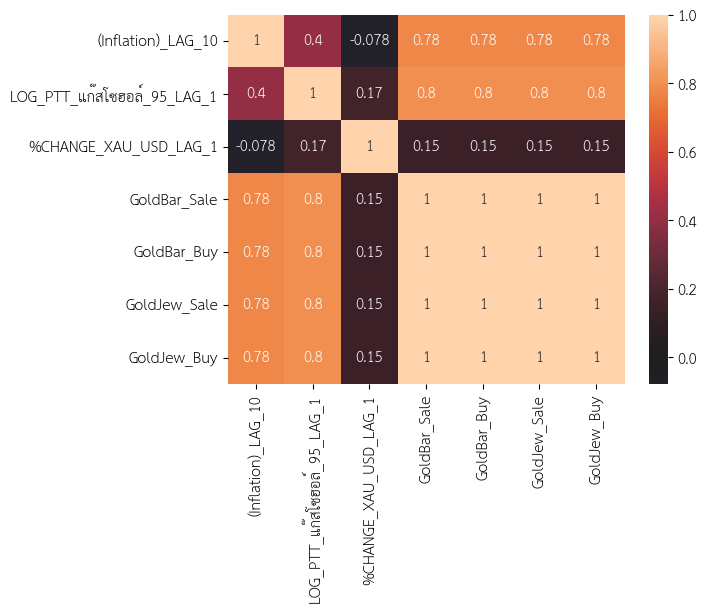

In [58]:
import seaborn as sns
import matplotlib.font_manager as fm

# ตั้งค่าฟอนต์ภาษาไทย
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['font.size'] = 16
Correlation_Gold = pd.DataFrame()
Correlation_Gold = Gold_Factor_data.drop(columns = ['Report Date'])
# plt.figure(figsize=(8, 6))
# sns.heatmap(Correlation_Gold[['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3','LOG_GB_S','LOG_GB_B','LOG_GJ_S','LOG_GJ_B']].corr(),annot=True,center=0)
# sns.heatmap(Correlation_Gold[['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_PTT_ดีเซล_LAG_3','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)
# sns.heatmap(Correlation_Gold[['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)
# sns.heatmap(Correlation_Gold[['(Inflation)','(Inflation)_LAG_4','LOG_CPI','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)
sns.heatmap(Correlation_Gold[['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)
# plt.title('Correlation Matrix')
# plt.show()

<Axes: >

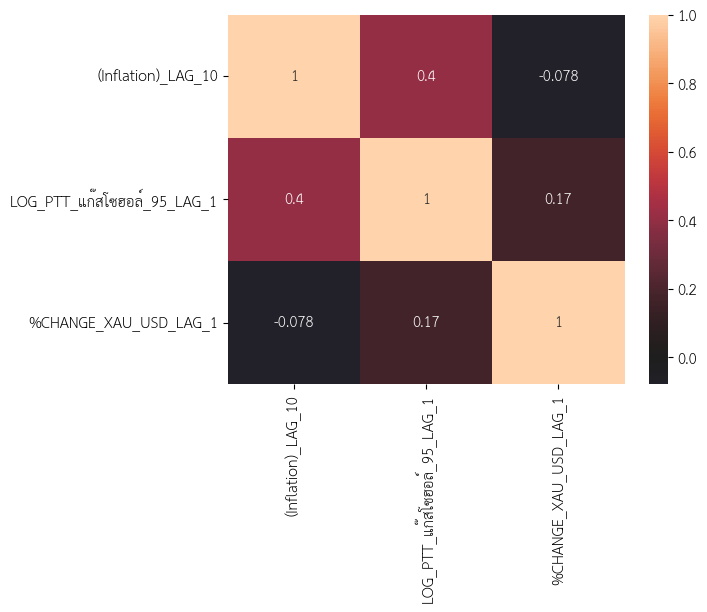

In [59]:
# sns.heatmap(Correlation_Gold[['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']].corr(),annot=True,center=0)
sns.heatmap(Correlation_Gold[['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']].corr(),annot=True,center=0)

<Axes: >

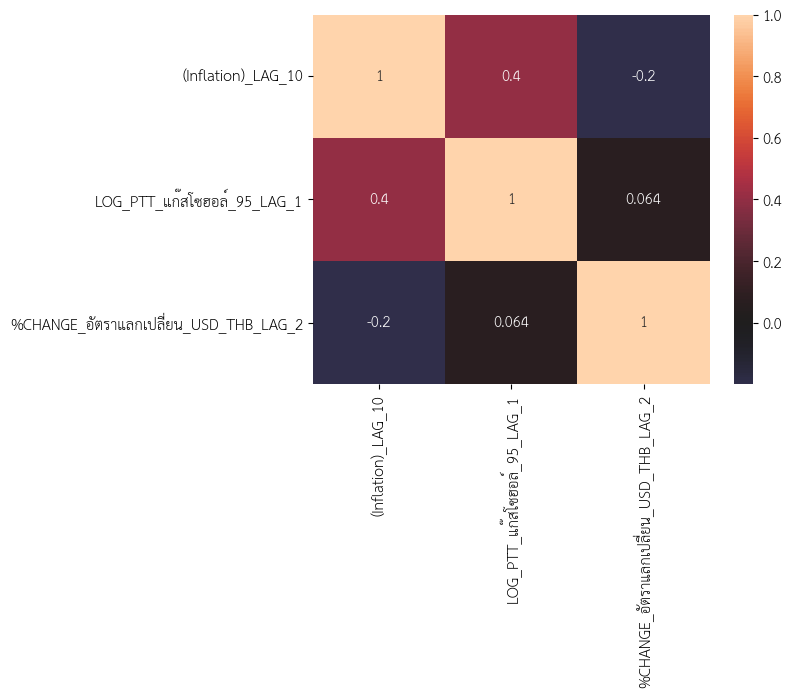

In [60]:
# sns.heatmap(Correlation_Gold[['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']].corr(),annot=True,center=0)
sns.heatmap(Correlation_Gold[['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']].corr(),annot=True,center=0)

<Axes: >

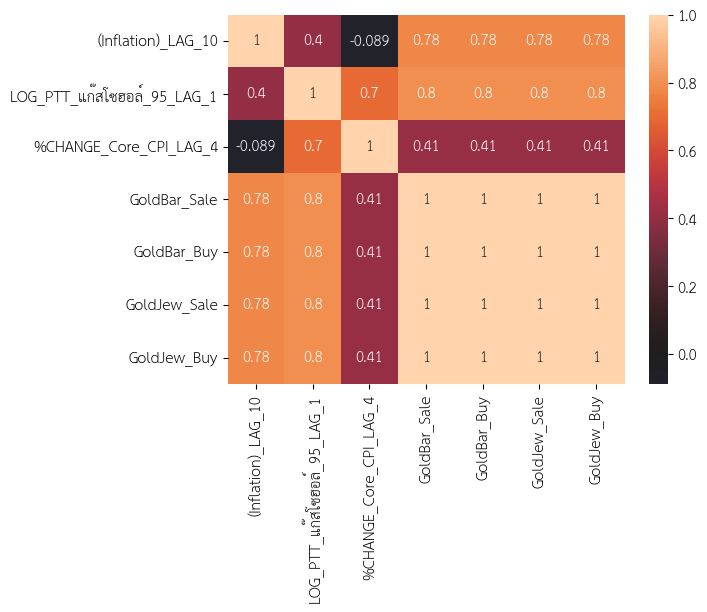

In [61]:
sns.heatmap(Correlation_Gold[['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_Core_CPI_LAG_4','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)


<Axes: >

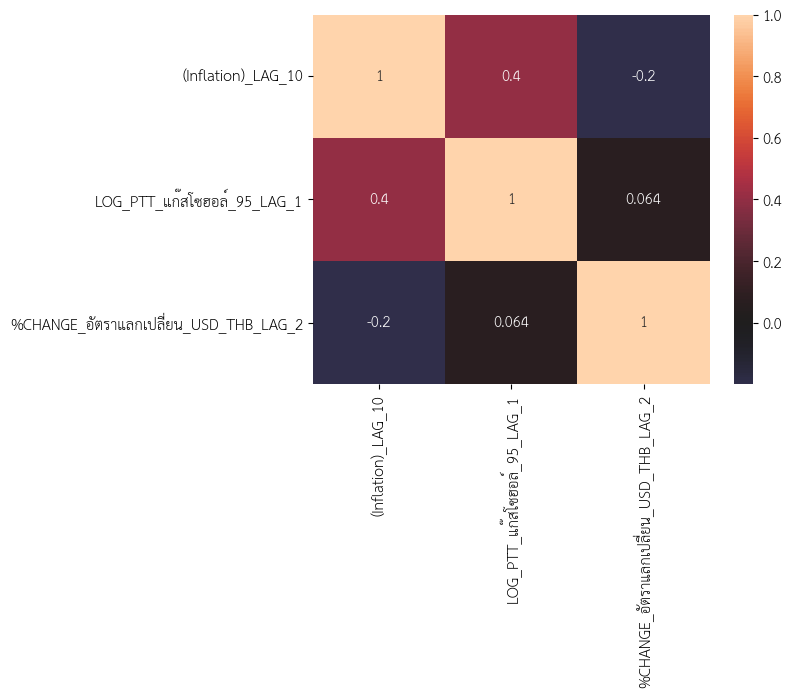

In [62]:
sns.heatmap(Correlation_Gold[['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']].corr(),annot=True,center=0)

<Axes: >

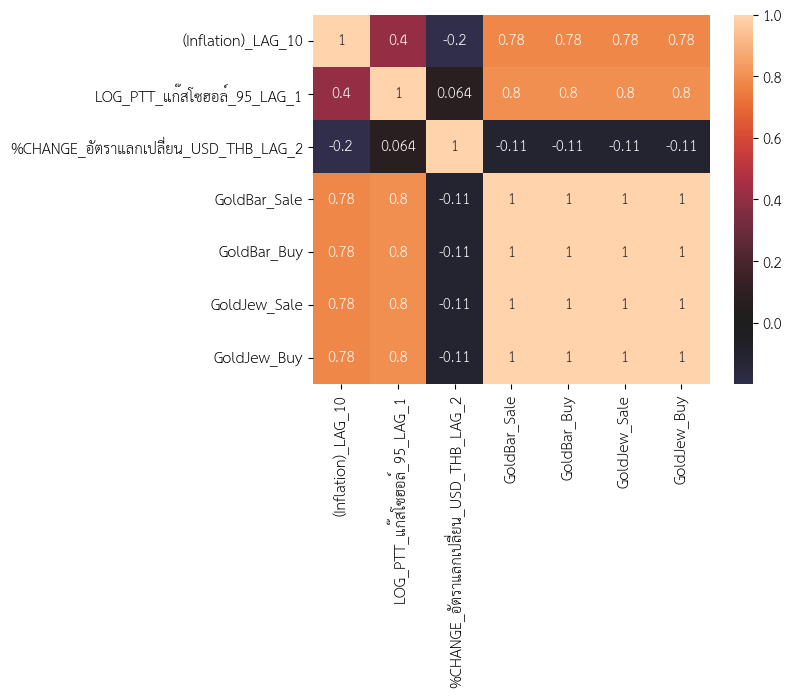

In [63]:
# (Inflation)_LAG_10	LOG_PTT_แก๊สโซฮอล์_95_LAG_1	%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2
sns.heatmap(Correlation_Gold[['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2','GoldBar_Sale','GoldBar_Buy','GoldJew_Sale','GoldJew_Buy']].corr(),annot=True,center=0)

# ตัวแปรที่สนใจ และ กราฟต่างๆ

In [64]:
# ตัวแปรที่สนใจ
Factor_interested = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']
Factor_interested_2 = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']

In [65]:
Gold_Factor_data[['GoldBar_Sale']].count()

GoldBar_Sale    36
dtype: int64

ราคาขายทองคำแท่ง

In [66]:
from sklearn.linear_model import LinearRegression
X_gb_s = Gold_Factor_data[Factor_interested_2]
y_gb_s = ((Gold_Factor_data[['GoldBar_Sale']]))
lrm_gb_s = LinearRegression()
lrm_gb_s.fit(X_gb_s,y_gb_s)
print('intercept , b : ',lrm_gb_s.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gb_s.coef_) # a
r2_gb_s = lrm_gb_s.score(X_gb_s,y_gb_s)
predict_GB_S = lrm_gb_s.predict(X_gb_s)
GB_S = pd.DataFrame()
GB_S['Report Date'] =Gold_Factor_data['Report Date']
GB_S['Predict'] = (predict_GB_S)
X_gb_s = sm.add_constant(X_gb_s)
reg_gb_s = sm.OLS(y_gb_s,X_gb_s).fit()
reg_gb_s.summary()

intercept , b :  [-809.32839426]
coef x1,x2,x3 :  [[  986.44183202  8383.96036893 -2649.65146428]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           GoldBar_Sale   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     87.83
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           1.57e-15
Time:                        08:06:03   Log-Likelihood:                -288.63
No. Observations:                  36   AIC:                             585.3
Df Residuals:                      32   BIC:                             591.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                  -809.3284   3163.493     -0.256      0.800   -7253.152    5634.495
(Inflation)_LAG_10                      986.4418    121.250      8.136      0.000     739.465    1233.419
LOG_PTT_แก๊สโซฮอล์_95_LAG_1            8383.9604    915.436      9.158      0.000    6519.278    1.02e+04
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -2649.6515   3622.428     -0.731      0.470      -1e+04    4728.993
==============================================================================
Omnibus:                        5.498   Durbin-Watson:                   1.060
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.414
Skew:                           0.531   Prob(JB):                        0.110
Kurtosis:                       4.347   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
reg_gb_s.f_pvalue

1.5672254226214708e-15

In [68]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested_2
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested_2], i) for i in range(len(Factor_interested_2))]
vif

Variable       VIF
0                     (Inflation)_LAG_10  2.007136
1            LOG_PTT_แก๊สโซฮอล์_95_LAG_1  2.120672
2  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  1.105042

('Lagrange multiplier statistic', 5.264356042812414)
('p-value', 0.1534320668421573)
('f-value', 1.8269710308184683)
('f p-value', 0.16210076492669168) 




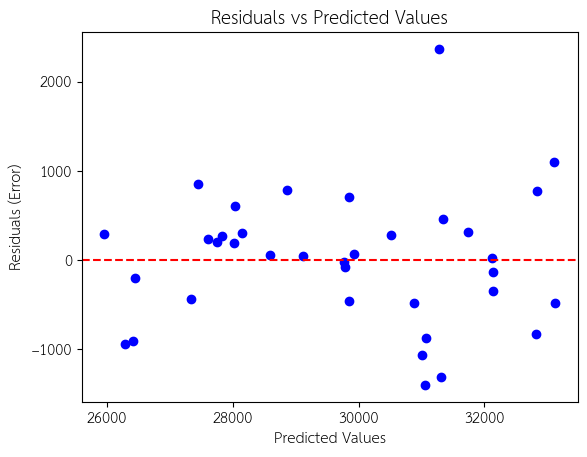

In [69]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gb_s.resid, X_gb_s)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3],'\n\n')
plt.scatter(predict_GB_S, reg_gb_s.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [70]:
BP_test = pd.DataFrame({
    'Lagrange multiplier statistic':[5.264356042812414],
    'p-value' :  [0.1534320668421573],
    'f-value' : [1.8269710308184683],
    'f p-value':[0.16210076492669168]
})
BP_test

Lagrange multiplier statistic   p-value   f-value  f p-value
0                       5.264356  0.153432  1.826971   0.162101

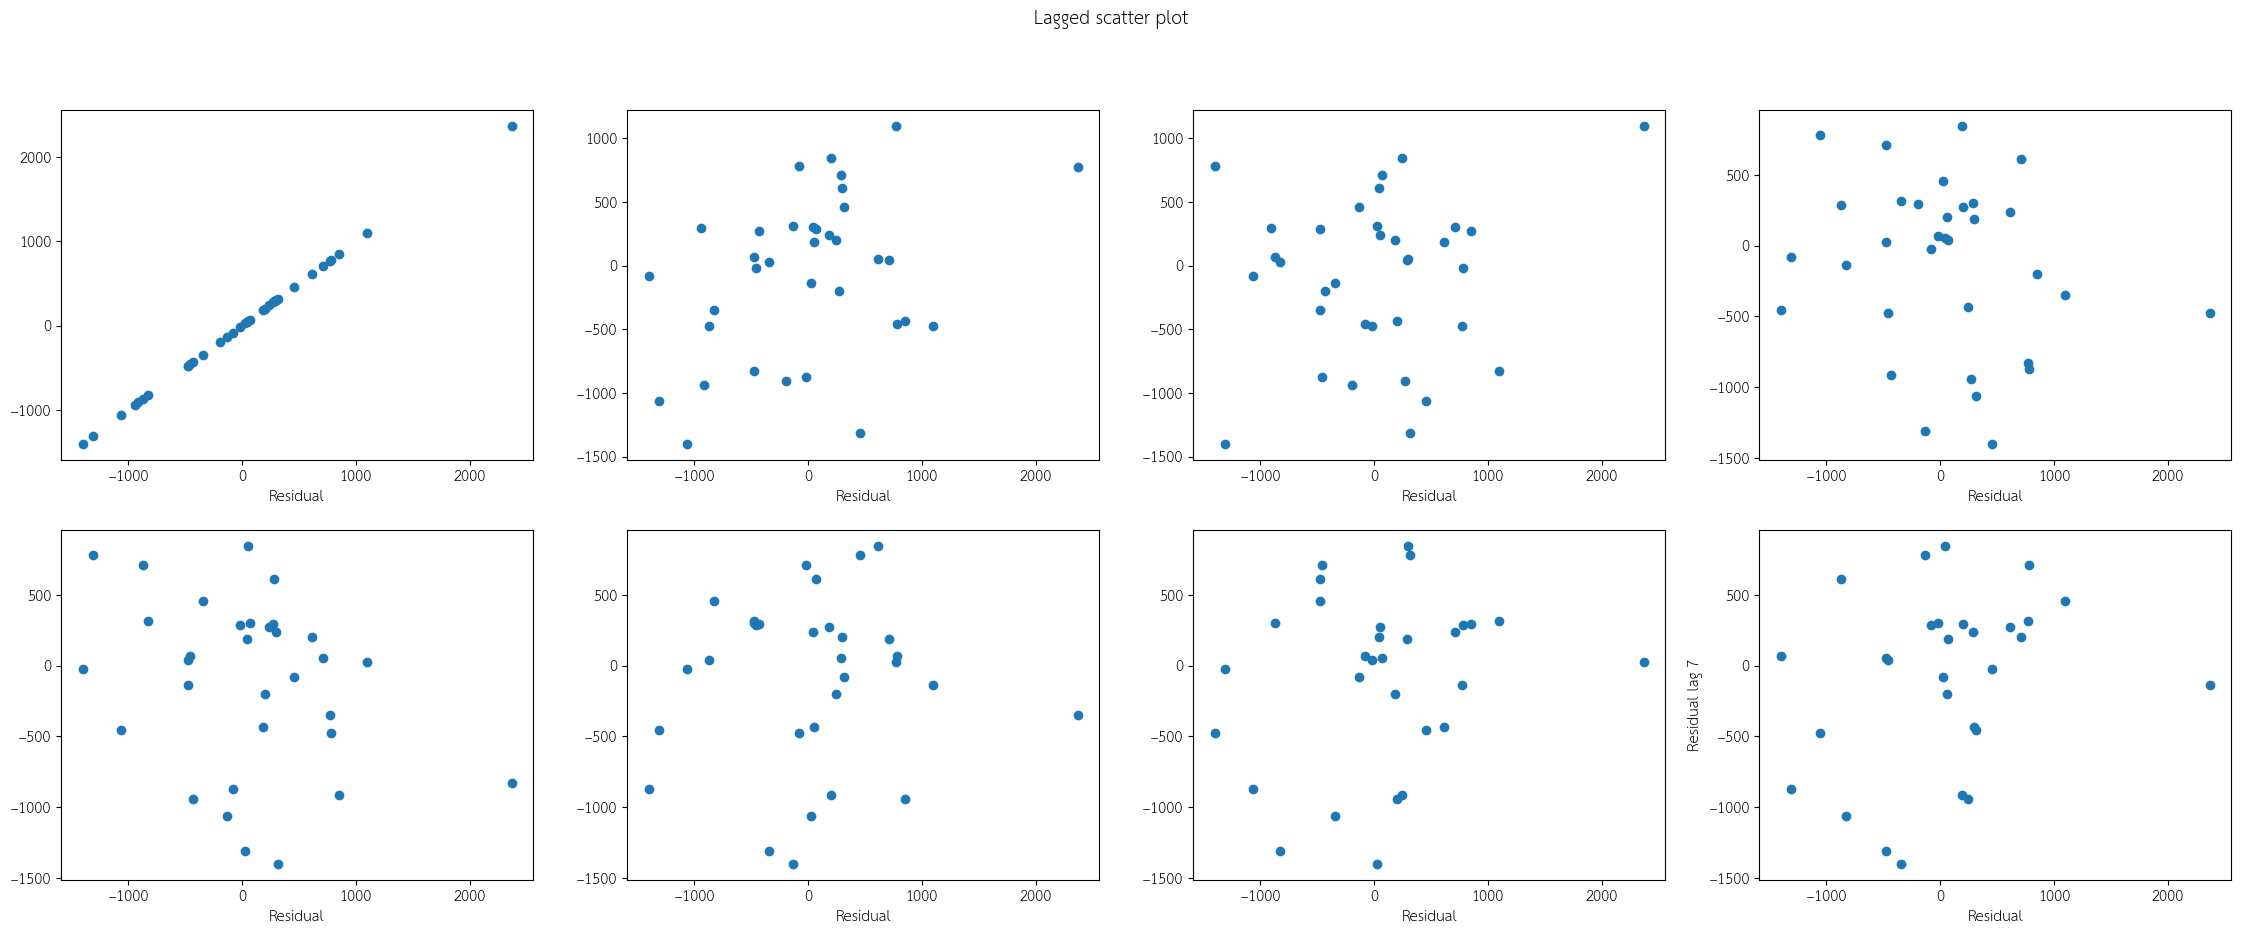

In [71]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gb_s.resid,
                y = reg_gb_s.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

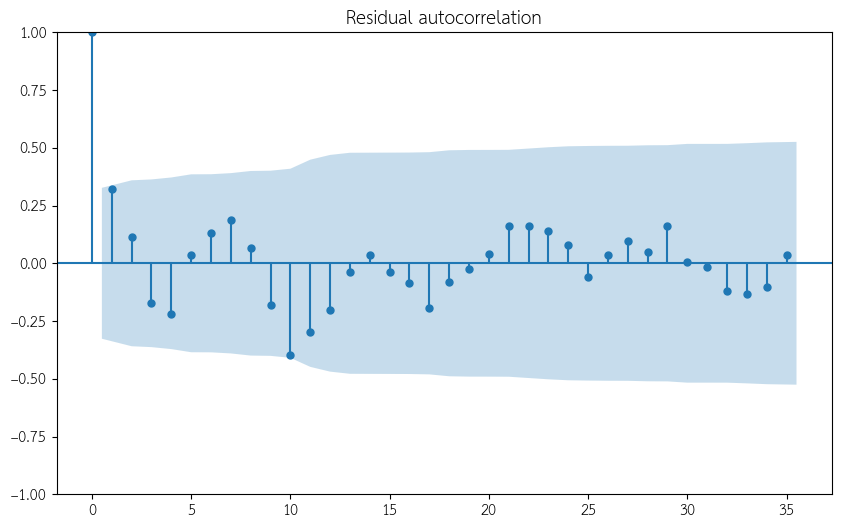

Durbin-Watson :  1.059964333967227


In [72]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gb_s.resid, lags = reg_gb_s.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gb_s.resid))


In [73]:
DW_test = pd.DataFrame({
    'Durbin-Watson' : [sm.stats.durbin_watson(reg_gb_s.resid)]
})
DW_test

Durbin-Watson
0       1.059964

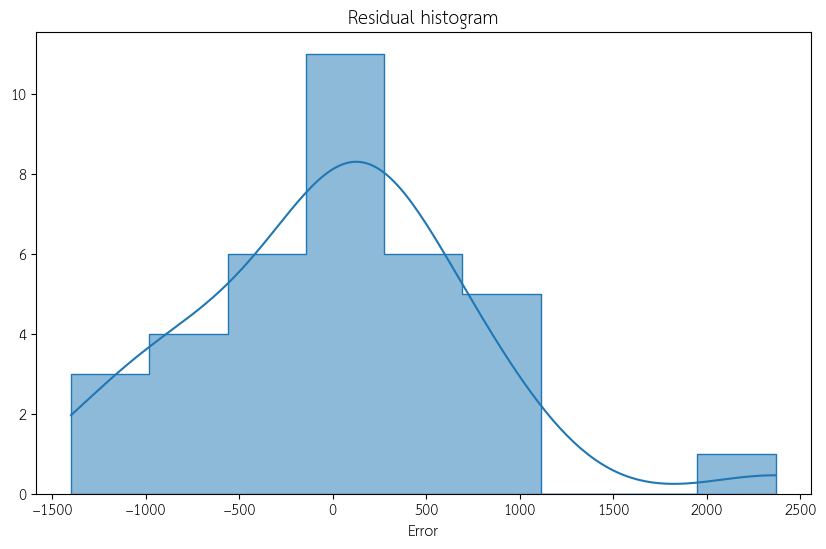

In [74]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gb_s.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

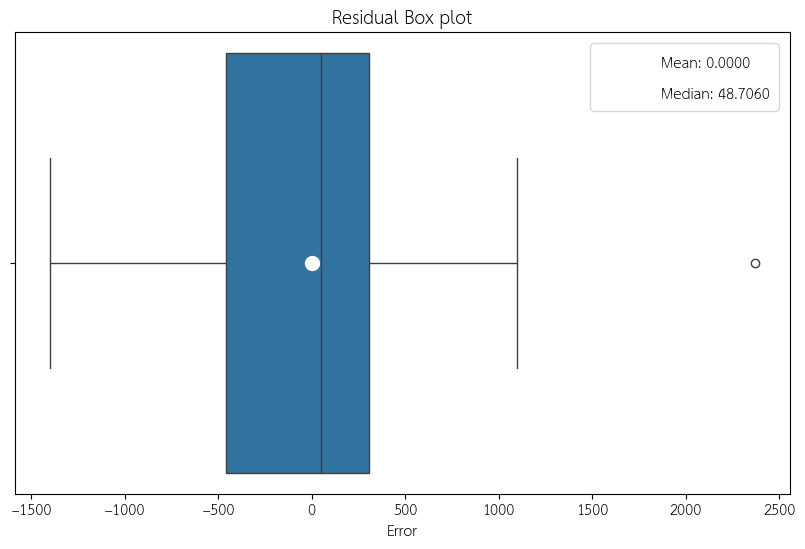

In [75]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gb_s.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gb_s.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gb_s.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

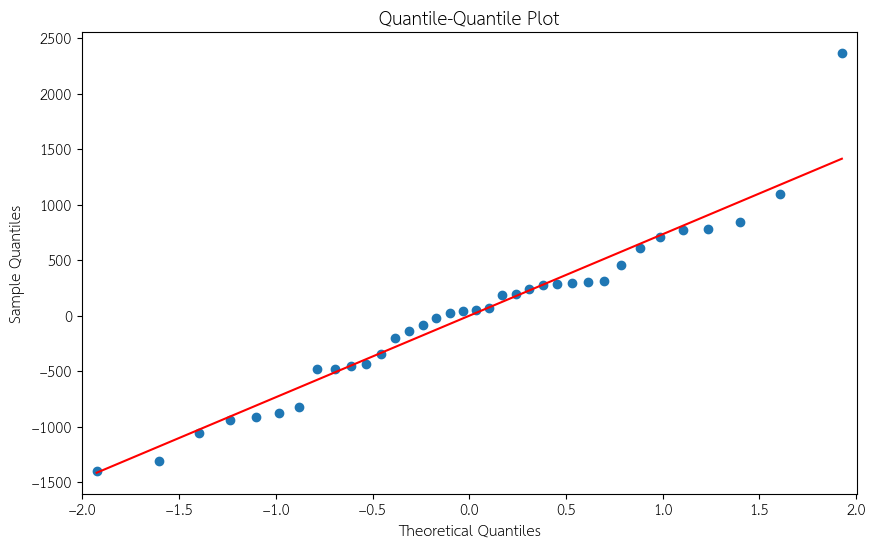

In [76]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gb_s.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [77]:
#Anderson darling for normality
ad = AD(reg_gb_s.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gb_s.resid, dist='norm')[2], AD(reg_gb_s.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gb_s.resid, dist='norm')[1][2:3]
print(f'\nAnderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}\n')


Anderson-Darling statistic: 0.4108973614545093
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]



ราคาซื้อทองคำแท่ง

In [78]:
from sklearn.linear_model import LinearRegression
X_gb_b = Gold_Factor_data[Factor_interested_2]
y_gb_b = (Gold_Factor_data[['GoldBar_Buy']])
lrm_gb_b = LinearRegression()
lrm_gb_b.fit(X_gb_b,y_gb_b)
print('intercept , b : ',lrm_gb_b.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gb_b.coef_,'\n\n') # a
r2_gb_b = lrm_gb_b.score(X_gb_b,y_gb_b)
predict_GB_B = lrm_gb_b.predict(X_gb_b)
GB_B = pd.DataFrame()
GB_B['Report Date'] =Gold_Factor_data['Report Date']
GB_B['Predict'] = (predict_GB_B)
X_gb_b = sm.add_constant(X_gb_b)
reg_gb_b = sm.OLS(y_gb_b,X_gb_b).fit()
reg_gb_b.summary()

intercept , b :  [-909.32839426]
coef x1,x2,x3 :  [[  986.44183202  8383.96036893 -2649.65146428]] 




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GoldBar_Buy   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     87.83
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           1.57e-15
Time:                        08:06:06   Log-Likelihood:                -288.63
No. Observations:                  36   AIC:                             585.3
Df Residuals:                      32   BIC:                             591.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                  -909.3284   3163.493     -0.287      0.776   -7353.152    5534.495
(Inflation)_LAG_10                      986.4418    121.250      8.136      0.000     739.465    1233.419
LOG_PTT_แก๊สโซฮอล์_95_LAG_1            8383.9604    915.436      9.158      0.000    6519.278    1.02e+04
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -2649.6515   3622.428     -0.731      0.470      -1e+04    4728.993
==============================================================================
Omnibus:                        5.498   Durbin-Watson:                   1.060
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.414
Skew:                           0.531   Prob(JB):                        0.110
Kurtosis:                       4.347   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested_2
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested_2], i) for i in range(len(Factor_interested_2))]
vif

Variable       VIF
0                     (Inflation)_LAG_10  2.007136
1            LOG_PTT_แก๊สโซฮอล์_95_LAG_1  2.120672
2  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  1.105042

('Lagrange multiplier statistic', 5.264356042812466)
('p-value', 0.1534320668421537)
('f-value', 1.8269710308184888)
('f p-value', 0.16210076492668812)


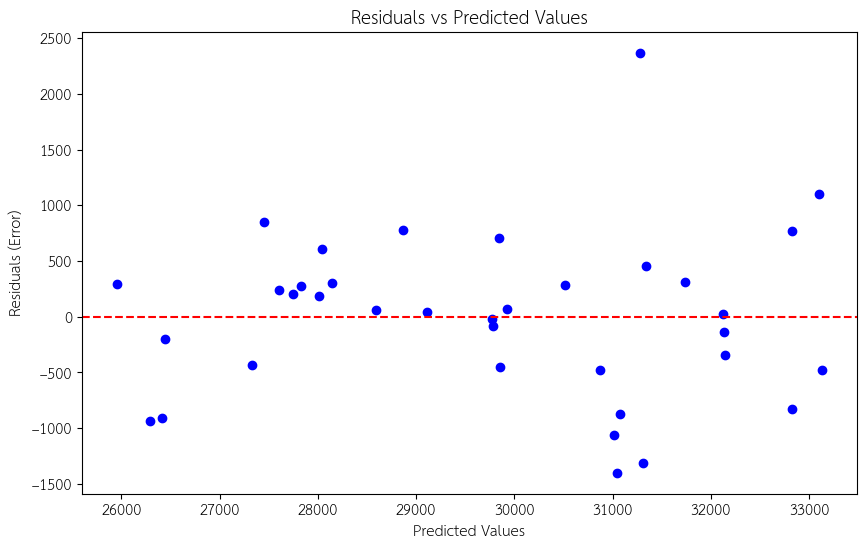

In [80]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gb_b.resid, X_gb_b)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3])
plt.scatter(predict_GB_S, reg_gb_b.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

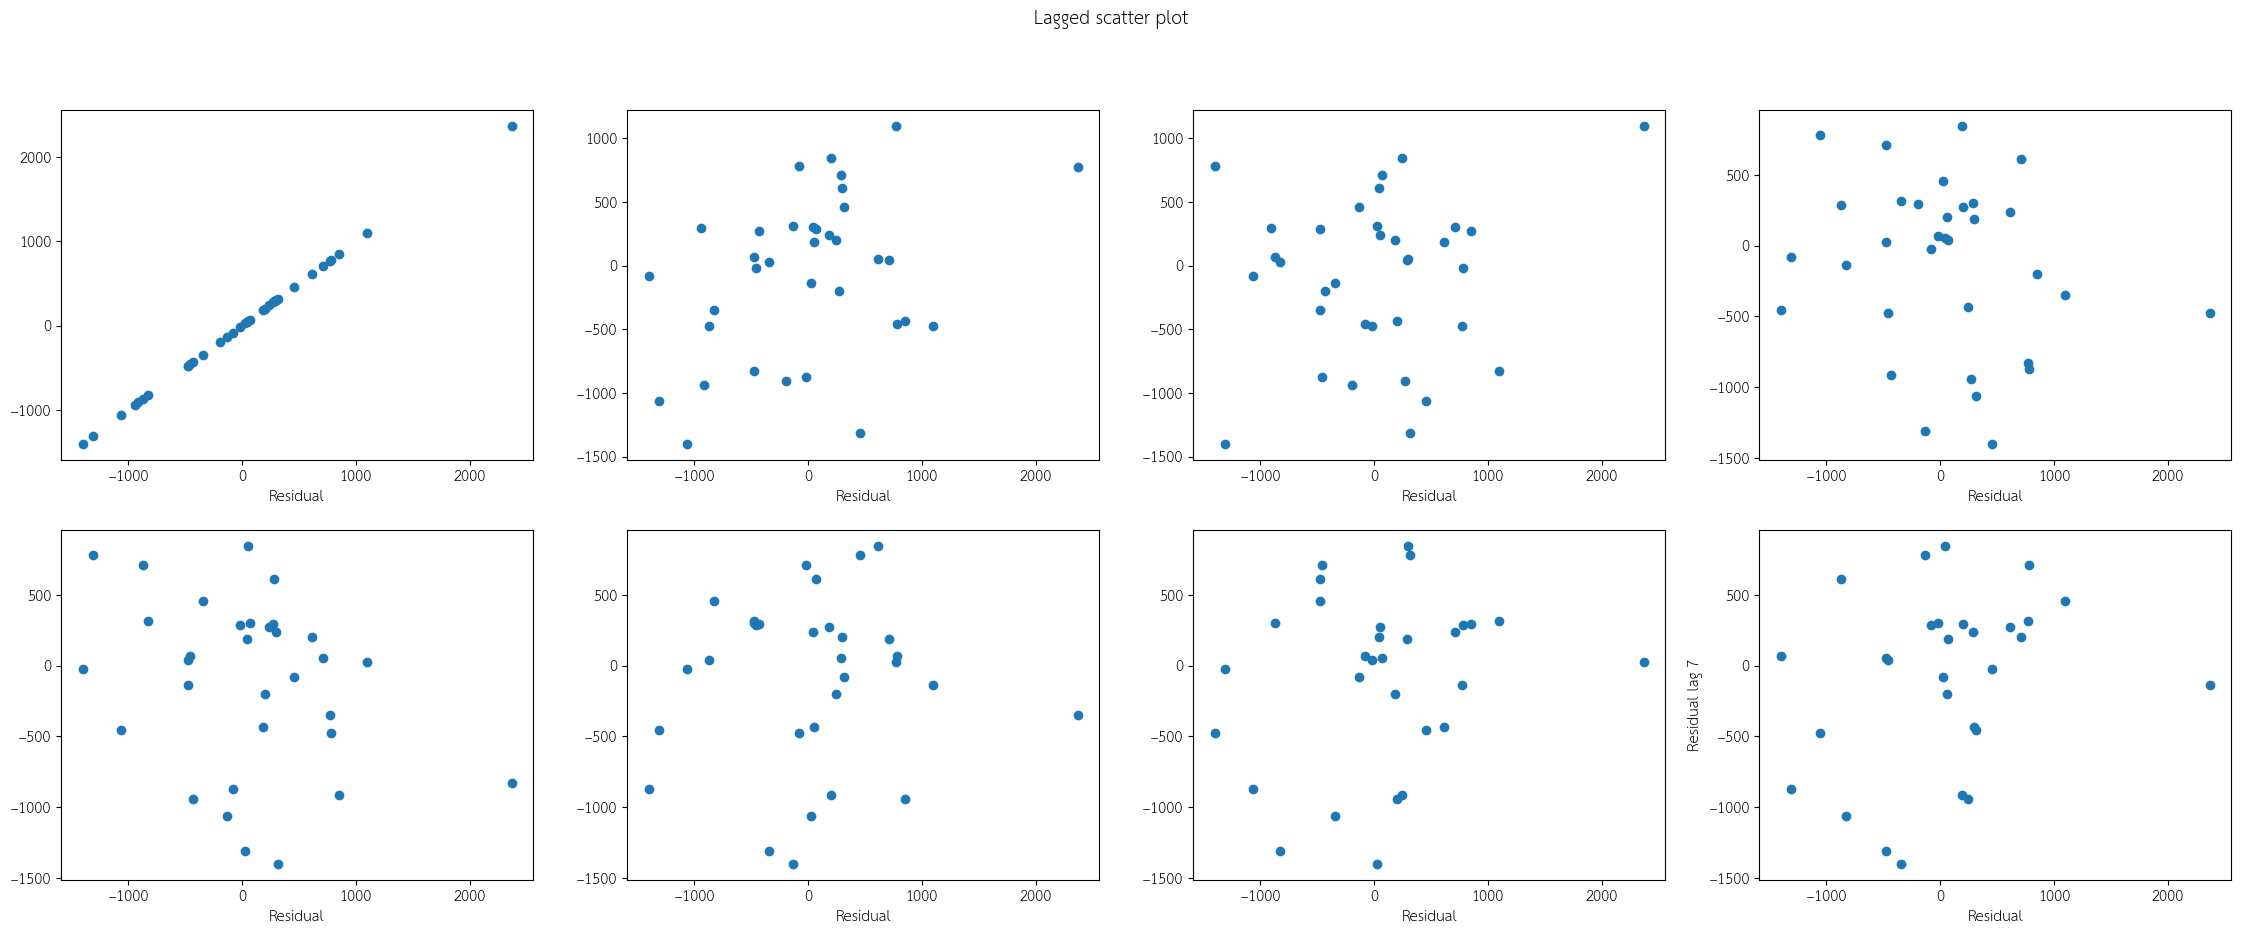

In [81]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gb_b.resid,
                y = reg_gb_b.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

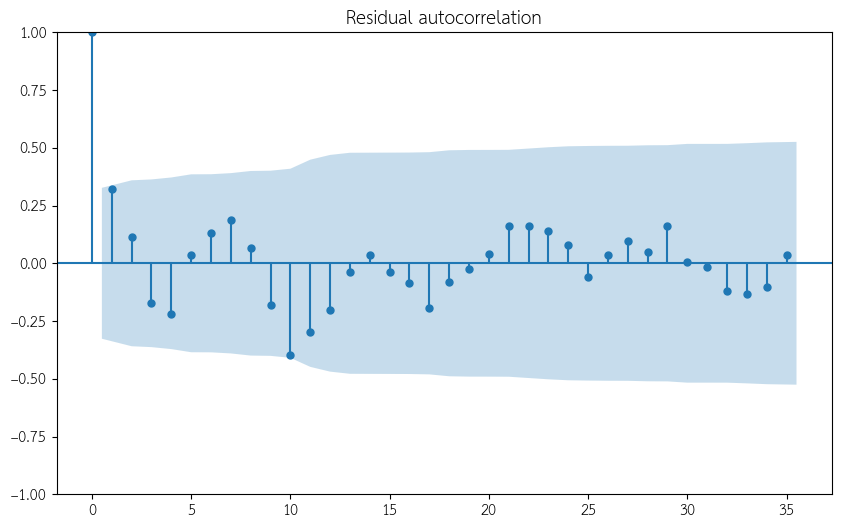

Durbin-Watson :  1.0599643339672278


In [82]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gb_b.resid, lags = reg_gb_b.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gb_b.resid))


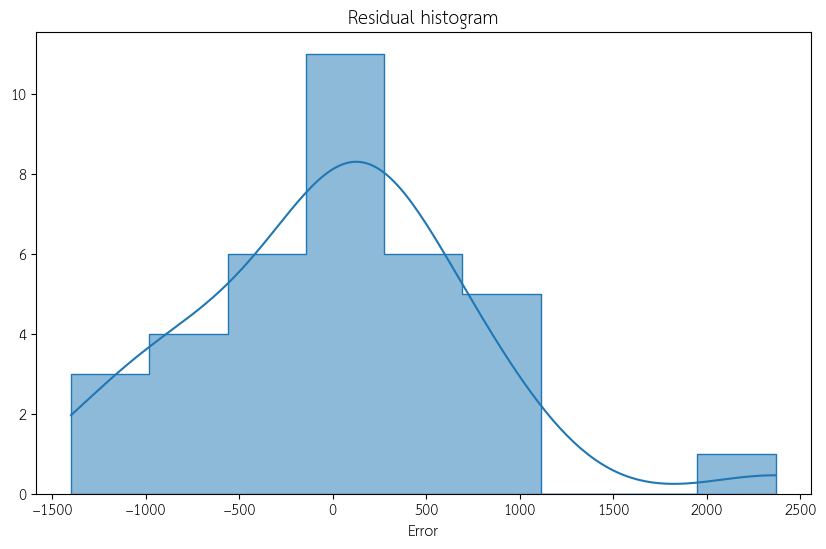

In [83]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gb_b.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

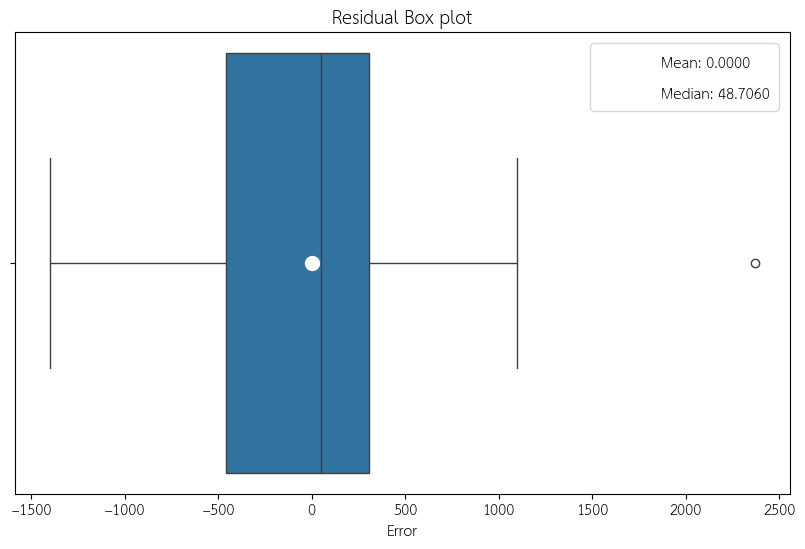

In [84]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gb_b.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gb_b.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gb_b.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

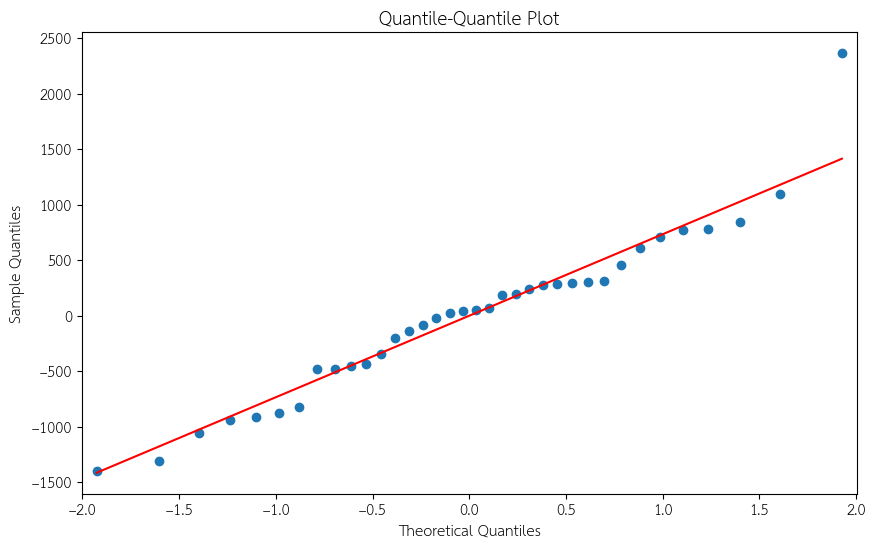

In [85]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gb_b.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [86]:
#Anderson darling for normality
ad = AD(reg_gb_b.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gb_b.resid, dist='norm')[2], AD(reg_gb_b.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gb_b.resid, dist='norm')[1][2:3]
print(f'Anderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}')

Anderson-Darling statistic: 0.4108973614545022
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]


ราคาขายทองคำรูปพรรณ

In [87]:
from sklearn.linear_model import LinearRegression
X_gj_s = Gold_Factor_data[Factor_interested_2]
y_gj_s = (Gold_Factor_data[['GoldJew_Sale']])
lrm_gj_s = LinearRegression()
lrm_gj_s.fit(X_gj_s,y_gj_s)
print('intercept , b : ',lrm_gj_s.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gj_s.coef_) # a
r2_gj_s = lrm_gj_s.score(X_gj_s,y_gj_s)
predict_GJ_S = lrm_gj_s.predict(X_gj_s)
GJ_S = pd.DataFrame()
GJ_S['Report Date'] =Gold_Factor_data['Report Date']
GJ_S['Predict'] = (predict_GJ_S)
predict_GJ_S
X_gj_s = sm.add_constant(X_gj_s)
reg_gj_s = sm.OLS(y_gj_s,X_gj_s).fit()
reg_gj_s.summary()

intercept , b :  [-309.32839426]
coef x1,x2,x3 :  [[  986.44183202  8383.96036893 -2649.65146428]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           GoldJew_Sale   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     87.83
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           1.57e-15
Time:                        08:06:08   Log-Likelihood:                -288.63
No. Observations:                  36   AIC:                             585.3
Df Residuals:                      32   BIC:                             591.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                  -309.3284   3163.493     -0.098      0.923   -6753.152    6134.495
(Inflation)_LAG_10                      986.4418    121.250      8.136      0.000     739.465    1233.419
LOG_PTT_แก๊สโซฮอล์_95_LAG_1            8383.9604    915.436      9.158      0.000    6519.278    1.02e+04
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -2649.6515   3622.428     -0.731      0.470      -1e+04    4728.993
==============================================================================
Omnibus:                        5.498   Durbin-Watson:                   1.060
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.414
Skew:                           0.531   Prob(JB):                        0.110
Kurtosis:                       4.347   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested_2
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested_2], i) for i in range(len(Factor_interested_2))]
vif

Variable       VIF
0                     (Inflation)_LAG_10  2.007136
1            LOG_PTT_แก๊สโซฮอล์_95_LAG_1  2.120672
2  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  1.105042

('Lagrange multiplier statistic', 5.264356042812442)
('p-value', 0.15343206684215513)
('f-value', 1.8269710308184788)
('f p-value', 0.16210076492669)


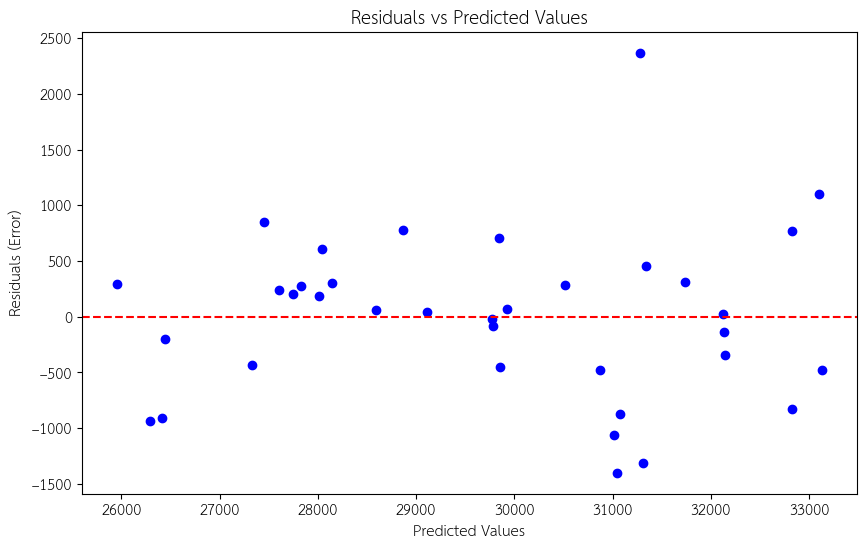

In [89]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gj_s.resid, X_gb_s)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3])
plt.scatter(predict_GB_S, reg_gj_s.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

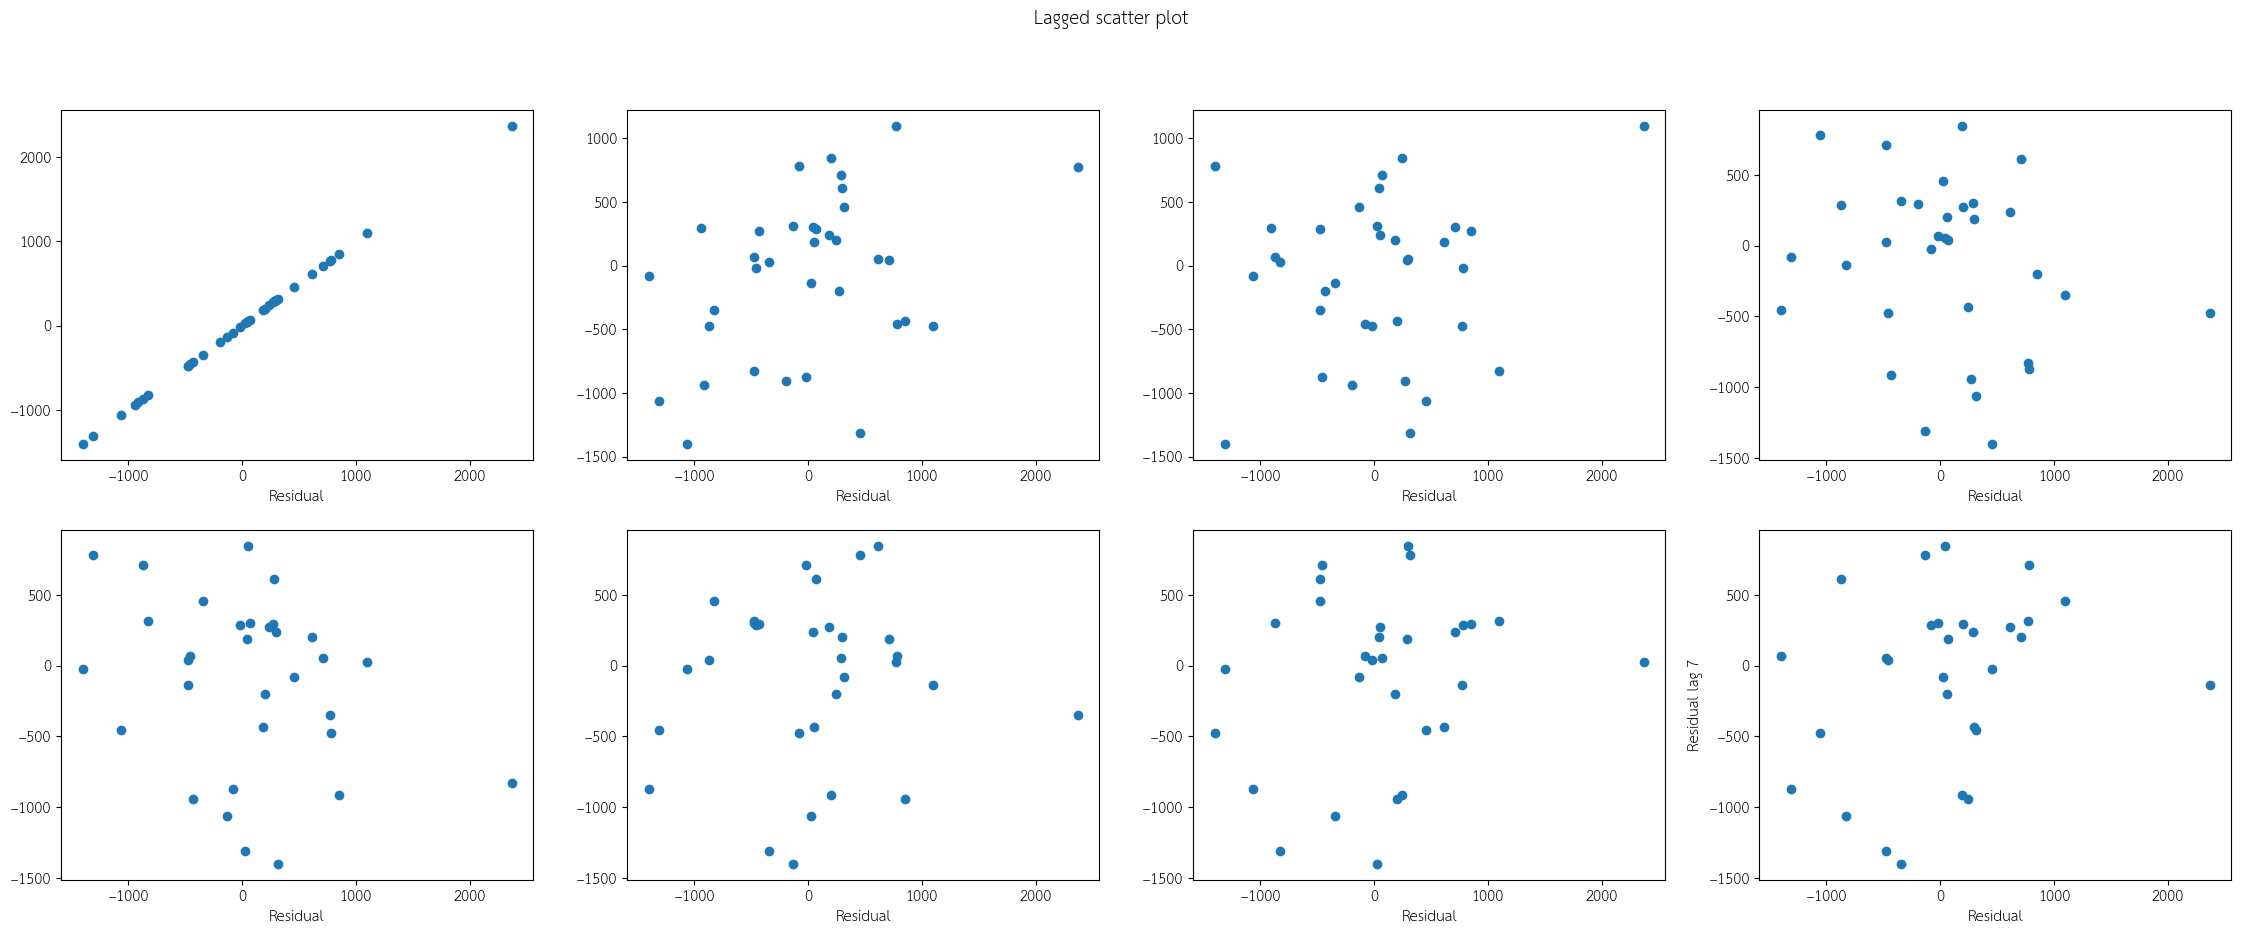

In [90]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gj_s.resid,
                y = reg_gj_s.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

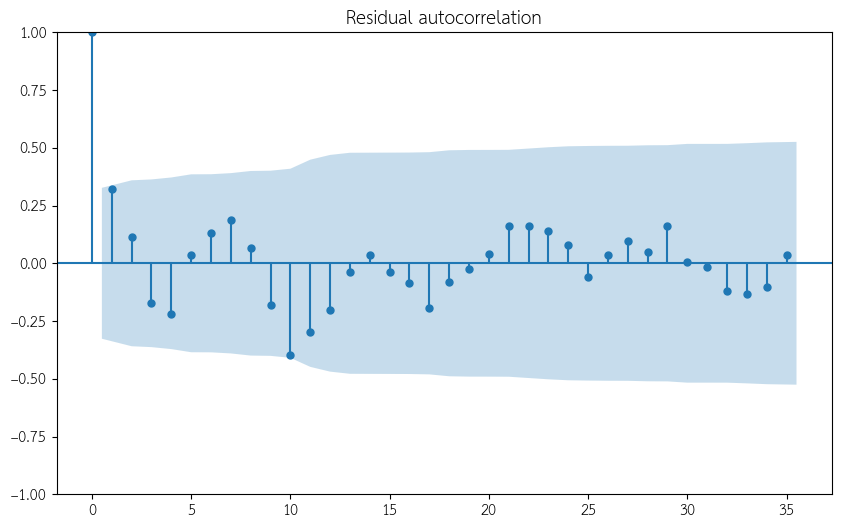

Durbin-Watson :  1.0599643339672282


In [91]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gj_s.resid, lags = reg_gj_s.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gj_s.resid))


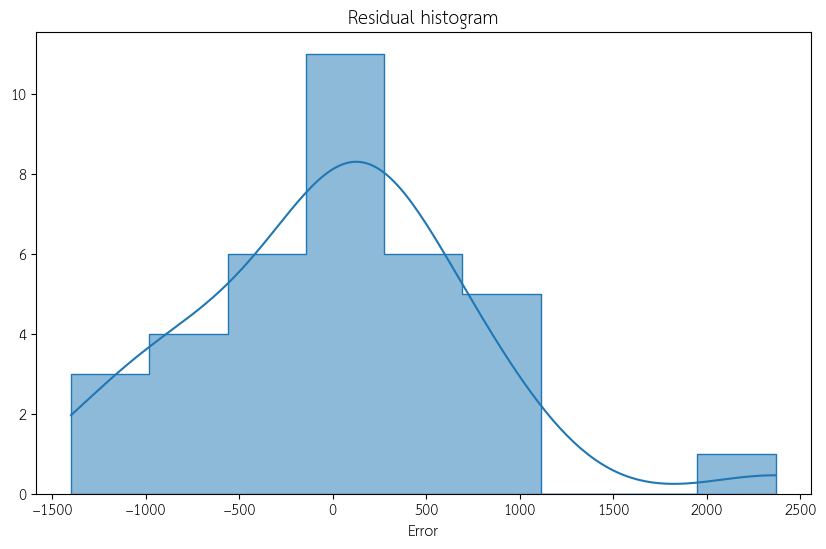

In [92]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gj_s.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

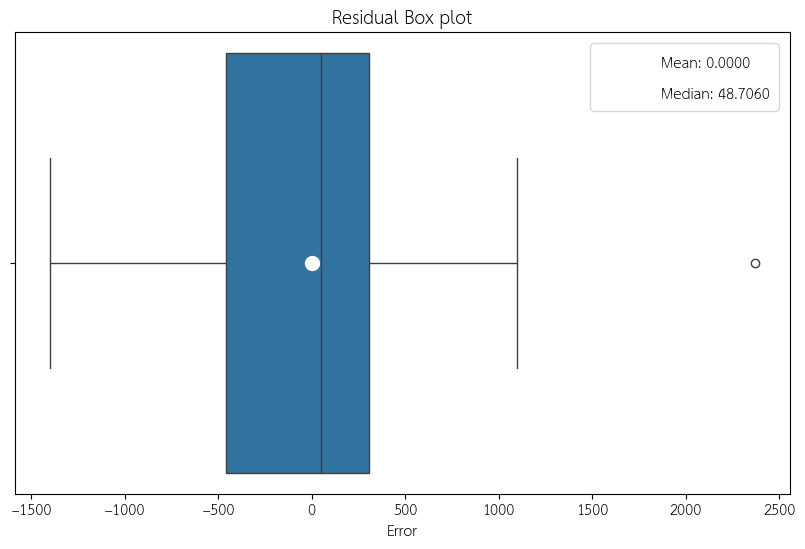

In [93]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gj_s.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gj_s.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gj_s.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

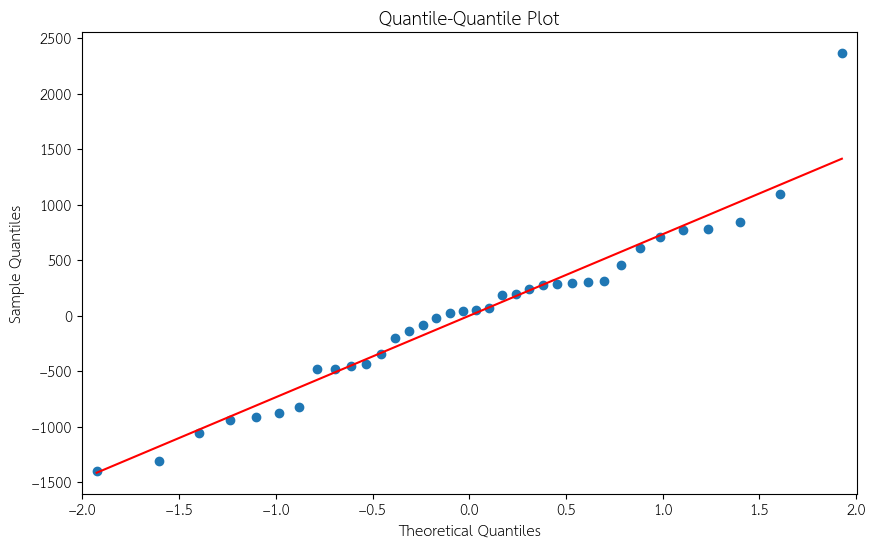

In [94]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gj_s.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [95]:
#Anderson darling for normality
ad = AD(reg_gj_s.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gj_s.resid, dist='norm')[2], AD(reg_gj_s.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gj_s.resid, dist='norm')[1][2:3]
print(f'Anderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}')

Anderson-Darling statistic: 0.4108973614545022
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]


ราคาซื้อทองรูปพรรณ

In [96]:
from sklearn.linear_model import LinearRegression
X_gj_b = Gold_Factor_data[Factor_interested_2]
y_gj_b = (Gold_Factor_data[['GoldJew_Buy']])
lrm_gj_b = LinearRegression()
lrm_gj_b.fit(X_gj_b,y_gj_b)
print('intercept , b : ',lrm_gj_b.intercept_) # b
print('coef x1,x2,x3 : ',lrm_gj_b.coef_) # a
r2_gj_b = lrm_gj_b.score(X_gj_b,y_gj_b)
predict_GJ_B = lrm_gj_b.predict(X_gj_b)
GJ_B = pd.DataFrame()
GJ_B['Report Date'] =Gold_Factor_data['Report Date']
GJ_B['Predict'] = (predict_GJ_B)
predict_GJ_B
X_gj_b = sm.add_constant(X_gj_b)
reg_gj_b = sm.OLS(y_gj_b,X_gj_b).fit()
reg_gj_b.summary()

intercept , b :  [-897.3189696]
coef x1,x2,x3 :  [[  967.69499315  8234.58589838 -2595.08977866]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GoldJew_Buy   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     87.89
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           1.55e-15
Time:                        08:06:10   Log-Likelihood:                -287.95
No. Observations:                  36   AIC:                             583.9
Df Residuals:                      32   BIC:                             590.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                  -897.3190   3104.247     -0.289      0.774   -7220.463    5425.825
(Inflation)_LAG_10                      967.6950    118.979      8.133      0.000     725.343    1210.047
LOG_PTT_แก๊สโซฮอล์_95_LAG_1            8234.5859    898.292      9.167      0.000    6404.826    1.01e+04
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2 -2595.0898   3554.587     -0.730      0.471   -9835.547    4645.368
==============================================================================
Omnibus:                        5.498   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.407
Skew:                           0.533   Prob(JB):                        0.110
Kurtosis:                       4.343   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
#VIF
vif = pd.DataFrame()
vif['Variable'] = Factor_interested_2
vif['VIF'] = [variance_inflation_factor(Gold_Factor_data[Factor_interested_2], i) for i in range(len(Factor_interested_2))]
vif

Variable       VIF
0                     (Inflation)_LAG_10  2.007136
1            LOG_PTT_แก๊สโซฮอล์_95_LAG_1  2.120672
2  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  1.105042

('Lagrange multiplier statistic', 5.264356042812442)
('p-value', 0.15343206684215513)
('f-value', 1.8269710308184788)
('f p-value', 0.16210076492669)


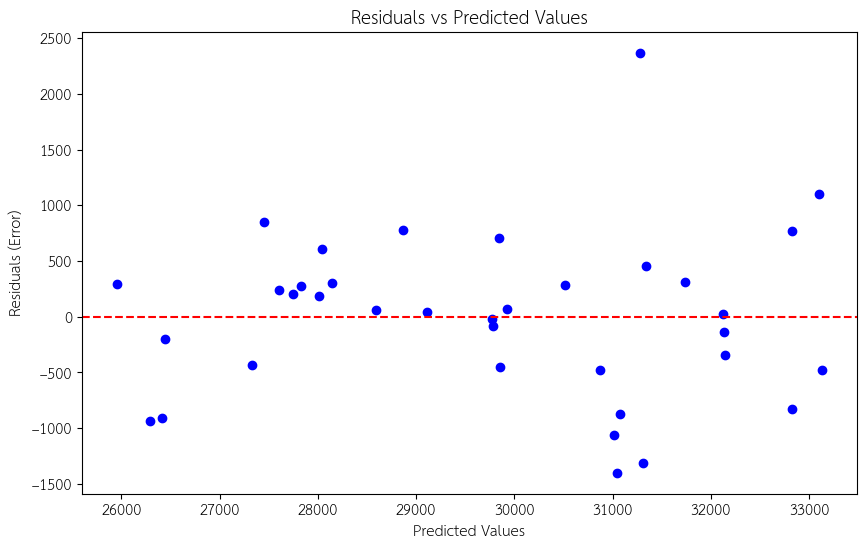

In [98]:
# Heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
# แสดงผลลัพธ์การทดสอบ
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_test = het_breuschpagan(reg_gj_s.resid, X_gj_s)
# print(lzip(labels, bp_test)[1][1])
print(lzip(labels, bp_test)[0])
print(lzip(labels, bp_test)[1])
print(lzip(labels, bp_test)[2])
print(lzip(labels, bp_test)[3])
plt.scatter(predict_GB_S, reg_gj_s.resid,color='blue')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Error)')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

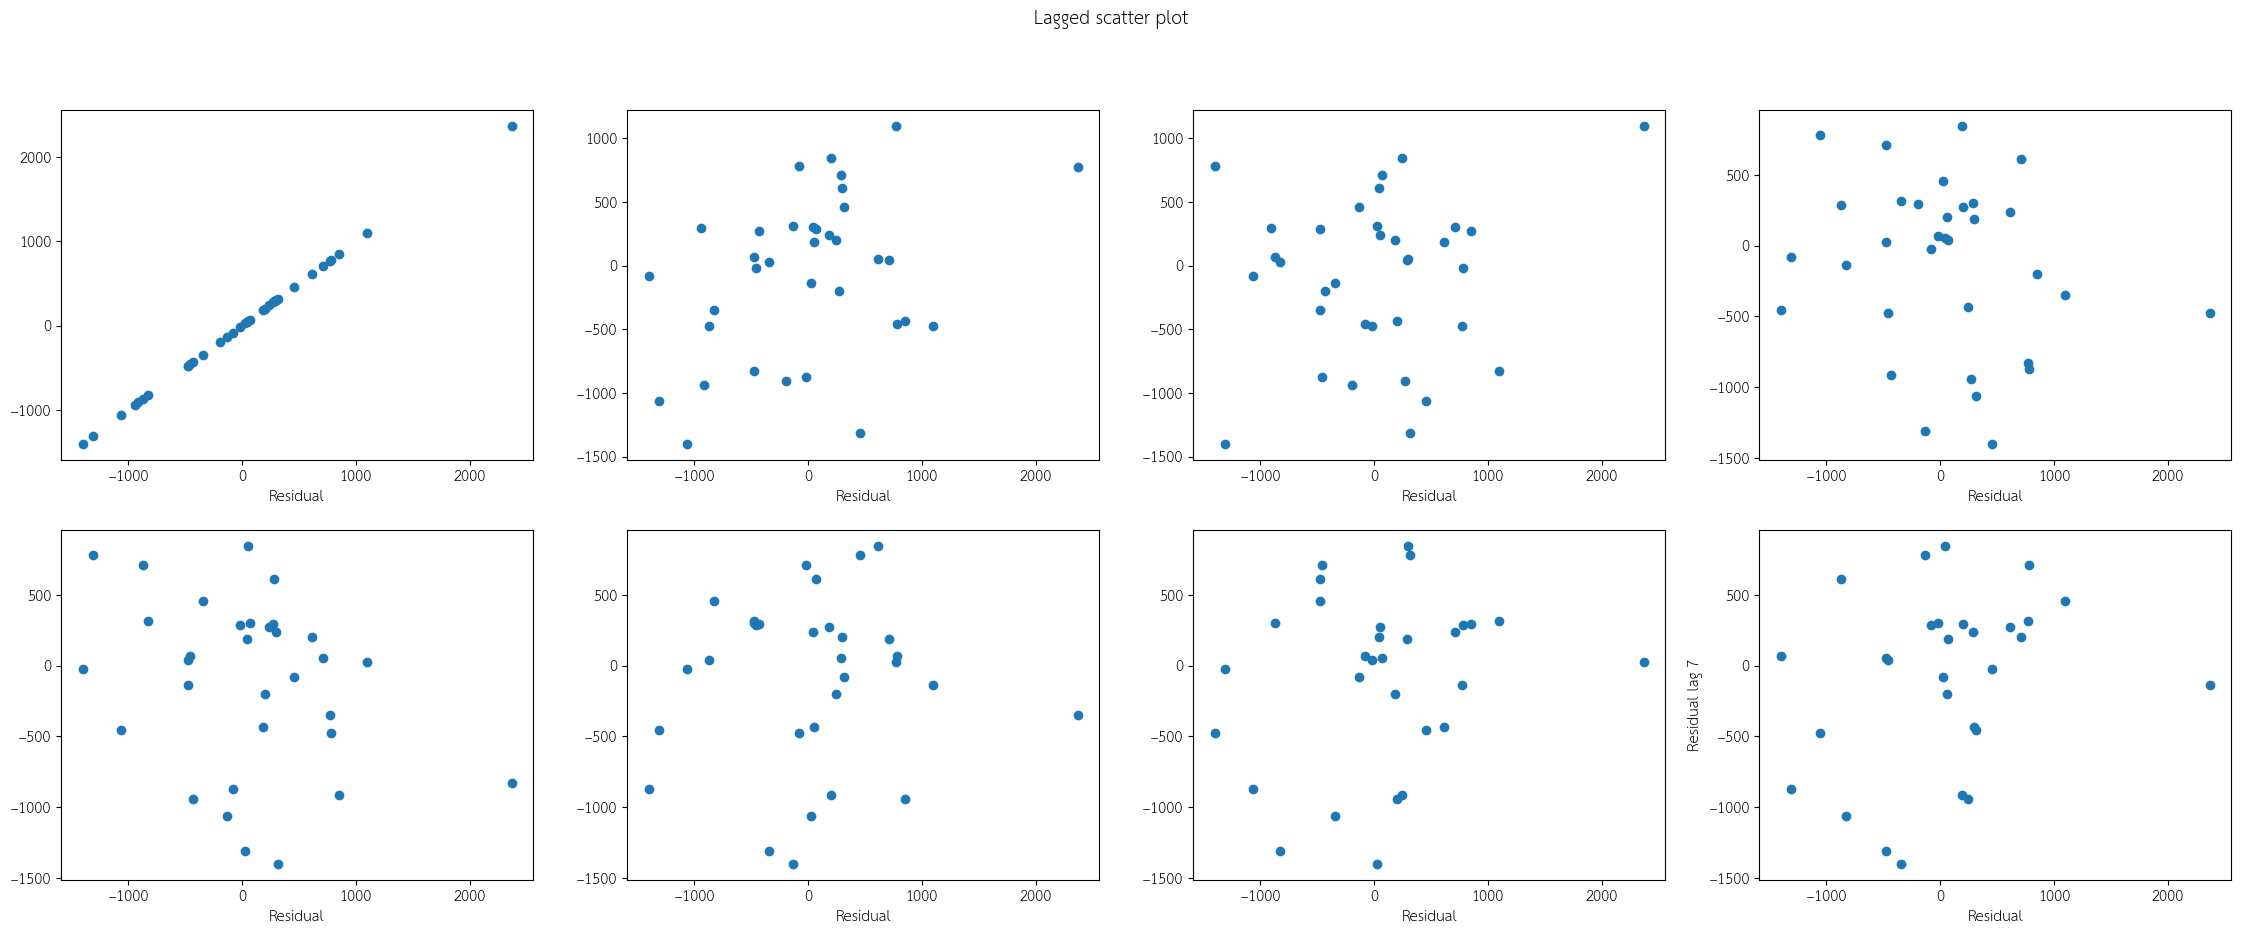

In [99]:
# กราฟ auto correlation
fig, axs = plt.subplots(2, 4, figsize = (28, 10))
fig.suptitle('Lagged scatter plot')
axs = axs.ravel()
for i in range(8):
    axs[i].scatter(x = reg_gj_s.resid,
                y = reg_gj_s.resid.shift(i))
    axs[i].set_xlabel('Residual')
if i == 0:
    axs[i].set_ylabel('Residual')
else:
    axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

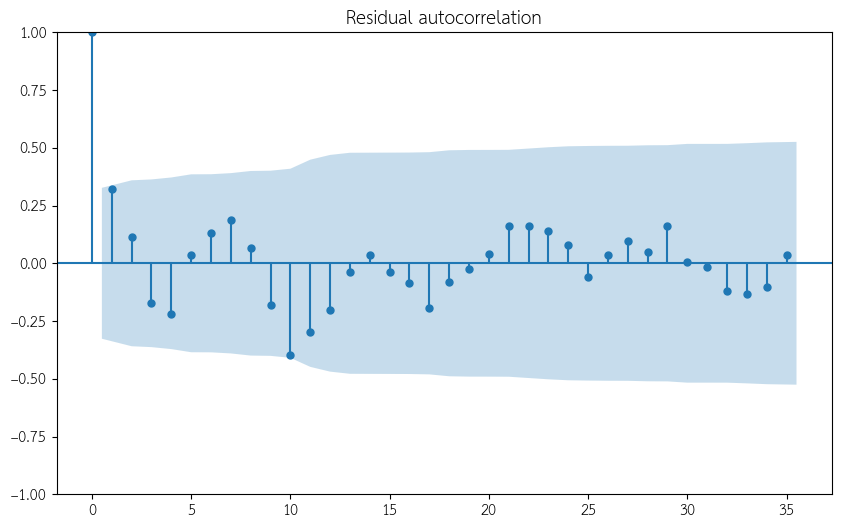

Durbin-Watson :  1.059964333967227


In [100]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rc('figure', figsize = (10, 6))
plot_acf(reg_gj_s.resid, lags = reg_gj_s.resid.shape[0] - 1, #-1 for not consider itself
       title = 'Residual autocorrelation')
plt.show()
# reg_gb_s.resid.shape[0]
print("Durbin-Watson : ",sm.stats.durbin_watson(reg_gb_s.resid))


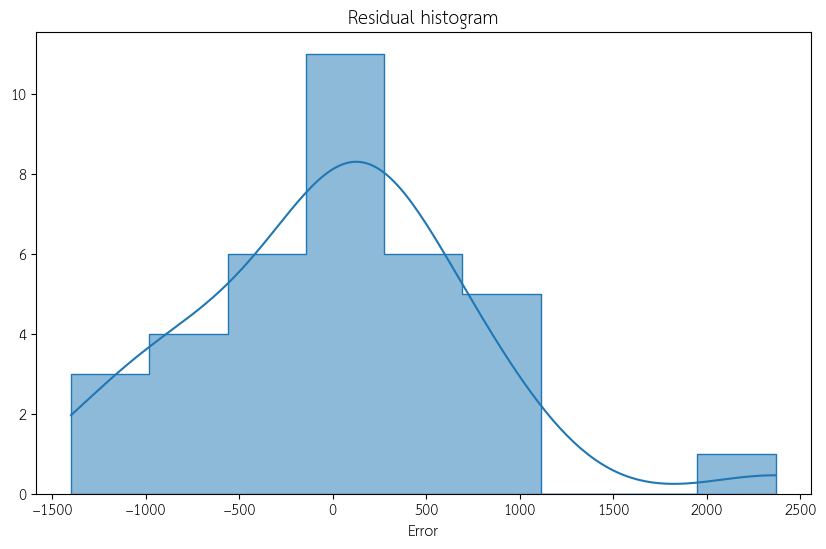

In [101]:
# Plot histogram for nomality
plt.figure(figsize = (10, 6))

ax = sns.histplot(x = reg_gj_s.resid,
                kde = True,
                element = 'step')
ax.set_title('Residual histogram')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

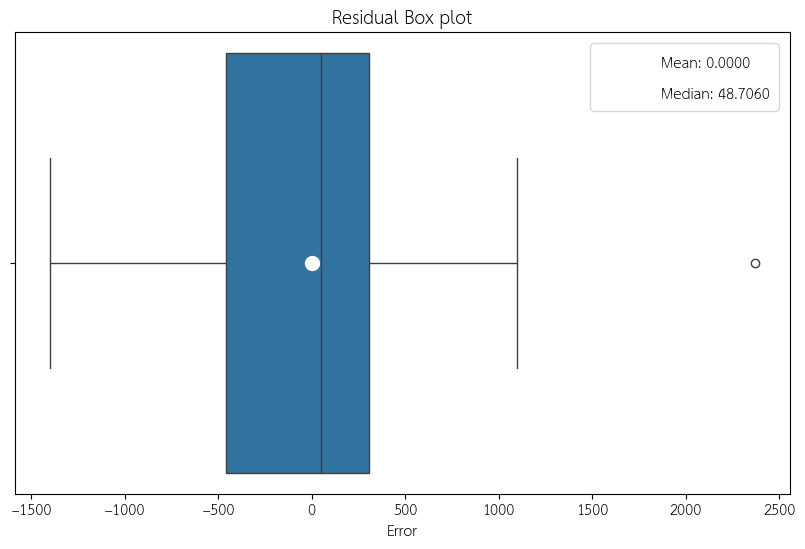

In [102]:
# Box plot for normality
plt.figure(figsize = (10, 6))

ax = sns.boxplot(x = reg_gj_s.resid,
               showmeans = True,
               meanprops = {'marker': 'o',
                            'markerfacecolor': 'white',
                            'markeredgecolor': 'white',
                            'markersize': '10'})
ax.plot([], [], ' ', label = f'Mean: {np.mean(reg_gj_s.resid):.4f}')
ax.plot([], [], ' ', label = f'Median: {np.median(reg_gj_s.resid):.4f}')
ax.legend(frameon = True, facecolor = 'white')
ax.set_title('Residual Box plot')
ax.set(xlabel = 'Error', ylabel = '')
plt.show()

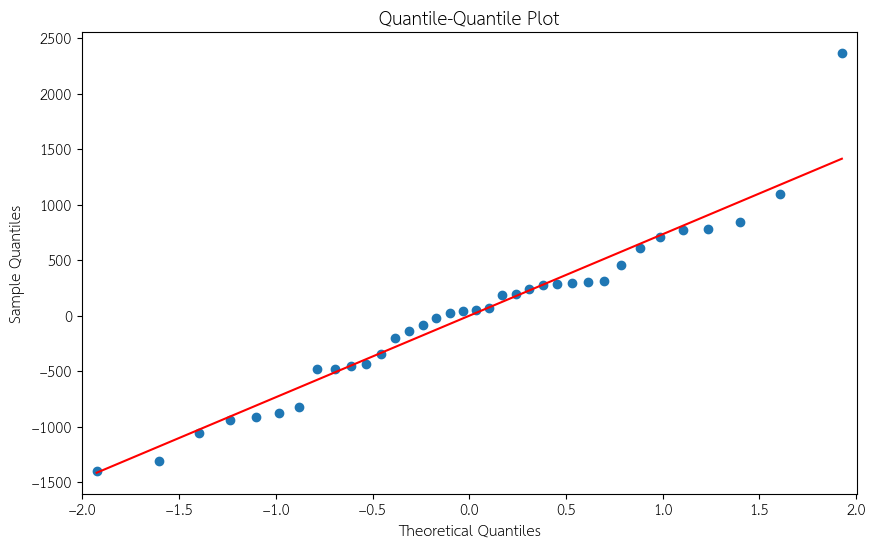

In [103]:
# Quantile-Quantile Plot (Q-Q Plot) for normality
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure', figsize = (10, 6))
qqplot(reg_gj_s.resid, line = 's')
plt.title('Quantile-Quantile Plot')
plt.show()

In [104]:
#Anderson darling for normality
ad = AD(reg_gj_b.resid, dist='norm')[0]
ad_cri= [{i:j for i, j in zip(AD(reg_gj_b.resid, dist='norm')[2], AD(reg_gj_b.resid, dist='norm')[1])}]
ad_cri_005 = AD(reg_gj_b.resid, dist='norm')[1][2:3]
print(f'Anderson-Darling statistic: {ad}')
print(f'Critical value 0.05 : {ad_cri_005}')
print(f'Test statistic < Critical value : {ad < ad_cri_005}')

Anderson-Darling statistic: 0.40866936340641047
Critical value 0.05 : [0.721]
Test statistic < Critical value : [ True]


Actual data vs Predict data (GoldBar_Sale price in Thailnad) Ex

In [105]:
Gold_Factor_data
GB_S

Report Date       Predict
120  2021-01-31  25956.332645
121  2021-02-28  26288.743549
122  2021-03-31  26409.940369
123  2021-04-30  26447.069012
124  2021-05-31  27825.342166
125  2021-06-30  27333.812214
126  2021-07-31  27451.549675
127  2021-08-30  27750.337490
128  2021-09-30  27608.634107
129  2021-10-31  28012.628723
130  2021-11-29  28594.144034
131  2021-12-31  28038.829113
132  2022-01-31  28148.848380
133  2022-02-28  29108.443905
134  2022-03-31  29840.442905
135  2022-04-30  30514.181413
136  2022-05-30  29930.411670
137  2022-06-30  30875.560179
138  2022-07-31  31073.813379
139  2022-08-31  29770.468165
140  2022-09-30  29855.019513
141  2022-10-31  28868.725339
142  2022-11-30  29781.546837
143  2022-12-31  31049.566622
144  2023-01-30  31009.968849
145  2023-02-27  31310.962714
146  2023-03-31  31342.331162
147  2023-04-30  31735.050907
148  2023-05-31  32135.329325
149  2023-06-30  32123.661952
150  2023-07-31  32145.013019
151  2023-08-31  32825.817814
152  2023-09-30  33126.766013
153  2023-10-30  33100.351300
154  2023-11-30  32828.897932
155  2023-12-31  31281.457609

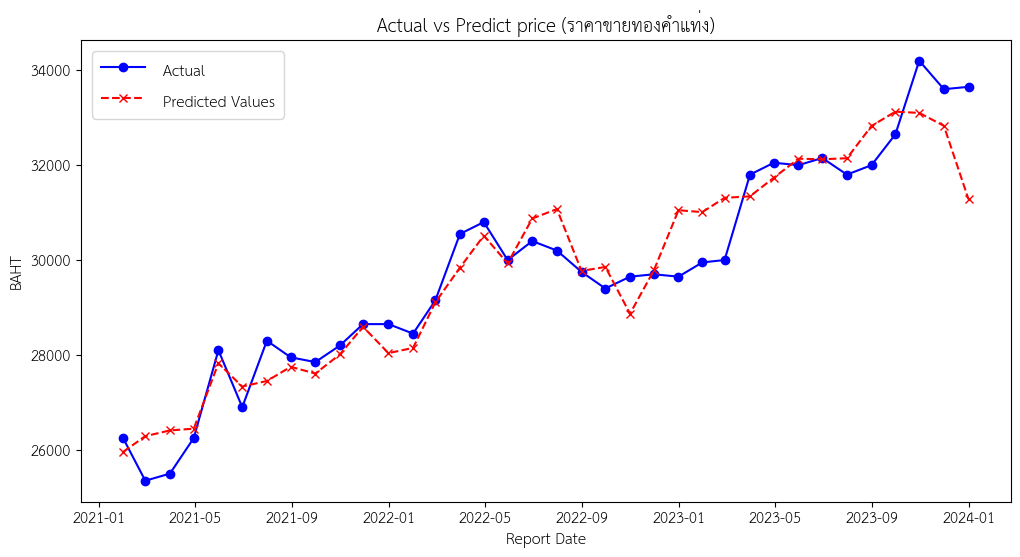

In [106]:
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'],(Gold_Factor_data['GoldBar_Sale']),label='Actual', color='blue',marker='o')
plt.plot(GB_S['Report Date'].iloc[0:],(GB_S['Predict']),label='Predicted Values',
         color='red',linestyle='--',marker='x')
plt.xlabel('Report Date')
plt.ylabel('BAHT')
plt.title('Actual vs Predict price (ราคาขายทองคำแท่ง)')
plt.legend()
plt.show()

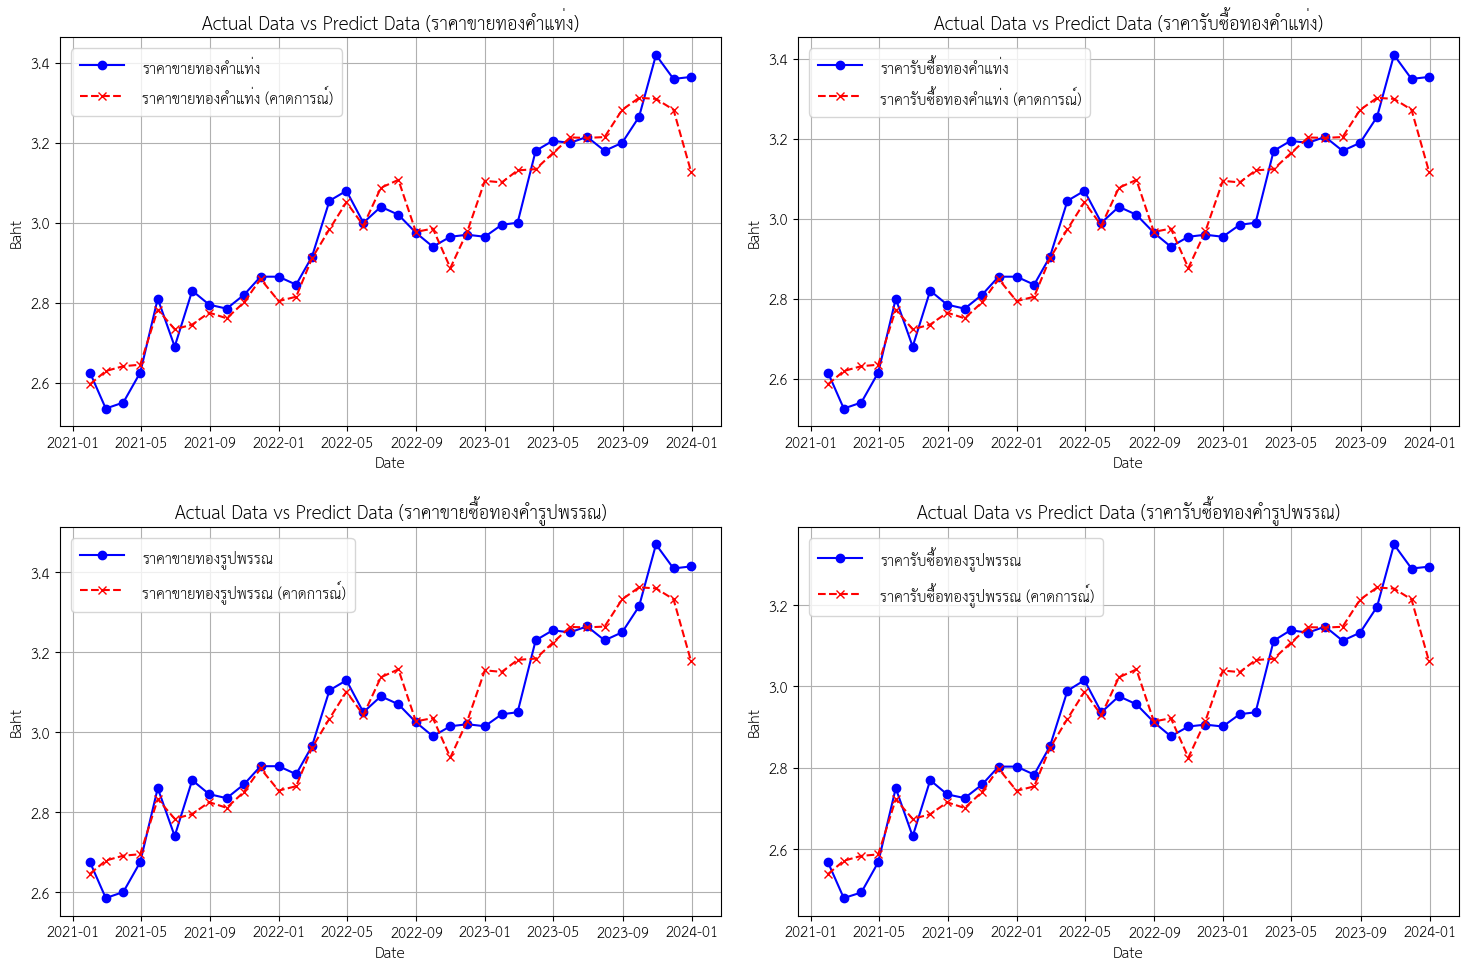

In [107]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # สร้างพื้นที่สำหรับ subplot 3 แถว 2 คอลัมน์
# กราฟที่ 1: ราคาขายทองคำแท่ง
axs[0, 0].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldBar_Sale']/10000, label='ราคาขายทองคำแท่ง',color='blue',marker='o')
axs[0, 0].plot(GB_S['Report Date'], (GB_S['Predict'])/10000, label='ราคาขายทองคำแท่ง (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Baht')
axs[0, 0].set_title('Actual Data vs Predict Data (ราคาขายทองคำแท่ง)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# กราฟที่ 2: ราคารับซื้อทองคำแท่ง
axs[0, 1].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldBar_Buy']/10000, label='ราคารับซื้อทองคำแท่ง',color='blue',marker='o')
axs[0, 1].plot(GB_B['Report Date'], (GB_B['Predict'])/10000, label='ราคารับซื้อทองคำแท่ง (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Baht')
axs[0, 1].set_title('Actual Data vs Predict Data (ราคารับซื้อทองคำแท่ง)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# กราฟที่ 3: ราคาขายทองคำรูปพรรณ
axs[1, 0].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldJew_Sale']/10000, label='ราคาขายทองรูปพรรณ',color='blue',marker='o')
axs[1, 0].plot(GJ_S['Report Date'], (GJ_S['Predict'])/10000, label='ราคาขายทองรูปพรรณ (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Baht')
axs[1, 0].set_title('Actual Data vs Predict Data (ราคาขายซื้อทองคำรูปพรรณ)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# กราฟที่ 4: ราคารับซื้อทองคำรูปพรรณ
axs[1, 1].plot(Gold_Factor_data['Report Date'], Gold_Factor_data['GoldJew_Buy']/10000, label='ราคารับซื้อทองรูปพรรณ',color='blue',marker='o')
axs[1, 1].plot(GJ_B['Report Date'], (GJ_B['Predict'])/10000, label='ราคารับซื้อทองรูปพรรณ (คาดการณ์)', color='red',linestyle='--',marker='x')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Baht')
axs[1, 1].set_title('Actual Data vs Predict Data (ราคารับซื้อทองคำรูปพรรณ)')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [108]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldBar_Sale']),(GB_S['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldBar_Sale']),(GB_S['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldBar_Sale'],(GB_S['Predict']))
print("Model of GoldBar_Sale")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gb_s)
adj_r2 = 1 - ((1 - r2_gb_s) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldBar_Sale
MSE :  538751.641962426
RMSE :  733.997031303551
MAE :  552.1887540353284
MAPE :  0.018389220466333355
R-squared :  0.8917009900493854
Adj-R-squared :  0.8815479578665153


In [109]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldBar_Buy']),(GB_B['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldBar_Buy']),(GB_B['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldBar_Sale'],(GB_B['Predict']))
print("Model of GoldBar_Buy")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gb_b)
adj_r2 = 1 - ((1 - r2_gb_b) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldBar_Buy
MSE :  538751.6419624264
RMSE :  733.9970313035512
MAE :  552.1887540353287
MAPE :  0.018916416942318746
R-squared :  0.8917009900493853
Adj-R-squared :  0.8815479578665152


In [110]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldJew_Sale']),(GJ_S['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldJew_Sale']),(GJ_S['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldJew_Sale'],(GJ_S['Predict']))
print("Model of GoldJew_Sale")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gj_s)
adj_r2 = 1 - ((1 - r2_gj_s) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldJew_Sale
MSE :  538751.641962426
RMSE :  733.997031303551
MAE :  552.1887540353284
MAPE :  0.01808581824214158
R-squared :  0.8917009900493854
Adj-R-squared :  0.8815479578665153


In [111]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error
# Mean Absolute Error (MAE)
MAE = mean_absolute_error((Gold_Factor_data['GoldJew_Buy']),(GJ_B['Predict']))
# Mean Squared Error (MSE)
MSE = mean_squared_error((Gold_Factor_data['GoldJew_Buy']),(GJ_S['Predict']))
# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(MSE)
# Mean Absolute percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(Gold_Factor_data['GoldJew_Buy'],(GJ_S['Predict']))
print("Model of GoldJew_Buy")
print('MSE : ',MSE) # ค่ายิ่งต้ำยิ่งดี
print('RMSE : ',RMSE) # ค่ายิ่งต้ำยิ้งดี
print('MAE : ',MAE) # ค่ายิ่งต้ำยิ่งดี ค่าเฉลี่ย 719
print('MAPE : ',MAPE) # ค่ายิ่งต่ำยิ่งดี
print("R-squared : ", r2_gj_b)
adj_r2 = 1 - ((1 - r2_gj_b) * (36 - 1) / (36 - 3 - 1))
print("Adj-R-squared : ", adj_r2)
# print('MAE : ',mean_absolute_error(GB_S['Predict'],Gold_Factor_data['GoldBar_Sale']))
# MAPE น้อยกว่า 10% จัดว่าพยากรณ์ค่อนข้างแม่นยำ
# MAPE อยู่ระหว่าง 10% - 20% จัดว่าการพยากรณ์ใช้ได้ดี
# MAPE อยู่ระหว่าง 20% - 50% จัดว่าการพยากรณ์ค่อนข้างแม่นยำ
# MAPE มากกว่า 50% จัดว่าการพยากรณ์ไม่แม่นยำ

Model of GoldJew_Buy
MSE :  1806101.341758293
RMSE :  1343.912698711599
MAE :  542.2394211924321
MAPE :  0.04160529206391265
R-squared :  0.8917685164331964
Adj-R-squared :  0.8816218148488086


Version 2 Intercept

In [112]:
# Gold_Factor_data[['LOGIT']+Factor_interested].corr()
Gold_Factor_data[['GoldBar_Sale']+Factor_interested_2].corr()
# ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']

GoldBar_Sale  (Inflation)_LAG_10  \
GoldBar_Sale                               1.000000            0.778418   
(Inflation)_LAG_10                         0.778418            1.000000   
LOG_PTT_แก๊สโซฮอล์_95_LAG_1                0.800495            0.401356   
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2     -0.112283           -0.199085   

                                       LOG_PTT_แก๊สโซฮอล์_95_LAG_1  \
GoldBar_Sale                                              0.800495   
(Inflation)_LAG_10                                        0.401356   
LOG_PTT_แก๊สโซฮอล์_95_LAG_1                               1.000000   
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2                     0.064217   

                                       %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2  
GoldBar_Sale                                                       -0.112283  
(Inflation)_LAG_10                                                 -0.199085  
LOG_PTT_แก๊สโซฮอล์_95_LAG_1                                         0.064217  
%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2                               1.000000

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

a :  1440.3177233220122
b : 28155.1340095895
intercept : [28155.13400959]
R-squared : 0.6059350939059581
MAE :  1128.2440583930086
MAPE :  0.038804728442060274
MSE :  1960342.1609740155
RMSE :  1400.1221950151407


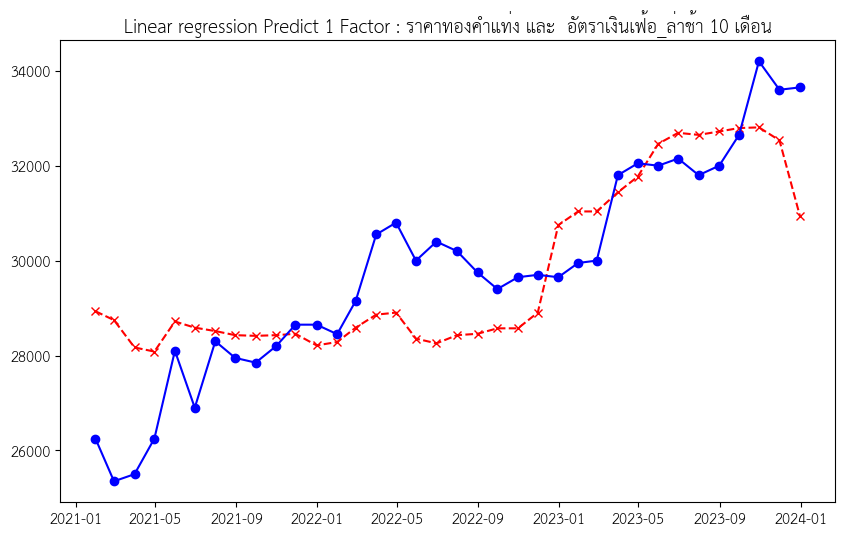

In [242]:
X = Gold_Factor_data[['(Inflation)_LAG_10']]
y = (Gold_Factor_data[['GoldBar_Sale']])
lrm = LinearRegression()
lrm.fit(X,y)
print("a : ",lrm.coef_[0][0]) # a
print("b :",lrm.intercept_[0]) # b
plt.title("Linear regression Predict 1 Factor : ราคาทองคำแท่ง และ  อัตราเงินเฟ้อ_ล่าช้า 10 เดือน")
predictions = lrm.predict(X)
print("intercept :",lrm.intercept_)
print("R-squared :",lrm.score(X,y))
# n , p = X.shape
# adj_r2_linear = 1 - ( ((1 - model_linear.score(X,y))*(n - 1)) / (n - p - 1) )
# print("Adj-R-squared : ",adj_r2_linear)
print("MAE : ",(metrics.mean_absolute_error((y),(predictions))))
print("MAPE : ",metrics.mean_absolute_percentage_error((y),(predictions)))
print("MSE : ",metrics.mean_squared_error((y),(predictions)))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error((y),(predictions))))

# plt.scatter(X,y,color='black')
plt.plot(Gold_Factor_data[['Report Date']],(predictions), color='red',linestyle='--',marker='x')
plt.plot(Gold_Factor_data[['Report Date']],(y), color='blue' , marker='o')


In [115]:
Y_formula = pd.DataFrame({
    'coefficient':[lrm.coef_[0][0]],
    'intercept':[lrm.intercept_[0]]
})
Y_formula

coefficient    intercept
0  1440.317723  28155.13401

Text(0.5, 1.0, 'Intercept of y and y_pred :  ราคาทองคำแท่ง และ  อัตราเงินเฟ้อ_ล่าช้า 10 เดือน')

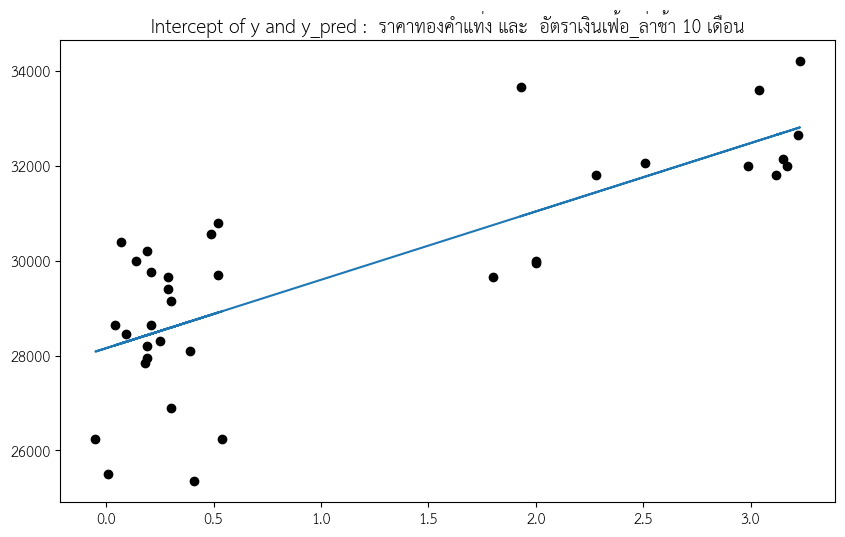

In [116]:
plt.scatter(X,y,color='black')
plt.plot(X,predictions)
plt.title('Intercept of y and y_pred :  ราคาทองคำแท่ง และ  อัตราเงินเฟ้อ_ล่าช้า 10 เดือน')

In [117]:
Ex1 = pd.DataFrame({
    "Performance of model" : ['R-squared','MAE','MAPE','MSE','RMSE'],
    "Value" : [lrm.score(X,y),metrics.mean_absolute_error((y),(predictions)),
              metrics.mean_absolute_percentage_error((y),(predictions)),
              metrics.mean_squared_error((y),(predictions)),
              np.sqrt(metrics.mean_squared_error((y),(predictions)))]
})
Ex1['Value'] = Ex1['Value'].apply(lambda x: f"{x:.6f}")
Ex1

Performance of model           Value
0            R-squared        0.605935
1                  MAE     1128.244058
2                 MAPE        0.038805
3                  MSE  1960342.160974
4                 RMSE     1400.122195

a :  11387.694953053053
b : -10297.681172416414
intercept : [-10297.68117242]
R-squared : 0.6407915018700479
MAE :  1065.1466804996483
MAPE :  0.03485986850365887
MSE :  1786943.0963645705
RMSE :  1336.7659093366237


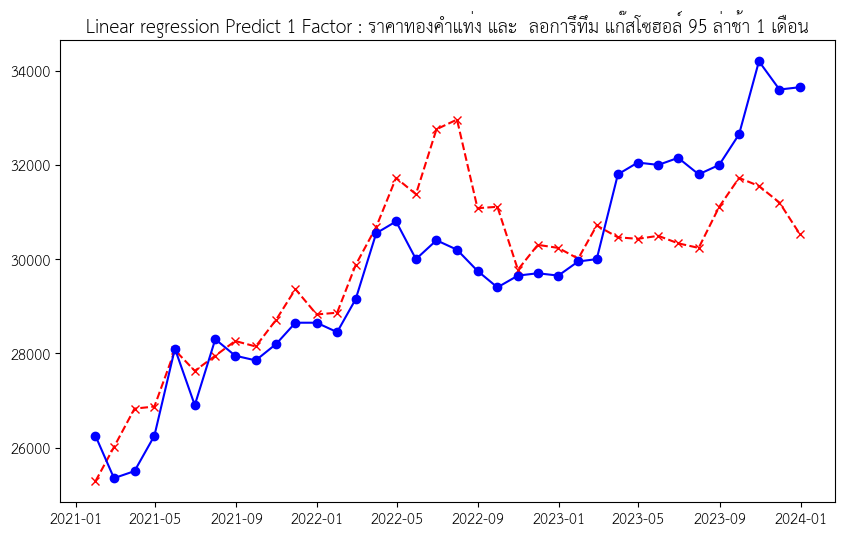

In [119]:
X = Gold_Factor_data[['LOG_PTT_แก๊สโซฮอล์_95_LAG_1']]
y = (Gold_Factor_data[['GoldBar_Sale']])
lrm = LinearRegression()
lrm.fit(X,y)
print("a : ",lrm.coef_[0][0]) # a
print("b :",lrm.intercept_[0]) # b
plt.title("Linear regression Predict 1 Factor : ราคาทองคำแท่ง และ  ลอการึทึม แก๊สโซฮอล์ 95 ล่าช้า 1 เดือน")
predictions = lrm.predict(X)
print("intercept :",lrm.intercept_)
print("R-squared :",lrm.score(X,y))
# n , p = X.shape
# adj_r2_linear = 1 - ( ((1 - model_linear.score(X,y))*(n - 1)) / (n - p - 1) )
# print("Adj-R-squared : ",adj_r2_linear)
print("MAE : ",(metrics.mean_absolute_error((y),(predictions))))
print("MAPE : ",metrics.mean_absolute_percentage_error((y),(predictions)))
print("MSE : ",metrics.mean_squared_error((y),(predictions)))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error((y),(predictions))))

# plt.scatter(X,y,color='black')
plt.plot(Gold_Factor_data[['Report Date']],(predictions), color='red',linestyle='--',marker='x')
plt.plot(Gold_Factor_data[['Report Date']],(y), color='blue',marker='o')


In [120]:
Y_formula = pd.DataFrame({
    'coefficient':[lrm.coef_[0][0]],
    'intercept':[lrm.intercept_[0]]
})
Y_formula

coefficient     intercept
0  11387.694953 -10297.681172

Text(0.5, 1.0, 'Intercept of y and y_pred')

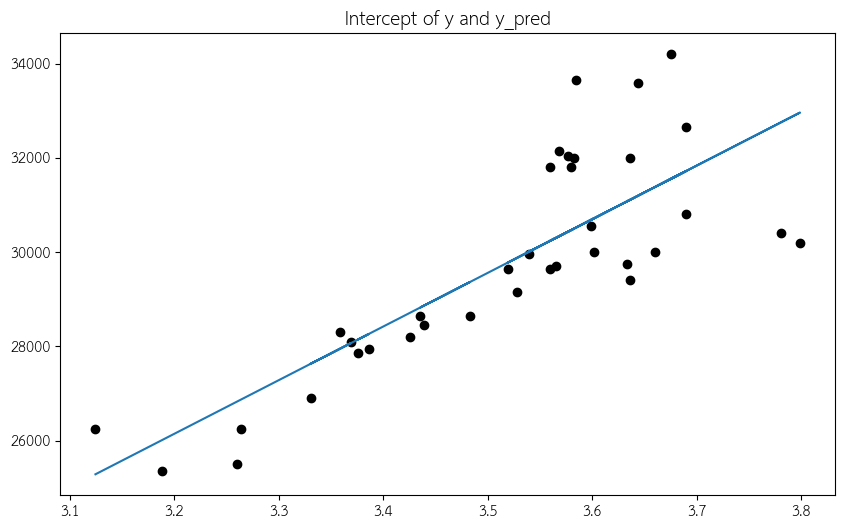

In [121]:
plt.scatter(X,y,color='black')
plt.plot(X,predictions)
plt.title('Intercept of y and y_pred')

In [122]:
Ex1 = pd.DataFrame({
    "Performance of model" : ['R-squared','MAE','MAPE','MSE','RMSE'],
    "Value" : [lrm.score(X,y),metrics.mean_absolute_error((y),(predictions)),
              metrics.mean_absolute_percentage_error((y),(predictions)),
              metrics.mean_squared_error((y),(predictions)),
              np.sqrt(metrics.mean_squared_error((y),(predictions)))]
})
Ex1['Value'] = Ex1['Value'].apply(lambda x: f"{x:.6f}")
Ex1

Performance of model           Value
0            R-squared        0.640792
1                  MAE     1065.146680
2                 MAPE        0.034860
3                  MSE  1786943.096365
4                 RMSE     1336.765909

a :  -6762.731668448389
b : 29822.860325155525
intercept : [29822.86032516]
R-squared : 0.012607425134235961
MAE :  1810.3708648681272
MAPE :  0.061420626274497486
MSE :  4911950.452852861
RMSE :  2216.292050442103


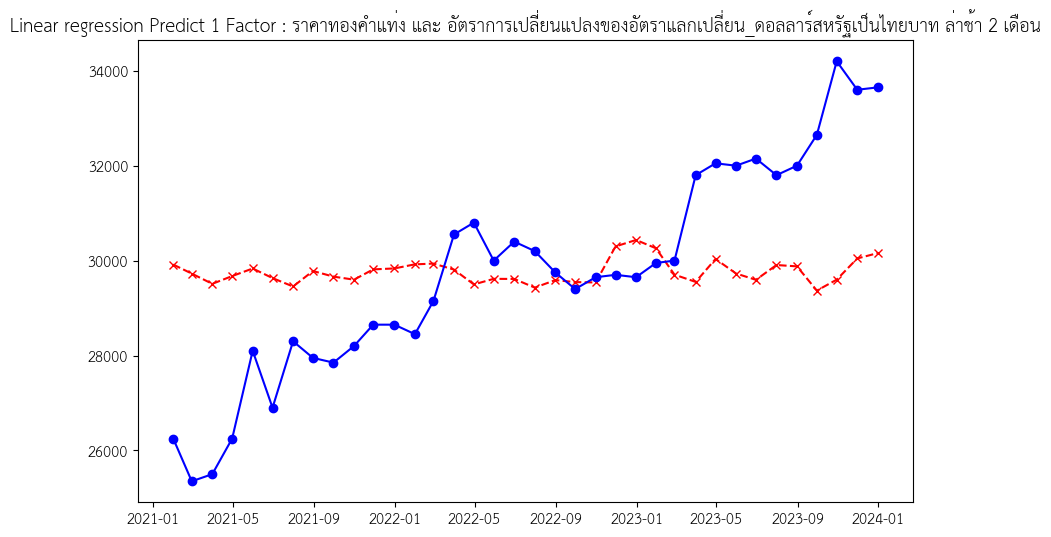

In [123]:
X = Gold_Factor_data[['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']]
y = (Gold_Factor_data[['GoldBar_Sale']])
lrm = LinearRegression()
lrm.fit(X,y)
print("a : ",lrm.coef_[0][0]) # a
print("b :",lrm.intercept_[0]) # b
plt.title("Linear regression Predict 1 Factor : ราคาทองคำแท่ง และ อัตราการเปลี่ยนแปลงของอัตราแลกเปลี่ยน_ดอลลาร์สหรัฐเป็นไทยบาท ล่าช้า 2 เดือน")
predictions = lrm.predict(X)
print("intercept :",lrm.intercept_)
print("R-squared :",lrm.score(X,y))
# n , p = X.shape
# adj_r2_linear = 1 - ( ((1 - model_linear.score(X,y))*(n - 1)) / (n - p - 1) )
# print("Adj-R-squared : ",adj_r2_linear)
print("MAE : ",(metrics.mean_absolute_error((y),(predictions))))
print("MAPE : ",metrics.mean_absolute_percentage_error((y),(predictions)))
print("MSE : ",metrics.mean_squared_error((y),(predictions)))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error((y),(predictions))))

# plt.scatter(X,y,color='black')
plt.plot(Gold_Factor_data[['Report Date']],(predictions), color='red',linestyle='--',marker='x')
plt.plot(Gold_Factor_data[['Report Date']],(y), color='blue',marker='o')


Text(0.5, 1.0, 'Intercept of y and y_pred : ราคาทองคำแท่ง และ อัตราการเปลี่ยนแปลงของอัตราแลกเปลี่ยน_ดอลลาร์สหรัฐเป็นไทยบาท ล่าช้า 2 เดือน')

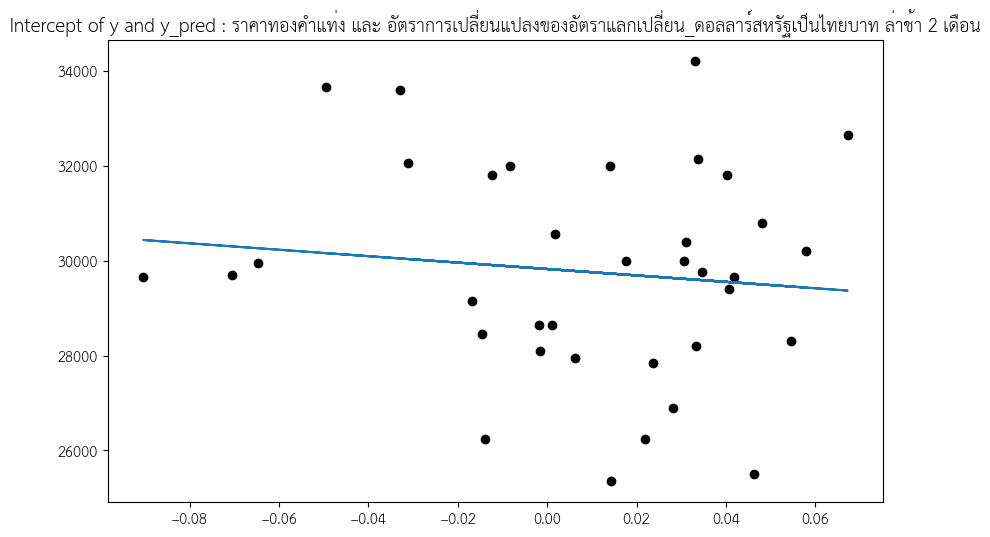

In [124]:
plt.scatter(X,y,color='black')
plt.plot(X,predictions)
plt.title('Intercept of y and y_pred : ราคาทองคำแท่ง และ อัตราการเปลี่ยนแปลงของอัตราแลกเปลี่ยน_ดอลลาร์สหรัฐเป็นไทยบาท ล่าช้า 2 เดือน')

In [125]:
Y_formula = pd.DataFrame({
    'coefficient':[lrm.coef_[0][0]],
    'intercept':[lrm.intercept_[0]]
})
Y_formula

coefficient     intercept
0 -6762.731668  29822.860325

In [126]:
Ex1 = pd.DataFrame({
    "Performance of model" : ['R-squared','MAE','MAPE','MSE','RMSE'],
    "Value" : [lrm.score(X,y),metrics.mean_absolute_error((y),(predictions)),
              metrics.mean_absolute_percentage_error((y),(predictions)),
              metrics.mean_squared_error((y),(predictions)),
              np.sqrt(metrics.mean_squared_error((y),(predictions)))]
})
Ex1['Value'] = Ex1['Value'].apply(lambda x: f"{x:.6f}")
Ex1

Performance of model           Value
0            R-squared        0.012607
1                  MAE     1810.370865
2                 MAPE        0.061421
3                  MSE  4911950.452853
4                 RMSE     2216.292050

In [127]:
# MEAN : 10.040206
# MAE : 0.09521426489602582 ค่าต่ำ แสดงถึง โมเดลคาดการณ์ได้ดี
# MSE : 0.014789767007600822 ค่าต่ำแสดงถึง โมเดลคาดการณ์ได้ดี
# RMSE : 0.12161318599395718 # ค่าต่ำแสดงถึง ค่าความคลาดเคลื่อนจากค่าจริง
# R-Squared : 0.532340099507458 # โมเดลสามารถอธิบายความแปรผันของตัวแปรตามได้ประมาณ 53.23%
# ซึ่งแสดงให้เห็นว่ามีความสัมพันธ์ระหว่างตัวแปรต้นและตัวแปรตาม แต่ยังไม่สูงมากนัก อาจมีปัจจัยอื่นที่ยังไม่ได้ถูกพิจารณา.
# metrics.mean_absolute_error(y,predictions)
# metrics.mean_squared_error(y,predictions)
# np.sqrt(metrics.mean_squared_error(y,predictions))

# OLS Regression Model (Testing)

In [128]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [129]:
X = Gold_Factor_data[Factor_interested]
y = (Gold_Factor_data[['GoldBar_Sale']])

In [131]:
model = sm.OLS(y,X)

In [132]:
# model.params # ceof
result = model.fit()
result.params

(Inflation)_LAG_10             1030.640318
LOG_PTT_แก๊สโซฮอล์_95_LAG_1    8120.782244
%CHANGE_XAU_USD_LAG_1          3862.946046
dtype: float64

In [133]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           GoldBar_Sale   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.938e+04
Date:                Sat, 10 Aug 2024   Prob (F-statistic):                    1.28e-53
Time:                        15:01:02   Log-Likelihood:                         -287.47
No. Observations:                  36   AIC:                                      580.9
Df Residuals:                      33   BIC:                                      585.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
(Inflation)_LAG_10           1030.6403    104.751      9.839      0.000     817.523    1243.758
LOG_PTT_แก๊สโซฮอล์_95_LAG_1  8120.7822     49.831    162.967      0.000    8019.401    8222.164
%CHANGE_XAU_USD_LAG_1        3862.9460   2309.546      1.673      0.104    -835.862    8561.754
==============================================================================
Omnibus:                        2.440   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                1.404
Skew:                           0.441   Prob(JB):                        0.496
Kurtosis:                       3.399   Cond. No.                         69.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# LOAD DATA IF YOU HAVE.

In [4]:
Gold_Factor_data = pd.read_excel('LAG_RESULT.xlsx',index_col=None)
All_result_table_GB_S = pd.read_excel('CheckStats.xlsx',index_col=None)
output3_base = pd.read_excel('ARIMA_PT_2024.xlsx',index_col=None)

In [5]:
Gold_Factor_data

Unnamed: 0 Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  \
0          120  2021-01-31         26250        26150         26750   
1          121  2021-02-28         25350        25250         25850   
2          122  2021-03-31         25500        25400         26000   
3          123  2021-04-30         26250        26150         26750   
4          124  2021-05-31         28100        28000         28600   
5          125  2021-06-30         26900        26800         27400   
6          126  2021-07-31         28300        28200         28800   
7          127  2021-08-30         27950        27850         28450   
8          128  2021-09-30         27850        27750         28350   
9          129  2021-10-31         28200        28100         28700   
10         130  2021-11-29         28650        28550         29150   
11         131  2021-12-31         28650        28550         29150   
12         132  2022-01-31         28450        28350         28950   
13         133  2022-02-28         29150        29050         29650   
14         134  2022-03-31         30550        30450         31050   
15         135  2022-04-30         30800        30700         31300   
16         136  2022-05-30         30000        29900         30500   
17         137  2022-06-30         30400        30300         30900   
18         138  2022-07-31         30200        30100         30700   
19         139  2022-08-31         29750        29650         30250   
20         140  2022-09-30         29400        29300         29900   
21         141  2022-10-31         29650        29550         30150   
22         142  2022-11-30         29700        29600         30200   
23         143  2022-12-31         29650        29550         30150   
24         144  2023-01-30         29950        29850         30450   
25         145  2023-02-27         30000        29900         30500   
26         146  2023-03-31         31800        31700         32300   
27         147  2023-04-30         32050        31950         32550   
28         148  2023-05-31         32000        31900         32500   
29         149  2023-06-30         32150        32050         32650   
30         150  2023-07-31         31800        31700         32300   
31         151  2023-08-31         32000        31900         32500   
32         152  2023-09-30         32650        32550         33150   
33         153  2023-10-30         34200        34100         34700   
34         154  2023-11-30         33600        33500         34100   
35         155  2023-12-31         33650        33550         34150   

    GoldJew_Buy  Inflation  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
0      25681.04       0.21              24.25              23.98      25.09   
1      24801.76       0.04              26.05              25.78      26.99   
2      24938.20       0.09              26.15              25.88      23.19   
3      25681.04       0.30              29.05              28.78      25.99   
4      27500.24       0.49              27.95              27.68      25.09   
5      26317.76       0.52              28.75              28.48      25.79   
6      27697.32       0.14              29.55              29.28      26.09   
7      27348.64       0.07              29.25              28.98      25.79   
8      27257.68       0.19              30.75              30.48      27.69   
9      27591.20       0.21              32.55              32.28      29.69   
10     28030.84       0.29              31.05              30.78      28.84   
11     28030.84       0.29              31.15              30.88      28.44   
12     27833.76       0.52              34.05              33.78      29.94   
13     28531.12       1.80              36.55              36.28      29.14   
14     29895.52       2.00              40.05              39.78      29.94   
15     30153.24       2.00              38.85              38.58      29.94   
16     29364.92       2.28       

In [6]:
len(All_result_table_GB_S)

43368

In [7]:
All_result_table_GB_S.head(10)

FACTOR_1                       FACTOR_2  \
0             Inflation_LAG_10    LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
1             Inflation_LAG_10    LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
2             Inflation_LAG_10    LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
3             Inflation_LAG_10     LOG_น้ำมัน_brent_USD_LAG_2   
4             Inflation_LAG_10  %CHANGE_Nasdaq_100_USD_LAG_10   
5  LOG_PTT_แก๊สโซฮอล์_95_LAG_1    LOG_น้ำมัน_brent_USD_LAG_10   
6             Inflation_LAG_10    LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
7             Inflation_LAG_10    LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
8             Inflation_LAG_10    LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
9             Inflation_LAG_10    LOG_PTT_แก๊สโซฮอล์_95_LAG_1   

                                            FACTOR_3         const  \
0                        LOG_PTT_แก๊สโซฮอล์_91_LAG_1  -2527.575779   
1                      %CHANGE_Nasdaq_100_USD_LAG_10  -8647.993711   
2              %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1  -1103.790692   
3                      %CHANGE_Nasdaq_100_USD_LAG_10  -7300.857605   
4  LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_...  -5015.697129   
5                      %CHANGE_Nasdaq_100_USD_LAG_10 -16602.818200   
6                       %CHANGE_Nasdaq_100_USD_LAG_9  -7039.252735   
7             %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1  -1378.072525   
8                             %CHANGE_Core_CPI_LAG_5   8957.853596   
9                             %CHANGE_Core_CPI_LAG_5   8957.853596   

            x1            x2            x3  intercept_p_value  \
0   973.101288  69511.943141 -60803.217741           0.345022   
1   816.852158  10593.548050   1812.781690           0.059737   
2   973.926618   8476.414629  -9637.672190           0.710606   
3  1235.218744   8033.014870   2657.912710           0.106951   
4  1255.937577   2096.997138   7626.300837           0.235445   
5  9370.904782   3034.028622   4842.247023           0.000148   
6   819.688996  10150.134933   1685.340178           0.133961   
7   953.956951   8557.455895  11040.446215           0.653063   
8  1151.100291   5516.600467  40436.458212           0.150603   
9  1151.100291   5516.600467  40436.458212           0.150603   

   FACTOR_1_p_value  FACTOR_2_p_value  ...    adj_r2  Probability of F-Stats  \
0      2.359252e-11      8.636942e-05  ...  0.919200            3.510000e-18   
1      8.416404e-07      1.464831e-09  ...  0.898441            1.350000e-16   
2      5.270873e-10      2.551697e-11  ...  0.895897            2.000000e-16   
3      1.448191e-12      2.868676e-09  ...  0.894143            2.610000e-16   
4      8.697138e-13      1.272420e-02  ...  0.893186            3.010000e-16   
5      3.458814e-07      2.086975e-06  ...  0.892662            3.260000e-16   
6      5.206091e-06      8.211046e-09  ...  0.891711            3.750000e-16   
7      2.255943e-09      4.271025e-11  ...  0.891367            3.940000e-16   
8      1.691044e-09      3.903862e-03  ...  0.890478            4.490000e-16   
9      1.691044e-09      3.903862e-03  ...  0.890478            4.490000e-16   

         AD                                        AD_criteria  \
0  0.421966  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
1  0.406640  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
2  0.305633  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
3  0.482313  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
4  0.435102  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
5  0.394891  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
6  0.388073  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
7  0.332911  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
8  0.682826  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   
9  0.682826  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....   

   AD_criteria_0.05 BP_pvalues  Durbin_Watson  VIF_Factor_1   VIF_Factor_2  \
0             0.721   0.437860       1.408084      1.920159  243280.714256   
1             0.721   0.358309       1.238263      2.00

In [8]:
all_stats_results_GB_S =  All_result_table_GB_S.drop_duplicates(keep=False)
len(All_result_table_GB_S)

43368

In [9]:
All_result_table_GB_S.to_excel('CheckStats_NoDup.xlsx')

In [19]:
Pass_Stat_list_GB_S = all_stats_results_GB_S[all_stats_results_GB_S['r2'] >= 0.3]
Pass_Stat_list_GB_S = all_stats_results_GB_S[all_stats_results_GB_S['adj_r2'] >= 0.3]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['Probability of F-Stats'] <= 0.5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['AD'] < Pass_Stat_list_GB_S['AD_criteria_0.05']]
# Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['AD'] < 0.528]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['BP_pvalues'] > 0.05]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['Durbin_Watson'] >= 1]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_1'] <= 5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_2'] <= 5]
Pass_Stat_list_GB_S = Pass_Stat_list_GB_S[Pass_Stat_list_GB_S['VIF_Factor_3'] <= 5]
Pass_Stat_list_GB_S

FACTOR_1  \
1                  Inflation_LAG_10   
3                  Inflation_LAG_10   
4                  Inflation_LAG_10   
6                  Inflation_LAG_10   
12                 Inflation_LAG_10   
...                             ...   
19543                     Inflation   
20546  %CHANGE_Nasdaq_100_USD_LAG_8   
20576                     Inflation   
20752         %CHANGE_XAU_USD_LAG_1   
20872  %CHANGE_Nasdaq_100_USD_LAG_8   

                                              FACTOR_2  \
1                          LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
3                           LOG_น้ำมัน_brent_USD_LAG_2   
4                        %CHANGE_Nasdaq_100_USD_LAG_10   
6                          LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
12                         LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
...                                                ...   
19543                     %CHANGE_Nasdaq_100_USD_LAG_5   
20546           %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3   
20576           %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3   
20752                     %CHANGE_Nasdaq_100_USD_LAG_8   
20872  %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9   

                                                FACTOR_3         const  \
1                          %CHANGE_Nasdaq_100_USD_LAG_10  -8647.993711   
3                          %CHANGE_Nasdaq_100_USD_LAG_10  -7300.857605   
4      LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_...  -5015.697129   
6                           %CHANGE_Nasdaq_100_USD_LAG_9  -7039.252735   
12       %CHANGE_Down_Jones_Industrial_Average_USD_LAG_1  -1544.126772   
...                                                  ...           ...   
19543   %CHANGE_Down_Jones_Industrial_Average_USD_LAG_10  31707.447805   
20546    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9  30403.135852   
20576   %CHANGE_Down_Jones_Industrial_Average_USD_LAG_10  33424.129191   
20752    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9  30234.022015   
20872           LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1  28136.056767   

                x1            x2            x3  intercept_p_value  \
1       816.852158  10593.548050   1812.781690       5.973745e-02   
3      1235.218744   8033.014870   2657.912710       1.069511e-01   
4      1255.937577   2096.997138   7626.300837       2.354452e-01   
6       819.688996  10150.134933   1685.340178       1.339609e-01   
12      990.498853   8576.014636   4544.746155       6.202007e-01   
...            ...           ...           ...                ...   
19543  -636.189842   7500.461279 -17053.259196       3.767283e-27   
20546  7380.496469   8084.902014 -17821.684422       9.704942e-40   
20576 -1451.105204  20509.663982 -18555.377185       3.120661e-26   
20752  4592.734292   7674.111075 -17360.942274       7.751892e-40   
20872  8376.192821 -17264.167928   1439.410393       5.674544e-11   

       FACTOR_1_p_value  FACTOR_2_p_value  ...    adj_r2  \
1          8.416404e-07      1.464831e-09  ...  0.898441   
3          1.448191e-12      2.868676e-09  ...  0.894143   
4          8.697138e-13      1.272420e-02  ...  0.893186   
6          5.206091e-06      8.211046e-09  ...  0.891711   
12         6.164297e-10      5.503484e-11  ...  0.889649   
...                 ...               ...  ...       ...   
19543      1.684947e-01      8.995650e-03  ...  0.443342   
20546      1.594312e-03      3.139264e-01  ...  0.415279   
20576      5.642259e-03      2.205791e-02  ...  0.414681   
20752      4.021303e-01      1.094587e-03  ...  0.409457   
20872      1.281578e-03      1.772939e-05  ...  0.406459   

       Probability of F-Stats        AD  \
1                1.350000e-16  0.406640   
3                2.610000e-16  0.482313   
4                3.010000e-16  0.435102   
6                3.750000e-16  0.388073   
12               5.060000e-16  0.545195   
...                       ...       ...   
19543            6.750000e-05  0.417296   
20546            1.450000e-04  0.350866   
20576            1.470000e-04  0.35

In [11]:
Pass_Stat_list_GB_S.to_excel('Pass_Stats_NoDup.xlsx')

In [13]:
# Factor_ARIMA

# Plot Graph

       ! Gold_data -> File


<Axes: >

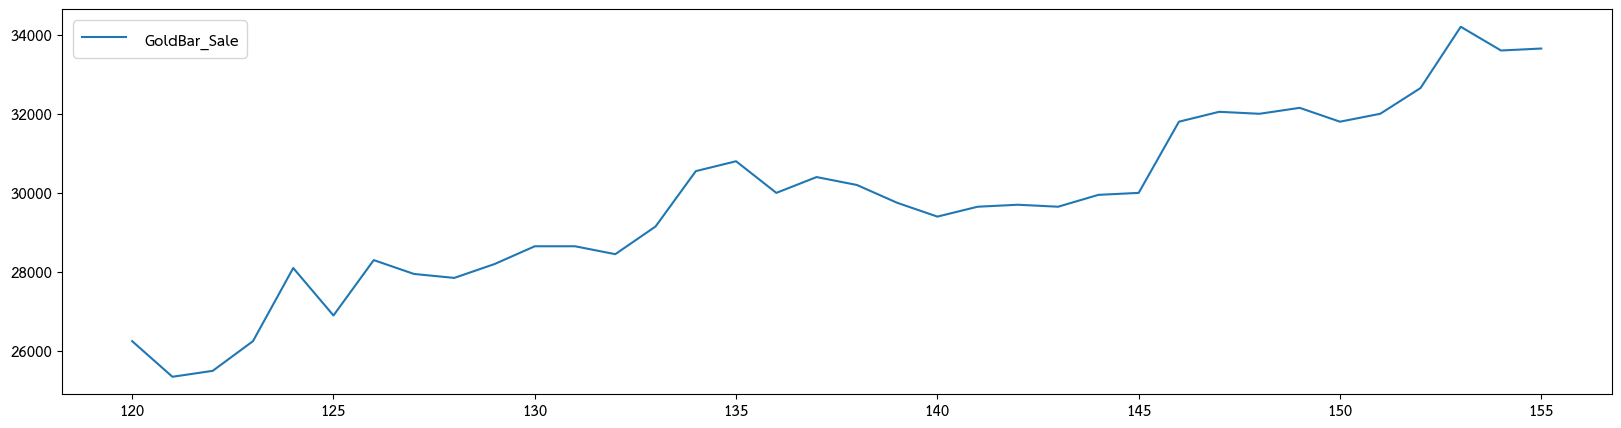

In [134]:
(Gold_Factor_data['GoldBar_Sale']).plot(figsize = (20,5) , legend = True)

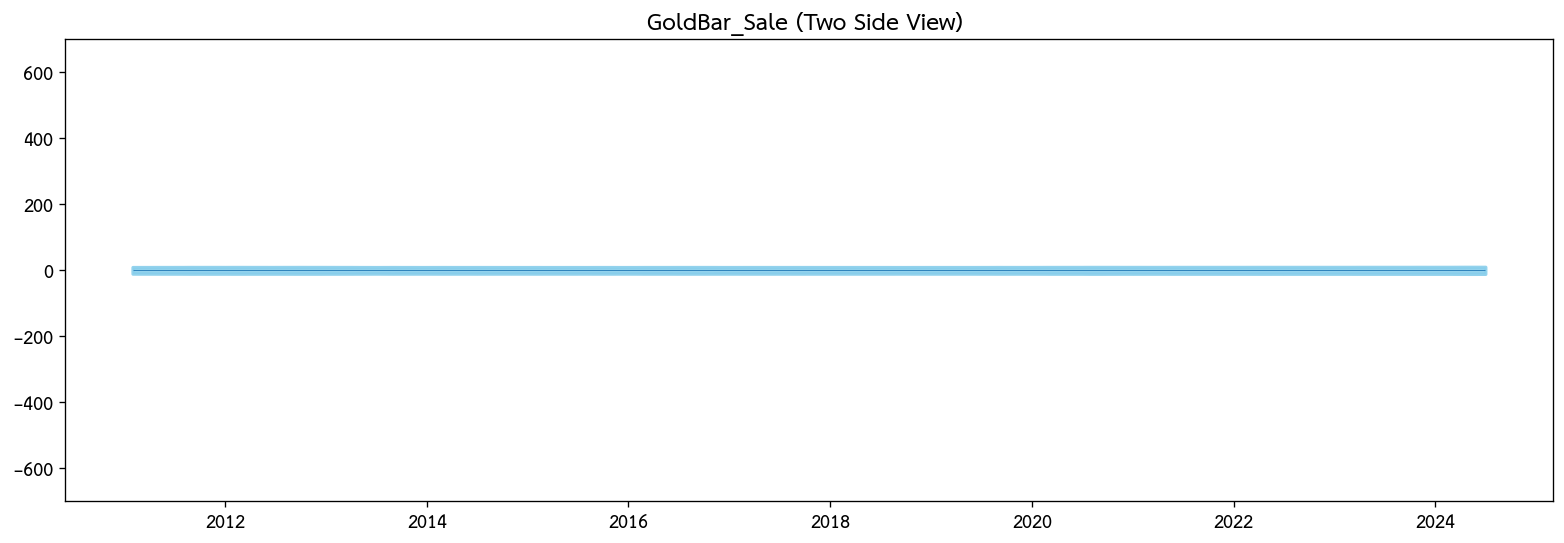

In [135]:
#Plot Two Side View
fig , ax = plt.subplots(1,1,figsize=(16,5) , dpi=120)
x = Gold_data['Report Date'].values

y1 = np.log(Gold_data['GoldBar_Sale'].values)

plt.fill_between( x , y1 = y1 , y2 = -y1 , alpha=0.9 , linewidth=2, color='skyblue')

plt.ylim(-700 , 700 )
plt.title('GoldBar_Sale (Two Side View) ' , fontsize = 20)

plt.hlines( y=0 , xmin = np.min(Gold_data['Report Date']) , xmax = np.max(Gold_data['Report Date']) , linewidth=0.5)

plt.show()

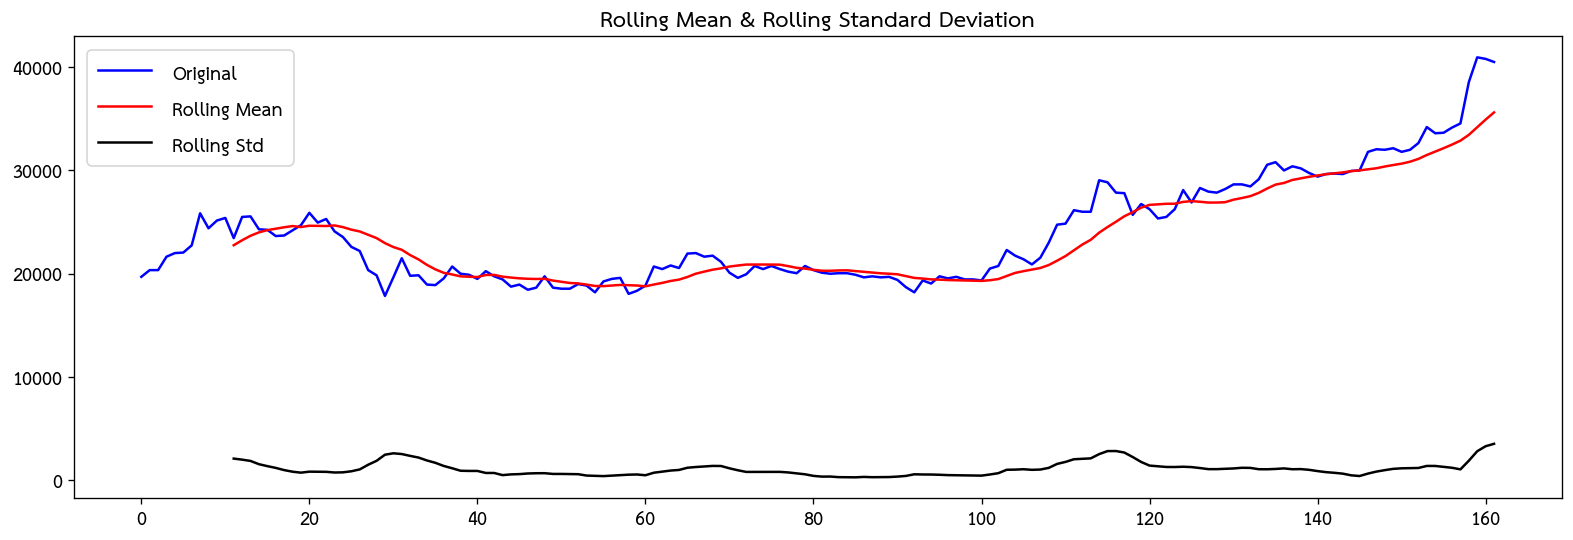

In [136]:
#ทดสอบ Stationary
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window = 12).mean()
rolling_std = Gold_data['GoldBar_Sale'].rolling(window = 12).std()
fig , ax = plt.subplots(1,1,figsize=(16,5),dpi = 120)
plt.plot(Gold_data['GoldBar_Sale'],color = 'blue',label = 'Original')
plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [137]:
result = adfuller(Gold_data['GoldBar_Sale'])
print('ADF Statistic : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical Values:')
for key , value in result[4].items():
    print('\t{}: {}'.format(key,value))

ADF Statistic : 1.0367790804921992
p-value : 0.9946392439439049
Critical Values:
	1%: -3.471633386932248
	5%: -2.8796651107461972
	10%: -2.576433647235832


In [138]:
# function
def get_stationarity(timeseries):
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    original = plt.plot(timeseries, color = 'blue' , label ='Original')
    mean = plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
    std = plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block =False)
    # Dickey-Fuller Test
    result = adfuller(timeseries)
    print('ADF Statiestic: {} '.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key , value in result[4].items():
        print('\t{} : {}'.format(key,value))

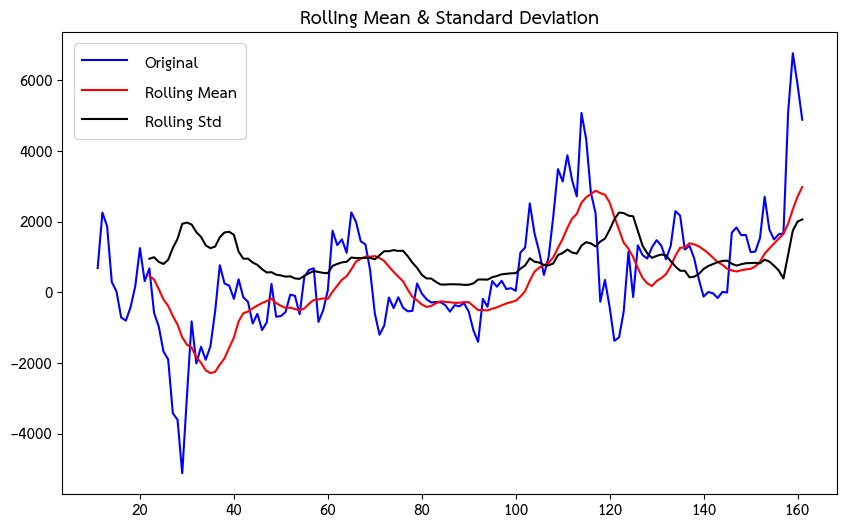

ADF Statiestic: -2.633766219917128 
p-value: 0.08621733626726902
Critical Values:
	1% : -3.474714913481481
	5% : -2.881008708148148
	10% : -2.5771508444444446


In [139]:
# วิธีแรกในการปรับข้อมูลให้เรียบคือ การลบด้วยค่าเฉลี่ยเคลื่อนที่ 12 เดือนย้อนหลังออกไป เพื่อกำจัด ฤดูกาลกับแนวโน้ม
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window=12).mean()
df_log_minus_mean = Gold_data['GoldBar_Sale'] - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

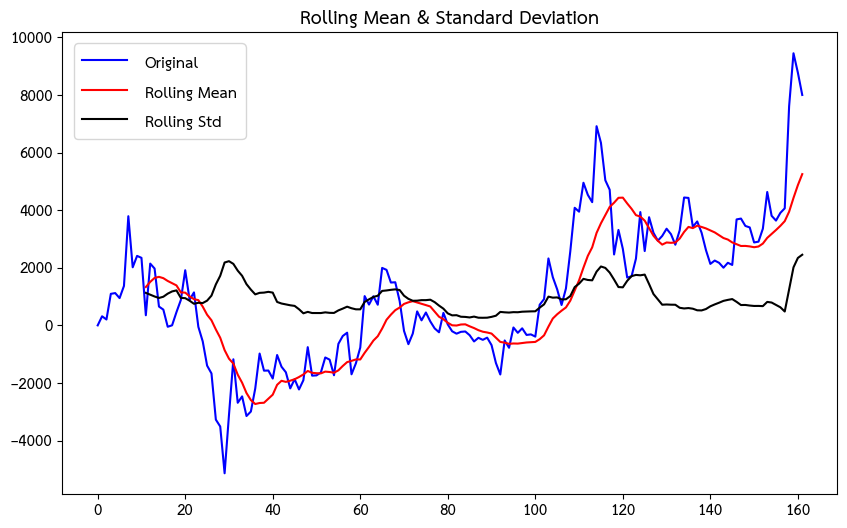

ADF Statiestic: -1.3958182264872252 
p-value: 0.5842792631850188
Critical Values:
	1% : -3.471633386932248
	5% : -2.8796651107461972
	10% : -2.576433647235832


In [140]:
# p value ต่ำแล้ว ลองวิธี take log
rolling_mean_exp_decay = Gold_data['GoldBar_Sale'].ewm(halflife=12,min_periods=0,adjust=True).mean()

df_log_exp_decay = Gold_data['GoldBar_Sale'] - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace = True)
get_stationarity(df_log_exp_decay)

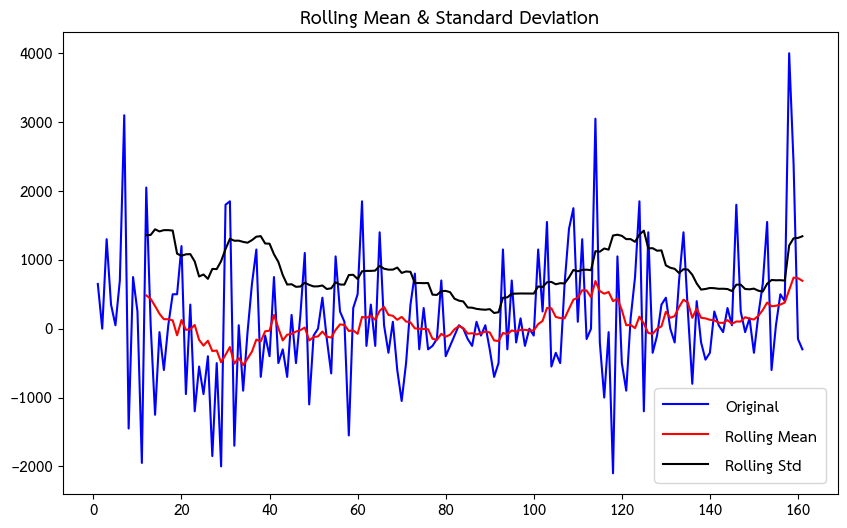

ADF Statiestic: -12.777265428018469 
p-value: 7.546723495653425e-24
Critical Values:
	1% : -3.4718957209472654
	5% : -2.8797795410156253
	10% : -2.5764947265625


In [141]:
# วิธีลบด้วยค่าก่อนหน้า
df_log_shift = Gold_data['GoldBar_Sale'] - Gold_data['GoldBar_Sale'].shift()
df_log_shift.dropna(inplace = True)
get_stationarity(df_log_shift)

# สร้าง ARIMA Model

In [128]:
# import libaries
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import joblib
import os

In [129]:
# 1,1,2 ARIMA Model
model = pm.ARIMA(order=(1,1,2),seasonal=False)
model_fit = model.fit(Gold_Factor_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregress

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -277.333
Date:                Wed, 14 Aug 2024   AIC                            564.665
Time:                        08:06:17   BIC                            572.442
Sample:                             0   HQIC                           567.350
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    281.4693   1682.581      0.167      0.867   -3016.329    3579.267
ar.L1         -0.1253      6.769     -0.019      0.985     -13.392      13.141
ma.L1         -0.0380      6.776     -0.006      0.9

In [130]:
# 1,1,1 ARIMA Model
model = pm.ARIMA(order=(1,1,1),seasonal=False)
model_fit = model.fit(Gold_Factor_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -277.351
Date:                Wed, 14 Aug 2024   AIC                            562.703
Time:                        08:06:17   BIC                            568.924
Sample:                             0   HQIC                           564.850
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    239.7733    237.081      1.011      0.312    -224.898     704.444
ar.L1          0.0437      0.980      0.045      0.964      -1.878       1.965
ma.L1         -0.2080      0.994     -0.209      0.8

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


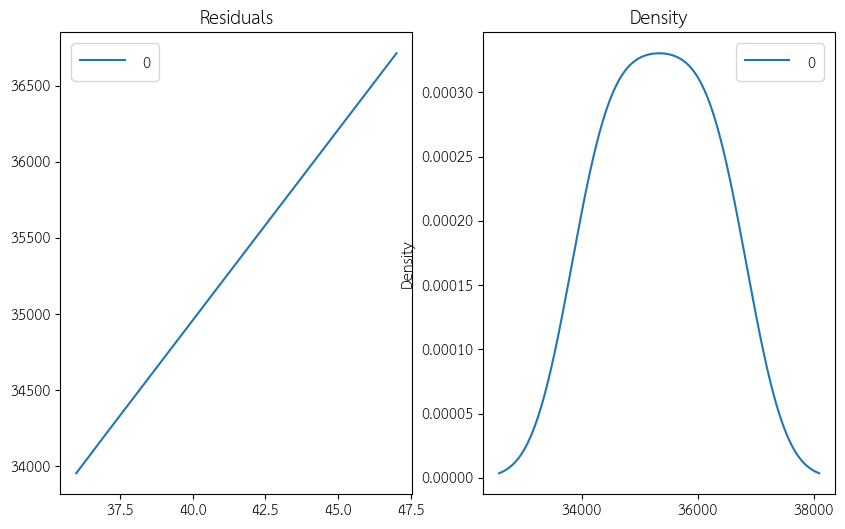

In [131]:
# เลือกอันที่ P > |Z| ดีๆ คือค่าน้อยๆ
preds, conf_int = model_fit.predict(n_periods=12, return_conf_int=True)
residuals = pd.DataFrame(preds)
fig,ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax=ax[0])
residuals.plot(kind='kde',title='Density',ax=ax[1])
plt.show()

# ARIMA MODEL pmdarima 

In [132]:
Gold_data = Gold_data[Gold_data['Report Date'] <= '2023-12-31']

In [133]:
arima = pm.auto_arima(Gold_data['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=False, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)

preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)
arima_only_predict = pd.DataFrame(preds)
arima_only_predict.columns = ['Predict']

arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1267.587
Date:                              Wed, 14 Aug 2024   AIC                           2541.174
Time:                                      08:06:23   BIC                           2550.304
Sample:                                           0   HQIC                          2544.882
                                              - 156                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8231      0.219      3.752      0.000       0.393       1.253
ma.S.L12      -0.7369      0.252     -2.928      0.003      -1.230      -0.244
sigma2      7.427e+05   6.71e+04     11.062      0.000    6.11e+05    8.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                15.53
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.45
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
arima_only_predict

Predict
156  33732.939932
157  33826.960198
158  34053.291215
159  34175.054362
160  34188.187541
161  34206.301530
162  34336.729756
163  34358.253980
164  34315.845074
165  34484.022643
166  34336.904626
167  34393.809184

In [135]:
arima_only_best_case

0
0   35422.072725
1   36215.752448
2   36978.951351
3   37553.315164
4   37965.197584
5   38343.808471
6   38805.747826
7   39135.835097
8   39383.234949
9   39825.520463
10  39939.114706
11  40245.126694

In [136]:
arima_only_worst_case

0
0   32043.807138
1   31438.167948
2   31127.631079
3   30796.793559
4   30411.177497
5   30068.794589
6   29867.711687
7   29580.672864
8   29248.455199
9   29142.524823
10  28734.694546
11  28542.491675

In [14]:
def eomonth(d, months=0):
    months = int(months)
    if isinstance(d, list):
        return [eomonth(d0, months) for d0 in d]
    elif isinstance(d, pd.Series):
        return d.map(lambda d0: eomonth(d0, months))
    else:
        y, m = divmod(d.month + months + 1, 12)
        # y, m = int(y), int(m)
        if m==0:
            y -= 1
            m = 12
        return pytz.UTC.localize(datetime.datetime(d.year + y, m, 1) - datetime.timedelta(days=1))

In [15]:
Date = Gold_Factor_data['Report Date']
last_date = Date.iloc[-1]
arr = []
period = 12
for i in range(period):
    next_month = eomonth(last_date,i+1)
    arr = np.append(arr,next_month)

Date_forecast_period = pd.DataFrame(arr)
Date_forecast_period.columns = ['Report Date']
Date_forecast_period['Report Date'] = Date_forecast_period['Report Date'].dt.tz_localize(None)
# Date_forecast_period['Report Date']

In [16]:
Date_forecast_period

Report Date
0   2024-01-31
1   2024-02-29
2   2024-03-31
3   2024-04-30
4   2024-05-31
5   2024-06-30
6   2024-07-31
7   2024-08-31
8   2024-09-30
9   2024-10-31
10  2024-11-30
11  2024-12-31

In [65]:
Date_for_connect = pd.DataFrame()
Date_for_connect['Report Date'] = pd.concat([Gold_data['Report Date'].iloc[-1:],Date_forecast_period['Report Date'].iloc[:1]])
# Date_for_connect['Value'] = pd.concat([ Gold_data['GoldBar_Sale'].iloc[-1:].values[0].astype(float),arima_only_predict.iloc[:1].values[0][0]])
Gold_data['Report Date'].iloc[-1:]
Date_forecast_period['Report Date'].iloc[:1]
Gold_data['GoldBar_Sale'].iloc[-1:].values[0]
# arima_only_predict.iloc[:1].values[0][0]
# Date_for_connect['Report Date']
# Date_for_connect['Value']

40500

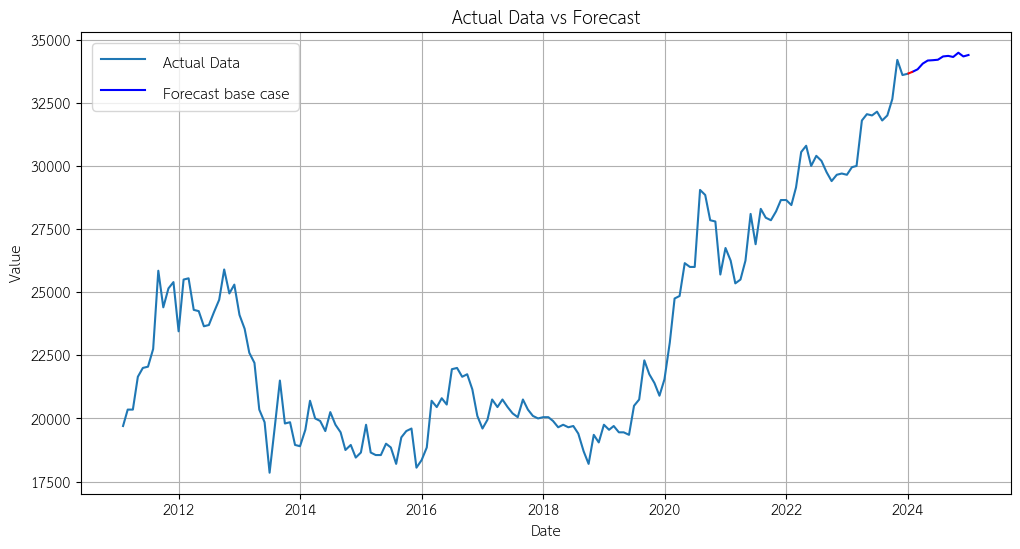

In [141]:
Date_for_connect = pd.DataFrame()
Date_for_connect['Report Date'] = pd.concat([Gold_data['Report Date'].iloc[-1:],Date_forecast_period['Report Date'].iloc[:1]])
# Date_for_connect['Value'] = pd.concat([ Gold_data['GoldBar_Sale'].iloc[-1:],arima_only_predict['Predict'].iloc[:1]])
# Date_for_connect['Best'] = pd.concat([(Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0]),arima_only_best_case[0]])
# Date_for_connect['Worst'] = pd.concat([ Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_worst_case[0]])
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict['Predict'] , label='Forecast base case' , color = 'blue')
# plt.plot(Date_forecast_period,arima_only_best_case , label='Forecast best case' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_worst_case , label='Forecast worst case' , color = 'red')
plt.plot(Date_for_connect['Report Date'] ,[Gold_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_predict.iloc[:1].values[0][0]],color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'], np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], arima_only_best_case),color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'] ,np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], base_case),color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

Forecast GoldBar_Sale price in Thailand with 3 Factor by LinearRegression and ARIMA model

In [66]:
def eomonth(d, months=0):
    months = int(months)
    if isinstance(d, list):
        return [eomonth(d0, months) for d0 in d]
    elif isinstance(d, pd.Series):
        return d.map(lambda d0: eomonth(d0, months))
    else:
        y, m = divmod(d.month + months + 1, 12)
        # y, m = int(y), int(m)
        if m==0:
            y -= 1
            m = 12
        return pytz.UTC.localize(datetime.datetime(d.year + y, m, 1) - datetime.timedelta(days=1))

In [67]:
Date = Factor_data['Report Date']
last_date = Date.iloc[-1]
arr = []
period = 12
for i in range(period):
    next_month = eomonth(last_date,i+1)
    arr = np.append(arr,next_month)

Date_forecast_period = pd.DataFrame(arr)
Date_forecast_period.columns = ['Report Date']
Date_forecast_period['Report Date'] = Date_forecast_period['Report Date'].dt.tz_localize(None)
Date_forecast_period

Report Date
0   2024-01-31
1   2024-02-29
2   2024-03-31
3   2024-04-30
4   2024-05-31
5   2024-06-30
6   2024-07-31
7   2024-08-31
8   2024-09-30
9   2024-10-31
10  2024-11-30
11  2024-12-31

In [68]:
Gold_Factor_data.columns[5:]

Index(['Inflation', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91', 'PTT_ดีเซล',
       'อัตราแลกเปลี่ยน_USD_THB', 'XAU_USD', 'CPI', 'น้ำมัน_brent_USD',
       'Core_CPI', 'พันธบัตรUSA_10_ปี_USD',
       ...
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_4',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_4',
       '%CHANGE_SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย)_LAG_4',
       '%CHANGE_BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)_LAG_5',
       '%CHANGE_SCB_ออมทรัพย์(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)_LAG_5',
       '%CHANGE_SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย)_LAG_5', 'GB_S'],
      dtype='object', length=711)

In [69]:
Factor_data_selected_P = Gold_Factor_data[[
                                'Inflation','ดัชนีอัตราเงินเฟ้อคาดการณ์_USA'
]]
Factor_data_selected_NoP = Gold_Factor_data[[
    'อัตราแลกเปลี่ยน_USD_THB'
]]
Factor_data_selected_NoP_2011 = Factor_data[[
    'PTT_แก๊สโซฮอล์_95',
    'XAU_USD',
    'PTT_แก๊สโซฮอล์_91',
    'Core_CPI',
    'ราคาน้ำมันดิบ_USD_West_Texas_Intermediate',
    'Down_Jones_Industrial_Average_USD',
    'อัตราแลกเปลี่ยน_HKD_USD',
    'อัตราแลกเปลี่ยน_EURO_USD',
    'Nasdaq_100_USD',
    'พันธบัตรUSA_10_ปี_USD',
    'น้ำมัน_brent_USD',
    'CPI'
]]
# ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']
# Factor_interested = ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']
# Factor_interested_2 = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']
# Factor_interested = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']
# Factor_interested_2 = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']

In [70]:
# Factor_data_selected_P = Gold_Factor_data[[
#                                 '(Inflation)_LAG_10',
# ]]
# Factor_data_selected_NoP = Gold_Factor_data[[
#     'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
#     '%CHANGE_XAU_USD_LAG_1',
#     '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2',
# ]]
Data_orginal = pd.DataFrame({
    'Factor interested' : ['(Inflation)','PTT_แก๊สโซฮอล์_95','XAU_USD','อัตราแลกเปลี่ยน_USD_THB']
})
Data_orginal

Factor interested
0              (Inflation)
1        PTT_แก๊สโซฮอล์_95
2                  XAU_USD
3  อัตราแลกเปลี่ยน_USD_THB

In [71]:
import warnings

# ปิด DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


In [72]:
# Forecast ข้อมูล
output2_base = pd.DataFrame()
output2_worst = pd.DataFrame()
output2_best = pd.DataFrame()
for col in Factor_data_selected_NoP:
    data = Factor_data_selected_NoP[col]
    df = pd.DataFrame(data)
    df['LOG'] = np.log(df.values/df.shift(1))

    df = df.replace((np.inf, -np.inf, np.nan),0).reset_index(drop=True)
    df2 = df[1:]
    if col == 'อัตราแลกเปลี่ยน_USD_THB':
        print(col)
        arima_usd_thb = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=0,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_usd_thb.predict(n_periods=period, return_conf_int=True)

        
    output = pd.DataFrame(preds)
    output.columns =['LOG']
    # per_10 = np.percentile(df2['LOG'], 10)
    # per_50 = np.percentile(df2['LOG'], 50)
    # per_90 = np.percentile(df2['LOG'], 90)
    # worst_return = per_50 - per_10
    # best_return = per_90 - per_50
    # print("\n\npercentile-10 :",per_10)
    # print('percentile-50 :',per_50)
    # print('percentile-90 :',per_90)
    # print('worst_return : ',worst_return)
    # print('best_return : ',best_return)
    v = Factor_data_selected_NoP[col].iloc[-1]
    print(f'\n\n{v}')
    base = []
    # worst = []
    # best = []
    for i in output.iterrows():
        x_base = v*math.exp(i[1].values)
        # x_worst = v*math.exp(i[1].values - worst_return)
        # x_best = v*math.exp(i[1].values + best_return)
        print("x base",x_base)
        # print("x worst",x_worst)
        # print("x_best",x_best)
        v = x_base
        print(f"v : {v} \n\n",)
        base = np.append(base, x_base)
        # worst = np.append(worst, x_worst)
        # best = np.append(best, x_best)
    output_base = pd.DataFrame(base)
    # output_worst = pd.DataFrame(worst)
    # output_best = pd.DataFrame(best)
    output2_base[col] = output_base
    # if col == 'อัตราแลกเปลี่ยน_USD_THB_LAG_4':
    #     output2_worst[col] = output_best
    #     output2_best[col] = output_worst
    # else:
    #     output2_worst[col] = output_worst
    #     output2_best[col] = output_best

อัตราแลกเปลี่ยน_USD_THB
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-84.530, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-81.335, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-87.257, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-82.943, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-82.848, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-85.257, Time=0.45 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-85.279, Time=0.46 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-83.279, Time=0.59 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-84.346, Time=0.15 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-85.657, Time=0.58 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-86.529, Time=0.62 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-88.528, Time=0.25 sec
 ARIMA(0,0,1)(0,1

In [73]:
# Forecast ข้อมูล
output2_base_2011 = pd.DataFrame()
for col in Factor_data_selected_NoP_2011:
    data = Factor_data_selected_NoP_2011[col]
    df = pd.DataFrame(data)
    df['LOG'] = np.log(df.values/df.shift(1))

    df = df.replace((np.inf, -np.inf, np.nan),0).reset_index(drop=True)
    df2 = df[1:]
    if col == 'XAU_USD':
        print(col)
        arima_xau_usd = pm.auto_arima(np.log(Factor_data['XAU_USD']), start_p=3, start_q=3, max_p=12, max_q=12, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_xau_usd.predict(n_periods=period, return_conf_int=True)
        
    elif col == 'PTT_แก๊สโซฮอล์_95':
        print(col)
        arima_ptt_95 = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=0,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_ptt_95.predict(n_periods=period, return_conf_int=True)
        
    elif col == 'PTT_แก๊สโซฮอล์_91':
        print(col)
        arima_ptt_91 = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=2,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_ptt_91.predict(n_periods=period, return_conf_int=True)
    elif col == 'Core_CPI':
        print(col)
        arima_core_cpi = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_core_cpi.predict(n_periods=period, return_conf_int=True)
    elif col == 'ราคาน้ำมันดิบ_USD_West_Texas_Intermediate':
        print(col)
        arima_usd_wti = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_usd_wti.predict(n_periods=period, return_conf_int=True)
    elif col == 'Down_Jones_Industrial_Average_USD':
        print(col)
        arima_down_jones = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_down_jones.predict(n_periods=period, return_conf_int=True)
    elif col == 'อัตราแลกเปลี่ยน_HKD_USD':
        print(col)
        arima_hkd_usd = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_hkd_usd.predict(n_periods=period, return_conf_int=True)
    elif col == 'อัตราแลกเปลี่ยน_EURO_USD':
        print(col)
        arima_euro_usd = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_euro_usd.predict(n_periods=period, return_conf_int=True)
    elif col == 'Nasdaq_100_USD':
        print(col)
        arima_nasdaq = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_nasdaq.predict(n_periods=period, return_conf_int=True)
    elif col == 'พันธบัตรUSA_10_ปี_USD':
        print(col)
        arima_card_usd = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_card_usd.predict(n_periods=period, return_conf_int=True)
    elif col == 'น้ำมัน_brent_USD':
        print(col)
        arima_brent_usd = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=3,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_brent_usd.predict(n_periods=period, return_conf_int=True)
    elif col == 'CPI':
        print(col)
        arima_cpi = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=0,
                         trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_cpi.predict(n_periods=period, return_conf_int=True)

   
    output = pd.DataFrame(preds)
    output.columns =['LOG']
    # per_10 = np.percentile(df2['LOG'], 10)
    # per_50 = np.percentile(df2['LOG'], 50)
    # per_90 = np.percentile(df2['LOG'], 90)
    # worst_return = per_50 - per_10
    # best_return = per_90 - per_50
    # print("\n\npercentile-10 :",per_10)
    # print('percentile-50 :',per_50)
    # print('percentile-90 :',per_90)
    # print('worst_return : ',worst_return)
    # print('best_return : ',best_return)
    if col == 'PTT_แก๊สโซฮอล์_95':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'XAU_USD':
        base = []
        for i in output.iterrows():
            x_base = np.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] =(output_base_2011)
    elif col == 'PTT_แก๊สโซฮอล์_91':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'Core_CPI':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'ราคาน้ำมันดิบ_USD_West_Texas_Intermediate':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'Down_Jones_Industrial_Average_USD':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'อัตราแลกเปลี่ยน_HKD_USD':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'อัตราแลกเปลี่ยน_EURO_USD':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'Nasdaq_100_USD':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'พันธบัตรUSA_10_ปี_USD':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'น้ำมัน_brent_USD':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    elif col == 'CPI':
        v = Factor_data_selected_NoP_2011[col].iloc[-1]
        print(f'\n\n{v}')
        base = []
        for i in output.iterrows():
            x_base = v*math.exp(i[1].values)
            print("x base",x_base)
            v = x_base
            print(f"v : {v} \n\n",)
            base = np.append(base, x_base)
        output_base_2011 = pd.DataFrame(base)
        output2_base_2011[col] = output_base_2011
    # if col == 'อัตราแลกเปลี่ยน_USD_THB_LAG_4':
    #     output2_worst[col] = output_best
    #     output2_best[col] = output_worst
    # else:
    #     output2_worst[col] = output_worst
    #     output2_best[col] = output_best

PTT_แก๊สโซฮอล์_95
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-453.785, Time=1.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-452.351, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-452.779, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-453.385, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-454.351, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-453.078, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-453.327, Time=0.37 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-451.647, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-452.008, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-452.505, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-455.320, Time=0.44 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-455.440, Time=0.31 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-453.622, Time=1.12 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-455.578, Time=0.40 sec
 

In [74]:
# arima_change_usd_thb_4.summary()
# arima_log_cpi.summary()
# arima_ptt_95.summary()
# arima_change_usd_thb_2.summary()
# arima_change_usd_thb_4.params
# arima_log_cpi.params
# arima_ptt_95.params
# arima_change_usd_thb_2.get_params()
# arima_change_usd_thb_2.order
# arima_change_xau_usd.summary()
# arima_ptt_95.summary()
# arima_change_usd_thb_2.summary()
output2_base_2011
# preds, conf_int = arima_xau_usd.predict(n_periods=period, return_conf_int=True)
# conf_int
# preds
# output

PTT_แก๊สโซฮอล์_95      XAU_USD  PTT_แก๊สโซฮอล์_91    Core_CPI  \
0           35.058925  1774.429060          33.679135  104.664741   
1           35.013840  1845.325596          33.726177  104.761620   
2           35.043293  1861.604874          34.194256  104.901805   
3           34.983292  1876.809274          33.960051  105.040208   
4           35.008786  1948.336574          33.569290  105.212908   
5           35.012667  1922.288174          33.059791  105.412627   
6           34.776649  1958.977213          32.510732  105.638796   
7           34.526549  2016.115079          31.805720  105.900340   
8           34.663558  2009.642104          31.190204  106.187192   
9           34.766101  2058.159290          30.570711  106.516030   
10          35.040886  2107.067360          30.163819  106.878997   
11          35.151062  2136.240366          29.919818  107.282231   

    ราคาน้ำมันดิบ_USD_West_Texas_Intermediate  \
0                                   76.139588   
1                                   84.408358   
2                                   86.483475   
3                                   87.926924   
4                                   86.789279   
5                                   88.121660   
6                                   96.209326   
7                                   97.801699   
8                                   92.382190   
9                                   92.420561   
10                                  95.925220   
11                                  98.574706   

    Down_Jones_Industrial_Average_USD  อัตราแลกเปลี่ยน_HKD_USD  \
0                        38060.230270                 0.128577   
1                        39573.188323                 0.128927   
2                        40984.267312                 0.129469   
3                        42684.843736                 0.130131   
4                        44525.247032                 0.130975   
5                        46828.518367                 0.131836   
6                        50420.325883                 0.132960   
7                        54523.450838                 0.134100   
8                        58881.546540                 0.135459   
9                        63320.593571                 0.136968   
10                       68133.712328                 0.138699   
11                       74800.606312                 0.140560   

    อัตราแลกเปลี่ยน_EURO_USD  Nasdaq_100_USD  พันธบัตรUSA_10_ปี_USD  \
0                   1.134325    17018.094750               3.656942   
1                   1.169992    17025.408487               3.537194   
2                   1.184114    17348.247600               3.349891   
3                   1.225600    17150.166730               3.112323   
4                   1.289904    17287.590475               2.922954   
5                   1.355494    17741.023864               2.658472   
6                   1.434482    18898.633875               2.418722   
7                   1.556799    19388.373348               2.148075   
8                   1.703568    19658.628843               1.869587   
9                   1.882537    19950.032386               1.616874   
10                  2.130979    20506.059881               1.410291   
11                  2.465545    20911.474457               1.205449   

    น้ำมัน_brent_USD         CPI  
0          82.143002  106.867545  
1          88.578304  107.007531  
2          91.330927  107.181922  
3          99.467010  107.277768  
4          96.808068  107.517576  
5         101.881893  107.522521  
6         106.343811  107.676316  
7         112.878163  107.721710  
8         121.826320  107.920191  
9         126.455155  108.104695  
10        139.511463  108.301876  
11        146.704183  108.538970

In [76]:
# conf_int
# output
# for i in df2['LOG']:
#     print(i)
# df2['LOG']
output3_base = pd.DataFrame()

In [77]:
# output3_worst = Date_forecast_period.join(output2_worst)
output3_base = Date_forecast_period.join(output2_base)
output3_base = output3_base.join(output2_base_2011)
output3_base
# output3_best = Date_forecast_period.join(output2_best)

# output3_worst.to_excel(result_worst_NoP)
# output3_base.to_excel(result_base_NoP)
# output3_best.to_excel(result_best_NoP)

Report Date  อัตราแลกเปลี่ยน_USD_THB  PTT_แก๊สโซฮอล์_95      XAU_USD  \
0   2024-01-31                33.719218          35.058925  1774.429060   
1   2024-02-29                33.734965          35.013840  1845.325596   
2   2024-03-31                33.682028          35.043293  1861.604874   
3   2024-04-30                34.146762          34.983292  1876.809274   
4   2024-05-31                34.106081          35.008786  1948.336574   
5   2024-06-30                34.766779          35.012667  1922.288174   
6   2024-07-31                34.944147          34.776649  1958.977213   
7   2024-08-31                35.086973          34.526549  2016.115079   
8   2024-09-30                36.139429          34.663558  2009.642104   
9   2024-10-31                35.993492          34.766101  2058.159290   
10  2024-11-30                33.515147          35.040886  2107.067360   
11  2024-12-31                32.701320          35.151062  2136.240366   

    PTT_แก๊สโซฮอล์_91    Core_CPI  ราคาน้ำมันดิบ_USD_West_Texas_Intermediate  \
0           33.679135  104.664741                                  76.139588   
1           33.726177  104.761620                                  84.408358   
2           34.194256  104.901805                                  86.483475   
3           33.960051  105.040208                                  87.926924   
4           33.569290  105.212908                                  86.789279   
5           33.059791  105.412627                                  88.121660   
6           32.510732  105.638796                                  96.209326   
7           31.805720  105.900340                                  97.801699   
8           31.190204  106.187192                                  92.382190   
9           30.570711  106.516030                                  92.420561   
10          30.163819  106.878997                                  95.925220   
11          29.919818  107.282231                                  98.574706   

    Down_Jones_Industrial_Average_USD  อัตราแลกเปลี่ยน_HKD_USD  \
0                        38060.230270                 0.128577   
1                        39573.188323                 0.128927   
2                        40984.267312                 0.129469   
3                        42684.843736                 0.130131   
4                        44525.247032                 0.130975   
5                        46828.518367                 0.131836   
6                        50420.325883                 0.132960   
7                        54523.450838                 0.134100   
8                        58881.546540                 0.135459   
9                        63320.593571                 0.136968   
10                       68133.712328                 0.138699   
11                       74800.606312                 0.140560   

    อัตราแลกเปลี่ยน_EURO_USD  Nasdaq_100_USD  พันธบัตรUSA_10_ปี_USD  \
0                   1.134325    17018.094750               3.656942   
1                   1.169992    17025.408487               3.537194   
2                   1.184114    17348.247600               3.349891   
3                   1.225600    17150.166730               3.112323   
4                   1.289904    17287.590475               2.922954   
5                   1.355494    17741.023864               2.658472   
6                   1.434482    18898.633875               2.418722   
7                   1.556799    19388.373348               2.148075   
8                   1.703568    19658.628843               1.869587   
9                   1.882537    19950.032386               1.616874   
10                  2.130979    20506.059881               1.410291   
11                  2.465545    20911.474457               1.205449   

    น้ำมัน_brent_USD         CPI  
0          82.143002  106.867545  
1          88.578304  107.007531  
2          91.330927  107.181922  
3          99.467010  107.277768  
4          96.808068  107.51

In [113]:
# for rate type data

output2_base = pd.DataFrame()
# output2_worst = pd.DataFrame()
# output2_best = pd.DataFrame()
# Loop data
for col in Factor_data_selected_P:
    data = Factor_data_selected_P[col]
    df2 = data[1:]
    # arima
    print(col)
    if col == 'Inflation':
        arima_inflation_th = pm.auto_arima(df2, start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=0,
                         trace=True, suppress_warnings=True, stepwise = True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_inflation_th.predict(n_periods=period, return_conf_int=True)
    elif col == 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA':
        arima_inflation_usa = pm.auto_arima(df2, start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=0,
                         trace=True, suppress_warnings=True, stepwise = True,
                         error_action='ignore', m=12)
        preds, conf_int = arima_inflation_usa.predict(n_periods=period, return_conf_int=True)

    output = pd.DataFrame(preds)
    output.columns =['LOG']
    # ค่าความแปรปรวนร่วม Covariance
    # ส่วนเบี่ยงเบนมาตรฐาน
    # var = math.sqrt(np.cov(df2))
    # print(f'\n{var}')
    # ค่า Z = 1.28 ความมั่นใจที่ 80%
    # worst_return = 1.28*var/math.sqrt(len(df2))
    # best_return = 1.28*var/math.sqrt(len(df2))

    v = Factor_data_selected_P[col].iloc[-1]
    base = []
    # worst = []
    # best = []
    for i in output.iterrows():
        x_base = i[1]
        # x_worst = i[1].values - worst_return
        # x_best = i[1].values + best_return
        v = x_base
        base = np.append(base, x_base)
        # worst = np.append(worst, x_worst)
        # best = np.append(best, x_best)
    output_base = pd.DataFrame(base)
    # output_worst = pd.DataFrame(worst)
    # output_best = pd.DataFrame(best)
    output2_base[col] = output_base
    # if col == 'Unemployment Rate':
    #     output2_worst[col] = output_best
    #     output2_best[col] = output_worst
    # else:
    #     output2_worst[col] = output_worst
    #     output2_best[col] = output_best
print('\n')

Inflation
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-0.198, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=110.848, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=141.130, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-3.137, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=28.363, Time=0.07 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-1.203, Time=0.46 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-9.190, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=24.428, Time=0.15 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=-7.263, Time=0.56 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-2.817,

C:\Users\TeetonLP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\TeetonLP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=59.323, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=79.296, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=56.047, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=62.531, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=205.447, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=54.058, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=56.049, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=57.942, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=55.751, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=55.445, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=63.796, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.772 seconds




C:\Users\TeetonLP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\TeetonLP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Update pkl model ARIMA

In [114]:
import joblib
import pickle
with open('arima_usd_thb.pkl', 'wb') as pkl:
     pickle.dump(arima_usd_thb, pkl)
with open('arima_xau_usd.pkl', 'wb') as pkl:
     pickle.dump(arima_xau_usd, pkl)
with open('arima_ptt_95.pkl', 'wb') as pkl:
     pickle.dump(arima_ptt_95, pkl)
with open('arima_ptt_91.pkl', 'wb') as pkl:
     pickle.dump(arima_ptt_91, pkl)
with open('arima_core_cpi.pkl', 'wb') as pkl:
     pickle.dump(arima_core_cpi, pkl)
with open('arima_usd_wti.pkl', 'wb') as pkl:
     pickle.dump(arima_usd_wti, pkl)
with open('arima_down_jones.pkl', 'wb') as pkl:
     pickle.dump(arima_down_jones, pkl)
with open('arima_hkd_usd.pkl', 'wb') as pkl:
     pickle.dump(arima_hkd_usd, pkl)
with open('arima_euro_usd.pkl', 'wb') as pkl:
     pickle.dump(arima_euro_usd, pkl)
with open('arima_nasdaq.pkl', 'wb') as pkl:
     pickle.dump(arima_nasdaq, pkl)
with open('arima_card_usd.pkl', 'wb') as pkl:
     pickle.dump(arima_card_usd, pkl)
with open('arima_brent_usd.pkl', 'wb') as pkl:
     pickle.dump(arima_brent_usd, pkl)
with open('arima_cpi.pkl', 'wb') as pkl:
     pickle.dump(arima_cpi, pkl)
with open('arima_inflation_th.pkl', 'wb') as pkl:
     pickle.dump(arima_inflation_th, pkl)
with open('arima_inflation_usa.pkl', 'wb') as pkl:
     pickle.dump(arima_inflation_usa, pkl)

# exmaple use
# Serialize with Pickle
# with open('arima.pkl', 'wb') as pkl:
#     pickle.dump(arima, pkl)

# # You can still make predictions from the model at this point
# arima.predict(n_periods=5)

# # Now read it back and make a prediction
# with open('arima.pkl', 'rb') as pkl:
#     pickle_preds = pickle.load(pkl).predict(n_periods=5)

# # Or maybe joblib tickles your fancy
# joblib.dump(arima, 'arima.pkl')
# joblib_preds = joblib.load('arima.pkl').predict(n_periods=5)

# # show they're the same
# np.allclose(pickle_preds, joblib_preds)

In [115]:
arima_inflation_usa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -24.029
Date:                Thu, 22 Aug 2024   AIC                             54.058
Time:                        22:21:31   BIC                             58.725
Sample:                             0   HQIC                            55.669
                                 - 35                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9148      0.727      1.259      0.208      -0.510       2.339
ar.L1          0.7807      0.179      4.362      0.000       0.430       1.131
sigma2         0.2250      0.061      3.694      0.000       0.106       0.344
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.66   Prob(JB):                         0.41
Heteroskedasticity (H):               2.34   Skew:                            -0.41
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
# arima.summary()
output2_base

Inflation  ดัชนีอัตราเงินเฟ้อคาดการณ์_USA
0    0.717500                        3.334901
1    1.711447                        3.518283
2    1.822905                        3.661445
3    1.842503                        3.773209
4    1.874439                        3.860461
5    2.013522                        3.928577
6    2.363972                        3.981754
7    2.343560                        4.023267
8    2.404438                        4.055676
9    2.284083                        4.080977
10   2.265362                        4.100729
11   2.170354                        4.116149

In [80]:
# np.cov(df2)

In [156]:
# from scipy.stats import norm
# # ระดับความเชื่อมั่น 80%
# confidence_level = 0.80
# alpha = 1 - confidence_level
# z_score = norm.ppf(1 - alpha / 2)
# print('Z-score for 80% Confidence Interval:', z_score)

In [157]:
# 1 - (alpha / 2)

In [158]:
# var

In [159]:
# data[1:]

In [160]:
# df2

In [161]:
# Model_ARIMA_ALL = pd.DataFrame({
#     'LOG_PTT_แก๊สโซฮอล์_95_LAG_1' : ['ARIMA(0,0,0)(0,0,0)[12]'] ,
#     '%CHANGE_XAU_USD_LAG_1' : ['ARIMA(0,0,1)(0,0,0)[12]'] ,
#     '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' : ['ARIMA(0,0,0)(0,0,0)[12]'] , 
#     '(Inflation)_LAG_10' : ['ARIMA(0,1,0)(2,0,1)[12] intercept'] 
# })
Model_ARIMA_ALL = pd.DataFrame({
       'Factor' : ['PTT_แก๊สโซฮอล์_95','XAU_USD','อัตราแลกเปลี่ยน_USD_THB','(Inflation)'],
        'Model of ARIMA' : ['ARIMA(0,0,0)(0,0,0)[12]','ARIMA(0,0,0)(0,0,0)[12]','ARIMA(0,0,1)(1,1,0)[12] intercept','ARIMA(2,0,1)(1,0,0)[12] intercept']
})
Model_ARIMA_ALL = pd.DataFrame({
       'Factor' : ['PTT_แก๊สโซฮอล์_95','XAU_USD','อัตราแลกเปลี่ยน_USD_THB','(Inflation)'],
        'Model of ARIMA' : ['ARIMA(1,0,1)(0,0,1)[12]','ARIMA(10,3,1)(0,0,0)[12]','ARIMA(0,0,1)(1,1,0)[12] intercept','ARIMA(2,0,1)(1,0,0)[12] intercept']
})
Model_ARIMA_ALL

Factor                     Model of ARIMA
0        PTT_แก๊สโซฮอล์_95            ARIMA(1,0,1)(0,0,1)[12]
1                  XAU_USD           ARIMA(10,3,1)(0,0,0)[12]
2  อัตราแลกเปลี่ยน_USD_THB  ARIMA(0,0,1)(1,1,0)[12] intercept
3              (Inflation)  ARIMA(2,0,1)(1,0,0)[12] intercept

In [81]:
output3_base = output3_base.join(output2_base)
# output3_best = output3_best.join(output2_best)
# output3_worst = output3_worst.join(output2_worst)

In [109]:
output2_base
output3_base.to_excel('ARIMA_PT_2024.xlsx')

In [17]:
arima_col = output3_base.columns[1:]
Factor_ARIMA = Gold_Factor_data[['Report Date','อัตราแลกเปลี่ยน_USD_THB','PTT_แก๊สโซฮอล์_95','XAU_USD','PTT_แก๊สโซฮอล์_91','Core_CPI','ราคาน้ำมันดิบ_USD_West_Texas_Intermediate','Down_Jones_Industrial_Average_USD','อัตราแลกเปลี่ยน_HKD_USD','อัตราแลกเปลี่ยน_EURO_USD','Nasdaq_100_USD','พันธบัตรUSA_10_ปี_USD','น้ำมัน_brent_USD','CPI','Inflation','ดัชนีอัตราเงินเฟ้อคาดการณ์_USA']]
Factor_ARIMA = pd.concat([Factor_ARIMA,output3_base])
Factor_ARIMA
# output3_base.columns[1:]

Report Date  อัตราแลกเปลี่ยน_USD_THB  PTT_แก๊สโซฮอล์_95      XAU_USD  \
0   2021-01-31                29.860000          24.250000  1282.090000   
1   2021-02-28                30.470000          26.050000  1327.190000   
2   2021-03-31                31.240000          26.150000  1250.690000   
3   2021-04-30                31.140000          29.050000  1291.290000   
4   2021-05-31                31.190000          27.950000  1283.640000   
5   2021-06-30                32.020000          28.750000  1325.790000   
6   2021-07-31                32.890000          29.550000  1243.190000   
7   2021-08-30                32.220000          29.250000  1204.940000   
8   2021-09-30                33.670000          30.750000  1251.990000   
9   2021-10-31                33.290000          32.550000  1323.190000   
10  2021-11-29                33.710000          31.050000  1326.940000   
11  2021-12-31                33.230000          31.150000  1395.690000   
12  2022-01-31                33.220000          34.050000  1322.490000   
13  2022-02-28                32.670000          36.550000  1233.140000   
14  2022-03-31                33.280000          40.050000  1386.400000   
15  2022-04-30                34.240000          38.850000  1476.600000   
16  2022-05-30                34.300000          43.850000  1596.170000   
17  2022-06-30                35.300000          44.650000  1579.760000   
18  2022-07-31                36.290000          37.850000  1662.990000   
19  2022-08-31                36.520000          37.950000  1674.340000   
20  2022-09-30                37.770000          33.750000  1714.400000   
21  2022-10-31                38.050000          35.350000  1720.550000   
22  2022-11-30                35.110000          35.150000  1771.220000   
23  2022-12-31                34.610000          34.450000  1691.150000   
24  2023-01-30                32.840000          36.650000  1613.900000   
25  2023-02-27                35.220000          35.850000  1598.600000   
26  2023-03-31                34.160000          35.750000  1560.700000   
27  2023-04-30                34.120000          35.950000  1664.360000   
28  2023-05-31                34.640000          35.450000  1668.900000   
29  2023-06-30                35.270000          35.150000  1695.200000   
30  2023-07-31                34.210000          37.950000  1739.430000   
31  2023-08-31                34.980000          40.050000  1564.300000   
32  2023-09-30                36.510000          39.450000  1745.700000   
33  2023-10-30                36.140000          38.250000  1715.250000   
34  2023-11-30                35.310000          36.050000  1623.750000   
35  2023-12-31                34.350000          35.250000  1823.800000   
0   2024-01-31                33.719218          35.058925  1774.429060   
1   2024-02-29                33.734965          35.013840  1845.325596   
2   2024-03-31                33.682028          35.043293  1861.604874   
3   2024-04-30                34.146762          34.983292  1876.809274   
4   2024-05-31                34.106081          35.008786  1948.336574   
5   2024-06-30                34.766779          35.012667  1922.288174   
6   2024-07-31                34.944147          34.776649  1958.977213   
7   2024-08-31                35.086973          34.526549  2016.115079   
8   2024-09-30                36.139429          34.663558  2009.642104   
9   2024-10-31                35.993492          34.766101  2058.159290   
10  2024-11-30                33.515147          35.040886  2107.067360   
11  2024-12-31                32.701320          35.151062  2136.240366   

    PTT_แก๊สโซฮอล์_91    Core_CPI  ราคาน้ำมันดิบ_USD_West_Texas_Intermediate  \
0           23.980000  100.470000                                  52.200000   
1           25.780000  100.390000                                  61.500000   
2           25.880000  100.420000                                  59.160000   
3      

Verson ARIMA value of select

In [165]:
Factor_data_selected_P = Gold_Factor_data[[
                                '(Inflation)_LAG_10',
]]
Factor_data_selected_NoP = Gold_Factor_data[[
    'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
    '%CHANGE_XAU_USD_LAG_1',
    '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2',
]]
# ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']
# Factor_interested = ['(Inflation)','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4','LOG_CPI']
# Factor_interested_2 = ['(Inflation)','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']
# Factor_interested = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_XAU_USD_LAG_1']
# Factor_interested_2 = ['(Inflation)_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2']

In [105]:
# # Forecast ข้อมูล
# output2_base = pd.DataFrame()
# output2_worst = pd.DataFrame()
# output2_best = pd.DataFrame()
# for col in Factor_data_selected_NoP:
#     data = Factor_data_selected_NoP[col]
#     df = pd.DataFrame(data)
#     df['LOG'] = np.log(df.values/df.shift(1))

#     df = df.replace((np.inf, -np.inf, np.nan),0).reset_index(drop=True)
#     df2 = df[1:]
#     if col == '%CHANGE_XAU_USD_LAG_1':
#         print(col)
#         arima_xau_usd = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=1,
#                          trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
#                          error_action='ignore', m=12)
#         preds, conf_int = arima_xau_usd.predict(n_periods=period, return_conf_int=True)
#     elif col == 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1':
#         print(col)
#         arima_ptt_95 = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=1,
#                          trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
#                          error_action='ignore', m=12)
#         preds, conf_int = arima_ptt_95.predict(n_periods=period, return_conf_int=True)
#     elif col == '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2':
#         print(col)
#         arima_usd_thb = pm.auto_arima(df2['LOG'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=0,
#                          trace=True, suppress_warnings=True, stepwise = True, seasonal=True,
#                          error_action='ignore', m=12)
#         preds, conf_int = arima_usd_thb.predict(n_periods=period, return_conf_int=True)
        
        
#     output = pd.DataFrame(preds)
#     output.columns =['LOG']
#     # per_10 = np.percentile(df2['LOG'], 10)
#     # per_50 = np.percentile(df2['LOG'], 50)
#     # per_90 = np.percentile(df2['LOG'], 90)
#     # worst_return = per_50 - per_10
#     # best_return = per_90 - per_50
#     # print("\n\npercentile-10 :",per_10)
#     # print('percentile-50 :',per_50)
#     # print('percentile-90 :',per_90)
#     # print('worst_return : ',worst_return)
#     # print('best_return : ',best_return)
#     v = Factor_data_selected_NoP[col].iloc[-1]
#     print(f'\n\n{v}')
#     base = []
#     # worst = []
#     # best = []
#     for i in output.iterrows():
#         x_base = v*math.exp(i[1].values)
#         # x_worst = v*math.exp(i[1].values - worst_return)
#         # x_best = v*math.exp(i[1].values + best_return)
#         print("x base",x_base)
#         # print("x worst",x_worst)
#         # print("x_best",x_best)
#         v = x_base
#         print(f"v : {v} \n\n",)
#         base = np.append(base, x_base)
#         # worst = np.append(worst, x_worst)
#         # best = np.append(best, x_best)
#     output_base = pd.DataFrame(base)
#     # output_worst = pd.DataFrame(worst)
#     # output_best = pd.DataFrame(best)
#     output2_base[col] = output_base
#     # if col == 'อัตราแลกเปลี่ยน_USD_THB_LAG_4':
#     #     output2_worst[col] = output_best
#     #     output2_best[col] = output_worst
#     # else:
#     #     output2_worst[col] = output_worst
#     #     output2_best[col] = output_best

In [106]:
# output3_worst = Date_forecast_period.join(output2_worst)
# output3_base = Date_forecast_period.join(output2_base)
# output3_best = Date_forecast_period.join(output2_best)

# output3_worst.to_excel(result_worst_NoP)
# output3_base.to_excel(result_base_NoP)
# output3_best.to_excel(result_best_NoP)

In [107]:
# # for rate type data

# output2_base = pd.DataFrame()
# # output2_worst = pd.DataFrame()
# # output2_best = pd.DataFrame()
# # Loop data
# for col in Factor_data_selected_P:
#     data = Factor_data_selected_P[col]
#     df2 = data[1:]
#     # arima
#     print(col)
#     arima = pm.auto_arima(df2, start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,d=0,
#                      trace=True, suppress_warnings=True, stepwise = True,
#                      error_action='ignore', m=12)
    
#     preds, conf_int = arima.predict(n_periods=period, return_conf_int=True)

#     output = pd.DataFrame(preds)
#     output.columns =['LOG']
#     # ค่าความแปรปรวนร่วม Covariance
#     # ส่วนเบี่ยงเบนมาตรฐาน
#     # var = math.sqrt(np.cov(df2))
#     # print(f'\n{var}')
#     # ค่า Z = 1.28 ความมั่นใจที่ 80%
#     # worst_return = 1.28*var/math.sqrt(len(df2))
#     # best_return = 1.28*var/math.sqrt(len(df2))

#     v = Factor_data_selected_P[col].iloc[-1]
#     base = []
#     # worst = []
#     # best = []
#     for i in output.iterrows():
#         x_base = i[1]
#         # x_worst = i[1].values - worst_return
#         # x_best = i[1].values + best_return
#         v = x_base
#         base = np.append(base, x_base)
#         # worst = np.append(worst, x_worst)
#         # best = np.append(best, x_best)
#     output_base = pd.DataFrame(base)
#     # output_worst = pd.DataFrame(worst)
#     # output_best = pd.DataFrame(best)
#     output2_base[col] = output_base
#     # if col == 'Unemployment Rate':
#     #     output2_worst[col] = output_best
#     #     output2_best[col] = output_worst
#     # else:
#     #     output2_worst[col] = output_worst
#     #     output2_best[col] = output_best
# print('\n')

In [108]:
# output

# ปรับข้อมูล ของ ARIMA

In [54]:
# arima_col = Factor_ARIMA.columns[1:]

In [77]:
for month in range(1,13):  #6
    Factor_ARIMA[[i+f'_LAG_{month}' for i in arima_col]] = Factor_ARIMA[arima_col].shift(month)

C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\84738048.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_ARIMA[[i+f'_LAG_{month}' for i in arima_col]] = Factor_ARIMA[arima_col].shift(month)
C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\84738048.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_ARIMA[[i+f'_LAG_{month}' for i in arima_col]] = Factor_ARIMA[arima_col].shift(month)
C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\84738048.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [78]:
for month in range(0,13): #6
    Factor_ARIMA[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in arima_col]] = \
    Factor_ARIMA[[i+f'_LAG_{month}' if month!=0 else i for i in arima_col]].apply(np.log)

C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\3140020663.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_ARIMA[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in arima_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\3140020663.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_ARIMA[['LOG_'+i+f'_LAG_{month}' if month!=0 else 'LOG_'+i for i in arima_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\3140020663.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [79]:
# %change
for month in range(1,13): #6
    Factor_ARIMA[['%CHANGE_'+i+f'_LAG_{month}' for i in arima_col]] = \
    (Factor_ARIMA[arima_col].values - Factor_ARIMA[[i+f'_LAG_{month}' for i in arima_col]].values)/(Factor_ARIMA[[i+f'_LAG_{month}' for i in arima_col]].values)

C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\66672590.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_ARIMA[['%CHANGE_'+i+f'_LAG_{month}' for i in arima_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\66672590.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Factor_ARIMA[['%CHANGE_'+i+f'_LAG_{month}' for i in arima_col]] = \
C:\Users\temp5\AppData\Local\Temp\ipykernel_9964\66672590.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [80]:
Factor_ARIMA = Factor_ARIMA[Factor_ARIMA['Report Date'] >= '2024-01-31']

#ARIMA only from pmdarima VS ARIMA and Multiple Linear Regression 3 Factor

In [172]:
# Gold_Factor_data['Report Date'].iloc[-1]
# Date_forecast_period['Report Date'].iloc[0]
# arima_only_predict.iloc[0]
# Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float)
# [Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]]
# [(Gold_Factor_data['GoldBar_Sale'].iloc[-1],arima_only_predict.iloc[0])][0]
[(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_best_case[0])][0]

(33650.0,
 0     35422.072725
 1     36215.752448
 2     36978.951351
 3     37553.315164
 4     37965.197584
 5     38343.808471
 6     38805.747826
 7     39135.835097
 8     39383.234949
 9     39825.520463
 10    39939.114706
 11    40245.126694
 Name: 0, dtype: float64)

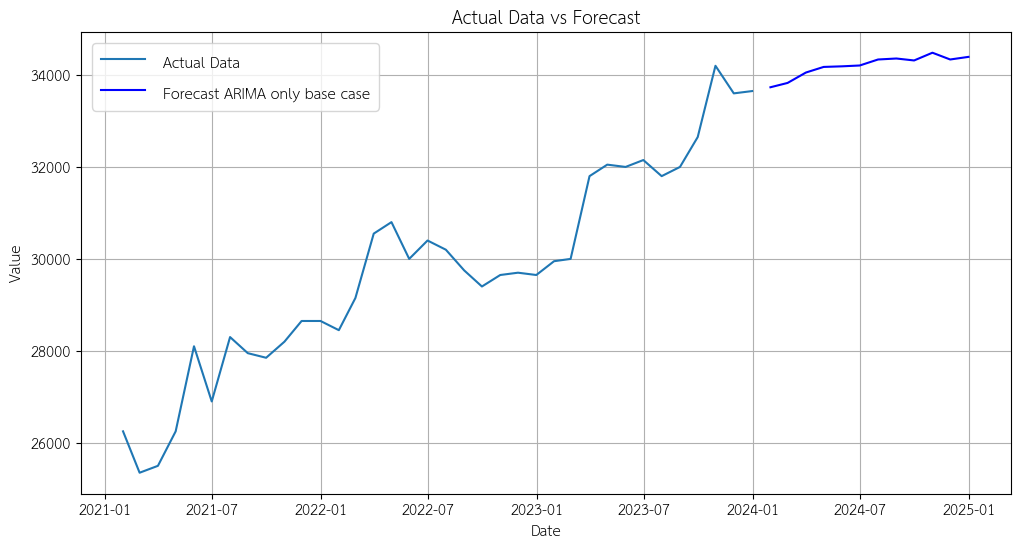

In [173]:
plt.figure(figsize=(12,6))
plt.plot(Gold_Factor_data['Report Date'] , (Gold_Factor_data['GoldBar_Sale'].values) , label = 'Actual Data')
plt.plot(Date_forecast_period , (arima_only_predict), label='Forecast ARIMA only base case' , color = 'blue')

# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_predict.iloc[0])][0],
#           color = 'orange',linestyle='--')
# plt.plot(Date_forecast_period , arima_only_best_case, label='Forecast ARIMA only best case' , color = 'green')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_best_case[0])][0],
#          color = 'orange',linestyle='--')
# plt.plot(Date_forecast_period , arima_only_worst_case, label='Forecast ARIMA only worst case' , color = 'red')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),arima_only_worst_case[0])][0], 
#          color = 'orange',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Polynomial Regression model

In [188]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
# GoldBar_Sale
poly_features = PolynomialFeatures(degree = 2,include_bias=False)
X_1 = Gold_Factor_data[['%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2','ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3','Inflation_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','LOG_PTT_แก๊สโซฮอล์_91_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1','%CHANGE_XAU_USD_LAG_1','CPI','Core_CPI','LOG_น้ำมัน_brent_USD_LAG_10','%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2','%CHANGE_Nasdaq_100_USD_LAG_3','%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1','LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10']]
y_GB_S = pd.DataFrame((Gold_Factor_data['GoldBar_Sale'].values))
X_poly_GB_S_1 = poly_features.fit_transform(X_1)
model_poly_GB_S_1 = LinearRegression()
model_poly_GB_S_1.fit(X_poly_GB_S_1,y_GB_S)
X_test_poly_GB_S_1 = poly_features.transform(X_1)
y_pred_poly_GB_S_1_test = model_poly_GB_S_1.predict(X_test_poly_GB_S_1)


X_test_poly = poly_features.transform(Factor_ARIMA[['%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2','ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3','Inflation_LAG_10','LOG_PTT_แก๊สโซฮอล์_95_LAG_1','LOG_PTT_แก๊สโซฮอล์_91_LAG_1','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1','%CHANGE_XAU_USD_LAG_1','CPI','Core_CPI','LOG_น้ำมัน_brent_USD_LAG_10','%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2','%CHANGE_Nasdaq_100_USD_LAG_3','%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1','LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10']])
y_pred_poly_GB_S_1 = model_poly_GB_S_1.predict(X_test_poly)

# poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GB_S = pd.DataFrame((Gold_Factor_data['GoldBar_Sale'].values))
# X_poly_GB_S_2 = poly_features.fit_transform(X_2)
# model_poly_GB_S_2 = LinearRegression()
# model_poly_GB_S_2.fit(X_poly_GB_S_2,y_GB_S)
# X_test_poly_GB_S_2 = poly_features.transform(X_2)
# y_pred_poly_GB_S_2_test = model_poly_GB_S_2.predict(X_test_poly_GB_S_2)


# X_test_poly = poly_features.transform(Factor_ARIMA[Factor_interested_2])
# y_pred_poly_GB_S_2 = model_poly_GB_S_2.predict(X_test_poly)
# # GoldBar_Buy
# poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X_1 = Gold_Factor_data[Factor_interested]
# y_GB_B = pd.DataFrame((Gold_Factor_data['GoldBar_Buy'].values))
# X_poly_GB_B_1 = poly_features.fit_transform(X_1)
# model_poly_GB_B_1 = LinearRegression()
# model_poly_GB_B_1.fit(X_poly_GB_B_1,y_GB_B)
# X_test_poly_GB_B_1 = poly_features.transform(X_1)
# y_pred_poly_GB_B_1_test = model_poly_GB_B_1.predict(X_test_poly_GB_B_1)


# X_test_poly = poly_features.transform(Factor_ARIMA[Factor_interested])
# y_pred_poly_GB_B_1 = model_poly_GB_B_1.predict(X_test_poly)

# poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GB_B = pd.DataFrame((Gold_Factor_data['GoldBar_Buy'].values))
# X_poly_GB_B_2 = poly_features.fit_transform(X_2)
# model_poly_GB_B_2 = LinearRegression()
# model_poly_GB_B_2.fit(X_poly_GB_B_2,y_GB_B)
# X_test_poly_GB_B_2 = poly_features.transform(X_2)
# y_pred_poly_GB_B_2_test = model_poly_GB_B_2.predict(X_test_poly_GB_B_2)

# X_test_poly = poly_features.transform(Factor_ARIMA[Factor_interested_2])
# y_pred_poly_GB_B_2 = model_poly_GB_B_2.predict(X_test_poly)

# # GoldJew_Buy
# poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X_1 = Gold_Factor_data[Factor_interested]
# y_GJ_B = pd.DataFrame((Gold_Factor_data['GoldJew_Buy'].values))
# X_poly_GJ_B_1 = poly_features.fit_transform(X_1)
# model_poly_GJ_B_1 = LinearRegression()
# model_poly_GJ_B_1.fit(X_poly_GJ_B_1,y_GJ_B)
# X_test_poly_GJ_B_1 = poly_features.transform(X_1)
# y_pred_poly_GJ_B_1_test = model_poly_GJ_B_1.predict(X_test_poly_GJ_B_1)


# X_test_poly = poly_features.transform(Factor_ARIMA[Factor_interested])
# y_pred_poly_GJ_B_1 = model_poly_GJ_B_1.predict(X_test_poly)

# poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GJ_B = pd.DataFrame((Gold_Factor_data['GoldJew_Buy'].values))
# X_poly_GJ_B_2 = poly_features.fit_transform(X_2)
# model_poly_GJ_B_2 = LinearRegression()
# model_poly_GJ_B_2.fit(X_poly_GJ_B_2,y_GJ_B)
# X_test_poly_GJ_B_2 = poly_features.transform(X_2)
# y_pred_poly_GJ_B_2_test = model_poly_GJ_B_2.predict(X_test_poly_GJ_B_2)

# X_test_poly = poly_features.transform(Factor_ARIMA[Factor_interested_2])
# y_pred_poly_GJ_B_2 = model_poly_GJ_B_2.predict(X_test_poly)

# # GoldJew_Sale
# poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X_1 = Gold_Factor_data[Factor_interested]
# y_GJ_S = pd.DataFrame((Gold_Factor_data['GoldJew_Sale'].values))
# X_poly_GJ_S_1 = poly_features.fit_transform(X_1)
# model_poly_GJ_S_1 = LinearRegression()
# model_poly_GJ_S_1.fit(X_poly_GJ_S_1,y_GJ_S)
# X_test_poly_GJ_S_1 = poly_features.transform(X_1)
# y_pred_poly_GJ_S_1_test = model_poly_GJ_S_1.predict(X_test_poly_GJ_S_1)


# X_test_poly = poly_features.transform(Factor_ARIMA[Factor_interested])
# y_pred_poly_GJ_S_1 = model_poly_GJ_S_1.predict(X_test_poly)

# poly_features = PolynomialFeatures(degree = 2,include_bias=False)
# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GJ_S = pd.DataFrame((Gold_Factor_data['GoldJew_Sale'].values))
# X_poly_GJ_S_2 = poly_features.fit_transform(X_2)
# model_poly_GJ_S_2 = LinearRegression()
# model_poly_GJ_S_2.fit(X_poly_GJ_S_2,y_GJ_S)
# X_test_poly_GJ_S_2 = poly_features.transform(X_2)
# y_pred_poly_GJ_S_2_test = model_poly_GJ_S_2.predict(X_test_poly_GJ_S_2)

# X_test_poly = poly_features.transform(Factor_ARIMA[Factor_interested_2])
# y_pred_poly_GJ_S_2 = model_poly_GJ_S_2.predict(X_test_poly)

#################################################################
# X_test_poly = poly_features.transform(output3_best[Factor_interested])
# y_pred_poly = model_poly.predict(X_test_poly)
# Predict_Poly_best = y_pred_poly
# X_test_poly = poly_features.transform(output3_worst[Factor_interested])
# y_pred_poly = model_poly.predict(X_test_poly)
# Predict_Poly_worst = y_pred_poly

In [175]:
print(f"{Factor_interested[0]}:" ,model_poly_GB_S_1.coef_[0][0])
print(f"{Factor_interested[1]}:" ,model_poly_GB_S_1.coef_[0][1])
print(f"{Factor_interested[2]}" ,model_poly_GB_S_1.coef_[0][2])
print(f"{Factor_interested[0]}**2 :" ,model_poly_GB_S_1.coef_[0][3])
print(f"{Factor_interested[0]} {Factor_interested[1]}" ,model_poly_GB_S_1.coef_[0][4])
print(f"{Factor_interested[0]} {Factor_interested[2]}" ,model_poly_GB_S_1.coef_[0][5])
print(f"{Factor_interested[1]}**2 :" ,model_poly_GB_S_1.coef_[0][6])
print(f"{Factor_interested[1]} {Factor_interested[2]}" ,model_poly_GB_S_1.coef_[0][7])
print(f"{Factor_interested[2]}**2" ,model_poly_GB_S_1.coef_[0][8])
print("Intercept : ", model_poly_GB_S_1.intercept_[0])
print("R-Squared : " ,model_poly_GB_S_1.score(X_poly_GB_S_1,y_GB_S))
print("MAE : ",metrics.mean_absolute_error((y_GB_S),(y_pred_poly_GB_S_1_test)))
print("MAPE : ",metrics.mean_absolute_percentage_error((y_GB_S),(y_pred_poly_GB_S_1_test)))
print("MSE : ",metrics.mean_squared_error((y_GB_S),(y_pred_poly_GB_S_1_test)))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error((y_GB_S),(y_pred_poly_GB_S_1_test))))

(Inflation)_LAG_10: 363.1374949901052
LOG_PTT_แก๊สโซฮอล์_95_LAG_1: 54800.78922226088
%CHANGE_XAU_USD_LAG_1 29861.880213919376
(Inflation)_LAG_10**2 : 14.289873779351183
(Inflation)_LAG_10 LOG_PTT_แก๊สโซฮอล์_95_LAG_1 157.009241323045
(Inflation)_LAG_10 %CHANGE_XAU_USD_LAG_1 543.721763250834
LOG_PTT_แก๊สโซฮอล์_95_LAG_1**2 : -6744.656001605797
LOG_PTT_แก๊สโซฮอล์_95_LAG_1 %CHANGE_XAU_USD_LAG_1 -7820.169912137578
%CHANGE_XAU_USD_LAG_1**2 42504.46736385738
Intercept :  -80606.11368617941
R-Squared :  0.9120459873202811
MAE :  501.72722715356696
MAPE :  0.016751611186491162
MSE :  437542.03080887604
RMSE :  661.4695993081436


In [176]:
Show_Poly = pd.DataFrame({
    'Detail of Model GoldBar_Sale Formula[1] Polynomial Regression' : [
        f'coef X1 of {Factor_interested[0]}',f'coef X2 of {Factor_interested[1]}',f'coef X3 of {Factor_interested[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value' : [
        model_poly_GB_S_1.coef_[0][0],model_poly_GB_S_1.coef_[0][1],model_poly_GB_S_1.coef_[0][2],
        model_poly_GB_S_1.coef_[0][3],model_poly_GB_S_1.coef_[0][4],model_poly_GB_S_1.coef_[0][5],
        model_poly_GB_S_1.coef_[0][6],model_poly_GB_S_1.coef_[0][7],model_poly_GB_S_1.coef_[0][8],
        model_poly_GB_S_1.intercept_[0],model_poly_GB_S_1.score(X_poly_GB_S_1,y_GB_S),
         1 - (((1 - model_poly_GB_S_1.score(X_poly_GB_S_1,y_GB_S))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GB_S),(y_pred_poly_GB_S_1_test)),
        metrics.mean_absolute_percentage_error((y_GB_S),(y_pred_poly_GB_S_1_test)),
        metrics.mean_squared_error((y_GB_S),(y_pred_poly_GB_S_1_test)),
        np.sqrt(metrics.mean_squared_error((y_GB_S),(y_pred_poly_GB_S_1_test)))
    ],
    'Detail of Model GoldBar_Sale Formula[2] Polynomial Regression' : [
        f'coef X1 of {Factor_interested_2[0]}',f'coef X2 of {Factor_interested_2[1]}',f'coef X3 of {Factor_interested_2[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value 2' : [
        model_poly_GB_S_2.coef_[0][0],model_poly_GB_S_2.coef_[0][1],model_poly_GB_S_2.coef_[0][2],
        model_poly_GB_S_2.coef_[0][3],model_poly_GB_S_2.coef_[0][4],model_poly_GB_S_2.coef_[0][5],
        model_poly_GB_S_2.coef_[0][6],model_poly_GB_S_2.coef_[0][7],model_poly_GB_S_2.coef_[0][8],
        model_poly_GB_S_2.intercept_[0],model_poly_GB_S_2.score(X_poly_GB_S_2,y_GB_S),
         1 - (((1 - model_poly_GB_S_2.score(X_poly_GB_S_2,y_GB_S))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GB_S),(y_pred_poly_GB_S_2_test)),
        metrics.mean_absolute_percentage_error((y_GB_S),(y_pred_poly_GB_S_2_test)),
        metrics.mean_squared_error((y_GB_S),(y_pred_poly_GB_S_2_test)),
        np.sqrt(metrics.mean_squared_error((y_GB_S),(y_pred_poly_GB_S_2_test)))
    ]
    
})
Show_Poly

Detail of Model GoldBar_Sale Formula[1] Polynomial Regression  \
0                       coef X1 of (Inflation)_LAG_10              
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1              
2                    coef X3 of %CHANGE_XAU_USD_LAG_1              
3                                       coef of X1**2              
4                                        coef of X1X2              
5                                        coef of X1X3              
6                                       coef of X2**2              
7                                        coef of X2X3              
8                                       coef of X3**2              
9                                           Intercept              
10                                          R-squared              
11                                      Adj-R-squared              
12                                                MAE              
13                                               MAPE              
14                                                MSE              
15                                               RMSE              

            Value  \
0      363.137495   
1    54800.789222   
2    29861.880214   
3       14.289874   
4      157.009241   
5      543.721763   
6    -6744.656002   
7    -7820.169912   
8    42504.467364   
9   -80606.113686   
10       0.912046   
11       0.903800   
12     501.727227   
13       0.016752   
14  437542.030809   
15     661.469599   

   Detail of Model GoldBar_Sale Formula[2] Polynomial Regression  \
0                       coef X1 of (Inflation)_LAG_10              
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1              
2    coef X3 of %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2              
3                                       coef of X1**2              
4                                        coef of X1X2              
5                                        coef of X1X3              
6                                       coef of X2**2              
7                                        coef of X2X3              
8                                       coef of X3**2              
9                                           Intercept              
10                                          R-squared              
11                                      Adj-R-squared              
12                                                MAE              
13                                               MAPE              
14                                                MSE              
15                                               RMSE              

          Value 2  
0    -6684.763794  
1    42574.951420  
2   -12295.860014  
3     -195.569574  
4     2289.519571  
5      518.966098  
6    -4968.210902  
7     2255.077850  
8  -152040.657216  
9   -59322.817604  
10       0.909638  
11       0.901166  
12     470.337247  
13       0.015688  
14  449522.130941  
15     670.464116

In [177]:
Show_Poly = pd.DataFrame({
    'Detail of Model GoldBar_Buy Formula[1] Polynomial Regression' : [
        f'coef X1 of {Factor_interested[0]}',f'coef X2 of {Factor_interested[1]}',f'coef X3 of {Factor_interested[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value' : [
        model_poly_GB_B_1.coef_[0][0],model_poly_GB_B_1.coef_[0][1],model_poly_GB_B_1.coef_[0][2],
        model_poly_GB_B_1.coef_[0][3],model_poly_GB_B_1.coef_[0][4],model_poly_GB_B_1.coef_[0][5],
        model_poly_GB_B_1.coef_[0][6],model_poly_GB_B_1.coef_[0][7],model_poly_GB_B_1.coef_[0][8],
        model_poly_GB_B_1.intercept_[0],model_poly_GB_B_1.score(X_poly_GB_B_1,y_GB_B),
         1 - (((1 - model_poly_GB_B_1.score(X_poly_GB_B_1,y_GB_B))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GB_B),(y_pred_poly_GB_B_1_test)),
        metrics.mean_absolute_percentage_error((y_GB_B),(y_pred_poly_GB_B_1_test)),
        metrics.mean_squared_error((y_GB_B),(y_pred_poly_GB_B_1_test)),
        np.sqrt(metrics.mean_squared_error((y_GB_B),(y_pred_poly_GB_B_1_test)))
    ],
    'Detail of Model GoldBar_Buy Formula[2] Polynomial Regression' : [
        f'coef X1 of {Factor_interested_2[0]}',f'coef X2 of {Factor_interested_2[1]}',f'coef X3 of {Factor_interested_2[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value 2' : [
        model_poly_GB_B_2.coef_[0][0],model_poly_GB_B_2.coef_[0][1],model_poly_GB_B_2.coef_[0][2],
        model_poly_GB_B_2.coef_[0][3],model_poly_GB_B_2.coef_[0][4],model_poly_GB_B_2.coef_[0][5],
        model_poly_GB_B_2.coef_[0][6],model_poly_GB_B_2.coef_[0][7],model_poly_GB_B_2.coef_[0][8],
        model_poly_GB_B_2.intercept_[0],model_poly_GB_B_2.score(X_poly_GB_B_2,y_GB_B),
         1 - (((1 - model_poly_GB_B_2.score(X_poly_GB_B_2,y_GB_B))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GB_B),(y_pred_poly_GB_B_2_test)),
        metrics.mean_absolute_percentage_error((y_GB_B),(y_pred_poly_GB_B_2_test)),
        metrics.mean_squared_error((y_GB_B),(y_pred_poly_GB_B_2_test)),
        np.sqrt(metrics.mean_squared_error((y_GB_B),(y_pred_poly_GB_B_2_test)))
    ]
    
})
Show_Poly

Detail of Model GoldBar_Buy Formula[1] Polynomial Regression  \
0                       coef X1 of (Inflation)_LAG_10             
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1             
2                    coef X3 of %CHANGE_XAU_USD_LAG_1             
3                                       coef of X1**2             
4                                        coef of X1X2             
5                                        coef of X1X3             
6                                       coef of X2**2             
7                                        coef of X2X3             
8                                       coef of X3**2             
9                                           Intercept             
10                                          R-squared             
11                                      Adj-R-squared             
12                                                MAE             
13                                               MAPE             
14                                                MSE             
15                                               RMSE             

            Value  \
0      363.137495   
1    54800.789222   
2    29861.880214   
3       14.289874   
4      157.009241   
5      543.721763   
6    -6744.656002   
7    -7820.169912   
8    42504.467364   
9   -80706.113686   
10       0.912046   
11       0.903800   
12     501.727227   
13       0.016808   
14  437542.030809   
15     661.469599   

   Detail of Model GoldBar_Buy Formula[2] Polynomial Regression        Value 2  
0                       coef X1 of (Inflation)_LAG_10             -6684.763794  
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1             42574.951420  
2    coef X3 of %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2            -12295.860014  
3                                       coef of X1**2              -195.569574  
4                                        coef of X1X2              2289.519571  
5                                        coef of X1X3               518.966098  
6                                       coef of X2**2             -4968.210902  
7                                        coef of X2X3              2255.077850  
8                                       coef of X3**2           -152040.657216  
9                                           Intercept            -59422.817604  
10                                          R-squared                 0.909638  
11                                      Adj-R-squared                 0.901166  
12                                                MAE               470.337247  
13                                               MAPE                 0.015741  
14                                                MSE            449522.130941  
15                                               RMSE               670.464116

In [178]:
Show_Poly = pd.DataFrame({
    'Detail of Model GoldJew_Sale Formula[1] Polynomial Regression' : [
        f'coef X1 of {Factor_interested[0]}',f'coef X2 of {Factor_interested[1]}',f'coef X3 of {Factor_interested[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value' : [
        model_poly_GJ_S_1.coef_[0][0],model_poly_GJ_S_1.coef_[0][1],model_poly_GJ_S_1.coef_[0][2],
        model_poly_GJ_S_1.coef_[0][3],model_poly_GJ_S_1.coef_[0][4],model_poly_GJ_S_1.coef_[0][5],
        model_poly_GJ_S_1.coef_[0][6],model_poly_GJ_S_1.coef_[0][7],model_poly_GJ_S_1.coef_[0][8],
        model_poly_GJ_S_1.intercept_[0],model_poly_GJ_S_1.score(X_poly_GJ_S_1,y_GJ_S),
         1 - (((1 - model_poly_GJ_S_1.score(X_poly_GB_S_1,y_GJ_S))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GJ_S),(y_pred_poly_GJ_S_1_test)),
        metrics.mean_absolute_percentage_error((y_GJ_S),(y_pred_poly_GJ_S_1_test)),
        metrics.mean_squared_error((y_GJ_S),(y_pred_poly_GJ_S_1_test)),
        np.sqrt(metrics.mean_squared_error((y_GJ_S),(y_pred_poly_GJ_S_1_test)))
    ],
    'Detail of Model GoldJew_Sale Formula[2] Polynomial Regression' : [
        f'coef X1 of {Factor_interested_2[0]}',f'coef X2 of {Factor_interested_2[1]}',f'coef X3 of {Factor_interested_2[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value 2' : [
        model_poly_GJ_S_2.coef_[0][0],model_poly_GJ_S_2.coef_[0][1],model_poly_GJ_S_2.coef_[0][2],
        model_poly_GJ_S_2.coef_[0][3],model_poly_GJ_S_2.coef_[0][4],model_poly_GJ_S_2.coef_[0][5],
        model_poly_GJ_S_2.coef_[0][6],model_poly_GJ_S_2.coef_[0][7],model_poly_GJ_S_2.coef_[0][8],
        model_poly_GJ_S_2.intercept_[0],model_poly_GJ_S_2.score(X_poly_GJ_S_2,y_GJ_S),
         1 - (((1 - model_poly_GJ_S_2.score(X_poly_GJ_S_2,y_GJ_S))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GJ_S),(y_pred_poly_GJ_S_2_test)),
        metrics.mean_absolute_percentage_error((y_GJ_S),(y_pred_poly_GJ_S_2_test)),
        metrics.mean_squared_error((y_GJ_S),(y_pred_poly_GJ_S_2_test)),
        np.sqrt(metrics.mean_squared_error((y_GJ_S),(y_pred_poly_GJ_S_2_test)))
    ]
    
})
Show_Poly

Detail of Model GoldJew_Sale Formula[1] Polynomial Regression  \
0                       coef X1 of (Inflation)_LAG_10              
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1              
2                    coef X3 of %CHANGE_XAU_USD_LAG_1              
3                                       coef of X1**2              
4                                        coef of X1X2              
5                                        coef of X1X3              
6                                       coef of X2**2              
7                                        coef of X2X3              
8                                       coef of X3**2              
9                                           Intercept              
10                                          R-squared              
11                                      Adj-R-squared              
12                                                MAE              
13                                               MAPE              
14                                                MSE              
15                                               RMSE              

            Value  \
0      363.137495   
1    54800.789222   
2    29861.880214   
3       14.289874   
4      157.009241   
5      543.721763   
6    -6744.656002   
7    -7820.169912   
8    42504.467364   
9   -80106.113686   
10       0.912046   
11       0.903800   
12     501.727227   
13       0.016474   
14  437542.030809   
15     661.469599   

   Detail of Model GoldJew_Sale Formula[2] Polynomial Regression  \
0                       coef X1 of (Inflation)_LAG_10              
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1              
2    coef X3 of %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2              
3                                       coef of X1**2              
4                                        coef of X1X2              
5                                        coef of X1X3              
6                                       coef of X2**2              
7                                        coef of X2X3              
8                                       coef of X3**2              
9                                           Intercept              
10                                          R-squared              
11                                      Adj-R-squared              
12                                                MAE              
13                                               MAPE              
14                                                MSE              
15                                               RMSE              

          Value 2  
0    -6684.763794  
1    42574.951420  
2   -12295.860014  
3     -195.569574  
4     2289.519571  
5      518.966098  
6    -4968.210902  
7     2255.077850  
8  -152040.657216  
9   -58822.817604  
10       0.909638  
11       0.901166  
12     470.337247  
13       0.015429  
14  449522.130941  
15     670.464116

In [179]:
Show_Poly = pd.DataFrame({
    'Detail of Model GoldJew_Buy Formula[1] Polynomial Regression' : [
        f'coef X1 of {Factor_interested[0]}',f'coef X2 of {Factor_interested[1]}',f'coef X3 of {Factor_interested[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value' : [
        model_poly_GJ_B_1.coef_[0][0],model_poly_GJ_B_1.coef_[0][1],model_poly_GJ_B_1.coef_[0][2],
        model_poly_GJ_B_1.coef_[0][3],model_poly_GJ_B_1.coef_[0][4],model_poly_GJ_B_1.coef_[0][5],
        model_poly_GJ_B_1.coef_[0][6],model_poly_GJ_B_1.coef_[0][7],model_poly_GJ_B_1.coef_[0][8],
        model_poly_GJ_B_1.intercept_[0],model_poly_GJ_B_1.score(X_poly_GJ_B_1,y_GJ_B),
         1 - (((1 - model_poly_GJ_B_1.score(X_poly_GB_B_1,y_GJ_B))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GJ_B),(y_pred_poly_GJ_B_1_test)),
        metrics.mean_absolute_percentage_error((y_GJ_B),(y_pred_poly_GJ_B_1_test)),
        metrics.mean_squared_error((y_GJ_B),(y_pred_poly_GJ_B_1_test)),
        np.sqrt(metrics.mean_squared_error((y_GJ_B),(y_pred_poly_GJ_B_1_test)))
    ],
    'Detail of Model GoldJew_Buy Formula[2] Polynomial Regression' : [
        f'coef X1 of {Factor_interested_2[0]}',f'coef X2 of {Factor_interested_2[1]}',f'coef X3 of {Factor_interested_2[2]}',
        f'coef of X1**2','coef of X1X2','coef of X1X3',
        'coef of X2**2','coef of X2X3','coef of X3**2',
        'Intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'],
    'Value 2' : [
        model_poly_GJ_B_2.coef_[0][0],model_poly_GJ_B_2.coef_[0][1],model_poly_GJ_B_2.coef_[0][2],
        model_poly_GJ_B_2.coef_[0][3],model_poly_GJ_B_2.coef_[0][4],model_poly_GJ_B_2.coef_[0][5],
        model_poly_GJ_B_2.coef_[0][6],model_poly_GJ_B_2.coef_[0][7],model_poly_GJ_B_2.coef_[0][8],
        model_poly_GJ_B_2.intercept_[0],model_poly_GJ_B_2.score(X_poly_GJ_B_2,y_GJ_B),
         1 - (((1 - model_poly_GJ_B_2.score(X_poly_GJ_B_2,y_GJ_B))*(36 - 1)) / (36 - 3 - 1)),
        metrics.mean_absolute_error((y_GJ_B),(y_pred_poly_GJ_B_2_test)),
        metrics.mean_absolute_percentage_error((y_GJ_B),(y_pred_poly_GJ_B_2_test)),
        metrics.mean_squared_error((y_GJ_B),(y_pred_poly_GJ_B_2_test)),
        np.sqrt(metrics.mean_squared_error((y_GJ_B),(y_pred_poly_GJ_B_2_test)))
    ]
    
})
Show_Poly

Detail of Model GoldJew_Buy Formula[1] Polynomial Regression  \
0                       coef X1 of (Inflation)_LAG_10             
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1             
2                    coef X3 of %CHANGE_XAU_USD_LAG_1             
3                                       coef of X1**2             
4                                        coef of X1X2             
5                                        coef of X1X3             
6                                       coef of X2**2             
7                                        coef of X2X3             
8                                       coef of X3**2             
9                                           Intercept             
10                                          R-squared             
11                                      Adj-R-squared             
12                                                MAE             
13                                               MAPE             
14                                                MSE             
15                                               RMSE             

            Value  \
0      350.055888   
1    53459.856928   
2    29730.383679   
3       12.251084   
4      157.277269   
5      540.378570   
6    -6571.553688   
7    -7797.453431   
8    41461.073261   
9   -78646.521028   
10       0.911921   
11       0.903663   
12     492.581804   
13       0.016803   
14  422169.258372   
15     649.745534   

   Detail of Model GoldJew_Buy Formula[2] Polynomial Regression        Value 2  
0                       coef X1 of (Inflation)_LAG_10             -6568.111953  
1              coef X2 of LOG_PTT_แก๊สโซฮอล์_95_LAG_1             41612.344699  
2    coef X3 of %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2            -12590.240936  
3                                       coef of X1**2              -193.811015  
4                                        coef of X1X2              2250.870094  
5                                        coef of X1X3               464.129495  
6                                       coef of X2**2             -4851.126992  
7                                        coef of X2X3              2382.422659  
8                                       coef of X3**2           -149548.795640  
9                                           Intercept            -58007.456350  
10                                          R-squared                 0.909633  
11                                      Adj-R-squared                 0.901161  
12                                                MAE               462.128886  
13                                               MAPE                 0.015749  
14                                                MSE            433136.935729  
15                                               RMSE               658.131397

In [180]:
poly_features.get_params()

{'degree': 2, 'include_bias': False, 'interaction_only': False, 'order': 'C'}

In [181]:
poly_features.get_feature_names_out

<bound method PolynomialFeatures.get_feature_names_out of PolynomialFeatures(include_bias=False)>

In [182]:
# np.exp(model_poly.intercept_[0] + (Gold_Factor_data[Factor_interested[0]].iloc[0] * 6.18374644e+00) +\
#     (Gold_Factor_data[Factor_interested[1]].iloc[0] * 2.62237234e+01) +\
#     (Gold_Factor_data[Factor_interested[2]].iloc[0] * (-5.75168231e+01)) +\
#     ((Gold_Factor_data[Factor_interested[0]].iloc[0]**2)*6.38496289e-03) +\
#     (Gold_Factor_data[Factor_interested[0]].iloc[0]*Gold_Factor_data[Factor_interested[1]].iloc[0] * 7.69233117e-03) +\
#     (Gold_Factor_data[Factor_interested[0]].iloc[0]*Gold_Factor_data[Factor_interested[2]].iloc[0] * (-1.3352649160175005)) +\
#     ((Gold_Factor_data[Factor_interested[1]].iloc[0]**2)*(-7.79055187e-01)) +\
#     (Gold_Factor_data[Factor_interested[1]].iloc[0] * Gold_Factor_data[Factor_interested[2]].iloc[0] * (-5.60613772e+00)) +\
#     ((Gold_Factor_data[Factor_interested[2]].iloc[0]**2) * 6.56816465e+00))

In [183]:
# test_w = pd.DataFrame()
# test_w['Actual'] = Gold_Factor_data['GoldBar_Sale'].values
# test_w['Pred'] =  (y_pred_poly_test)
# test_w['Diff'] = test_w['Actual'] - test_w['Pred']
# test_w['MAE'] = sum(abs(test_w['Actual'] - test_w['Pred']))/36
# print("MAE")
# test_w


In [184]:
# (Predict_Poly).mean() # MEAN

In [185]:
# np.exp(Predict_Poly)
# Gold_Factor_data['Report Date']
# Date_forecast_period
# [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),Predict_Poly[0][0])][0]

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

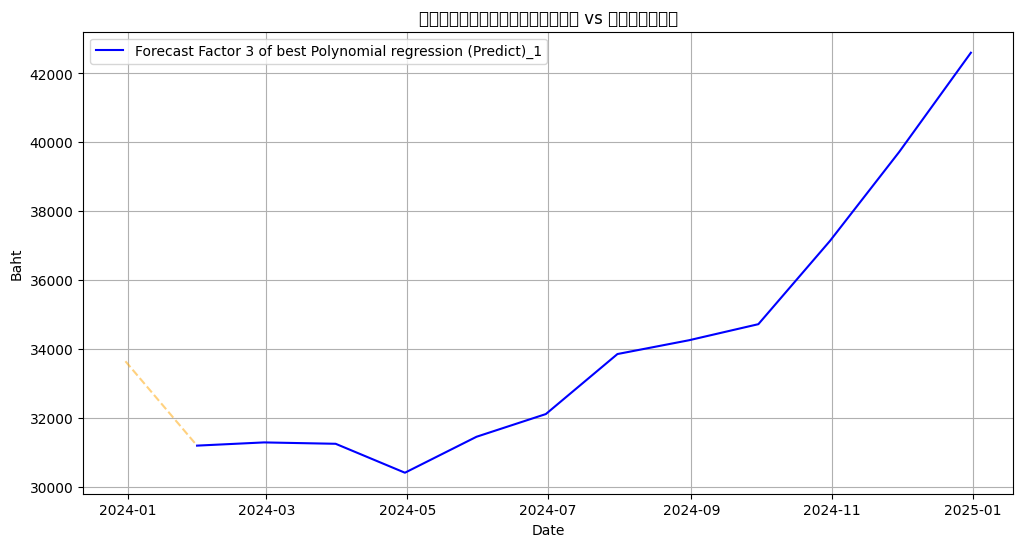

In [189]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldBar_Sale'] , label = 'ราคาขายทองคำแท่ง')
# plt.plot(Gold_Factor_data['Report Date'],(y_pred_poly_GB_S_1_test), label='Forecast Factor 3 of best Polynomial regression (Regression)' , color = 'purple')
plt.plot(Date_forecast_period,(y_pred_poly_GB_S_1), label='Forecast Factor 3 of best Polynomial regression (Predict)_1' , color = 'blue')
# plt.plot(Date_forecast_period,(y_pred_poly_GB_S_2), label='Forecast Factor 3 of best Polynomial regression (Predict)_2' , color = 'red')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),(y_pred_poly_GB_S_1[0][0]))][0], 
         color = 'orange',linestyle='--',alpha=0.5)
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),(y_pred_poly_GB_S_2[0][0]))][0], 
#          color = 'orange',linestyle='--',alpha=0.5)
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_best), label='Forecast Factor 3 of best Polynomial regression (Predict) Best case' , color = 'green')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_best[0][0]))][0], 
#          color = 'orange',linestyle='--')
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_worst), label='Forecast Factor 3 of best Polynomial regression (Predict) Worst case' , color = 'red')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_worst[0][0]))][0], 
#          color = 'orange',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคาขายทองคำแท่ง vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [187]:
Show_Poly_prediic = pd.DataFrame({
    'Date' : [i for i in Date_forecast_period['Report Date']],
    'Predict_1 of GoldBar_Sale': [i[0] for i in y_pred_poly_GB_S_1],
    'Predict_2 of GoldBar_Sale': [i[0] for i in y_pred_poly_GB_S_2]
})
Show_Poly_prediic

Date  Predict_1 of GoldBar_Sale  Predict_2 of GoldBar_Sale
0  2024-01-31               30631.567725               31115.066834
1  2024-02-29               30740.339633               31153.005926
2  2024-03-31               30468.057249               31039.050035
3  2024-04-30               30249.170494               30771.928712
4  2024-05-31               29931.697482               30275.576813
5  2024-06-30               29686.843807               30154.975560
6  2024-07-31               29623.837228               29899.108192
7  2024-08-31               29651.652276               30015.196163
8  2024-09-30               29409.943235               29591.042379
9  2024-10-31               29529.452437               29735.678742
10 2024-11-30               29678.878989               29611.783104
11 2024-12-31               30650.361909               30213.777421

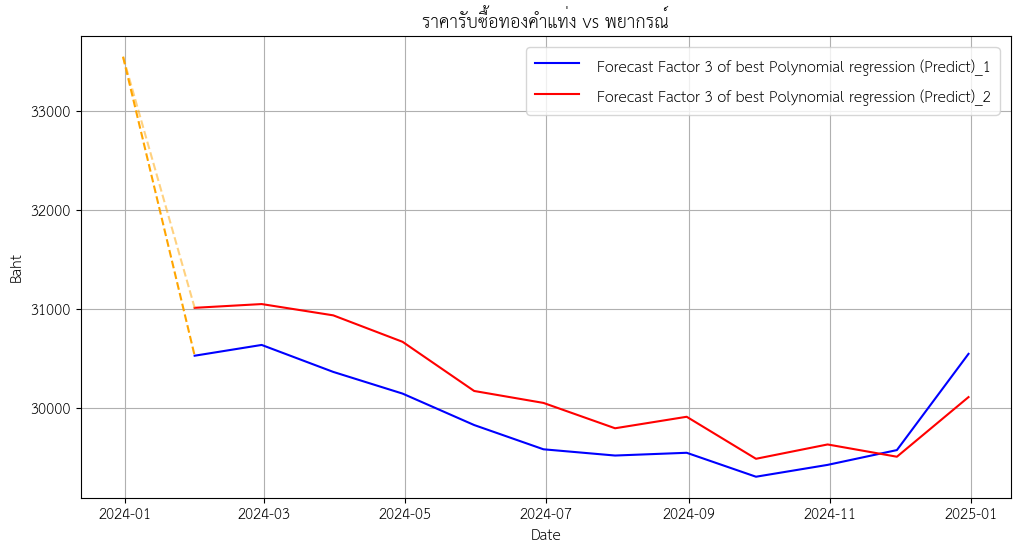

In [188]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldBar_Buy'] , label = 'ราคารับซื้อทองคำแท่ง')
# plt.plot(Gold_Factor_data['Report Date'],(y_pred_poly_GB_S_1_test), label='Forecast Factor 3 of best Polynomial regression (Regression)' , color = 'purple')
plt.plot(Date_forecast_period,(y_pred_poly_GB_B_1), label='Forecast Factor 3 of best Polynomial regression (Predict)_1' , color = 'blue')
plt.plot(Date_forecast_period,(y_pred_poly_GB_B_2), label='Forecast Factor 3 of best Polynomial regression (Predict)_2' , color = 'red')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Buy'].iloc[-1].astype(float),(y_pred_poly_GB_B_1[0][0]))][0], 
         color = 'orange',linestyle='--')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Buy'].iloc[-1].astype(float),(y_pred_poly_GB_B_2[0][0]))][0], 
         color = 'orange',linestyle='--',alpha=0.5)
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_best), label='Forecast Factor 3 of best Polynomial regression (Predict) Best case' , color = 'green')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_best[0][0]))][0], 
#          color = 'orange',linestyle='--')
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_worst), label='Forecast Factor 3 of best Polynomial regression (Predict) Worst case' , color = 'red')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_worst[0][0]))][0], 
#          color = 'orange',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคารับซื้อทองคำแท่ง vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [189]:
Show_Poly_prediic = pd.DataFrame({
    'Date' : [i for i in Date_forecast_period['Report Date']],
    'Predict_1 of GoldBar_Buy': [i[0] for i in y_pred_poly_GB_B_1],
    'Predict_2 of GoldBar_Buy': [i[0] for i in y_pred_poly_GB_B_2]
})
Show_Poly_prediic

Date  Predict_1 of GoldBar_Buy  Predict_2 of GoldBar_Buy
0  2024-01-31              30531.567725              31015.066834
1  2024-02-29              30640.339633              31053.005926
2  2024-03-31              30368.057249              30939.050035
3  2024-04-30              30149.170494              30671.928712
4  2024-05-31              29831.697482              30175.576813
5  2024-06-30              29586.843807              30054.975560
6  2024-07-31              29523.837228              29799.108192
7  2024-08-31              29551.652276              29915.196163
8  2024-09-30              29309.943235              29491.042379
9  2024-10-31              29429.452437              29635.678742
10 2024-11-30              29578.878989              29511.783104
11 2024-12-31              30550.361909              30113.777421

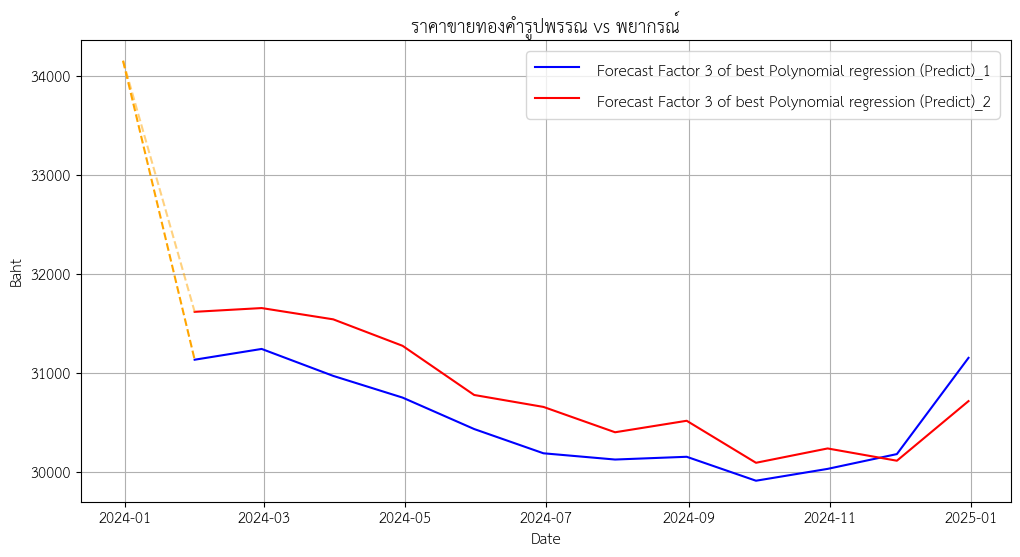

In [190]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldJew_Sale'] , label = 'ราคาขายทองคำรูปพรรณ')
# plt.plot(Gold_Factor_data['Report Date'],(y_pred_poly_GB_S_1_test), label='Forecast Factor 3 of best Polynomial regression (Regression)' , color = 'purple')
plt.plot(Date_forecast_period,(y_pred_poly_GJ_S_1), label='Forecast Factor 3 of best Polynomial regression (Predict)_1' , color = 'blue')
plt.plot(Date_forecast_period,(y_pred_poly_GJ_S_2), label='Forecast Factor 3 of best Polynomial regression (Predict)_2' , color = 'red')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Sale'].iloc[-1].astype(float),(y_pred_poly_GJ_S_1[0][0]))][0], 
         color = 'orange',linestyle='--')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Sale'].iloc[-1].astype(float),(y_pred_poly_GJ_S_2[0][0]))][0], 
         color = 'orange',linestyle='--',alpha=0.5)
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_best), label='Forecast Factor 3 of best Polynomial regression (Predict) Best case' , color = 'green')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_best[0][0]))][0], 
#          color = 'orange',linestyle='--')
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_worst), label='Forecast Factor 3 of best Polynomial regression (Predict) Worst case' , color = 'red')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_worst[0][0]))][0], 
#          color = 'orange',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคาขายทองคำรูปพรรณ vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [191]:
Show_Poly_prediic = pd.DataFrame({
    'Date' : [i for i in Date_forecast_period['Report Date']],
    'Predict_1 of GoldJew_Sale': [i[0] for i in y_pred_poly_GJ_S_1],
    'Predict_2 of GoldJew_Sale': [i[0] for i in y_pred_poly_GJ_S_2]
})
Show_Poly_prediic

Date  Predict_1 of GoldJew_Sale  Predict_2 of GoldJew_Sale
0  2024-01-31               31131.567725               31615.066834
1  2024-02-29               31240.339633               31653.005926
2  2024-03-31               30968.057249               31539.050035
3  2024-04-30               30749.170494               31271.928712
4  2024-05-31               30431.697482               30775.576813
5  2024-06-30               30186.843807               30654.975560
6  2024-07-31               30123.837228               30399.108192
7  2024-08-31               30151.652276               30515.196163
8  2024-09-30               29909.943235               30091.042379
9  2024-10-31               30029.452437               30235.678742
10 2024-11-30               30178.878989               30111.783104
11 2024-12-31               31150.361909               30713.777421

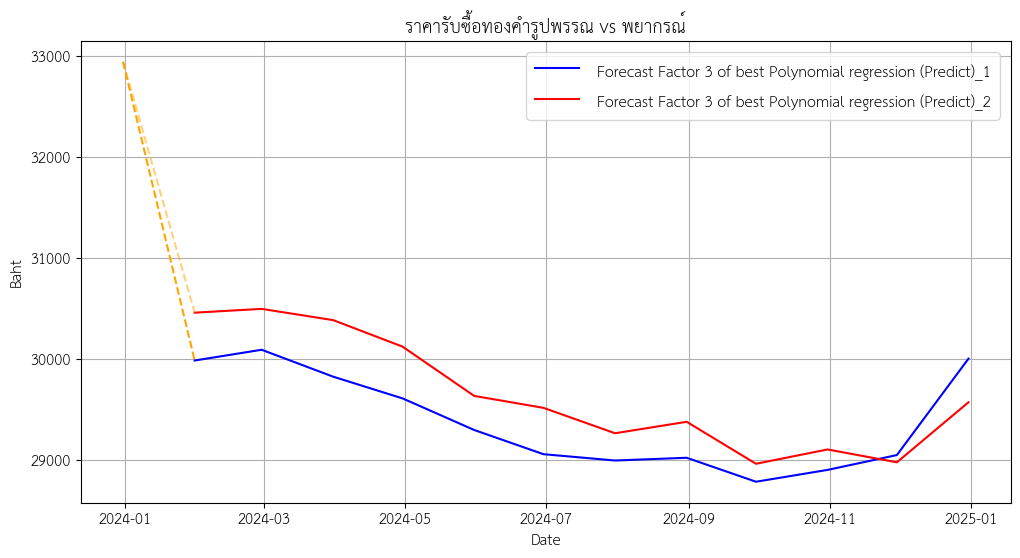

In [192]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldJew_Buy'] , label = 'ราคารับซื้อทองคำรูปพรรณ')
# plt.plot(Gold_Factor_data['Report Date'],(y_pred_poly_GB_S_1_test), label='Forecast Factor 3 of best Polynomial regression (Regression)' , color = 'purple')
plt.plot(Date_forecast_period,(y_pred_poly_GJ_B_1), label='Forecast Factor 3 of best Polynomial regression (Predict)_1' , color = 'blue')
plt.plot(Date_forecast_period,(y_pred_poly_GJ_B_2), label='Forecast Factor 3 of best Polynomial regression (Predict)_2' , color = 'red')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Buy'].iloc[-1].astype(float),(y_pred_poly_GJ_B_1[0][0]))][0], 
         color = 'orange',linestyle='--')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Buy'].iloc[-1].astype(float),(y_pred_poly_GJ_B_2[0][0]))][0], 
         color = 'orange',linestyle='--',alpha=0.5)
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_best), label='Forecast Factor 3 of best Polynomial regression (Predict) Best case' , color = 'green')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_best[0][0]))][0], 
#          color = 'orange',linestyle='--')
# plt.plot(Date_forecast_period,np.exp(Predict_Poly_worst), label='Forecast Factor 3 of best Polynomial regression (Predict) Worst case' , color = 'red')
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),np.exp(Predict_Poly_worst[0][0]))][0], 
#          color = 'orange',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคารับซื้อทองคำรูปพรรณ vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
Show_Poly_prediic = pd.DataFrame({
    'Date' : [i for i in Date_forecast_period['Report Date']],
    'Predict_1 of GoldJew_Buy': [i[0] for i in y_pred_poly_GJ_B_1],
    'Predict_2 of GoldJew_Buy': [i[0] for i in y_pred_poly_GJ_B_2]
})
Show_Poly_prediic

Date  Predict_1 of GoldJew_Buy  Predict_2 of GoldJew_Buy
0  2024-01-31              29984.301663              30457.889884
1  2024-02-29              30090.702642              30495.611322
2  2024-03-31              29823.953300              30383.900914
3  2024-04-30              29609.164548              30121.741869
4  2024-05-31              29296.463897              29633.850672
5  2024-06-30              29056.700573              29515.498117
6  2024-07-31              28994.170223              29264.170459
7  2024-08-31              29021.245228              29377.544297
8  2024-09-30              28784.122369              28961.831374
9  2024-10-31              28901.136009              29103.568122
10 2024-11-30              29048.227511              28976.374950
11 2024-12-31              30002.734886              29571.062044

# Linear Regression # only 4 segments

In [76]:
Factor_ARIMA

Report Date  อัตราแลกเปลี่ยน_USD_THB  PTT_แก๊สโซฮอล์_95      XAU_USD  \
0   2021-01-31                29.860000          24.250000  1282.090000   
1   2021-02-28                30.470000          26.050000  1327.190000   
2   2021-03-31                31.240000          26.150000  1250.690000   
3   2021-04-30                31.140000          29.050000  1291.290000   
4   2021-05-31                31.190000          27.950000  1283.640000   
5   2021-06-30                32.020000          28.750000  1325.790000   
6   2021-07-31                32.890000          29.550000  1243.190000   
7   2021-08-30                32.220000          29.250000  1204.940000   
8   2021-09-30                33.670000          30.750000  1251.990000   
9   2021-10-31                33.290000          32.550000  1323.190000   
10  2021-11-29                33.710000          31.050000  1326.940000   
11  2021-12-31                33.230000          31.150000  1395.690000   
12  2022-01-31                33.220000          34.050000  1322.490000   
13  2022-02-28                32.670000          36.550000  1233.140000   
14  2022-03-31                33.280000          40.050000  1386.400000   
15  2022-04-30                34.240000          38.850000  1476.600000   
16  2022-05-30                34.300000          43.850000  1596.170000   
17  2022-06-30                35.300000          44.650000  1579.760000   
18  2022-07-31                36.290000          37.850000  1662.990000   
19  2022-08-31                36.520000          37.950000  1674.340000   
20  2022-09-30                37.770000          33.750000  1714.400000   
21  2022-10-31                38.050000          35.350000  1720.550000   
22  2022-11-30                35.110000          35.150000  1771.220000   
23  2022-12-31                34.610000          34.450000  1691.150000   
24  2023-01-30                32.840000          36.650000  1613.900000   
25  2023-02-27                35.220000          35.850000  1598.600000   
26  2023-03-31                34.160000          35.750000  1560.700000   
27  2023-04-30                34.120000          35.950000  1664.360000   
28  2023-05-31                34.640000          35.450000  1668.900000   
29  2023-06-30                35.270000          35.150000  1695.200000   
30  2023-07-31                34.210000          37.950000  1739.430000   
31  2023-08-31                34.980000          40.050000  1564.300000   
32  2023-09-30                36.510000          39.450000  1745.700000   
33  2023-10-30                36.140000          38.250000  1715.250000   
34  2023-11-30                35.310000          36.050000  1623.750000   
35  2023-12-31                34.350000          35.250000  1823.800000   
0   2024-01-31                33.719218          35.058925  1774.429060   
1   2024-02-29                33.734965          35.013840  1845.325596   
2   2024-03-31                33.682028          35.043293  1861.604874   
3   2024-04-30                34.146762          34.983292  1876.809274   
4   2024-05-31                34.106081          35.008786  1948.336574   
5   2024-06-30                34.766779          35.012667  1922.288174   
6   2024-07-31                34.944147          34.776649  1958.977213   
7   2024-08-31                35.086973          34.526549  2016.115079   
8   2024-09-30                36.139429          34.663558  2009.642104   
9   2024-10-31                35.993492          34.766101  2058.159290   
10  2024-11-30                33.515147          35.040886  2107.067360   
11  2024-12-31                32.701320          35.151062  2136.240366   

    PTT_แก๊สโซฮอล์_91    Core_CPI  ราคาน้ำมันดิบ_USD_West_Texas_Intermediate  \
0           23.980000  100.470000                                  52.200000   
1           25.780000  100.390000                                  61.500000   
2           25.880000  100.420000                                  59.160000   
3      

In [81]:
# linear and arima
# GoldBar Sale
F_1 = ['Inflation','CPI','%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1']
X_1 = Gold_Factor_data[F_1]
y_GB_S = pd.DataFrame((Gold_Factor_data['GoldBar_Sale'].values))

model_linear_GB_S_1 = LinearRegression()
model_linear_GB_S_1.fit(X_1,y_GB_S)
y_pred_linear_GB_S_1_test = model_linear_GB_S_1.predict(X_1)
y_pred_linear_GB_S_1 = model_linear_GB_S_1.predict(Factor_ARIMA[F_1])

# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GB_S = pd.DataFrame((Gold_Factor_data['GoldBar_Sale'].values))

# model_linear_GB_S_2 = LinearRegression()
# model_linear_GB_S_2.fit(X_2,y_GB_S)
# y_pred_linear_GB_S_2_test = model_linear_GB_S_2.predict(X_2)
# y_pred_linear_GB_S_2 = model_linear_GB_S_2.predict(Factor_ARIMA[Factor_interested_2])
# # GoldBar Buy
# X_1 = Gold_Factor_data[Factor_interested]
# y_GB_B = pd.DataFrame((Gold_Factor_data['GoldBar_Buy'].values))
# model_linear_GB_B_1 = LinearRegression()
# model_linear_GB_B_1.fit(X_1,y_GB_B)
# y_pred_linear_GB_B_1_test = model_linear_GB_B_1.predict(X_1)
# y_pred_linear_GB_B_1 = model_linear_GB_B_1.predict(Factor_ARIMA[Factor_interested])

# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GB_B = pd.DataFrame((Gold_Factor_data['GoldBar_Buy'].values))

# model_linear_GB_B_2 = LinearRegression()
# model_linear_GB_B_2.fit(X_2,y_GB_B)
# y_pred_linear_GB_B_2_test = model_linear_GB_B_2.predict(X_2)
# y_pred_linear_GB_B_2 = model_linear_GB_B_2.predict(Factor_ARIMA[Factor_interested_2])
# # GoldJew Sale
# X_1 = Gold_Factor_data[Factor_interested]
# y_GJ_S = pd.DataFrame((Gold_Factor_data['GoldJew_Sale'].values))
# model_linear_GJ_S_1 = LinearRegression()
# model_linear_GJ_S_1.fit(X_1,y_GJ_S)
# y_pred_linear_GJ_S_1_test = model_linear_GJ_S_1.predict(X_1)
# y_pred_linear_GJ_S_1 = model_linear_GJ_S_1.predict(Factor_ARIMA[Factor_interested])
# # print((y_pred_linear))
# # print(Factor_interested)
# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GJ_S = pd.DataFrame((Gold_Factor_data['GoldJew_Sale'].values))

# model_linear_GJ_S_2 = LinearRegression()
# model_linear_GJ_S_2.fit(X_2,y_GJ_S)
# y_pred_linear_GJ_S_2_test = model_linear_GJ_S_2.predict(X_2)
# y_pred_linear_GJ_S_2 = model_linear_GJ_S_2.predict(Factor_ARIMA[Factor_interested_2])
# # GoldJew Buy
# X_1 = Gold_Factor_data[Factor_interested]
# y_GJ_B = pd.DataFrame((Gold_Factor_data['GoldJew_Buy'].values))
# model_linear_GJ_B_1 = LinearRegression()
# model_linear_GJ_B_1.fit(X_1,y_GJ_B)
# y_pred_linear_GJ_B_1_test = model_linear_GJ_B_1.predict(X_1)
# y_pred_linear_GJ_B_1 = model_linear_GJ_B_1.predict(Factor_ARIMA[Factor_interested])

# X_2 = Gold_Factor_data[Factor_interested_2]
# y_GJ_B = pd.DataFrame((Gold_Factor_data['GoldJew_Buy'].values))

# model_linear_GJ_B_2 = LinearRegression()
# model_linear_GJ_B_2.fit(X_2,y_GJ_B)
# y_pred_linear_GJ_B_2_test = model_linear_GJ_B_2.predict(X_2)
# y_pred_linear_GJ_B_2 = model_linear_GJ_B_2.predict(Factor_ARIMA[Factor_interested_2])

In [682]:
# Factor_interested

In [683]:
# print(f"{Factor_interested[0]} x1 :",model_linear.coef_[0][0])
# print(f"{Factor_interested[1]} x2 :",model_linear.coef_[0][1])
# print(f"{Factor_interested[2]} x3 :",model_linear.coef_[0][2])
# print("intercept :",model_linear.intercept_)
# print("R-squared :",model_linear.score(X,y))
n , p = X.shape
# adj_r2_linear = 1 - ( ((1 - model_linear.score(X,y))*(n - 1)) / (n - p - 1) )
# print("Adj-R-squared : ",adj_r2_linear)
# print("MAE : ",metrics.mean_absolute_error((y),(y_pred_linear_test)))
# print("MAPE : ",metrics.mean_absolute_percentage_error((y),(y_pred_linear_test)))
# print("MSE : ",metrics.mean_squared_error((y),(y_pred_linear_test)))
# print("RMSE : " ,np.sqrt(metrics.mean_squared_error((y),(y_pred_linear_test))))
print(n , p)

36 3


In [160]:
# Show_Stats = pd.DataFrame({
#     'Detail of Model GoldJew_Sale' : [f'coef of {Factor_interested[0]}',f'coef of {Factor_interested[1]}',f'coef of {Factor_interested[2]}','intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
#     'Value' : [model_linear.coef_[0][0],model_linear.coef_[0][1],model_linear.coef_[0][2],model_linear.intercept_[0],model_linear.score(X,y),adj_r2_linear,metrics.mean_absolute_error((y),(y_pred_linear_test))
#                ,metrics.mean_absolute_percentage_error((y),(y_pred_linear_test)),metrics.mean_squared_error((y),(y_pred_linear_test)),np.sqrt(metrics.mean_squared_error((y),(y_pred_linear_test)))]
# })
Show_Stats = pd.DataFrame({
    'Detail of Model GoldBar_Sale Formula[1]' : [f'coef x of {Factor_interested[0]}',f'coef x of {Factor_interested[1]}',f'coef x of {Factor_interested[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value' : [model_linear_GB_S_1.coef_[0][0],model_linear_GB_S_1.coef_[0][1],model_linear_GB_S_1.coef_[0][2],model_linear_GB_S_1.intercept_[0],
               model_linear_GB_S_1.score(X_1,y_GB_S),1 -((1 - model_linear_GB_S_1.score(X_1,y_GB_S))*(36 - 1)) / (36 - 3 - 1)
                ,metrics.mean_absolute_error((y_GB_S),(y_pred_linear_GB_S_1_test))
               ,metrics.mean_absolute_percentage_error((y_GB_S),(y_pred_linear_GB_S_1_test)),metrics.mean_squared_error((y_GB_S),(y_pred_linear_GB_S_1_test)),np.sqrt(metrics.mean_squared_error((y_GB_S),(y_pred_linear_GB_S_1_test)))],
    'Detail of Model GoldBar_Sale Formula[2]' : [f'coef x of {Factor_interested_2[0]}',f'coef x of {Factor_interested_2[1]}',f'coef x of {Factor_interested_2[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value 2' : [model_linear_GB_S_2.coef_[0][0],model_linear_GB_S_2.coef_[0][1],model_linear_GB_S_2.coef_[0][2]
               ,model_linear_GB_S_2.intercept_[0],model_linear_GB_S_2.score(X_2,y_GB_S), 1 - (((1 - model_linear_GB_S_2.score(X_2,y_GB_S))*(36 - 1)) / (36 - 3 - 1)),metrics.mean_absolute_error((y_GB_S),(y_pred_linear_GB_S_2_test))
               ,metrics.mean_absolute_percentage_error((y_GB_S),(y_pred_linear_GB_S_2_test)),metrics.mean_squared_error((y_GB_S),(y_pred_linear_GB_S_2_test)),np.sqrt(metrics.mean_squared_error((y_GB_S),(y_pred_linear_GB_S_2_test)))]
})

Show_Stats

NameError: name 'Factor_interested' is not defined

In [198]:
Show_Stats = pd.DataFrame({
    'Detail of Model GoldBar_Buy Formula[1]' : [f'coef x of {Factor_interested[0]}',f'coef x of {Factor_interested[1]}',f'coef x of {Factor_interested[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value' : [model_linear_GB_B_1.coef_[0][0],model_linear_GB_B_1.coef_[0][1],model_linear_GB_B_1.coef_[0][2],model_linear_GB_B_1.intercept_[0],
               model_linear_GB_B_1.score(X_1,y_GB_B),1 -((1 - model_linear_GB_B_1.score(X_1,y_GB_B))*(36 - 1)) / (36 - 3 - 1)
                ,metrics.mean_absolute_error((y_GB_B),(y_pred_linear_GB_B_1_test))
               ,metrics.mean_absolute_percentage_error((y_GB_B),(y_pred_linear_GB_B_1_test)),metrics.mean_squared_error((y_GB_B),(y_pred_linear_GB_B_1_test)),np.sqrt(metrics.mean_squared_error((y_GB_B),(y_pred_linear_GB_B_1_test)))],
    'Detail of Model GoldBar_Buy Formula[2]' : [f'coef x of {Factor_interested_2[0]}',f'coef x of {Factor_interested_2[1]}',f'coef x of {Factor_interested_2[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value 2' : [model_linear_GB_B_2.coef_[0][0],model_linear_GB_B_2.coef_[0][1],model_linear_GB_B_2.coef_[0][2]
               ,model_linear_GB_B_2.intercept_[0],model_linear_GB_B_2.score(X_2,y_GB_B), 1 - (((1 - model_linear_GB_B_2.score(X_2,y_GB_B))*(36 - 1)) / (36 - 3 - 1)),metrics.mean_absolute_error((y_GB_B),(y_pred_linear_GB_B_2_test))
               ,metrics.mean_absolute_percentage_error((y_GB_B),(y_pred_linear_GB_B_2_test)),metrics.mean_squared_error((y_GB_B),(y_pred_linear_GB_B_2_test)),np.sqrt(metrics.mean_squared_error((y_GB_B),(y_pred_linear_GB_B_2_test)))]
})

Show_Stats

Detail of Model GoldBar_Buy Formula[1]          Value  \
0           coef x of (Inflation)_LAG_10    1038.971625   
1  coef x of LOG_PTT_แก๊สโซฮอล์_95_LAG_1    7953.378702   
2        coef x of %CHANGE_XAU_USD_LAG_1    3955.684535   
3                              intercept     479.533037   
4                              R-squared       0.898533   
5                          Adj-R-squared       0.889021   
6                                    MAE     556.242992   
7                                   MAPE       0.018652   
8                                    MSE  504762.370214   
9                                   RMSE     710.466305   

            Detail of Model GoldBar_Buy Formula[2]        Value 2  
0                     coef x of (Inflation)_LAG_10     986.441832  
1            coef x of LOG_PTT_แก๊สโซฮอล์_95_LAG_1    8383.960369  
2  coef x of %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   -2649.651464  
3                                        intercept    -909.328394  
4                                        R-squared       0.891701  
5                                    Adj-R-squared       0.881548  
6                                              MAE     552.188754  
7                                             MAPE       0.018451  
8                                              MSE  538751.641962  
9                                             RMSE     733.997031

In [199]:
Show_Stats = pd.DataFrame({
    'Detail of Model GoldJew_Buy Formula[1]' : [f'coef x of {Factor_interested[0]}',f'coef x of {Factor_interested[1]}',f'coef x of {Factor_interested[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value' : [model_linear_GJ_B_1.coef_[0][0],model_linear_GJ_B_1.coef_[0][1],model_linear_GJ_B_1.coef_[0][2],model_linear_GJ_B_1.intercept_[0],
               model_linear_GJ_B_1.score(X_1,y_GJ_B),1 -((1 - model_linear_GJ_B_1.score(X_1,y_GJ_B))*(36 - 1)) / (36 - 3 - 1)
                ,metrics.mean_absolute_error((y_GJ_B),(y_pred_linear_GJ_B_1_test))
               ,metrics.mean_absolute_percentage_error((y_GJ_B),(y_pred_linear_GJ_B_1_test)),metrics.mean_squared_error((y_GJ_B),(y_pred_linear_GJ_B_1_test)),np.sqrt(metrics.mean_squared_error((y_GJ_B),(y_pred_linear_GJ_B_1_test)))],
    'Detail of Model GoldJew_Buy Formula[2]' : [f'coef x of {Factor_interested_2[0]}',f'coef x of {Factor_interested_2[1]}',f'coef x of {Factor_interested_2[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value 2' : [model_linear_GJ_B_2.coef_[0][0],model_linear_GJ_B_2.coef_[0][1],model_linear_GJ_B_2.coef_[0][2]
               ,model_linear_GJ_B_2.intercept_[0],model_linear_GJ_B_2.score(X_2,y_GJ_B), 1 - (((1 - model_linear_GJ_B_2.score(X_2,y_GJ_B))*(36 - 1)) / (36 - 3 - 1)),metrics.mean_absolute_error((y_GJ_B),(y_pred_linear_GJ_B_2_test))
               ,metrics.mean_absolute_percentage_error((y_GJ_B),(y_pred_linear_GJ_B_2_test)),metrics.mean_squared_error((y_GJ_B),(y_pred_linear_GJ_B_2_test)),np.sqrt(metrics.mean_squared_error((y_GJ_B),(y_pred_linear_GJ_B_2_test)))]
})

Show_Stats

Detail of Model GoldJew_Buy Formula[1]          Value  \
0           coef x of (Inflation)_LAG_10    1019.149572   
1  coef x of LOG_PTT_แก๊สโซฮอล์_95_LAG_1    7812.802612   
2        coef x of %CHANGE_XAU_USD_LAG_1    3875.063635   
3                              intercept     463.166254   
4                              R-squared       0.898575   
5                          Adj-R-squared       0.889066   
6                                    MAE     546.186000   
7                                   MAPE       0.018649   
8                                    MSE  486139.472710   
9                                   RMSE     697.237028   

            Detail of Model GoldJew_Buy Formula[2]        Value 2  
0                     coef x of (Inflation)_LAG_10     967.694993  
1            coef x of LOG_PTT_แก๊สโซฮอล์_95_LAG_1    8234.585898  
2  coef x of %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   -2595.089779  
3                                        intercept    -897.318970  
4                                        R-squared       0.891769  
5                                    Adj-R-squared       0.881622  
6                                              MAE     542.239421  
7                                             MAPE       0.018449  
8                                              MSE  518761.114214  
9                                             RMSE     720.250730

In [200]:
Show_Stats = pd.DataFrame({
    'Detail of Model GoldJew_Buy Formula[1]' : [f'coef x of {Factor_interested[0]}',f'coef x of {Factor_interested[1]}',f'coef x of {Factor_interested[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value' : [model_linear_GJ_S_1.coef_[0][0],model_linear_GJ_S_1.coef_[0][1],model_linear_GJ_S_1.coef_[0][2],model_linear_GJ_S_1.intercept_[0],
               model_linear_GJ_S_1.score(X_1,y_GJ_S),1 -((1 - model_linear_GJ_S_1.score(X_1,y_GJ_S))*(36 - 1)) / (36 - 3 - 1)
                ,metrics.mean_absolute_error((y_GJ_S),(y_pred_linear_GJ_S_1_test))
               ,metrics.mean_absolute_percentage_error((y_GJ_S),(y_pred_linear_GJ_S_1_test)),metrics.mean_squared_error((y_GJ_S),(y_pred_linear_GJ_S_1_test)),np.sqrt(metrics.mean_squared_error((y_GJ_S),(y_pred_linear_GJ_S_1_test)))],
    'Detail of Model GoldJew_Buy Formula[2]' : [f'coef x of {Factor_interested_2[0]}',f'coef x of {Factor_interested_2[1]}',f'coef x of {Factor_interested_2[2]}',
                                                 'intercept','R-squared','Adj-R-squared','MAE','MAPE','MSE','RMSE'] ,
    'Value 2' : [model_linear_GJ_S_2.coef_[0][0],model_linear_GJ_S_2.coef_[0][1],model_linear_GJ_S_2.coef_[0][2]
               ,model_linear_GJ_S_2.intercept_[0],model_linear_GJ_S_2.score(X_2,y_GJ_S), 1 - (((1 - model_linear_GJ_S_2.score(X_2,y_GJ_S))*(36 - 1)) / (36 - 3 - 1)),metrics.mean_absolute_error((y_GJ_S),(y_pred_linear_GJ_S_2_test))
               ,metrics.mean_absolute_percentage_error((y_GJ_S),(y_pred_linear_GJ_S_2_test)),metrics.mean_squared_error((y_GJ_S),(y_pred_linear_GJ_S_2_test)),np.sqrt(metrics.mean_squared_error((y_GJ_S),(y_pred_linear_GJ_S_2_test)))]
})

Show_Stats

Detail of Model GoldJew_Buy Formula[1]          Value  \
0           coef x of (Inflation)_LAG_10    1038.971625   
1  coef x of LOG_PTT_แก๊สโซฮอล์_95_LAG_1    7953.378702   
2        coef x of %CHANGE_XAU_USD_LAG_1    3955.684535   
3                              intercept    1079.533037   
4                              R-squared       0.898533   
5                          Adj-R-squared       0.889021   
6                                    MAE     556.242992   
7                                   MAPE       0.018282   
8                                    MSE  504762.370214   
9                                   RMSE     710.466305   

            Detail of Model GoldJew_Buy Formula[2]        Value 2  
0                     coef x of (Inflation)_LAG_10     986.441832  
1            coef x of LOG_PTT_แก๊สโซฮอล์_95_LAG_1    8383.960369  
2  coef x of %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2   -2649.651464  
3                                        intercept    -309.328394  
4                                        R-squared       0.891701  
5                                    Adj-R-squared       0.881548  
6                                              MAE     552.188754  
7                                             MAPE       0.018086  
8                                              MSE  538751.641962  
9                                             RMSE     733.997031

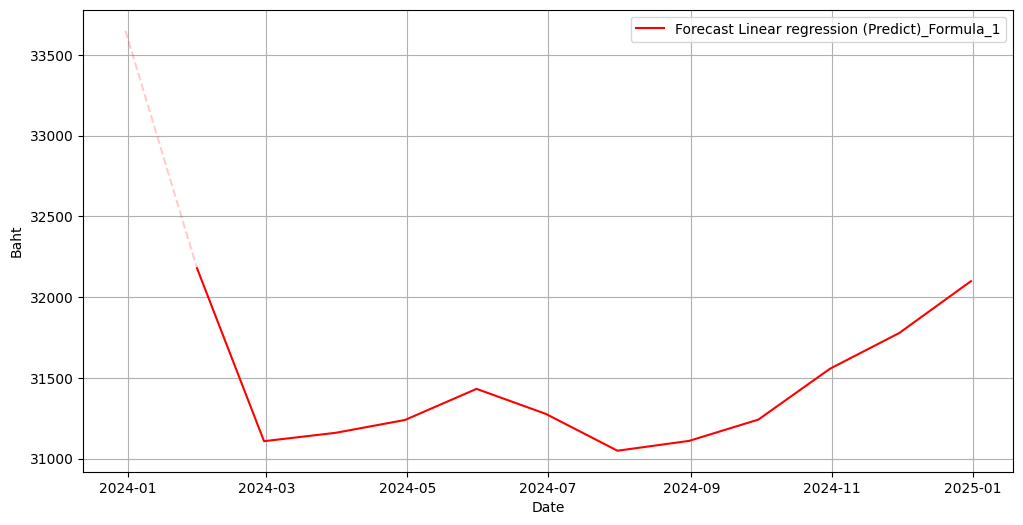

In [82]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldBar_Sale'] , label = 'ราคาขายทองคำแท่ง')
plt.plot(Date_forecast_period,(y_pred_linear_GB_S_1), label='Forecast Linear regression (Predict)_Formula_1' , color = 'red')
# plt.plot(Date_forecast_period,(y_pred_linear_GB_S_2), label='Forecast Linear regression (Predict)_Formula_2' , color = 'blue')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),(y_pred_linear_GB_S_1[0][0]))][0], 
         color = 'red',linestyle='--',alpha=0.2)
# plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
#          [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),(y_pred_linear_GB_S_2[0][0]))][0], 
#          color = 'blue',linestyle='--',alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Baht')
# plt.title('ราคาขายทองคำแท่ง vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [202]:
Data_predict_GB_S = pd.DataFrame({
    'Date' : [i for i in Date_forecast_period['Report Date']] ,
    'Predict_1 of GoldBar_Sale' : [i[0] for i in y_pred_linear_GB_S_1],
    'Predict_2 of GoldBar_Sale' : [i[0] for i in y_pred_linear_GB_S_2]
})
Data_predict_GB_S

Date  Predict_1 of GoldBar_Sale  Predict_2 of GoldBar_Sale
0  2024-01-31               30624.289005               30903.983559
1  2024-02-29               30752.682023               30697.687503
2  2024-03-31               30505.009548               30533.817783
3  2024-04-30               30270.144499               30278.778440
4  2024-05-31               29897.036011               29809.601310
5  2024-06-30               29626.460584               29731.896654
6  2024-07-31               29589.491330               29558.034870
7  2024-08-31               29606.743406               29571.612121
8  2024-09-30               29338.144861               29365.921655
9  2024-10-31               29477.842385               29421.317459
10 2024-11-30               29642.698573               29842.558412
11 2024-12-31               30698.768376               30938.981540

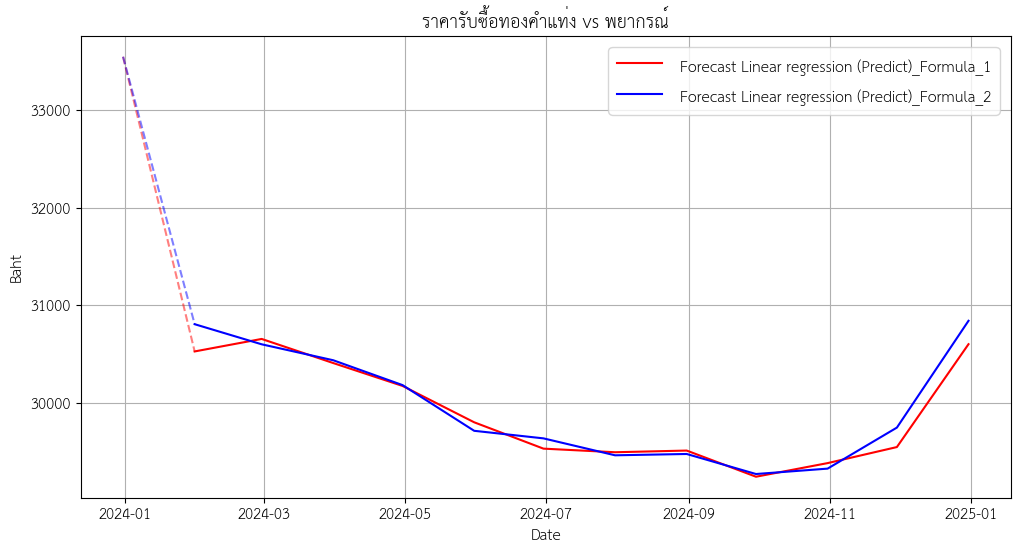

In [203]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldBar_Buy'] , label = 'ราคารับซื้อทองคำแท่ง')
plt.plot(Date_forecast_period,(y_pred_linear_GB_B_1), label='Forecast Linear regression (Predict)_Formula_1' , color = 'red')
plt.plot(Date_forecast_period,(y_pred_linear_GB_B_2), label='Forecast Linear regression (Predict)_Formula_2' , color = 'blue')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Buy'].iloc[-1].astype(float),(y_pred_linear_GB_B_1[0][0]))][0], 
         color = 'red',linestyle='--',alpha=0.5)
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Buy'].iloc[-1].astype(float),(y_pred_linear_GB_B_2[0][0]))][0], 
         color = 'blue',linestyle='--',alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคารับซื้อทองคำแท่ง vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [204]:
Data_predict_GB_B = pd.DataFrame({
     'Date' : [i for i in Date_forecast_period['Report Date']] ,
    'Predict_1 of GoldBar_Buy' : [i[0] for i in y_pred_linear_GB_B_1],
    'Predict_2 of GoldBar_Buy' : [i[0] for i in y_pred_linear_GB_B_2]
})
Data_predict_GB_B

Date  Predict_1 of GoldBar_Buy  Predict_2 of GoldBar_Buy
0  2024-01-31              30524.289005              30803.983559
1  2024-02-29              30652.682023              30597.687503
2  2024-03-31              30405.009548              30433.817783
3  2024-04-30              30170.144499              30178.778440
4  2024-05-31              29797.036011              29709.601310
5  2024-06-30              29526.460584              29631.896654
6  2024-07-31              29489.491330              29458.034870
7  2024-08-31              29506.743406              29471.612121
8  2024-09-30              29238.144861              29265.921655
9  2024-10-31              29377.842385              29321.317459
10 2024-11-30              29542.698573              29742.558412
11 2024-12-31              30598.768376              30838.981540

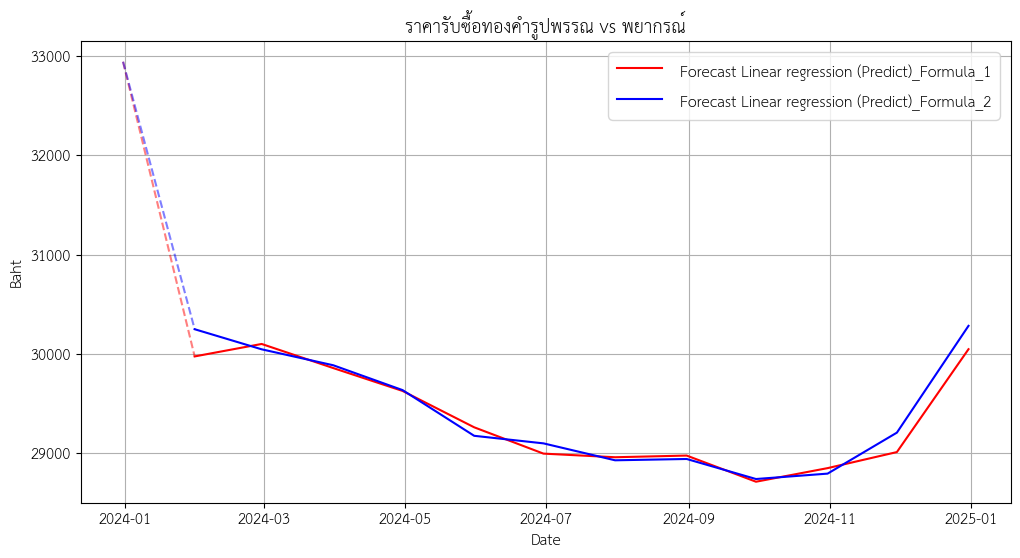

In [205]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldJew_Buy'] , label = 'ราคารับซื้อทองคำรูปพรรณ')
plt.plot(Date_forecast_period,(y_pred_linear_GJ_B_1), label='Forecast Linear regression (Predict)_Formula_1' , color = 'red')
plt.plot(Date_forecast_period,(y_pred_linear_GJ_B_2), label='Forecast Linear regression (Predict)_Formula_2' , color = 'blue')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Buy'].iloc[-1].astype(float),(y_pred_linear_GJ_B_1[0][0]))][0], 
         color = 'red',linestyle='--',alpha=0.5)
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Buy'].iloc[-1].astype(float),(y_pred_linear_GJ_B_2[0][0]))][0], 
         color = 'blue',linestyle='--',alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคารับซื้อทองคำรูปพรรณ vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [206]:
Data_predict_GJ_B = pd.DataFrame({
     'Date' : [i for i in Date_forecast_period['Report Date']] ,
    'Predict_1 of GoldJew_Buy' : [i[0] for i in y_pred_linear_GJ_B_1],
    'Predict_2 of GoldJew_Buy' : [i[0] for i in y_pred_linear_GJ_B_2]
})
Data_predict_GJ_B

Date  Predict_1 of GoldJew_Buy  Predict_2 of GoldJew_Buy
0  2024-01-31              29974.618592              30248.584506
1  2024-02-29              30100.156058              30046.269094
2  2024-03-31              29857.354849              29885.571582
3  2024-04-30              29626.983439              29635.443401
4  2024-05-31              29260.819906              29175.167346
5  2024-06-30              28995.680034              29098.970117
6  2024-07-31              28959.250116              28928.440519
7  2024-08-31              28976.045606              28941.627787
8  2024-09-30              28712.657778              28739.879682
9  2024-10-31              28849.593359              28794.226926
10 2024-11-30              29011.339259              29207.077738
11 2024-12-31              30047.399781              30282.663001

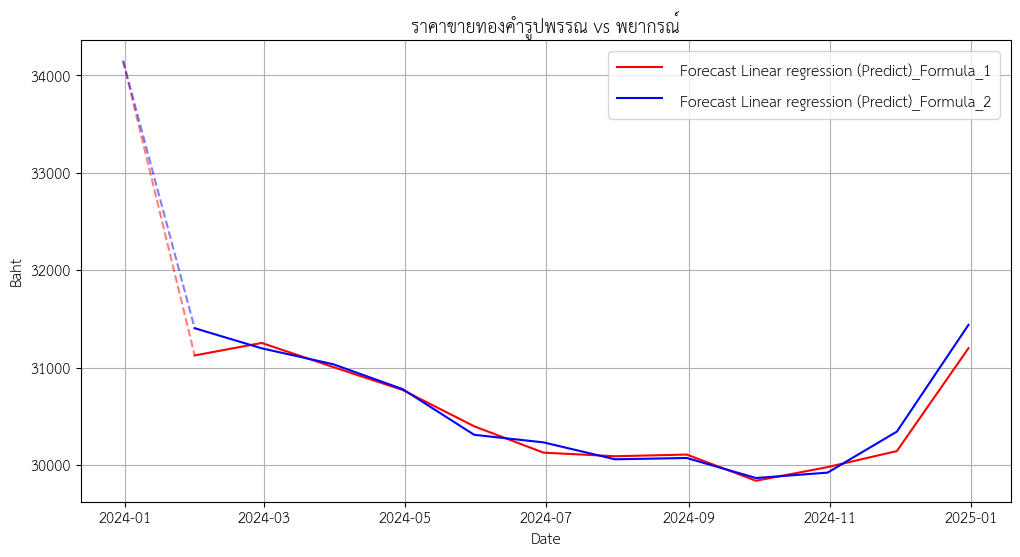

In [207]:
plt.figure(figsize=(12,6))
# plt.plot(Gold_Factor_data['Report Date'] , Gold_Factor_data['GoldJew_Sale'] , label = 'ราคาขายทองคำรูปพรรณ')
plt.plot(Date_forecast_period,(y_pred_linear_GJ_S_1), label='Forecast Linear regression (Predict)_Formula_1' , color = 'red')
plt.plot(Date_forecast_period,(y_pred_linear_GJ_S_2), label='Forecast Linear regression (Predict)_Formula_2' , color = 'blue')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Sale'].iloc[-1].astype(float),(y_pred_linear_GJ_S_1[0][0]))][0], 
         color = 'red',linestyle='--',alpha=0.5)
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldJew_Sale'].iloc[-1].astype(float),(y_pred_linear_GJ_S_2[0][0]))][0], 
         color = 'blue',linestyle='--',alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคาขายทองคำรูปพรรณ vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

In [208]:
Data_predict_GJ_S = pd.DataFrame({
     'Date' : [i for i in Date_forecast_period['Report Date']] ,
    'Predict_1 of GoldJew_Sale' : [i[0] for i in y_pred_linear_GJ_S_1],
    'Predict_2 of GoldJew_Sale' : [i[0] for i in y_pred_linear_GJ_S_2]
})
Data_predict_GJ_S

Date  Predict_1 of GoldJew_Sale  Predict_2 of GoldJew_Sale
0  2024-01-31               31124.289005               31403.983559
1  2024-02-29               31252.682023               31197.687503
2  2024-03-31               31005.009548               31033.817783
3  2024-04-30               30770.144499               30778.778440
4  2024-05-31               30397.036011               30309.601310
5  2024-06-30               30126.460584               30231.896654
6  2024-07-31               30089.491330               30058.034870
7  2024-08-31               30106.743406               30071.612121
8  2024-09-30               29838.144861               29865.921655
9  2024-10-31               29977.842385               29921.317459
10 2024-11-30               30142.698573               30342.558412
11 2024-12-31               31198.768376               31438.981540

# ARIMA only # ราคาทอง

In [209]:
Gold_data_test_3 = Gold_data[Gold_data['Report Date'] <= '2023-12-31']
Gold_data_test_3 = Gold_data[Gold_data['Report Date'] >= '2021-01-01']
Gold_data_test_5 = Gold_data[Gold_data['Report Date'] <= '2023-12-31']
Gold_data_test_5 = Gold_data[Gold_data['Report Date'] >= '2019-01-01']
Gold_data_test_8 = Gold_data[Gold_data['Report Date'] <= '2023-12-31']
Gold_data_test_8 = Gold_data[Gold_data['Report Date'] >= '2015-01-01']
Gold_data_test_10 = Gold_data[Gold_data['Report Date'] <= '2023-12-31']
Gold_data_test_10 = Gold_data[Gold_data['Report Date'] >= '2013-01-01']

In [210]:
# Gold_data_test_3
GOLD_N

['GoldBar_Sale', 'GoldBar_Buy', 'GoldJew_Sale', 'GoldJew_Buy']

3 year

In [211]:
arima = pm.auto_arima(Gold_data_test_3['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_S_3 = pd.DataFrame(preds)
arima_only_predict_GB_S_3.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=566.688, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=562.938, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=562.822, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=562.507, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=563.908, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=560.733, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=562.511, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=564.516, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=562.703, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=562.700, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=561.072, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=564.665, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=564.255, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 0.956 seconds


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -277.367
Date:                Wed, 14 Aug 2024   AIC                            560.733
Time:                        08:08:01   BIC                            565.400
Sample:                             0   HQIC                           562.344
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    258.0427    124.861      2.067      0.039      13.320     502.766
ma.L1         -0.1646      0.161     -1.023      0.306      -0.480       0.151
sigma2      4.464e+05   1.23e+05      3.628      0.000    2.05e+05    6.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.68   Prob(JB):                         0.09
Heteroskedasticity (H):               0.88   Skew:                             0.87
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [212]:
arima = pm.auto_arima(Gold_data_test_3['GoldBar_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_B_3 = pd.DataFrame(preds)
arima_only_predict_GB_B_3.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=566.686, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=562.938, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=562.821, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=562.504, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=563.908, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=560.730, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=562.508, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=564.513, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=562.788, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=562.696, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=561.070, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=564.661, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=564.255, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 0.990 seconds


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -277.365
Date:                Wed, 14 Aug 2024   AIC                            560.730
Time:                        08:08:02   BIC                            565.396
Sample:                             0   HQIC                           562.341
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    258.0035    124.800      2.067      0.039      13.401     502.606
ma.L1         -0.1652      0.161     -1.025      0.305      -0.481       0.151
sigma2      4.464e+05   1.23e+05      3.628      0.000    2.05e+05    6.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.72
Prob(Q):                              0.68   Prob(JB):                         0.09
Heteroskedasticity (H):               0.88   Skew:                             0.88
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [213]:
arima = pm.auto_arima(Gold_data_test_3['GoldJew_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_B_3 = pd.DataFrame(preds)
arima_only_predict_GJ_B_3.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=565.319, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=561.739, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=561.642, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=561.634, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=562.699, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=559.535, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=561.315, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=563.320, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=561.590, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=561.499, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=559.891, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=563.463, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=563.062, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 1.005 seconds


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -276.768
Date:                Wed, 14 Aug 2024   AIC                            559.535
Time:                        08:08:03   BIC                            564.202
Sample:                             0   HQIC                           561.146
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    252.9955    122.287      2.069      0.039      13.316     492.675
ma.L1         -0.1685      0.161     -1.045      0.296      -0.484       0.147
sigma2      4.314e+05   1.19e+05      3.623      0.000    1.98e+05    6.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 4.69
Prob(Q):                              0.69   Prob(JB):                         0.10
Heteroskedasticity (H):               0.88   Skew:                             0.87
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [214]:
arima = pm.auto_arima(Gold_data_test_3['GoldJew_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_S_3 = pd.DataFrame(preds)
arima_only_predict_GJ_S_3.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=566.701, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=562.938, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=562.826, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=562.832, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=563.908, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=561.081, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=562.816, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=564.815, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=562.663, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=562.809, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=560.739, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=562.523, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=564.528, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=562.718, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[12] intercep

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -277.369
Date:                Wed, 14 Aug 2024   AIC                            560.739
Time:                        08:08:04   BIC                            565.405
Sample:                             0   HQIC                           562.349
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    249.4988    125.180      1.993      0.046       4.151     494.847
ma.L1         -0.1623      0.158     -1.024      0.306      -0.473       0.148
sigma2      4.394e+05   1.19e+05      3.691      0.000    2.06e+05    6.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 4.70
Prob(Q):                              0.67   Prob(JB):                         0.10
Heteroskedasticity (H):               0.88   Skew:                             0.87
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

5 year

In [215]:
arima = pm.auto_arima(Gold_data_test_5['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_S_5 = pd.DataFrame(preds)
arima_only_predict_GB_S_5.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=972.883, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=969.021, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=970.553, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=970.179, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=971.391, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=968.989, Time=0.02 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=969.305, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=970.046, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=968.429, Time=0.02 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=969.559, Time=0.06 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=971.500, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=969.904, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=972.166, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=969.407, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,1)

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -481.215
Date:                              Wed, 14 Aug 2024   AIC                            968.429
Time:                                      08:08:05   BIC                            974.662
Sample:                                           0   HQIC                           970.862
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    238.9830    137.232      1.741      0.082     -29.986     507.952
ma.S.L12       0.1441      0.148      0.971      0.331      -0.147       0.435
sigma2       7.43e+05   1.17e+05      6.329      0.000    5.13e+05    9.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 8.32
Prob(Q):                              0.22   Prob(JB):                         0.02
Heteroskedasticity (H):               0.44   Skew:                             0.60
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
arima = pm.auto_arima(Gold_data_test_5['GoldBar_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_B_5 = pd.DataFrame(preds)
arima_only_predict_GB_B_5.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=973.342, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=969.517, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=971.049, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=970.673, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=971.851, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=969.483, Time=0.02 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=969.797, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=970.539, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=968.922, Time=0.03 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=970.053, Time=0.05 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=971.993, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=970.401, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=972.286, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=969.872, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,1)

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -481.461
Date:                              Wed, 14 Aug 2024   AIC                            968.922
Time:                                      08:08:07   BIC                            975.155
Sample:                                           0   HQIC                           971.355
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    238.9830    138.738      1.723      0.085     -32.938     510.904
ma.S.L12       0.1446      0.149      0.969      0.333      -0.148       0.437
sigma2      7.492e+05   1.15e+05      6.499      0.000    5.23e+05    9.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.46   Jarque-Bera (JB):                10.65
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.65
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [217]:
arima = pm.auto_arima(Gold_data_test_5['GoldJew_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_B_5 = pd.DataFrame(preds)
arima_only_predict_GJ_B_5.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=967.418, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=968.951, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=968.570, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=969.746, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=967.384, Time=0.02 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=967.715, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=968.450, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=966.821, Time=0.02 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=967.975, Time=0.06 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=969.916, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=968.301, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=967.763, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,1)[12] int

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -480.411
Date:                              Wed, 14 Aug 2024   AIC                            966.821
Time:                                      08:08:08   BIC                            973.054
Sample:                                           0   HQIC                           969.254
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    234.5945    136.527      1.718      0.086     -32.993     502.182
ma.S.L12       0.1464      0.149      0.983      0.325      -0.145       0.438
sigma2       7.23e+05   1.12e+05      6.484      0.000    5.04e+05    9.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):                10.51
Prob(Q):                              0.23   Prob(JB):                         0.01
Heteroskedasticity (H):               0.43   Skew:                             0.65
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [218]:
arima = pm.auto_arima(Gold_data_test_5['GoldJew_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_S_5 = pd.DataFrame(preds)
arima_only_predict_GJ_S_5.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=972.883, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=969.021, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=970.550, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=970.184, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=971.391, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=968.974, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=969.295, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=970.032, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=968.419, Time=0.03 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=969.547, Time=0.06 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=971.488, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=969.906, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=971.794, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=969.398, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,1)

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -481.210
Date:                              Wed, 14 Aug 2024   AIC                            968.419
Time:                                      08:08:09   BIC                            974.652
Sample:                                           0   HQIC                           970.852
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    238.9830    136.997      1.744      0.081     -29.527     507.493
ma.S.L12       0.1420      0.148      0.956      0.339      -0.149       0.433
sigma2       7.43e+05   1.17e+05      6.328      0.000    5.13e+05    9.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):                 8.36
Prob(Q):                              0.22   Prob(JB):                         0.02
Heteroskedasticity (H):               0.44   Skew:                             0.60
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

8 year

In [219]:
arima = pm.auto_arima(Gold_data_test_8['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_S_8 = pd.DataFrame(preds)
arima_only_predict_GB_S_8.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1734.574, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1729.886, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1730.846, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1730.825, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1730.894, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1731.433, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1731.418, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1733.417, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1729.564, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1730.833, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1732.833, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1731.484, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1731.533, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1729.458, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -861.729
Date:                Wed, 14 Aug 2024   AIC                           1729.458
Time:                        08:08:10   BIC                           1737.477
Sample:                             0   HQIC                          1732.709
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    141.0864     70.490      2.002      0.045       2.930     279.243
ma.L1         -0.1151      0.100     -1.149      0.251      -0.311       0.081
sigma2        5.8e+05   6.22e+04      9.332      0.000    4.58e+05    7.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                27.51
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.77
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
arima = pm.auto_arima(Gold_data_test_8['GoldBar_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_B_8 = pd.DataFrame(preds)
arima_only_predict_GB_B_8.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1735.121, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1730.509, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1731.476, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1731.438, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1731.500, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1732.045, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1732.029, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1734.028, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1730.204, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1731.461, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1733.461, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1732.104, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1732.152, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1730.085, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -862.042
Date:                Wed, 14 Aug 2024   AIC                           1730.085
Time:                        08:08:11   BIC                           1738.103
Sample:                             0   HQIC                          1733.335
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    141.1306     70.967      1.989      0.047       2.037     280.224
ma.L1         -0.1156      0.101     -1.148      0.251      -0.313       0.082
sigma2      5.834e+05   6.11e+04      9.554      0.000    4.64e+05    7.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                32.44
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.81
Prob(H) (two-sided):                  0.55   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [221]:
arima = pm.auto_arima(Gold_data_test_8['GoldJew_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_B_8 = pd.DataFrame(preds)
arima_only_predict_GJ_B_8.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1731.139, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1726.407, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1727.505, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1727.459, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1727.375, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1727.950, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1727.935, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1729.933, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1726.227, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1727.492, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1729.492, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1728.115, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1728.171, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1726.105, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -860.053
Date:                Wed, 14 Aug 2024   AIC                           1726.105
Time:                        08:08:12   BIC                           1734.124
Sample:                             0   HQIC                          1729.356
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    137.6477     69.799      1.972      0.049       0.845     274.450
ma.L1         -0.1138      0.099     -1.146      0.252      -0.308       0.081
sigma2      5.623e+05   5.88e+04      9.566      0.000    4.47e+05    6.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                32.51
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.80
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
arima = pm.auto_arima(Gold_data_test_8['GoldJew_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_S_8 = pd.DataFrame(preds)
arima_only_predict_GJ_S_8.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1735.207, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1730.700, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1731.459, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1731.449, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1731.728, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1732.202, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1732.186, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1734.185, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1730.223, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1731.445, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1733.444, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1732.155, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1732.195, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1730.120, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -862.060
Date:                Wed, 14 Aug 2024   AIC                           1730.120
Time:                        08:08:14   BIC                           1738.139
Sample:                             0   HQIC                          1733.371
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    142.4642     70.494      2.021      0.043       4.298     280.630
ma.L1         -0.1173      0.102     -1.148      0.251      -0.318       0.083
sigma2      5.833e+05   6.29e+04      9.281      0.000     4.6e+05    7.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                26.74
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.76
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

10 year

In [223]:
arima = pm.auto_arima(Gold_data_test_10['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_S_10 = pd.DataFrame(preds)
arima_only_predict_GB_S_10.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2213.400, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2192.324, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2183.102, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2181.345, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2183.044, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2183.329, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2190.420, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2183.127, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.152 seconds


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1088.672
Date:                Wed, 14 Aug 2024   AIC                           2181.345
Time:                        08:08:15   BIC                           2187.080
Sample:                             0   HQIC                          2183.675
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6006      0.029    -20.797      0.000      -0.657      -0.544
sigma2      8.914e+05   9.77e+04      9.120      0.000       7e+05    1.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                23.92
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.47
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [224]:
arima = pm.auto_arima(Gold_data_test_10['GoldBar_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GB_B_10 = pd.DataFrame(preds)
arima_only_predict_GB_B_10.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2213.937, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2192.939, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2183.510, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2181.763, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2183.451, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2183.756, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2191.038, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2183.550, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.141 seconds


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1088.882
Date:                Wed, 14 Aug 2024   AIC                           2181.763
Time:                        08:08:16   BIC                           2187.498
Sample:                             0   HQIC                          2184.094
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6085      0.029    -20.881      0.000      -0.666      -0.551
sigma2      8.976e+05   9.78e+04      9.183      0.000    7.06e+05    1.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                25.86
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.47
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [225]:
arima = pm.auto_arima(Gold_data_test_10['GoldJew_Buy'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_B_10 = pd.DataFrame(preds)
arima_only_predict_GJ_B_10.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2208.895, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2187.874, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2178.144, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2176.389, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2178.087, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2178.388, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2185.957, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2178.187, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.160 seconds


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1086.195
Date:                Wed, 14 Aug 2024   AIC                           2176.389
Time:                        08:08:17   BIC                           2182.124
Sample:                             0   HQIC                          2178.720
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6247      0.030    -21.038      0.000      -0.683      -0.567
sigma2      8.663e+05   9.56e+04      9.066      0.000    6.79e+05    1.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                28.71
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.50
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
arima = pm.auto_arima(Gold_data_test_5['GoldJew_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)

arima_only_predict_GJ_S_10 = pd.DataFrame(preds)
arima_only_predict_GJ_S_10.columns = ['Predict']

# arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
# arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=972.883, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=969.021, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=970.550, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=970.184, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=971.391, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=968.974, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=969.295, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=970.032, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=968.419, Time=0.03 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=969.547, Time=0.05 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=971.488, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=969.906, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=971.794, Time=0.22 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=969.398, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,1)

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -481.210
Date:                              Wed, 14 Aug 2024   AIC                            968.419
Time:                                      08:08:18   BIC                            974.652
Sample:                                           0   HQIC                           970.852
                                               - 60                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    238.9830    136.997      1.744      0.081     -29.527     507.493
ma.S.L12       0.1420      0.148      0.956      0.339      -0.149       0.433
sigma2       7.43e+05   1.17e+05      6.328      0.000    5.13e+05    9.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):                 8.36
Prob(Q):                              0.22   Prob(JB):                         0.02
Heteroskedasticity (H):               0.44   Skew:                             0.60
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [227]:
Model_ARIMA_all = pd.DataFrame({
    'Factor' : ['ราคาขายทองคำแท่ง','ราคารับซื้อทองคำแท่ง','ราคาขายทองคำรูปพรรณ','ราคารับซื้อทองคำรูปพรรณ'],
    'Model of ARIMA for 3 year' : ['ARIMA(0,1,1)(0,0,0)[12] intercept','ARIMA(0,1,1)(0,0,0)[12] intercept','ARIMA(0,1,1)(0,0,0)[12] intercept','ARIMA(0,1,1)(0,0,0)[12] intercept'],
    'Model of ARIMA for 5 year' : ['ARIMA(0,1,0)(0,0,1)[12] intercept','ARIMA(0,1,0)(0,0,1)[12] intercept','ARIMA(0,1,0)(0,0,1)[12] intercept','ARIMA(0,1,0)(0,0,1)[12] intercept'],
    'Model of ARIMA for 8 year' : ['ARIMA(0,1,1)(0,0,0)[12] intercept','ARIMA(0,1,1)(0,0,0)[12] intercept','ARIMA(0,1,1)(0,0,0)[12] intercept','ARIMA(0,1,1)(0,0,0)[12] intercept'],
    'Model of ARIMA for 10 year' : ['ARIMA(0,2,1)(0,0,0)[12]','ARIMA(0,2,1)(0,0,0)[12]','ARIMA(0,1,0)(0,0,1)[12] intercept','ARIMA(0,2,1)(0,0,0)[12]']
})
Model_ARIMA_all

Factor          Model of ARIMA for 3 year  \
0         ราคาขายทองคำแท่ง  ARIMA(0,1,1)(0,0,0)[12] intercept   
1     ราคารับซื้อทองคำแท่ง  ARIMA(0,1,1)(0,0,0)[12] intercept   
2      ราคาขายทองคำรูปพรรณ  ARIMA(0,1,1)(0,0,0)[12] intercept   
3  ราคารับซื้อทองคำรูปพรรณ  ARIMA(0,1,1)(0,0,0)[12] intercept   

           Model of ARIMA for 5 year          Model of ARIMA for 8 year  \
0  ARIMA(0,1,0)(0,0,1)[12] intercept  ARIMA(0,1,1)(0,0,0)[12] intercept   
1  ARIMA(0,1,0)(0,0,1)[12] intercept  ARIMA(0,1,1)(0,0,0)[12] intercept   
2  ARIMA(0,1,0)(0,0,1)[12] intercept  ARIMA(0,1,1)(0,0,0)[12] intercept   
3  ARIMA(0,1,0)(0,0,1)[12] intercept  ARIMA(0,1,1)(0,0,0)[12] intercept   

          Model of ARIMA for 10 year  
0            ARIMA(0,2,1)(0,0,0)[12]  
1            ARIMA(0,2,1)(0,0,0)[12]  
2  ARIMA(0,1,0)(0,0,1)[12] intercept  
3            ARIMA(0,2,1)(0,0,0)[12]

In [228]:
ARIMA_3 = pd.DataFrame({
    'Predict_GoldBar_Sale [3 year]':[i for i in arima_only_predict_GB_S_3['Predict']],
    'Predict_GoldBar_Buy [3 year]':[i for i in arima_only_predict_GB_B_3['Predict']],
    'Predict_GoldJew_Sale [3 year]':[i for i in arima_only_predict_GJ_S_3['Predict']],
    'Predict_GoldJew_Buy [3 year]':[i for i in arima_only_predict_GJ_B_3['Predict']]
})
ARIMA_3

Predict_GoldBar_Sale [3 year]  Predict_GoldBar_Buy [3 year]  \
0                    33959.494775                  33859.671566   
1                    34217.537510                  34117.675034   
2                    34475.580246                  34375.678501   
3                    34733.622981                  34633.681969   
4                    34991.665716                  34891.685436   
5                    35249.708451                  35149.688904   
6                    35507.751186                  35407.692372   
7                    35765.793922                  35665.695839   
8                    36023.836657                  35923.699307   
9                    36281.879392                  36181.702775   
10                   36539.922127                  36439.706242   
11                   36797.964862                  36697.709710   

    Predict_GoldJew_Sale [3 year]  Predict_GoldJew_Buy [3 year]  
0                    34448.431020                  33248.211289  
1                    34697.929774                  33501.206812  
2                    34947.428528                  33754.202334  
3                    35196.927282                  34007.197857  
4                    35446.426036                  34260.193380  
5                    35695.924790                  34513.188902  
6                    35945.423544                  34766.184425  
7                    36194.922298                  35019.179948  
8                    36444.421051                  35272.175470  
9                    36693.919805                  35525.170993  
10                   36943.418559                  35778.166516  
11                   37192.917313                  36031.162039

In [229]:
ARIMA_5 = pd.DataFrame({
    'Predict_GoldBar_Sale [5 year]':[i for i in arima_only_predict_GB_S_5['Predict']],
    'Predict_GoldBar_Buy [5 year]':[i for i in arima_only_predict_GB_B_5['Predict']],
    'Predict_GoldJew_Sale [5 year]':[i for i in arima_only_predict_GJ_S_5['Predict']],
    'Predict_GoldJew_Buy [5 year]':[i for i in arima_only_predict_GJ_B_5['Predict']]
})
ARIMA_5

Predict_GoldBar_Sale [5 year]  Predict_GoldBar_Buy [5 year]  \
0                    33904.672332                  33804.738812   
1                    34102.765200                  34002.641837   
2                    34542.406033                  34442.845630   
3                    34783.806358                  34684.301899   
4                    35007.694299                  34908.243210   
5                    35226.353351                  35126.800506   
6                    35391.821744                  35292.029943   
7                    35638.006926                  35538.275616   
8                    35947.947283                  35848.480257   
9                    36376.104311                  36277.244592   
10                   36499.672213                  36400.469122   
11                   36716.377524                  36617.114776   

    Predict_GoldJew_Sale [5 year]  Predict_GoldJew_Buy [5 year]  
0                    34404.376949                  33194.299244  
1                    34603.341897                  33387.087705  
2                    35040.371312                  33820.344011  
3                    35281.715436                  34058.973876  
4                    35505.366239                  34277.402141  
5                    35724.492095                  34492.138235  
6                    35890.867155                  34652.860218  
7                    36136.775365                  34894.870542  
8                    36445.496057                  35200.338239  
9                    36870.843401                  35625.034697  
10                   36996.003113                  35744.403503  
11                   37212.984989                  35956.234526

In [230]:
ARIMA_8 = pd.DataFrame({
    'Predict_GoldBar_Sale [8 year]':[i for i in arima_only_predict_GB_S_8['Predict']],
    'Predict_GoldBar_Buy [8 year]':[i for i in arima_only_predict_GB_B_8['Predict']],
    'Predict_GoldJew_Sale [8 year]':[i for i in arima_only_predict_GJ_S_8['Predict']],
    'Predict_GoldJew_Buy [8 year]':[i for i in arima_only_predict_GJ_B_8['Predict']]
})
ARIMA_8

Predict_GoldBar_Sale [8 year]  Predict_GoldBar_Buy [8 year]  \
0                    33809.148011                  33709.309522   
1                    33950.234411                  33850.440075   
2                    34091.320811                  33991.570629   
3                    34232.407211                  34132.701182   
4                    34373.493611                  34273.831735   
5                    34514.580012                  34414.962288   
6                    34655.666412                  34556.092841   
7                    34796.752812                  34697.223394   
8                    34937.839212                  34838.353947   
9                    35078.925613                  34979.484501   
10                   35220.012013                  35120.615054   
11                   35361.098413                  35261.745607   

    Predict_GoldJew_Sale [8 year]  Predict_GoldJew_Buy [8 year]  
0                    34311.167532                  33098.127280  
1                    34453.631743                  33235.774952  
2                    34596.095954                  33373.422623  
3                    34738.560165                  33511.070295  
4                    34881.024376                  33648.717966  
5                    35023.488587                  33786.365638  
6                    35165.952798                  33924.013310  
7                    35308.417009                  34061.660981  
8                    35450.881220                  34199.308653  
9                    35593.345431                  34336.956324  
10                   35735.809642                  34474.603996  
11                   35878.273853                  34612.251667

In [231]:
ARIMA_8 = pd.DataFrame({
    'Predict_GoldBar_Sale [10 year]':[i for i in arima_only_predict_GB_S_10['Predict']],
    'Predict_GoldBar_Buy [10 year]':[i for i in arima_only_predict_GB_B_10['Predict']],
    'Predict_GoldJew_Sale [10 year]':[i for i in arima_only_predict_GJ_S_10['Predict']],
    'Predict_GoldJew_Buy [10 year]':[i for i in arima_only_predict_GJ_B_10['Predict']]
})
ARIMA_8

Predict_GoldBar_Sale [10 year]  Predict_GoldBar_Buy [10 year]  \
0                     33816.807815                   33720.799974   
1                     33983.615630                   33891.599947   
2                     34150.423444                   34062.399921   
3                     34317.231259                   34233.199895   
4                     34484.039074                   34403.999869   
5                     34650.846889                   34574.799842   
6                     34817.654704                   34745.599816   
7                     34984.462518                   34916.399790   
8                     35151.270333                   35087.199763   
9                     35318.078148                   35257.999737   
10                    35484.885963                   35428.799711   
11                    35651.693778                   35599.599685   

    Predict_GoldJew_Sale [10 year]  Predict_GoldJew_Buy [10 year]  
0                     34404.376949                   33117.519602  
1                     34603.341897                   33292.359204  
2                     35040.371312                   33467.198806  
3                     35281.715436                   33642.038408  
4                     35505.366239                   33816.878010  
5                     35724.492095                   33991.717612  
6                     35890.867155                   34166.557214  
7                     36136.775365                   34341.396816  
8                     36445.496057                   34516.236418  
9                     36870.843401                   34691.076020  
10                    36996.003113                   34865.915622  
11                    37212.984989                   35040.755223

In [232]:
arima_only_predict_GB_S_3['Predict'].iloc[0]

33959.49477510007

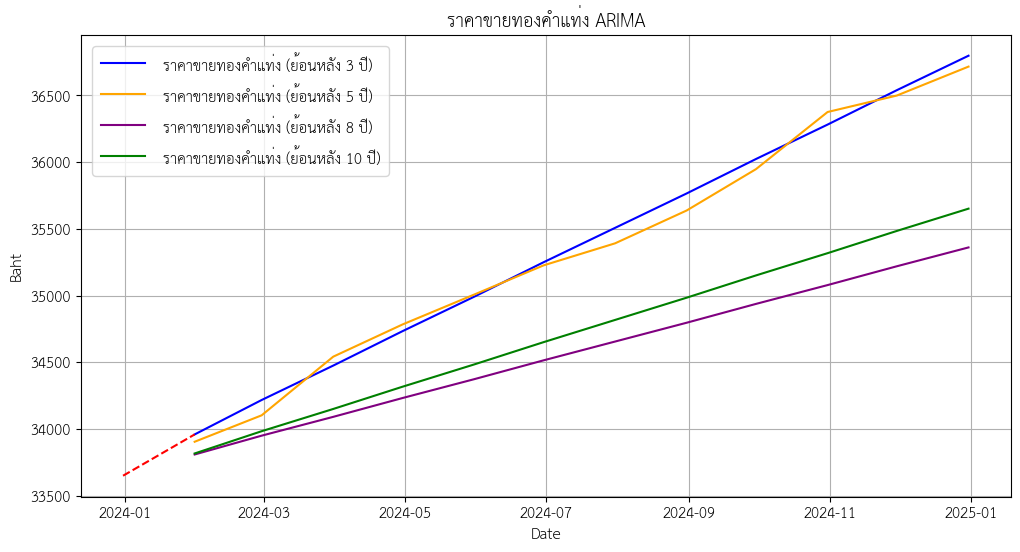

In [233]:
Date_for_connect = pd.DataFrame()
Date_for_connect['Report Date'] = pd.concat([Gold_data['Report Date'].iloc[-1:],Date_forecast_period['Report Date'].iloc[:1]])
# Date_for_connect['Value'] = pd.concat([ Gold_data['GoldBar_Sale'].iloc[-1:],arima_only_predict['Predict'].iloc[:1]])
# Date_for_connect['Best'] = pd.concat([(Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0]),arima_only_best_case[0]])
# Date_for_connect['Worst'] = pd.concat([ Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_worst_case[0]])
plt.figure(figsize=(12,6))
# plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'ราคาขายทองคำแท่ง (จริง)')
plt.plot(Date_forecast_period,arima_only_predict_GB_S_3['Predict'] , label='ราคาขายทองคำแท่ง (ย้อนหลัง 3 ปี)' , color = 'blue')
plt.plot(Date_forecast_period,arima_only_predict_GB_S_5['Predict'] , label='ราคาขายทองคำแท่ง (ย้อนหลัง 5 ปี)' , color = 'orange')
plt.plot(Date_forecast_period,arima_only_predict_GB_S_8['Predict'] , label='ราคาขายทองคำแท่ง (ย้อนหลัง 8 ปี)' , color = 'purple')
plt.plot(Date_forecast_period,arima_only_predict_GB_S_10['Predict'] , label='ราคาขายทองคำแท่ง (ย้อนหลัง 10 ปี)' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_best_case , label='Forecast best case' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_worst_case , label='Forecast worst case' , color = 'red')
plt.plot(Date_for_connect['Report Date'] ,[Gold_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_predict_GB_S_3.iloc[:1].values[0][0]],color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'], np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], arima_only_best_case),color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'] ,np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], base_case),color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคาขายทองคำแท่ง ARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [234]:
ARIMA_Condiation_GB_S = pd.DataFrame({
    'Data' : [i for i in Date_forecast_period['Report Date']],
    'ราคาขายทองคำแท่ง (ย้อนหลัง 3 ปี)' : [i for i in arima_only_predict_GB_S_3['Predict']],
    'ราคาขายทองคำแท่ง (ย้อนหลัง 5 ปี)' : [i for i in arima_only_predict_GB_S_5['Predict']],
    'ราคาขายทองคำแท่ง (ย้อนหลัง 8 ปี)' : [i for i in arima_only_predict_GB_S_8['Predict']],
    'ราคาขายทองคำแท่ง (ย้อนหลัง 10 ปี)' : [i for i in arima_only_predict_GB_S_10['Predict']]
})
ARIMA_Condiation_GB_S

Data  ราคาขายทองคำแท่ง (ย้อนหลัง 3 ปี)  \
0  2024-01-31                      33959.494775   
1  2024-02-29                      34217.537510   
2  2024-03-31                      34475.580246   
3  2024-04-30                      34733.622981   
4  2024-05-31                      34991.665716   
5  2024-06-30                      35249.708451   
6  2024-07-31                      35507.751186   
7  2024-08-31                      35765.793922   
8  2024-09-30                      36023.836657   
9  2024-10-31                      36281.879392   
10 2024-11-30                      36539.922127   
11 2024-12-31                      36797.964862   

    ราคาขายทองคำแท่ง (ย้อนหลัง 5 ปี)  ราคาขายทองคำแท่ง (ย้อนหลัง 8 ปี)  \
0                       33904.672332                      33809.148011   
1                       34102.765200                      33950.234411   
2                       34542.406033                      34091.320811   
3                       34783.806358                      34232.407211   
4                       35007.694299                      34373.493611   
5                       35226.353351                      34514.580012   
6                       35391.821744                      34655.666412   
7                       35638.006926                      34796.752812   
8                       35947.947283                      34937.839212   
9                       36376.104311                      35078.925613   
10                      36499.672213                      35220.012013   
11                      36716.377524                      35361.098413   

    ราคาขายทองคำแท่ง (ย้อนหลัง 10 ปี)  
0                        33816.807815  
1                        33983.615630  
2                        34150.423444  
3                        34317.231259  
4                        34484.039074  
5                        34650.846889  
6                        34817.654704  
7                        34984.462518  
8                        35151.270333  
9                        35318.078148  
10                       35484.885963  
11                       35651.693778

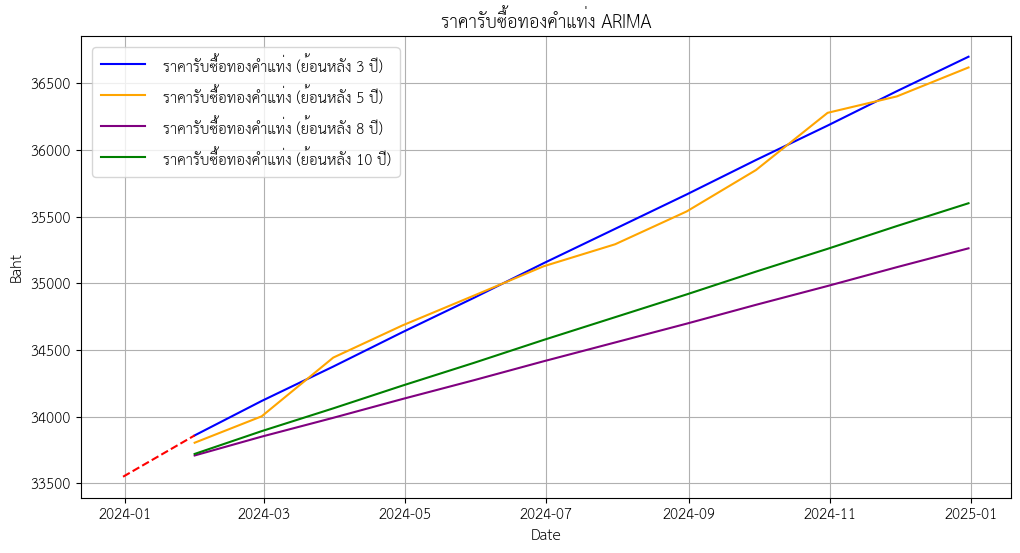

In [235]:
Date_for_connect = pd.DataFrame()
Date_for_connect['Report Date'] = pd.concat([Gold_data['Report Date'].iloc[-1:],Date_forecast_period['Report Date'].iloc[:1]])
# Date_for_connect['Value'] = pd.concat([ Gold_data['GoldBar_Sale'].iloc[-1:],arima_only_predict['Predict'].iloc[:1]])
# Date_for_connect['Best'] = pd.concat([(Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0]),arima_only_best_case[0]])
# Date_for_connect['Worst'] = pd.concat([ Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_worst_case[0]])
plt.figure(figsize=(12,6))
# plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Buy'] , label = 'ราคารับซื้อทองคำแท่ง (จริง)')
plt.plot(Date_forecast_period,arima_only_predict_GB_B_3['Predict'] , label='ราคารับซื้อทองคำแท่ง (ย้อนหลัง 3 ปี)' , color = 'blue')
plt.plot(Date_forecast_period,arima_only_predict_GB_B_5['Predict'] , label='ราคารับซื้อทองคำแท่ง (ย้อนหลัง 5 ปี)' , color = 'orange')
plt.plot(Date_forecast_period,arima_only_predict_GB_B_8['Predict'] , label='ราคารับซื้อทองคำแท่ง (ย้อนหลัง 8 ปี)' , color = 'purple')
plt.plot(Date_forecast_period,arima_only_predict_GB_B_10['Predict'] , label='ราคารับซื้อทองคำแท่ง (ย้อนหลัง 10 ปี)' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_best_case , label='Forecast best case' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_worst_case , label='Forecast worst case' , color = 'red')
plt.plot(Date_for_connect['Report Date'] ,[Gold_data['GoldBar_Buy'].iloc[-1:].values[0],arima_only_predict_GB_B_3.iloc[:1].values[0][0]],color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'], np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], arima_only_best_case),color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'] ,np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], base_case),color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคารับซื้อทองคำแท่ง ARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [236]:
ARIMA_Condiation_GB_B = pd.DataFrame({
    'Data' : [i for i in Date_forecast_period['Report Date']],
    'ราคารับซื้อทองคำแท่ง (ย้อนหลัง 3 ปี)' : [i for i in arima_only_predict_GB_B_3['Predict']],
    'ราคารับซื้อทองคำแท่ง (ย้อนหลัง 5 ปี)' : [i for i in arima_only_predict_GB_B_5['Predict']],
    'ราคารับซื้อทองคำแท่ง (ย้อนหลัง 8 ปี)' : [i for i in arima_only_predict_GB_B_8['Predict']],
    'ราคารับซื้อทองคำแท่ง (ย้อนหลัง 10 ปี)' : [i for i in arima_only_predict_GB_B_10['Predict']]
})
ARIMA_Condiation_GB_B

Data  ราคารับซื้อทองคำแท่ง (ย้อนหลัง 3 ปี)  \
0  2024-01-31                          33859.671566   
1  2024-02-29                          34117.675034   
2  2024-03-31                          34375.678501   
3  2024-04-30                          34633.681969   
4  2024-05-31                          34891.685436   
5  2024-06-30                          35149.688904   
6  2024-07-31                          35407.692372   
7  2024-08-31                          35665.695839   
8  2024-09-30                          35923.699307   
9  2024-10-31                          36181.702775   
10 2024-11-30                          36439.706242   
11 2024-12-31                          36697.709710   

    ราคารับซื้อทองคำแท่ง (ย้อนหลัง 5 ปี)  \
0                           33804.738812   
1                           34002.641837   
2                           34442.845630   
3                           34684.301899   
4                           34908.243210   
5                           35126.800506   
6                           35292.029943   
7                           35538.275616   
8                           35848.480257   
9                           36277.244592   
10                          36400.469122   
11                          36617.114776   

    ราคารับซื้อทองคำแท่ง (ย้อนหลัง 8 ปี)  \
0                           33709.309522   
1                           33850.440075   
2                           33991.570629   
3                           34132.701182   
4                           34273.831735   
5                           34414.962288   
6                           34556.092841   
7                           34697.223394   
8                           34838.353947   
9                           34979.484501   
10                          35120.615054   
11                          35261.745607   

    ราคารับซื้อทองคำแท่ง (ย้อนหลัง 10 ปี)  
0                            33720.799974  
1                            33891.599947  
2                            34062.399921  
3                            34233.199895  
4                            34403.999869  
5                            34574.799842  
6                            34745.599816  
7                            34916.399790  
8                            35087.199763  
9                            35257.999737  
10                           35428.799711  
11                           35599.599685

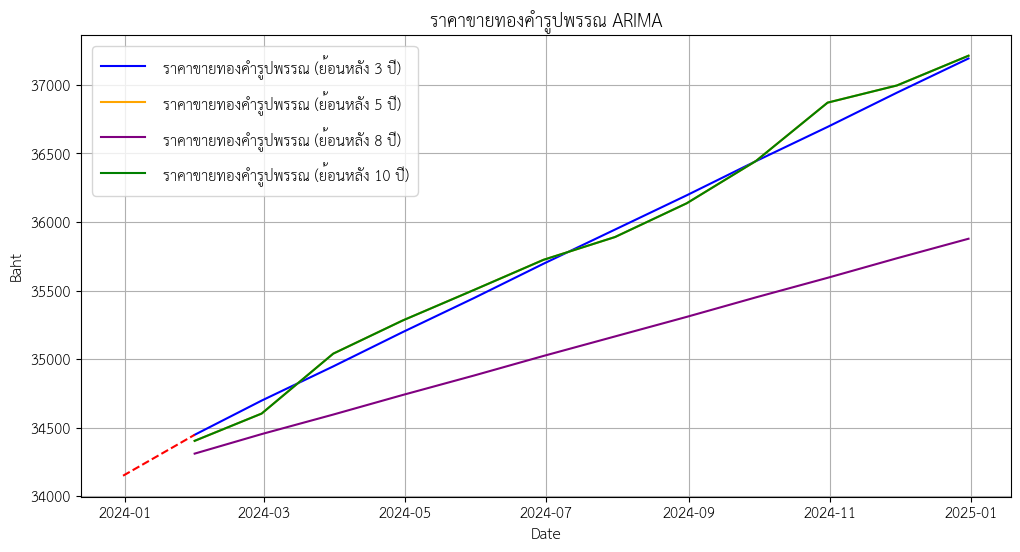

In [237]:
Date_for_connect = pd.DataFrame()
Date_for_connect['Report Date'] = pd.concat([Gold_data['Report Date'].iloc[-1:],Date_forecast_period['Report Date'].iloc[:1]])
# Date_for_connect['Value'] = pd.concat([ Gold_data['GoldBar_Sale'].iloc[-1:],arima_only_predict['Predict'].iloc[:1]])
# Date_for_connect['Best'] = pd.concat([(Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0]),arima_only_best_case[0]])
# Date_for_connect['Worst'] = pd.concat([ Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_worst_case[0]])
plt.figure(figsize=(12,6))
# plt.plot(Gold_data['Report Date'] , Gold_data['GoldJew_Sale'] , label = 'ราคาขายทองคำรูปพรรณ (จริง)')
plt.plot(Date_forecast_period,arima_only_predict_GJ_S_3['Predict'] , label='ราคาขายทองคำรูปพรรณ (ย้อนหลัง 3 ปี)' , color = 'blue')
plt.plot(Date_forecast_period,arima_only_predict_GJ_S_5['Predict'] , label='ราคาขายทองคำรูปพรรณ (ย้อนหลัง 5 ปี)' , color = 'orange')
plt.plot(Date_forecast_period,arima_only_predict_GJ_S_8['Predict'] , label='ราคาขายทองคำรูปพรรณ (ย้อนหลัง 8 ปี)' , color = 'purple')
plt.plot(Date_forecast_period,arima_only_predict_GJ_S_10['Predict'] , label='ราคาขายทองคำรูปพรรณ (ย้อนหลัง 10 ปี)' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_best_case , label='Forecast best case' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_worst_case , label='Forecast worst case' , color = 'red')
plt.plot(Date_for_connect['Report Date'] ,[Gold_data['GoldJew_Sale'].iloc[-1:].values[0],arima_only_predict_GJ_S_3.iloc[:1].values[0][0]],color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'], np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], arima_only_best_case),color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'] ,np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], base_case),color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคาขายทองคำรูปพรรณ ARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [238]:
ARIMA_Condiation_GJ_S = pd.DataFrame({
     'Data' : [i for i in Date_forecast_period['Report Date']],
    'ราคาขายทองคำรูปพรรณ (ย้อนหลัง 3 ปี)' : [i for i in arima_only_predict_GJ_S_3['Predict']],
    'ราคาขายทองคำรูปพรรณ (ย้อนหลัง 5 ปี)' : [i for i in arima_only_predict_GJ_S_5['Predict']],
    'ราคาขายทองคำรูปพรรณ (ย้อนหลัง 8 ปี)' : [i for i in arima_only_predict_GJ_S_8['Predict']],
    'ราคาขายทองคำรูปพรรณ (ย้อนหลัง 10 ปี)' : [i for i in arima_only_predict_GJ_S_10['Predict']]
})
ARIMA_Condiation_GJ_S

Data  ราคาขายทองคำรูปพรรณ (ย้อนหลัง 3 ปี)  \
0  2024-01-31                         34448.431020   
1  2024-02-29                         34697.929774   
2  2024-03-31                         34947.428528   
3  2024-04-30                         35196.927282   
4  2024-05-31                         35446.426036   
5  2024-06-30                         35695.924790   
6  2024-07-31                         35945.423544   
7  2024-08-31                         36194.922298   
8  2024-09-30                         36444.421051   
9  2024-10-31                         36693.919805   
10 2024-11-30                         36943.418559   
11 2024-12-31                         37192.917313   

    ราคาขายทองคำรูปพรรณ (ย้อนหลัง 5 ปี)  ราคาขายทองคำรูปพรรณ (ย้อนหลัง 8 ปี)  \
0                          34404.376949                         34311.167532   
1                          34603.341897                         34453.631743   
2                          35040.371312                         34596.095954   
3                          35281.715436                         34738.560165   
4                          35505.366239                         34881.024376   
5                          35724.492095                         35023.488587   
6                          35890.867155                         35165.952798   
7                          36136.775365                         35308.417009   
8                          36445.496057                         35450.881220   
9                          36870.843401                         35593.345431   
10                         36996.003113                         35735.809642   
11                         37212.984989                         35878.273853   

    ราคาขายทองคำรูปพรรณ (ย้อนหลัง 10 ปี)  
0                           34404.376949  
1                           34603.341897  
2                           35040.371312  
3                           35281.715436  
4                           35505.366239  
5                           35724.492095  
6                           35890.867155  
7                           36136.775365  
8                           36445.496057  
9                           36870.843401  
10                          36996.003113  
11                          37212.984989

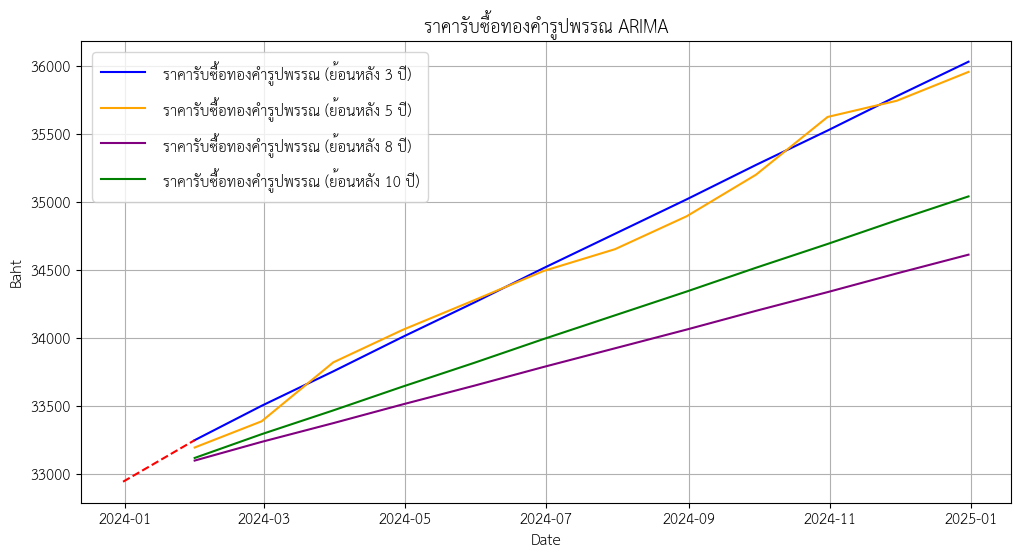

In [239]:
Date_for_connect = pd.DataFrame()
Date_for_connect['Report Date'] = pd.concat([Gold_data['Report Date'].iloc[-1:],Date_forecast_period['Report Date'].iloc[:1]])
# Date_for_connect['Value'] = pd.concat([ Gold_data['GoldBar_Sale'].iloc[-1:],arima_only_predict['Predict'].iloc[:1]])
# Date_for_connect['Best'] = pd.concat([(Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0]),arima_only_best_case[0]])
# Date_for_connect['Worst'] = pd.concat([ Gold_Factor_data['GoldBar_Sale'].iloc[-1:].values[0],arima_only_worst_case[0]])
plt.figure(figsize=(12,6))
# plt.plot(Gold_data['Report Date'] , Gold_data['GoldJew_Buy'] , label = 'ราคารับซื้อทองคำรูปพรรณ (จริง)')
plt.plot(Date_forecast_period,arima_only_predict_GJ_B_3['Predict'] , label='ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 3 ปี)' , color = 'blue')
plt.plot(Date_forecast_period,arima_only_predict_GJ_B_5['Predict'] , label='ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 5 ปี)' , color = 'orange')
plt.plot(Date_forecast_period,arima_only_predict_GJ_B_8['Predict'] , label='ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 8 ปี)' , color = 'purple')
plt.plot(Date_forecast_period,arima_only_predict_GJ_B_10['Predict'] , label='ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 10 ปี)' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_best_case , label='Forecast best case' , color = 'green')
# plt.plot(Date_forecast_period,arima_only_worst_case , label='Forecast worst case' , color = 'red')
plt.plot(Date_for_connect['Report Date'] ,[Gold_data['GoldJew_Buy'].iloc[-1:].values[0],arima_only_predict_GJ_B_3.iloc[:1].values[0][0]],color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'], np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], arima_only_best_case),color='red',linestyle='--')
# plt.plot(Date_for_connect['Report Date'] ,np.append(Gold_Factor_data['GoldBar_Sale'].iloc[-1], base_case),color='red',linestyle='--')
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคารับซื้อทองคำรูปพรรณ ARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [240]:
ARIMA_Condiation_GJ_B = pd.DataFrame({
    'Data' : [i for i in Date_forecast_period['Report Date']],
    'ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 3 ปี)' : [i for i in arima_only_predict_GJ_B_3['Predict']],
    'ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 5 ปี)' : [i for i in arima_only_predict_GJ_B_5['Predict']],
    'ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 8 ปี)' : [i for i in arima_only_predict_GJ_B_8['Predict']],
    'ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 10 ปี)' : [i for i in arima_only_predict_GJ_B_10['Predict']]
})
ARIMA_Condiation_GJ_B

Data  ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 3 ปี)  \
0  2024-01-31                             33248.211289   
1  2024-02-29                             33501.206812   
2  2024-03-31                             33754.202334   
3  2024-04-30                             34007.197857   
4  2024-05-31                             34260.193380   
5  2024-06-30                             34513.188902   
6  2024-07-31                             34766.184425   
7  2024-08-31                             35019.179948   
8  2024-09-30                             35272.175470   
9  2024-10-31                             35525.170993   
10 2024-11-30                             35778.166516   
11 2024-12-31                             36031.162039   

    ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 5 ปี)  \
0                              33194.299244   
1                              33387.087705   
2                              33820.344011   
3                              34058.973876   
4                              34277.402141   
5                              34492.138235   
6                              34652.860218   
7                              34894.870542   
8                              35200.338239   
9                              35625.034697   
10                             35744.403503   
11                             35956.234526   

    ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 8 ปี)  \
0                              33098.127280   
1                              33235.774952   
2                              33373.422623   
3                              33511.070295   
4                              33648.717966   
5                              33786.365638   
6                              33924.013310   
7                              34061.660981   
8                              34199.308653   
9                              34336.956324   
10                             34474.603996   
11                             34612.251667   

    ราคารับซื้อทองคำรูปพรรณ (ย้อนหลัง 10 ปี)  
0                               33117.519602  
1                               33292.359204  
2                               33467.198806  
3                               33642.038408  
4                               33816.878010  
5                               33991.717612  
6                               34166.557214  
7                               34341.396816  
8                               34516.236418  
9                               34691.076020  
10                              34865.915622  
11                              35040.755223

# Elastic Net Model

In [467]:
#Elastic Net คือ การรวมระหว่าง Ridge Regression และ Lasso Regression เข้าด้วยกัน
from sklearn.linear_model import ElasticNet
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # l1_ratio เป็นการควบคุมการผสมระหว่าง L1 และ L2
elastic_net_model.fit(X, y)
y_pred_test_enet = elastic_net_model.predict(X)
print("x1 x2 x3 [Coeff] :",elastic_net_model.coef_)
print("Intercept : ",elastic_net_model.intercept_)
print("R-squared : ",elastic_net_model.score(X,y))
adj_r2_elastic_net = 1 - ( ((1 - elastic_net_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_elastic_net)
elastic_net_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # l1_ratio เป็นการควบคุมการผสมระหว่าง L1 และ L2
elastic_net_model.fit(X, y)
y_pred_elastic_net = elastic_net_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_test_enet))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_test_enet))
print("MSE : ",metrics.mean_squared_error(y,y_pred_test_enet))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_test_enet)))

x1 x2 x3 [Coeff] : [-0.          0.          0.99076447]
Intercept :  [5.68896867]
R-squared :  0.5355072525287126
Adj-R-squared :  0.49196105745327934
MAE :  0.04034326184816347
MAPE :  0.003915027076048967
MSE :  0.0026432371293386653
RMSE :  0.05141242193613004


In [468]:
np.exp(y_pred_elastic_net)

array([30340.85144675, 30400.99115594, 30461.27586038, 30521.70596083,
       30582.28185928, 30643.00395895, 30703.87266431, 30764.8883811 ,
       30826.05151626, 30887.36247805, 30948.82167593, 31010.42952067])

# Ridge Regression model

In [469]:
#Ridge Regression
from sklearn.linear_model import Ridge
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

ridge_model = Ridge(alpha=0.05)  # alpha คือค่า penalty
ridge_model.fit(X, y)
print("Coef of x1 , x2 , x3 : ",ridge_model.coef_)
print("Intercept : ",ridge_model.intercept_)
print("R-squared : ",ridge_model.score(X,y))
adj_r2_ridge = 1 - ( ((1 - ridge_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_ridge)
y_pred_ridge_test = ridge_model.predict(X)
y_pred_ridge = ridge_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_ridge_test))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_ridge_test))
print("MSE : ",metrics.mean_squared_error(y,y_pred_ridge_test))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_ridge_test)))

Coef of x1 , x2 , x3 :  [[0.00380536 0.01533569 0.79922876]]
Intercept :  [6.57467332]
R-squared :  0.464738451316688
Adj-R-squared :  0.4145576811276275
MAE :  0.043627229033766625
MAPE :  0.004233616823803344
MSE :  0.00304595326211095
RMSE :  0.05519015548185156


In [470]:
print(np.exp(y_pred_ridge))

[[30124.2123937 ]
 [30286.7083563 ]
 [30348.01617528]
 [30398.84093668]
 [30451.20131715]
 [30516.11262071]
 [30605.7905416 ]
 [30652.4639365 ]
 [30708.72740671]
 [30743.90533367]
 [30791.05102997]
 [30829.3391748 ]]


# Lasso Regression model

In [471]:
from sklearn.linear_model import Lasso
X = Gold_Factor_data[Factor_interested]
y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

lasso_model = Lasso(alpha=0.001)  # alpha คือค่า penalty
lasso_model.fit(X, y)
y_pred_test_lasso = lasso_model.predict(X)
print("Coef of x1 , x2 , x3 : ",lasso_model.coef_)
print("Intercept : ",lasso_model.intercept_)
print("R-squared : ",lasso_model.score(X,y))
adj_r2_lasso = 1 - ( ((1 - lasso_model.score(X,y))*(n - 1)) / (n - p - 1) )
print("Adj-R-squared : ",adj_r2_lasso)
y_pred_lasso = lasso_model.predict(output3_base[Factor_interested])
print("MAE : ",metrics.mean_absolute_error(y,y_pred_test_lasso))
print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_test_lasso))
print("MSE : ",metrics.mean_squared_error(y,y_pred_test_lasso))
print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_test_lasso)))

Coef of x1 , x2 , x3 :  [-0.          0.          0.98654774]
Intercept :  [5.7085858]
R-squared :  0.5340286741766568
Adj-R-squared :  0.49034386238071836
MAE :  0.04039628319598333
MAPE :  0.003920198634061935
MSE :  0.002651651110439698
RMSE :  0.051494185209979754


In [472]:
np.exp(y_pred_lasso)

array([30338.00678908, 30397.88467477, 30457.9064185 , 30518.07241664,
       30578.38306676, 30638.83876765, 30699.43991934, 30760.18692309,
       30821.08018137, 30882.12009791, 30943.30707768, 31004.6415269 ])

In [473]:
# #SVR Support Vector Regression
# from sklearn.svm import SVR
# X = Gold_Factor_data[Factor_interested]
# y = pd.DataFrame(np.log(Gold_Factor_data['GoldBar_Sale'].values),columns=['Y'])

# svr_model = SVR(kernel='linear')  # สามารถเลือก kernel ที่แตกต่างกันได้
# svr_model.fit(X, y)
# print("x1 x2 x3 [Coef] :",svr_model.coef_)
# print("Intercept : ",svr_model.intercept_)
# print("R-squared : ",svr_model.score(X,y))
# y_pred_svr_test = svr_model.predict(X)
# y_pred_svr = svr_model.predict(output3_base[Factor_interested])

In [474]:
# print(np.exp(y_pred_svr))

# Show All output (Ex)

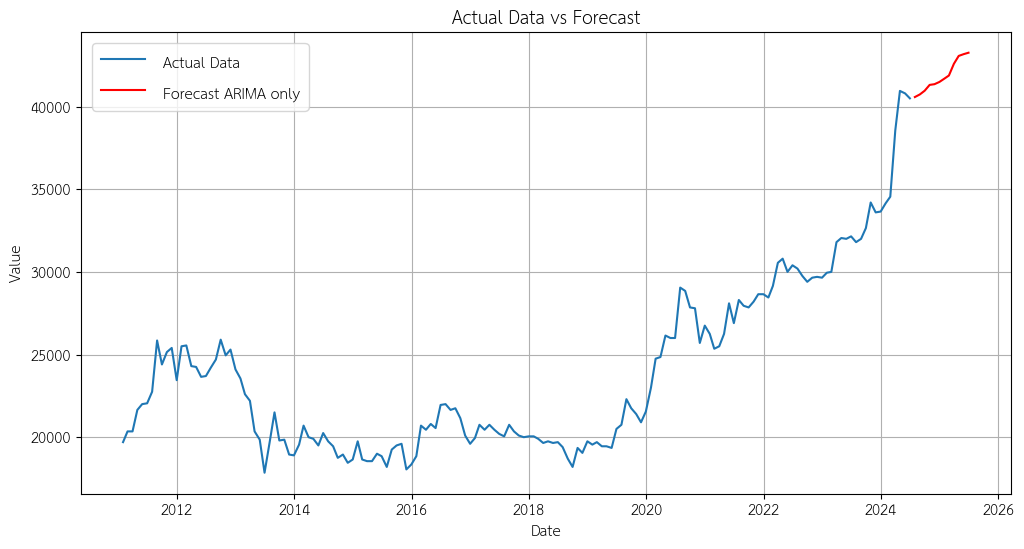

In [475]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict, label='Forecast ARIMA only' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [476]:
arima_only_predict

162    40578.481732
163    40736.651818
164    40960.021466
165    41313.790237
166    41356.049991
167    41492.486889
168    41694.123350
169    41881.271018
170    42590.015182
171    43066.938681
172    43174.397997
173    43260.124125
dtype: float64

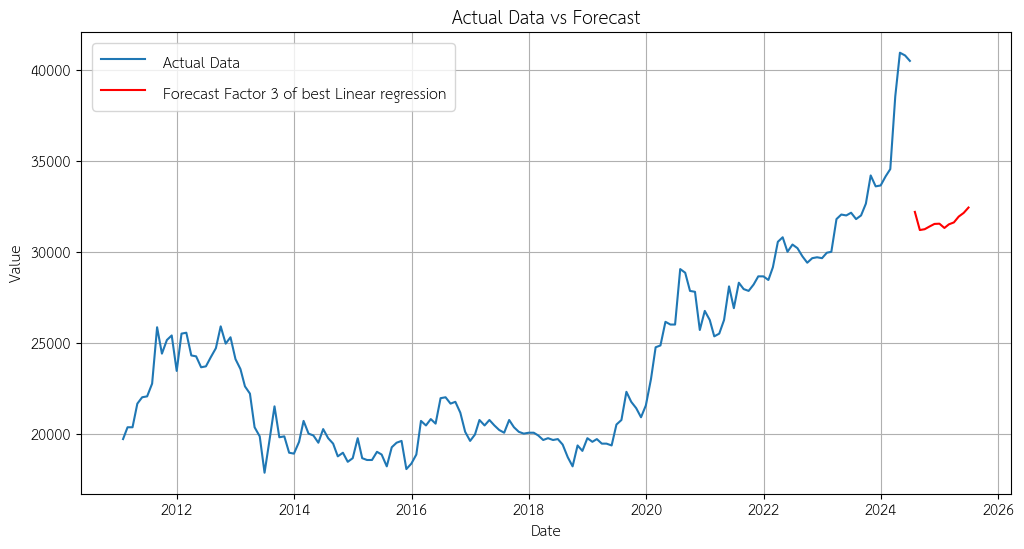

In [477]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [480]:
np.exp(y_pred_linear)

array([[32195.59555689],
       [31198.02146797],
       [31242.79926276],
       [31395.06953267],
       [31533.64619393],
       [31546.61768269],
       [31311.90528419],
       [31511.78838731],
       [31617.04061524],
       [31937.82531439],
       [32139.90576061],
       [32435.47825258]])

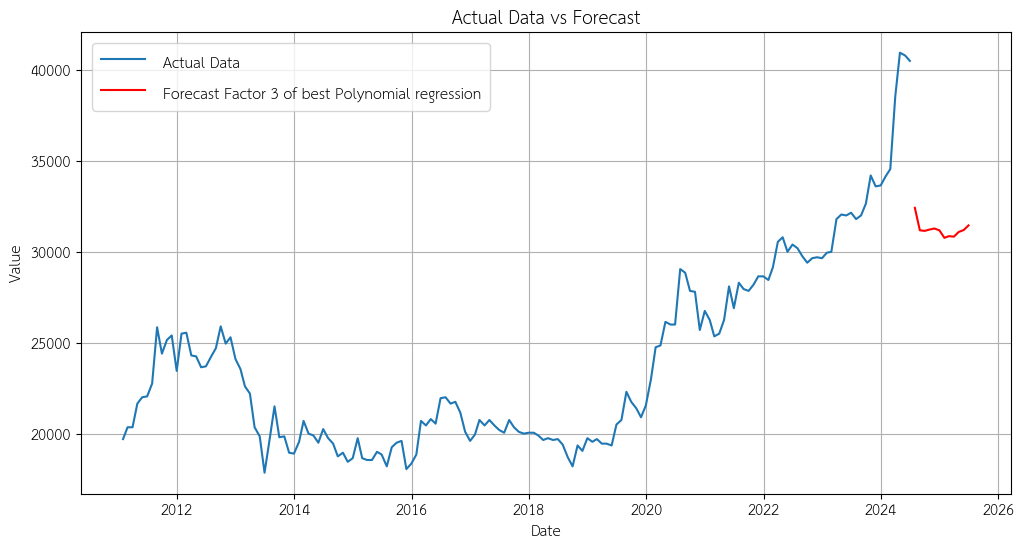

In [481]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [482]:
np.exp(Predict_Poly)

array([[32418.3994927 ],
       [31183.8199117 ],
       [31150.74220036],
       [31225.79969537],
       [31282.28728854],
       [31180.38834856],
       [30769.58213897],
       [30860.893958  ],
       [30834.0651881 ],
       [31090.60469646],
       [31197.37974803],
       [31451.30443252]])

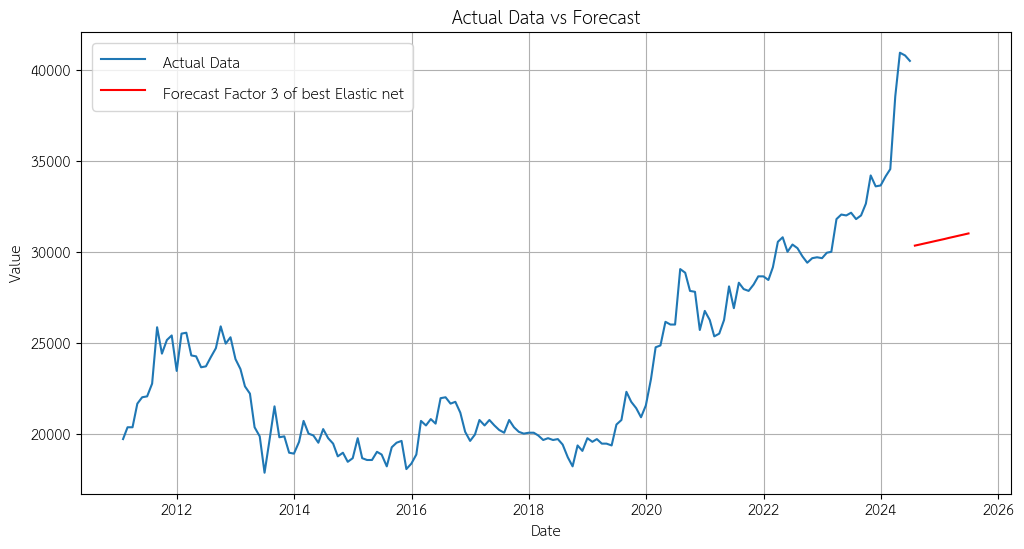

In [483]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [484]:
np.exp(y_pred_elastic_net)

array([30340.85144675, 30400.99115594, 30461.27586038, 30521.70596083,
       30582.28185928, 30643.00395895, 30703.87266431, 30764.8883811 ,
       30826.05151626, 30887.36247805, 30948.82167593, 31010.42952067])

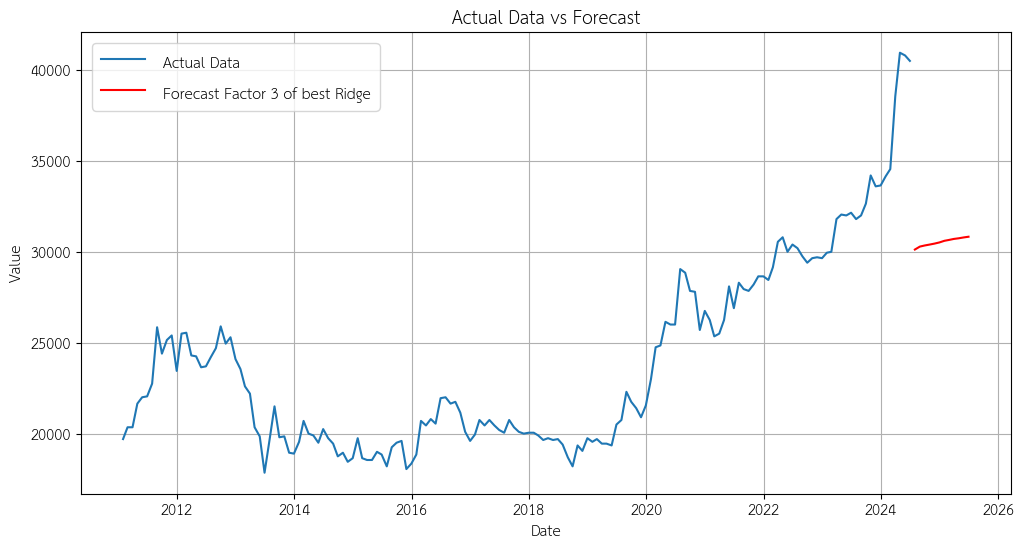

In [485]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [486]:
np.exp(y_pred_ridge)

array([[30124.2123937 ],
       [30286.7083563 ],
       [30348.01617528],
       [30398.84093668],
       [30451.20131715],
       [30516.11262071],
       [30605.7905416 ],
       [30652.4639365 ],
       [30708.72740671],
       [30743.90533367],
       [30791.05102997],
       [30829.3391748 ]])

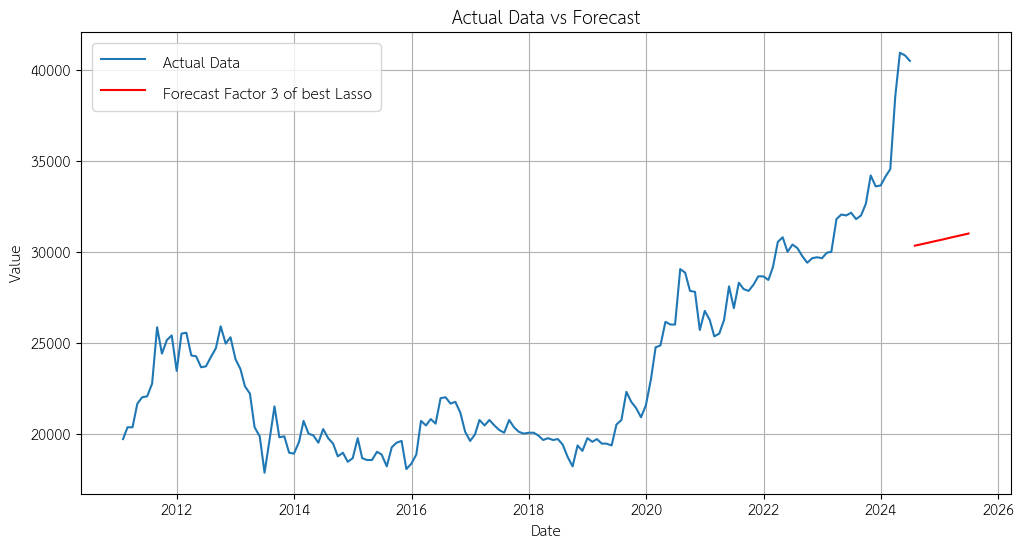

In [487]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [488]:
np.exp(y_pred_lasso)

array([30338.00678908, 30397.88467477, 30457.9064185 , 30518.07241664,
       30578.38306676, 30638.83876765, 30699.43991934, 30760.18692309,
       30821.08018137, 30882.12009791, 30943.30707768, 31004.6415269 ])

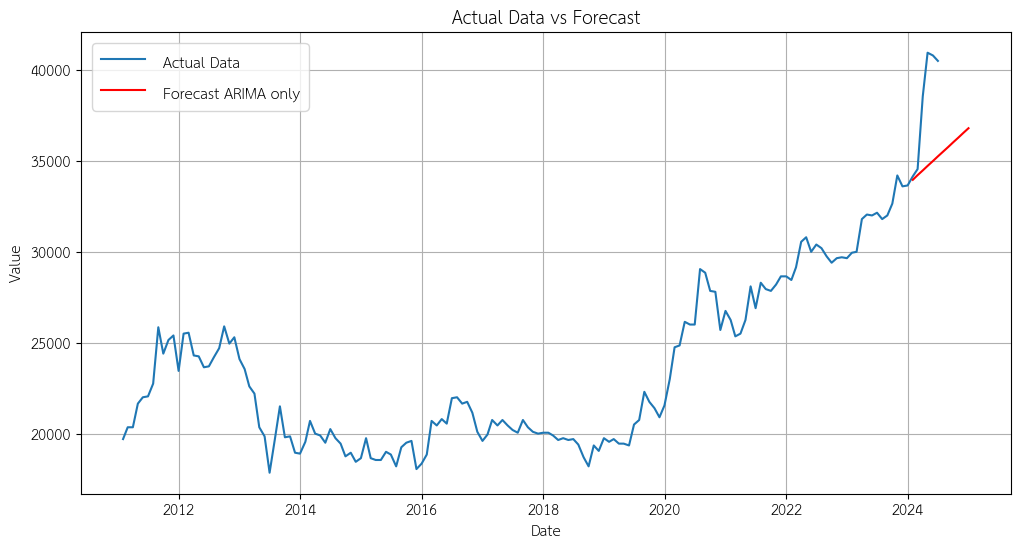

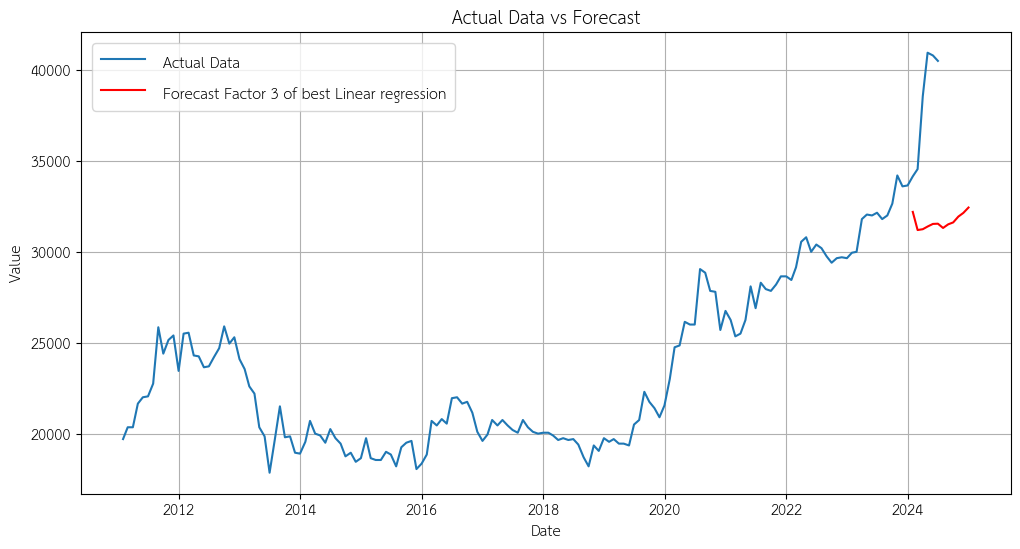

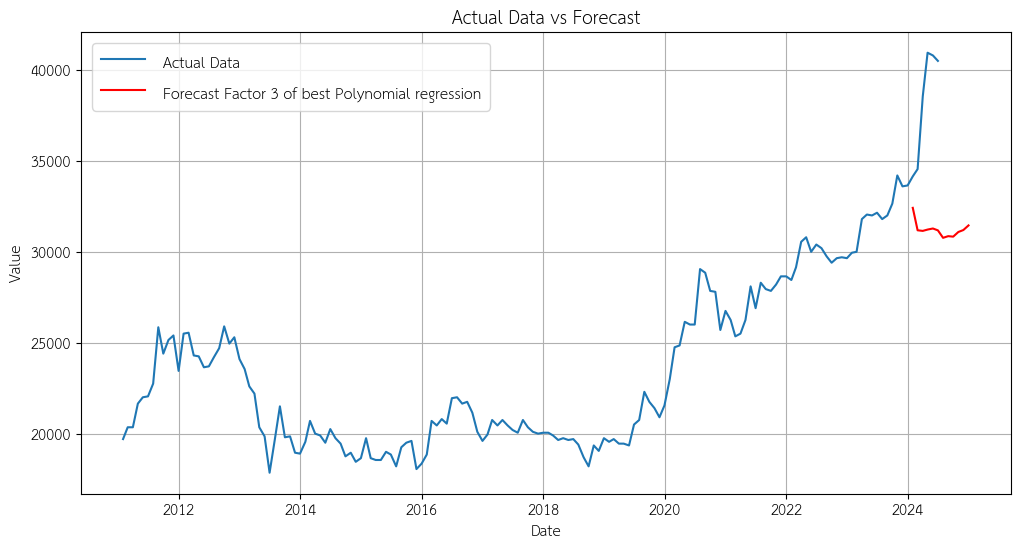

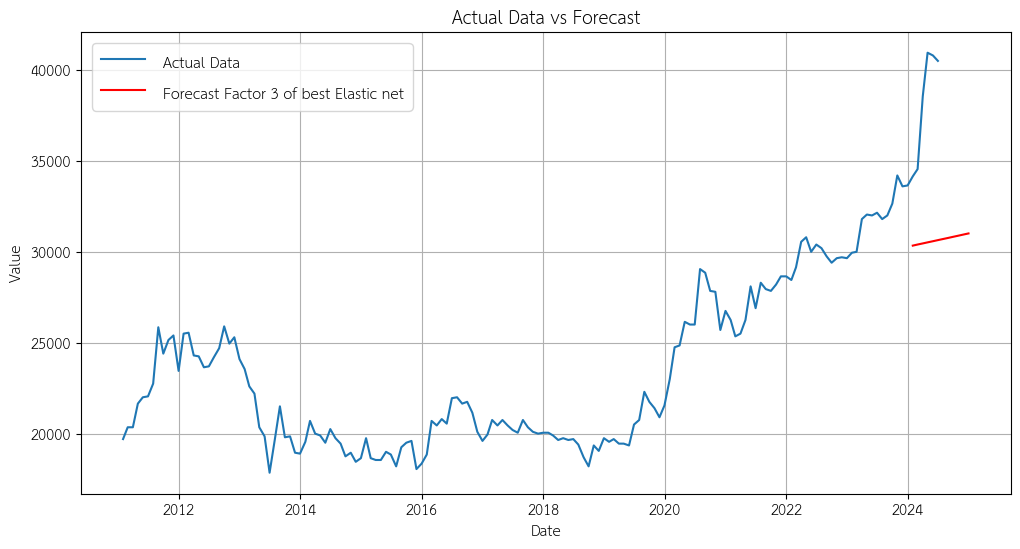

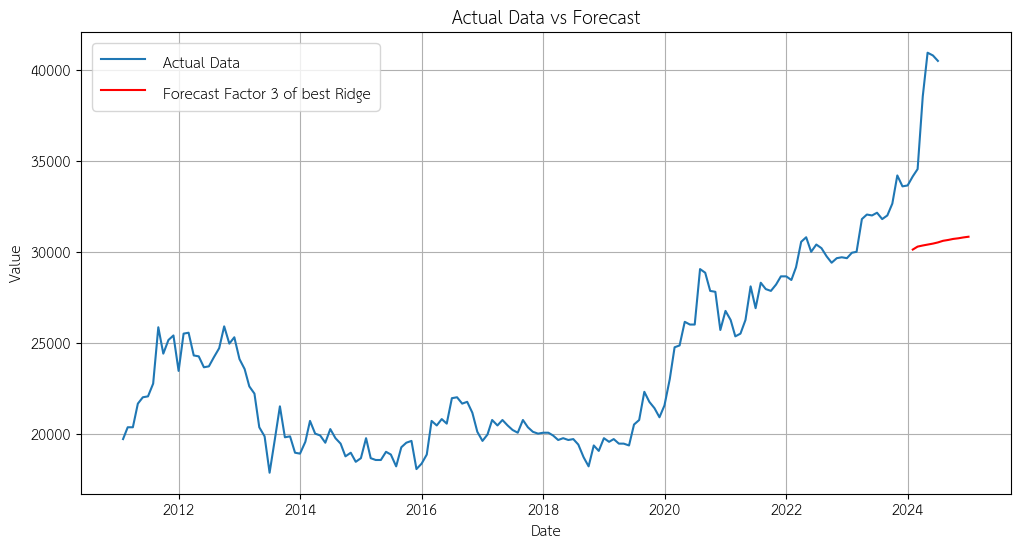

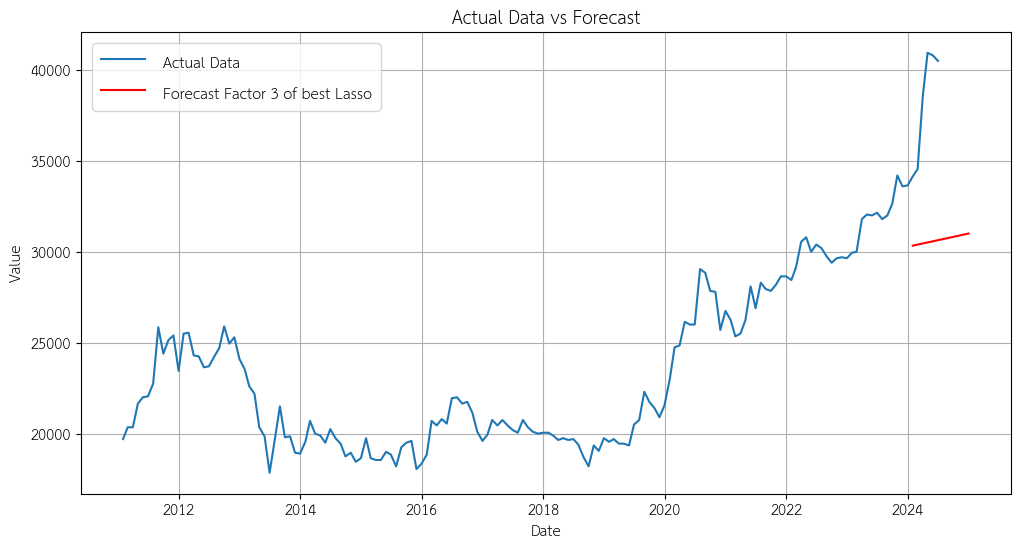

In [785]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,arima_only_predict, label='Forecast ARIMA only' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso' , color = 'red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()

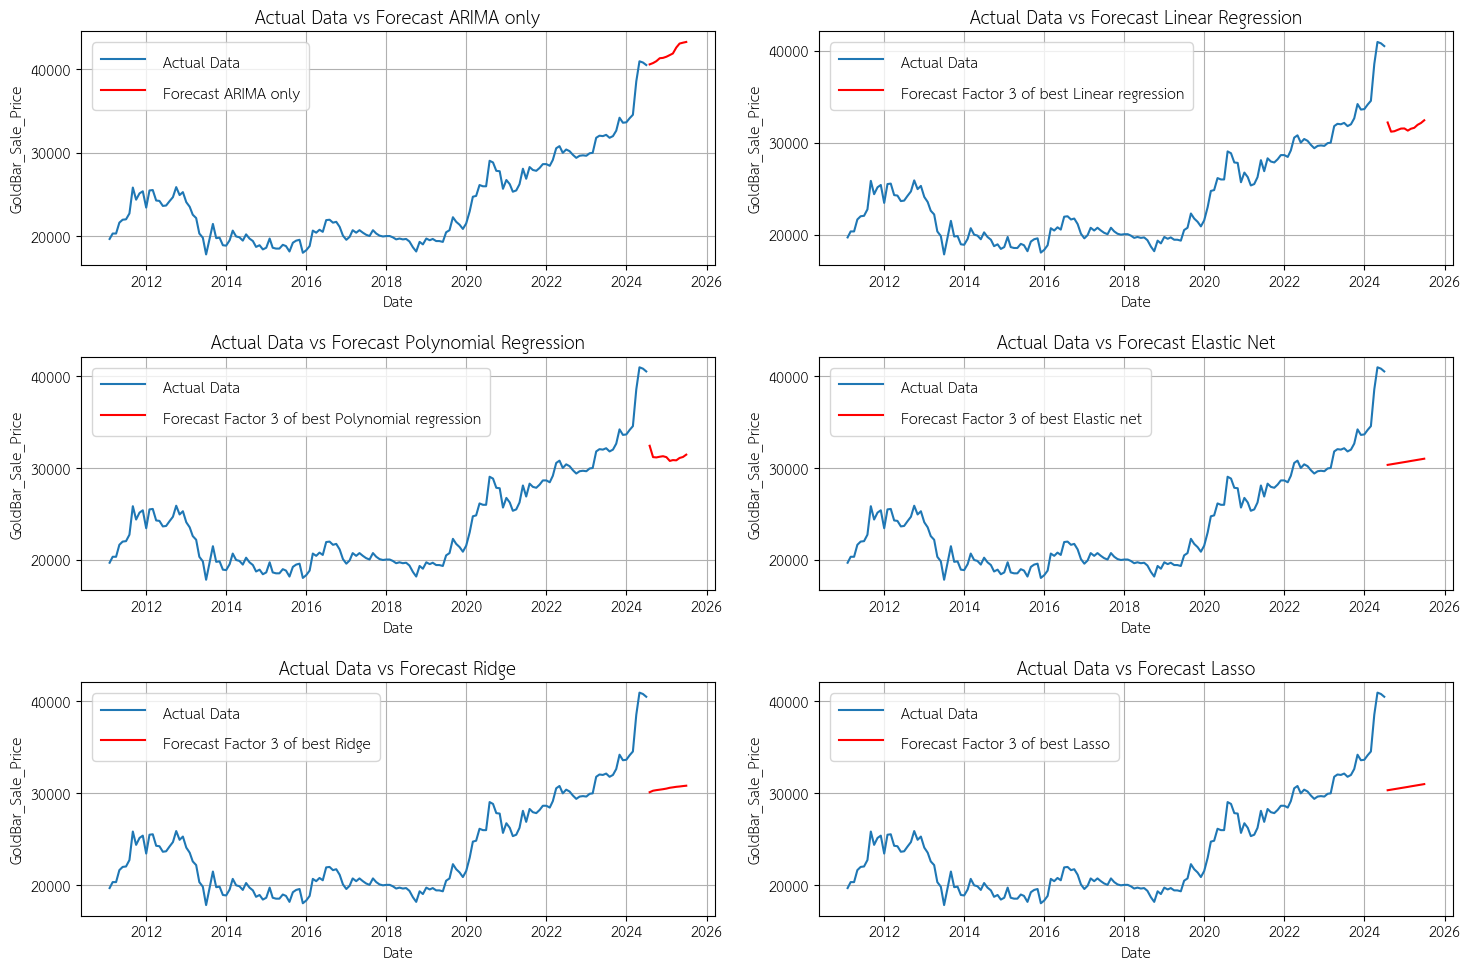

In [490]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # สร้างพื้นที่สำหรับ subplot 3 แถว 2 คอลัมน์
y_tag_label = 'GoldBar_Sale_Price'
# กราฟที่ 1: ARIMA
axs[0, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[0, 0].plot(Date_forecast_period, arima_only_predict, label='Forecast ARIMA only', color='red')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel(y_tag_label)
axs[0, 0].set_title('Actual Data vs Forecast ARIMA only')
axs[0, 0].legend()
axs[0, 0].grid(True)

# กราฟที่ 2: Linear Regression
axs[0, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[0, 1].plot(Date_forecast_period, np.exp(y_pred_linear), label='Forecast Factor 3 of best Linear regression', color='red')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel(y_tag_label)
axs[0, 1].set_title('Actual Data vs Forecast Linear Regression')
axs[0, 1].legend()
axs[0, 1].grid(True)

# กราฟที่ 3: Polynomial Regression
axs[1, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[1, 0].plot(Date_forecast_period, np.exp(Predict_Poly), label='Forecast Factor 3 of best Polynomial regression', color='red')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel(y_tag_label)
axs[1, 0].set_title('Actual Data vs Forecast Polynomial Regression')
axs[1, 0].legend()
axs[1, 0].grid(True)

# กราฟที่ 4: Elastic Net
axs[1, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[1, 1].plot(Date_forecast_period, np.exp(y_pred_elastic_net), label='Forecast Factor 3 of best Elastic net', color='red')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel(y_tag_label)
axs[1, 1].set_title('Actual Data vs Forecast Elastic Net')
axs[1, 1].legend()
axs[1, 1].grid(True)

# กราฟที่ 5: Ridge
axs[2, 0].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[2, 0].plot(Date_forecast_period, np.exp(y_pred_ridge), label='Forecast Factor 3 of best Ridge', color='red')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel(y_tag_label)
axs[2, 0].set_title('Actual Data vs Forecast Ridge')
axs[2, 0].legend()
axs[2, 0].grid(True)

# กราฟที่ 6: Lasso
axs[2, 1].plot(Gold_data['Report Date'], Gold_data['GoldBar_Sale'], label='Actual Data')
axs[2, 1].plot(Date_forecast_period, np.exp(y_pred_lasso), label='Forecast Factor 3 of best Lasso', color='red')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel(y_tag_label)
axs[2, 1].set_title('Actual Data vs Forecast Lasso')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()


In [782]:
# import pmdarima as pm
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # ข้อมูลตัวอย่าง (ใช้ข้อมูลจริงแทน)
# data = pd.Series([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140])

# # สร้างโมเดล ARIMA ด้วย pmdarima
# model = pm.auto_arima(data, seasonal=False, stepwise=True, trace=True)

# # ทำนายค่าในอนาคต (เช่น 10 periods)
# n_periods = 10
# forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)  # alpha=0.05 สำหรับ 95% confidence interval

# # คำนวณเปอร์เซ็นไทล์
# percentile_10 = np.percentile(conf_int, 10, axis=1)
# percentile_90 = np.percentile(conf_int, 90, axis=1)

# # กำหนด base case, best case, และ worst case
# base_case = forecast
# best_case = percentile_90  # 90th percentile สำหรับกรณีที่ดีที่สุด
# worst_case = percentile_10  # 10th percentile สำหรับกรณีที่เลวร้ายที่สุด

# # สร้างลำดับเวลา (time index) สำหรับการทำนาย
# index_of_fc = np.arange(len(data), len(data) + n_periods)

# # เพิ่มจุดข้อมูลสุดท้ายของข้อมูลจริงลงในกราฟการทำนายเพื่อให้กราฟต่อเนื่อง
# last_data_point = data.iloc[-1]
# extended_data = np.append(data.values, [last_data_point])
# extended_base_case = np.append([last_data_point], base_case)
# extended_best_case = np.append([last_data_point], best_case)
# extended_worst_case = np.append([last_data_point], worst_case)

# # แสดงผลการทำนาย
# plt.figure(figsize=(12,6))
# plt.plot(data, label='Historical Data')
# plt.plot(np.arange(len(data), len(data) + n_periods), base_case, label='Base Case', color='blue')
# plt.fill_between(np.arange(len(data), len(data) + n_periods), worst_case, best_case, color='pink', alpha=0.3, label='Percentile Interval')
# plt.plot(np.append(len(data)-1, np.arange(len(data), len(data) + n_periods)), np.append(data.iloc[-1], base_case), label='Base Case Continuation', color='blue', linestyle='--')
# plt.legend()
# plt.title('ARIMA Forecast with Base, Best, and Worst Case Scenarios (Percentile)')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.show()


# pmdarima ตัวแปร test

In [15]:
Factor_test = Factor_data
Factor_test = Factor_test[Factor_test['Report Date'] >= '2021-01-31']

In [43]:
arima = pm.auto_arima(Factor_test['ยูโรต่อดอลลาร์(USD)'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=True, suppress_warnings=True, stepwise = True, d=0,
                     error_action='ignore', m=12)

preds, conf_int = arima.predict(n_periods=12, return_conf_int=True)
arima_only_predict = pd.DataFrame(preds)
arima_only_predict.columns = ['Predict']

arima_only_best_case = pd.DataFrame(conf_int[:, 1])  # upper bound ของ confidence interval
arima_only_worst_case = pd.DataFrame(conf_int[:, 0])  # lower bound ของ confidence interval
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-153.919, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-92.369, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-157.286, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-127.087, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=111.452, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-159.286, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-157.149, Time=0.35 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-155.293, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-157.552, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-157.643, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-127.605, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-158.438, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.241 seconds


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  82.643
Date:                Wed, 21 Aug 2024   AIC                           -159.286
Time:                        10:45:25   BIC                           -154.535
Sample:                             0   HQIC                          -157.628
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0741      0.059      1.262      0.207      -0.041       0.189
ar.L1          0.9343      0.052     17.899      0.000       0.832       1.037
sigma2         0.0006      0.000      3.163      0.002       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.85   Prob(JB):                         0.53
Heteroskedasticity (H):               1.04   Skew:                            -0.02
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
arima_only_predict

Predict
36  1.105220
37  1.106735
38  1.108149
39  1.109471
40  1.110706
41  1.111860
42  1.112938
43  1.113945
44  1.114886
45  1.115765
46  1.116587
47  1.117355

# ทดลอง feature selection ด้วย Lasso Regression

In [60]:
Factor_test_lasso = Factor_data[Factor_data['Report Date'] >= '2021-01-31']

In [85]:
Factor_test_lasso.replace([np.inf, -np.inf, np.nan],0,inplace=True)
Factor_test_lasso = Factor_test_lasso.dropna(axis='columns')

C:\Users\temp5\AppData\Local\Temp\ipykernel_9800\1141125010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Factor_test_lasso.replace([np.inf, -np.inf, np.nan],0,inplace=True)


In [86]:
# Factor_test_lasso[factor_columns_lasso]
Factor_test_lasso

Report Date  (Inflation)  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
120  2021-01-31         0.21              24.25              23.98      25.09   
121  2021-02-28         0.04              26.05              25.78      26.99   
122  2021-03-31         0.09              26.15              25.88      23.19   
123  2021-04-30         0.30              29.05              28.78      25.99   
124  2021-05-31         0.49              27.95              27.68      25.09   
125  2021-06-30         0.52              28.75              28.48      25.79   
126  2021-07-31         0.14              29.55              29.28      26.09   
127  2021-08-30         0.07              29.25              28.98      25.79   
128  2021-09-30         0.19              30.75              30.48      27.69   
129  2021-10-31         0.21              32.55              32.28      29.69   
130  2021-11-29         0.29              31.05              30.78      28.84   
131  2021-12-31         0.29              31.15              30.88      28.44   
132  2022-01-31         0.52              34.05              33.78      29.94   
133  2022-02-28         1.80              36.55              36.28      29.14   
134  2022-03-31         2.00              40.05              39.78      29.94   
135  2022-04-30         2.00              38.85              38.58      29.94   
136  2022-05-30         2.28              43.85              43.58      31.94   
137  2022-06-30         2.51              44.65              44.38      34.94   
138  2022-07-31         2.99              37.85              37.58      34.94   
139  2022-08-31         3.15              37.95              37.68      34.94   
140  2022-09-30         3.12              33.75              33.48      34.94   
141  2022-10-31         3.17              35.35              35.08      34.94   
142  2022-11-30         3.22              35.15              34.88      34.94   
143  2022-12-31         3.23              34.45              34.18      34.94   
144  2023-01-30         3.04              36.65              36.38      34.94   
145  2023-02-27         1.93              35.85              35.58      33.94   
146  2023-03-31         1.75              35.75              35.48      33.44   
147  2023-04-30         1.66              35.95              35.68      32.94   
148  2023-05-31         1.55              35.45              35.18      31.94   
149  2023-06-30         1.32              35.15              34.88      31.94   
150  2023-07-31         0.86              37.95              37.68      31.94   
151  2023-08-31         0.79              40.05              39.78      31.94   
152  2023-09-30         0.63              39.45              39.18      29.94   
153  2023-10-30         0.66              38.25              37.98      29.94   
154  2023-11-30         0.58              36.05              34.28      29.94   
155  2023-12-31         0.58              35.25              33.48      29.94   

     อัตราแลกเปลี่ยน_USD_THB  XAU_USD     CPI  น้ำมัน brent(USD)  SET Index  \
120                    29.86  1282.09   99.79              55.88    1466.98   
121                    30.47  1327.19   98.88              66.13    1496.78   
122                    31.24  1250.69   99.11              63.54    1587.21   
123                    31.14  1291.29  100.48              67.25    1583.13   
124                    31.19  1283.64   99.55              69.32    1593.59   
125                    32.02  1325.79   99.93              75.13    1587.79   
126                    32.89  1243.19   99.81              76.33    1521.92   
127                    32.22  1204.94   99.63              72.99    1638.75   
128                    33.67  1251.99  101.21              78.52    1605.68   
129                    33.29  1323.19  101.96              84.38    1623.43   
130                    33.71  1326.94  102.25              70.57    1568.69   
131                    33.23  1395.69  101.86             

In [87]:
Gold_test_lasso = Gold_Factor_data[Gold_Factor_data['Report Date'] <= '2023-12-31']
Gold_test_lasso = Gold_test_lasso[Gold_test_lasso['Report Date'] >= '2021-01-31']
Gold_test_lasso

Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy  \
120  2021-01-31         26250        26150         26750     25681.04   
121  2021-02-28         25350        25250         25850     24801.76   
122  2021-03-31         25500        25400         26000     24938.20   
123  2021-04-30         26250        26150         26750     25681.04   
124  2021-05-31         28100        28000         28600     27500.24   
125  2021-06-30         26900        26800         27400     26317.76   
126  2021-07-31         28300        28200         28800     27697.32   
127  2021-08-30         27950        27850         28450     27348.64   
128  2021-09-30         27850        27750         28350     27257.68   
129  2021-10-31         28200        28100         28700     27591.20   
130  2021-11-29         28650        28550         29150     28030.84   
131  2021-12-31         28650        28550         29150     28030.84   
132  2022-01-31         28450        28350         28950     27833.76   
133  2022-02-28         29150        29050         29650     28531.12   
134  2022-03-31         30550        30450         31050     29895.52   
135  2022-04-30         30800        30700         31300     30153.24   
136  2022-05-30         30000        29900         30500     29364.92   
137  2022-06-30         30400        30300         30900     29759.08   
138  2022-07-31         30200        30100         30700     29562.00   
139  2022-08-31         29750        29650         30250     29122.36   
140  2022-09-30         29400        29300         29900     28773.68   
141  2022-10-31         29650        29550         30150     29016.24   
142  2022-11-30         29700        29600         30200     29061.72   
143  2022-12-31         29650        29550         30150     29016.24   
144  2023-01-30         29950        29850         30450     29319.44   
145  2023-02-27         30000        29900         30500     29364.92   
146  2023-03-31         31800        31700         32300     31123.48   
147  2023-04-30         32050        31950         32550     31381.20   
148  2023-05-31         32000        31900         32500     31320.56   
149  2023-06-30         32150        32050         32650     31472.16   
150  2023-07-31         31800        31700         32300     31123.48   
151  2023-08-31         32000        31900         32500     31320.56   
152  2023-09-30         32650        32550         33150     31957.28   
153  2023-10-30         34200        34100         34700     33488.44   
154  2023-11-30         33600        33500         34100     32897.20   
155  2023-12-31         33650        33550         34150     32942.68   

     (Inflation)  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
120         0.21              24.25              23.98      25.09   
121         0.04              26.05              25.78      26.99   
122         0.09              26.15              25.88      23.19   
123         0.30              29.05              28.78      25.99   
124         0.49              27.95              27.68      25.09   
125         0.52              28.75              28.48      25.79   
126         0.14              29.55              29.28      26.09   
127         0.07              29.25              28.98      25.79   
128         0.19              30.75              30.48      27.69   
129         0.21              32.55              32.28      29.69   
130         0.29              31.05              30.78      28.84   
131         0.29              31.15              30.88      28.44   
132         0.52              34.05              33.78      29.94   
133         1.80              36.55              36.28      29.14   
134         2.00              40.05              39.78      29.94   
135         2.00              38.85              38.58      29.94   
136         2.28              43.85              43.58      31.94   
137         2.51              44.65              44.38      

In [90]:
from sklearn.linear_model import Lasso
# X = Factor_test_lasso[['(Inflation)','CPI']]
X = Factor_test_lasso[factor_columns_lasso]
y = pd.DataFrame((Gold_test_lasso['GoldBar_Sale'].values),columns=['Y'])

lasso_model = Lasso(alpha=0.1)  # alpha คือค่า penalty
lasso_model.fit(X, y)
y_pred_test_lasso = lasso_model.predict(X)
# print("Coef of x1 , x2 , x3 : ",lasso_model.coef_)
for index,i in enumerate(factor_columns_lasso,1):
    print(i," : ",lasso_model.coef_[index])
print("Intercept : ",lasso_model.intercept_)
print("R-squared : ",lasso_model.score(X,y))
adj_r2_lasso = 1 - ( ((1 - lasso_model.score(X,y))*(36 - 1)) / (36 - 2 - 1) )
print("Adj-R-squared : ",adj_r2_lasso)
# y_pred_lasso = lasso_model.predict(output3_base[Factor_interested])
# print("MAE : ",metrics.mean_absolute_error(y,y_pred_test_lasso))
# print("MAPE : ",metrics.mean_absolute_percentage_error(y,y_pred_test_lasso))
# print("MSE : ",metrics.mean_squared_error(y,y_pred_test_lasso))
# print("RMSE : " ,np.sqrt(metrics.mean_squared_error(y,y_pred_test_lasso)))

(Inflation)  :  243.8243312037458
PTT_แก๊สโซฮอล์_95  :  -5.5040004756518535
PTT_แก๊สโซฮอล์_91  :  -16.979117053553253
PTT_ดีเซล  :  219.95580250337218
อัตราแลกเปลี่ยน_USD_THB  :  1.444504116664511
XAU_USD  :  0.0
CPI  :  -52.838435614420796
น้ำมัน brent(USD)  :  -7.655732927948412
SET Index  :  -10.521303472659584
Core_CPI  :  152.2180824140687
ดัชนีอัตราเงินเฟ้อคาดการณ์ USA  :  -0.0
ยูโรต่อดอลลาร์(USD)  :  -0.0
ฮ่องกงต่อดอลลาร์(USD)  :  0.1620078472052987
ดัชนี Dow jones(USD)  :  16.600199027949195
ราคาน้ำมันดิบ(USD) West Texas Intermediate  :  -123.2925194201662
(Inflation)_LAG_1  :  46.2906958539741
PTT_แก๊สโซฮอล์_95_LAG_1  :  0.0
PTT_แก๊สโซฮอล์_91_LAG_1  :  -12.423032668359594
PTT_ดีเซล_LAG_1  :  50.77918447196588
อัตราแลกเปลี่ยน_USD_THB_LAG_1  :  -0.9915566435579041
XAU_USD_LAG_1  :  17.563225860118436
CPI_LAG_1  :  -5.470506685757713
น้ำมัน brent(USD)_LAG_1  :  -0.36932810705540775
SET Index_LAG_1  :  -1.077753843920504
Core_CPI_LAG_1  :  11.033915375003158
ดัชนีอัตราเงินเฟ้อคาดก

IndexError: index 525 is out of bounds for axis 0 with size 525

In [91]:
for index,i in enumerate(factor_columns_lasso,1):
    print(i," : ",lasso_model.coef_[index])

(Inflation)  :  243.8243312037458
PTT_แก๊สโซฮอล์_95  :  -5.5040004756518535
PTT_แก๊สโซฮอล์_91  :  -16.979117053553253
PTT_ดีเซล  :  219.95580250337218
อัตราแลกเปลี่ยน_USD_THB  :  1.444504116664511
XAU_USD  :  0.0
CPI  :  -52.838435614420796
น้ำมัน brent(USD)  :  -7.655732927948412
SET Index  :  -10.521303472659584
Core_CPI  :  152.2180824140687
ดัชนีอัตราเงินเฟ้อคาดการณ์ USA  :  -0.0
ยูโรต่อดอลลาร์(USD)  :  -0.0
ฮ่องกงต่อดอลลาร์(USD)  :  0.1620078472052987
ดัชนี Dow jones(USD)  :  16.600199027949195
ราคาน้ำมันดิบ(USD) West Texas Intermediate  :  -123.2925194201662
(Inflation)_LAG_1  :  46.2906958539741
PTT_แก๊สโซฮอล์_95_LAG_1  :  0.0
PTT_แก๊สโซฮอล์_91_LAG_1  :  -12.423032668359594
PTT_ดีเซล_LAG_1  :  50.77918447196588
อัตราแลกเปลี่ยน_USD_THB_LAG_1  :  -0.9915566435579041
XAU_USD_LAG_1  :  17.563225860118436
CPI_LAG_1  :  -5.470506685757713
น้ำมัน brent(USD)_LAG_1  :  -0.36932810705540775
SET Index_LAG_1  :  -1.077753843920504
Core_CPI_LAG_1  :  11.033915375003158
ดัชนีอัตราเงินเฟ้อคาดก

IndexError: index 525 is out of bounds for axis 0 with size 525

# Test Neural Network for Feature Selection

In [87]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [559]:
Gold_test_nn = Gold_Factor_data[Gold_Factor_data['Report Date'] <= '2023-12-31']
Gold_test_nn = Gold_test_nn[Gold_test_nn['Report Date'] >= '2021-01-31']
Gold_test_nn

Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy  \
120  2021-01-31         26250        26150         26750     25681.04   
121  2021-02-28         25350        25250         25850     24801.76   
122  2021-03-31         25500        25400         26000     24938.20   
123  2021-04-30         26250        26150         26750     25681.04   
124  2021-05-31         28100        28000         28600     27500.24   
125  2021-06-30         26900        26800         27400     26317.76   
126  2021-07-31         28300        28200         28800     27697.32   
127  2021-08-30         27950        27850         28450     27348.64   
128  2021-09-30         27850        27750         28350     27257.68   
129  2021-10-31         28200        28100         28700     27591.20   
130  2021-11-29         28650        28550         29150     28030.84   
131  2021-12-31         28650        28550         29150     28030.84   
132  2022-01-31         28450        28350         28950     27833.76   
133  2022-02-28         29150        29050         29650     28531.12   
134  2022-03-31         30550        30450         31050     29895.52   
135  2022-04-30         30800        30700         31300     30153.24   
136  2022-05-30         30000        29900         30500     29364.92   
137  2022-06-30         30400        30300         30900     29759.08   
138  2022-07-31         30200        30100         30700     29562.00   
139  2022-08-31         29750        29650         30250     29122.36   
140  2022-09-30         29400        29300         29900     28773.68   
141  2022-10-31         29650        29550         30150     29016.24   
142  2022-11-30         29700        29600         30200     29061.72   
143  2022-12-31         29650        29550         30150     29016.24   
144  2023-01-30         29950        29850         30450     29319.44   
145  2023-02-27         30000        29900         30500     29364.92   
146  2023-03-31         31800        31700         32300     31123.48   
147  2023-04-30         32050        31950         32550     31381.20   
148  2023-05-31         32000        31900         32500     31320.56   
149  2023-06-30         32150        32050         32650     31472.16   
150  2023-07-31         31800        31700         32300     31123.48   
151  2023-08-31         32000        31900         32500     31320.56   
152  2023-09-30         32650        32550         33150     31957.28   
153  2023-10-30         34200        34100         34700     33488.44   
154  2023-11-30         33600        33500         34100     32897.20   
155  2023-12-31         33650        33550         34150     32942.68   

     Inflation  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
120       0.21              24.25              23.98      25.09   
121       0.04              26.05              25.78      26.99   
122       0.09              26.15              25.88      23.19   
123       0.30              29.05              28.78      25.99   
124       0.49              27.95              27.68      25.09   
125       0.52              28.75              28.48      25.79   
126       0.14              29.55              29.28      26.09   
127       0.07              29.25              28.98      25.79   
128       0.19              30.75              30.48      27.69   
129       0.21              32.55              32.28      29.69   
130       0.29              31.05              30.78      28.84   
131       0.29              31.15              30.88      28.44   
132       0.52              34.05              33.78      29.94   
133       1.80              36.55              36.28      29.14   
134       2.00              40.05              39.78      29.94   
135       2.00              38.85              38.58      29.94   
136       2.28              43.85              43.58      31.94   
137       2.51              44.65              44.38      34.94   
138       2.99              3

In [657]:
# X = pd.DataFrame(Gold_test_nn[Pass_Factor_list_GB_S])
X = pd.DataFrame(Gold_test_nn[['LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7','%CHANGE_Core_CPI_LAG_12']])
y = pd.DataFrame(Gold_test_nn['GoldBar_Sale'].values)

In [658]:
X
y

0
0   26250
1   25350
2   25500
3   26250
4   28100
5   26900
6   28300
7   27950
8   27850
9   28200
10  28650
11  28650
12  28450
13  29150
14  30550
15  30800
16  30000
17  30400
18  30200
19  29750
20  29400
21  29650
22  29700
23  29650
24  29950
25  30000
26  31800
27  32050
28  32000
29  32150
30  31800
31  32000
32  32650
33  34200
34  33600
35  33650

Test 1 

In [659]:
# pipeline = Pipeline([
#     ('scaler',StandardScaler()),
#     ('feature_selection',Lasso(alpha=0.01)),
#     ('regressor'),MLPRegressor(hidden_layer_sizes=(64,32),max_iter=100,random_state=42)
# ])

In [660]:
# pipeline.fit(X, y)

Test 2

In [661]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X)

In [662]:
# lasso = Lasso(alpha=0.01)
# lasso.fit(X_train_scaled,y)

In [663]:
# selected_features = np.flatnonzero(lasso.coef_)
# X_train_selected = X_train_scaled[:,selected_features]

In [664]:
# lasso.coef_

In [665]:
# print('Selected Features', selected_features)

In [666]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(Factor_ARIMA[['LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7','%CHANGE_Core_CPI_LAG_12']])

In [667]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128,64,32),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate='adaptive',
    # learning_rate='constant',
    max_iter=2000,
    random_state=42)
mlp.fit(X_train, y)

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.01, hidden_layer_sizes=(128, 64, 32),
             learning_rate='adaptive', max_iter=2000, random_state=42)

In [668]:

# ทำนายผลและประเมินโมเดล
y_pred = mlp.predict(X_train)
r2 = r2_score(y, y_pred)
print(f'R-squared: {r2:.4f}')

# แสดงตัวแปรที่ถูกเลือก
# lasso = pipeline.named_steps['feature_selection']
# selected_features = np.where(lasso.coef_ != 0)[0]
# print("Selected features:", selected_features)

R-squared: 0.2232


In [669]:
y_pred

array([21513.81636082, 21210.72412358, 25743.4819466 , 25896.94419371,
       26404.87852492, 28006.28005945, 28517.40221355, 27454.37889857,
       29472.05713477, 28994.669425  , 29816.43007763, 30303.01262628,
       29426.10868401, 28804.34951816, 29943.60485707, 30205.9267233 ,
       30533.9569274 , 30436.76938141, 31979.39407343, 32790.09303527,
       32653.40518185, 33140.22185514, 31443.79102118, 31574.96747359,
       30091.87317954, 31315.21400625, 31085.2528856 , 29876.18826393,
       29615.06767812, 31163.55158411, 30098.76684738, 32347.93959166,
       31278.12718215, 31751.01376228, 31207.06500968, 29995.1484356 ])

In [670]:
y_pred = mlp.predict(X_test)
# r2 = r2_score(y, y_pred)
# print(f'R-squared: {r2:.4f}')

In [671]:
y_pred

array([29081.58865518, 29849.24282506, 28590.9528421 , 28187.09023867,
       29263.64911047, 30311.42065085, 31538.29475697, 31360.18592788,
       31645.27565956, 31218.89831046, 29603.68676292, 29647.3841622 ])

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

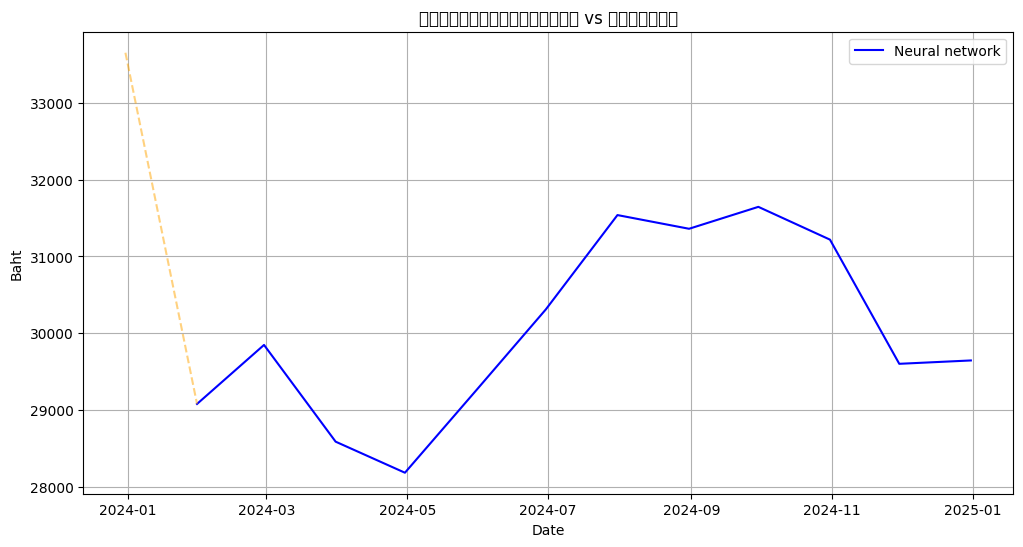

In [672]:
plt.figure(figsize=(12,6))
plt.plot(Date_forecast_period,(y_pred), label='Neural network' , color = 'blue')
plt.plot([Gold_Factor_data['Report Date'].iloc[-1],Date_forecast_period['Report Date'].iloc[0]],
         [(Gold_Factor_data['GoldBar_Sale'].iloc[-1].astype(float),(y_pred[0]))][0], 
         color = 'orange',linestyle='--',alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Baht')
plt.title('ราคาขายทองคำแท่ง vs พยากรณ์')
plt.legend()
plt.grid(True)
plt.show()

# Gaussian Process Regression 

In [79]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C , Matern
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

In [84]:
Gold_test_gp = Gold_Factor_data[Gold_Factor_data['Report Date'] <= '2023-12-31']
Gold_test_gp = Gold_test_gp[Gold_test_gp['Report Date'] >= '2021-01-31']
Gold_test_gp = Gold_test_gp.drop(columns = ['Unnamed: 0'])
Gold_test_gp

Report Date  GoldBar_Sale  GoldBar_Buy  GoldJew_Sale  GoldJew_Buy  \
0   2021-01-31         26250        26150         26750     25681.04   
1   2021-02-28         25350        25250         25850     24801.76   
2   2021-03-31         25500        25400         26000     24938.20   
3   2021-04-30         26250        26150         26750     25681.04   
4   2021-05-31         28100        28000         28600     27500.24   
5   2021-06-30         26900        26800         27400     26317.76   
6   2021-07-31         28300        28200         28800     27697.32   
7   2021-08-30         27950        27850         28450     27348.64   
8   2021-09-30         27850        27750         28350     27257.68   
9   2021-10-31         28200        28100         28700     27591.20   
10  2021-11-29         28650        28550         29150     28030.84   
11  2021-12-31         28650        28550         29150     28030.84   
12  2022-01-31         28450        28350         28950     27833.76   
13  2022-02-28         29150        29050         29650     28531.12   
14  2022-03-31         30550        30450         31050     29895.52   
15  2022-04-30         30800        30700         31300     30153.24   
16  2022-05-30         30000        29900         30500     29364.92   
17  2022-06-30         30400        30300         30900     29759.08   
18  2022-07-31         30200        30100         30700     29562.00   
19  2022-08-31         29750        29650         30250     29122.36   
20  2022-09-30         29400        29300         29900     28773.68   
21  2022-10-31         29650        29550         30150     29016.24   
22  2022-11-30         29700        29600         30200     29061.72   
23  2022-12-31         29650        29550         30150     29016.24   
24  2023-01-30         29950        29850         30450     29319.44   
25  2023-02-27         30000        29900         30500     29364.92   
26  2023-03-31         31800        31700         32300     31123.48   
27  2023-04-30         32050        31950         32550     31381.20   
28  2023-05-31         32000        31900         32500     31320.56   
29  2023-06-30         32150        32050         32650     31472.16   
30  2023-07-31         31800        31700         32300     31123.48   
31  2023-08-31         32000        31900         32500     31320.56   
32  2023-09-30         32650        32550         33150     31957.28   
33  2023-10-30         34200        34100         34700     33488.44   
34  2023-11-30         33600        33500         34100     32897.20   
35  2023-12-31         33650        33550         34150     32942.68   

    Inflation  PTT_แก๊สโซฮอล์_95  PTT_แก๊สโซฮอล์_91  PTT_ดีเซล  \
0        0.21              24.25              23.98      25.09   
1        0.04              26.05              25.78      26.99   
2        0.09              26.15              25.88      23.19   
3        0.30              29.05              28.78      25.99   
4        0.49              27.95              27.68      25.09   
5        0.52              28.75              28.48      25.79   
6        0.14              29.55              29.28      26.09   
7        0.07              29.25              28.98      25.79   
8        0.19              30.75              30.48      27.69   
9        0.21              32.55              32.28      29.69   
10       0.29              31.05              30.78      28.84   
11       0.29              31.15              30.88      28.44   
12       0.52              34.05              33.78      29.94   
13       1.80              36.55              36.28      29.14   
14       2.00              40.05              39.78      29.94   
15       2.00              38.85              38.58      29.94   
16       2.28              43.85              43.58      31.94   
17       2.51              44.65              44.38      34.94   
18       2.99              37.85              37.58      34.94   
19       3.15     

In [85]:
# X = pd.DataFrame(Gold_test_nn[Pass_Factor_list_GB_S])
X = pd.DataFrame(Gold_test_gp[['Inflation_LAG_10','LOG_น้ำมัน_brent_USD_LAG_2','%CHANGE_Core_CPI_LAG_8']])
y = pd.DataFrame(Gold_test_gp['GoldBar_Sale'].values)

In [88]:
scaler = MinMaxScaler()

In [89]:
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(Factor_ARIMA[['Inflation_LAG_10','LOG_น้ำมัน_brent_USD_LAG_2','%CHANGE_Core_CPI_LAG_8']])

In [90]:
# kernel = C(1.0,(1e-3,1e3)) * RBF(1.0,(1e-2,1e2))
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=2.5)

In [91]:
gpr = GaussianProcessRegressor(kernel=kernel , n_restarts_optimizer=10)

In [92]:
gpr.fit(X_train_scaled,y)

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10)

In [93]:
y_pred , sigma = gpr.predict(X_train_scaled,return_std=True)

In [94]:
y_pred

array([26250.        , 25350.        , 25500.        , 26250.        ,
       28099.99999999, 26900.00000003, 28299.99999998, 27949.99999999,
       27850.00000002, 28200.        , 28649.99999999, 28650.        ,
       28450.        , 29150.        , 30550.        , 30800.        ,
       30000.        , 30400.        , 30200.        , 29750.        ,
       29400.        , 29650.        , 29700.        , 29650.        ,
       29949.99999999, 30000.00000001, 31800.        , 32050.        ,
       32000.        , 32149.99999999, 31800.        , 32000.        ,
       32650.00000007, 34199.99999994, 33600.        , 33650.        ])

In [95]:
sigma

array([1.00022206e-05, 1.00022206e-05, 1.00022206e-05, 1.00022206e-05,
       1.00022206e-05, 1.00079021e-05, 1.00022206e-05, 1.00079021e-05,
       1.00079021e-05, 1.00022206e-05, 1.00022206e-05, 1.00079021e-05,
       1.00022206e-05, 1.00135803e-05, 9.99084799e-06, 1.00022206e-05,
       1.00022206e-05, 1.00079021e-05, 9.99653592e-06, 1.00022206e-05,
       1.00135803e-05, 9.99084799e-06, 1.00135803e-05, 1.00079021e-05,
       1.00079021e-05, 1.00022206e-05, 1.00079021e-05, 9.99653592e-06,
       1.00022206e-05, 1.00022206e-05, 1.00022206e-05, 9.99084799e-06,
       9.99084799e-06, 1.00192553e-05, 1.00022206e-05, 9.99653592e-06])

In [96]:
y_pred_1,sigma = gpr.predict(X_test_scaled,return_std=True)

In [97]:
y_pred_1

array([30907.00150843, 25832.66698076, 28367.33273396, 27368.37738357,
       25616.27185286, 23811.17782259, 26204.50107806, 25641.61786031,
       25799.8654042 , 24889.79097689, 21235.3204381 ,  9516.11545914])

In [98]:
sigma

array([12.82406542, 21.78570466, 18.80697754, 21.2948108 , 20.04479265,
       21.73187047, 16.0241868 , 17.68407574, 16.77659804, 18.44451513,
       23.38072681, 29.91252842])

# ทบทวน หาปัญหา Outlier ในข้อมูล (ไม่น่าจะมี)

# เช็ค Stats

In [673]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import anderson as AD
from statsmodels.stats.outliers_influence import variance_inflation_factor

test_stats_results_GB_S = pd.DataFrame()
y_train = np.array(Gold_Factor_data['GB_S'].values , dtype=float)
selected_Factor = list(['LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10','%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7','%CHANGE_Core_CPI_LAG_12','Inflation_LAG_10'])
X_train = np.array(Gold_Factor_data[selected_Factor].values , dtype = float)
linear_model = LinearRegression()
linear_model.fit(X_train , y_train)
X_train = sm.add_constant(X_train)
reg = sm.OLS(y_train , X_train).fit()
X_train = X_train[:,1:]
y_pred = linear_model.predict(X_train)
stats_results = pd.DataFrame()
stats_results[[f'FACTOR_{i+1}' for i in range(len(selected_Factor))]] = np.array([selected_Factor])

coeff_result = reg.summary2().tables[1].iloc[:,:1].transpose().reset_index(drop=True)
for i in ['const','x1','x2','x3']:
    if i in coeff_result.columns:
        stats_results[i] = coeff_result[i]
    else:
        stats_results[i] = None
# P-Value
stats_results[['intercept_p_value'] + [f'FACTOR_{i+1}_p_value' for i in range(len(selected_Factor))]] = reg.pvalues
# ADJ Rsq
r2 = r2_score(y_train,y_pred)
n , p = X_train.shape
adj_r2 = 1 - (( 1 - r2 ) * (n - 1) / (n - p - 1))
stats_results['r2'] = r2
stats_results['adj_r2'] = adj_r2
# F stats
stats_results['Probability of F-Stats'] = reg.summary2().tables[0][3].astype(float)[5]
# Anderson Darling
stats_results['AD'] = AD(reg.resid , dist='norm')[0]
stats_results['AD_criteria'] = [{i:j for i , j in zip(AD( reg.resid , dist='norm')[2],
                                                     AD( reg.resid , dist='norm')[1]
                                                     )}]
stats_results['AD_criteria_0.05'] = AD( reg.resid , dist='norm')[1][2:3]
# Breusch-Pagan
name_stats = ['Lagrange multiplier statistic','p-value','f-value','f p-value']
test = sm.stats.het_breuschpagan(reg.resid , reg.model.exog )
stats_results['BP_pvalues'] = lzip(name_stats , test )[1][1]
# Durbin Watson
stats_results['Durbin_Watson'] = sm.stats.durbin_watson(reg.resid)
# VIF
VIF_values = [variance_inflation_factor(Gold_Factor_data[selected_Factor].values , i) for i in range(len(selected_Factor))]
for in_index , i in enumerate(selected_Factor , 0 ):
    stats_results[f'VIF_Factor_{in_index+1}'] = VIF_values[in_index]
test_stats_results_GB_S = stats_results
# test_stats_results_GB_S = pd.concat([test_stats_results_GB_S, stats_results], axis = 0).reset_index(drop=True)
test_stats_results_GB_S = test_stats_results_GB_S.sort_values('adj_r2', ascending = False)

In [674]:
test_stats_results_GB_S

FACTOR_1  \
0  LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_...   

                                FACTOR_2                 FACTOR_3  \
0  %CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7  %CHANGE_Core_CPI_LAG_12   

           FACTOR_4         const           x1           x2           x3  \
0  Inflation_LAG_10  19170.884563  2196.854287  7193.907618  8434.704225   

   intercept_p_value  FACTOR_1_p_value  ...  Probability of F-Stats        AD  \
0           0.000003          0.016251  ...            3.100000e-11  0.312569   

                                         AD_criteria  AD_criteria_0.05  \
0  {15.0: 0.528, 10.0: 0.601, 5.0: 0.721, 2.5: 0....             0.721   

   BP_pvalues  Durbin_Watson  VIF_Factor_1 VIF_Factor_2  VIF_Factor_3  \
0     0.70267       0.743502      3.188081     1.526534      1.178189   

   VIF_Factor_4  
0      2.727477  

[1 rows x 25 columns]

In [675]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     35.97
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           3.10e-11
Time:                        15:36:23   Log-Likelihood:                -297.50
No. Observations:                  36   AIC:                             605.0
Df Residuals:                      31   BIC:                             612.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.917e+04   3373.859      5.682      0.000    1.23e+04    2.61e+04
x1          2196.8543    864.339      2.542      0.016     434.023    3959.686
x2          7193.9076   3183.352      2.260      0.031     701.419    1.37e+04
x3          8434.7042   1.52e+04      0.555      0.583   -2.26e+04    3.94e+04
x4          1103.8795    206.032      5.358      0.000     683.674    1524.085
==============================================================================
Omnibus:                        3.683   Durbin-Watson:                   0.744
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                2.340
Skew:                           0.509   Prob(JB):                        0.310
Kurtosis:                       3.723   Cond. No.                         409.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# ทดสอบ algorithm ใน feature selection

In [23]:
Pass_Stat_list_GB_S

FACTOR_1  \
1                  Inflation_LAG_10   
3                  Inflation_LAG_10   
4                  Inflation_LAG_10   
6                  Inflation_LAG_10   
12                 Inflation_LAG_10   
...                             ...   
19543                     Inflation   
20546  %CHANGE_Nasdaq_100_USD_LAG_8   
20576                     Inflation   
20752         %CHANGE_XAU_USD_LAG_1   
20872  %CHANGE_Nasdaq_100_USD_LAG_8   

                                              FACTOR_2  \
1                          LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
3                           LOG_น้ำมัน_brent_USD_LAG_2   
4                        %CHANGE_Nasdaq_100_USD_LAG_10   
6                          LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
12                         LOG_PTT_แก๊สโซฮอล์_95_LAG_1   
...                                                ...   
19543                     %CHANGE_Nasdaq_100_USD_LAG_5   
20546           %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3   
20576           %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3   
20752                     %CHANGE_Nasdaq_100_USD_LAG_8   
20872  %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9   

                                                FACTOR_3         const  \
1                          %CHANGE_Nasdaq_100_USD_LAG_10  -8647.993711   
3                          %CHANGE_Nasdaq_100_USD_LAG_10  -7300.857605   
4      LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_...  -5015.697129   
6                           %CHANGE_Nasdaq_100_USD_LAG_9  -7039.252735   
12       %CHANGE_Down_Jones_Industrial_Average_USD_LAG_1  -1544.126772   
...                                                  ...           ...   
19543   %CHANGE_Down_Jones_Industrial_Average_USD_LAG_10  31707.447805   
20546    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9  30403.135852   
20576   %CHANGE_Down_Jones_Industrial_Average_USD_LAG_10  33424.129191   
20752    %CHANGE_Down_Jones_Industrial_Average_USD_LAG_9  30234.022015   
20872           LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1  28136.056767   

                x1            x2            x3  intercept_p_value  \
1       816.852158  10593.548050   1812.781690       5.973745e-02   
3      1235.218744   8033.014870   2657.912710       1.069511e-01   
4      1255.937577   2096.997138   7626.300837       2.354452e-01   
6       819.688996  10150.134933   1685.340178       1.339609e-01   
12      990.498853   8576.014636   4544.746155       6.202007e-01   
...            ...           ...           ...                ...   
19543  -636.189842   7500.461279 -17053.259196       3.767283e-27   
20546  7380.496469   8084.902014 -17821.684422       9.704942e-40   
20576 -1451.105204  20509.663982 -18555.377185       3.120661e-26   
20752  4592.734292   7674.111075 -17360.942274       7.751892e-40   
20872  8376.192821 -17264.167928   1439.410393       5.674544e-11   

       FACTOR_1_p_value  FACTOR_2_p_value  ...    adj_r2  \
1          8.416404e-07      1.464831e-09  ...  0.898441   
3          1.448191e-12      2.868676e-09  ...  0.894143   
4          8.697138e-13      1.272420e-02  ...  0.893186   
6          5.206091e-06      8.211046e-09  ...  0.891711   
12         6.164297e-10      5.503484e-11  ...  0.889649   
...                 ...               ...  ...       ...   
19543      1.684947e-01      8.995650e-03  ...  0.443342   
20546      1.594312e-03      3.139264e-01  ...  0.415279   
20576      5.642259e-03      2.205791e-02  ...  0.414681   
20752      4.021303e-01      1.094587e-03  ...  0.409457   
20872      1.281578e-03      1.772939e-05  ...  0.406459   

       Probability of F-Stats        AD  \
1                1.350000e-16  0.406640   
3                2.610000e-16  0.482313   
4                3.010000e-16  0.435102   
6                3.750000e-16  0.388073   
12               5.060000e-16  0.545195   
...                       ...       ...   
19543            6.750000e-05  0.417296   
20546            1.450000e-04  0.350866   
20576            1.470000e-04  0.35

In [21]:
FACTOR_1 = Pass_Stat_list_GB_S['FACTOR_1']
FACTOR_2 = Pass_Stat_list_GB_S['FACTOR_2']
FACTOR_3 = Pass_Stat_list_GB_S['FACTOR_3']

In [61]:
FACTOR_1.values

array(['Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_10',
       'Inflation_LAG_10', 'Inflation_LAG_10', 'Inflation_LAG_

In [11]:
# FACTOR_2

In [ ]:
# FACTOR_3

In [22]:
print('LEN of F1 : ',len(FACTOR_1))
print('LEN of F2 : ',len(FACTOR_2))
print('LEN of F3 : ',len(FACTOR_3))

LEN of F1 :  783
LEN of F2 :  783
LEN of F3 :  783


In [62]:
All_v = np.array(list(zip(FACTOR_1.values,FACTOR_2.values,FACTOR_3.values))).astype(object)

In [63]:
All_v

array([['Inflation_LAG_10', 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
        '%CHANGE_Nasdaq_100_USD_LAG_10'],
       ['Inflation_LAG_10', 'LOG_น้ำมัน_brent_USD_LAG_2',
        '%CHANGE_Nasdaq_100_USD_LAG_10'],
       ['Inflation_LAG_10', '%CHANGE_Nasdaq_100_USD_LAG_10',
        'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'],
       ...,
       ['Inflation', '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3',
        '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'],
       ['%CHANGE_XAU_USD_LAG_1', '%CHANGE_Nasdaq_100_USD_LAG_8',
        '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'],
       ['%CHANGE_Nasdaq_100_USD_LAG_8',
        '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9',
        'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1']], dtype=object)

In [59]:
# Factor_ARIMA[]
All_v[0][0]

'Inflation_LAG_10'

In [72]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
results = []
y_train = pd.DataFrame((Gold_Factor_data['GoldBar_Sale'].values))
for combo in All_v:
    # สร้างโมเดล Neural Network
    X_train = Gold_Factor_data[combo]
    model = Sequential([
        Dense(64, input_dim=len(combo), activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # คอมไพล์โมเดล
    model.compile(optimizer='adam', loss='mse')

    # ฝึกโมเดล
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # ทำนายค่าด้วยข้อมูลทดสอบ
    y_pred = model.predict(X_train)

    # คำนวณ MSE
    mse = mean_squared_error(y_train, y_pred)
    results.append((combo, mse))

    print(f"Combination {combo} MSE: {mse}")

# แสดงผลลัพธ์ที่ดีที่สุด
best_combo, best_mse = min(results, key=lambda x: x[1])
print(f"Best combination: {best_combo} with MSE: {best_mse}")

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889598228.4254663


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020AE89539C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889400991.7158045


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889372313.9801859


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889042842.5331578


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 889929309.1198997


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889806494.3797656


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_XAU_USD_LAG_1'] MSE: 889313613.4954818


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_1'] MSE: 889428913.3331053


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889386407.9524146


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889362581.2511744


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888703745.5191162


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step 
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 889434080.9210811


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889303644.0418854


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'] MSE: 889382527.9896954


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889502834.798653


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889746034.0767951


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889890611.7523084


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889235653.3304572


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889461094.7913275


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889326974.8518908


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889213844.2883493


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888357879.8575051


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888411772.155841


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'] MSE: 889858541.3679041


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889191578.686505


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'] MSE: 889615273.574669


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 889381738.2760514


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 888776703.6941473


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'] MSE: 888950255.7228738


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889575415.4047637


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 888504170.6516302


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888491519.0273324


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_XAU_USD_LAG_1'] MSE: 889313483.1139463


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889870030.1382337


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'] MSE: 889101128.999128


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 890056888.4909891


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889704287.961537


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888711192.5658928


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889076179.5698866


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 890340327.0767913


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 888568953.9030261


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888641176.097906


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888864508.1632386


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889158872.6651237


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 'LOG_น้ำมัน_brent_USD_LAG_1'] MSE: 889485844.5668764


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 888932295.6359372


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889182955.8379556


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 887692696.2999532


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 889015419.8707533


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_4'] MSE: 889253334.0252279


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 889198749.0247862


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889136904.7249124


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_3' 'CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 862117098.6157069


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 888414666.0472274


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889276455.494613


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 890093455.9461242


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 890103796.7041146


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889280384.2791489


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889719775.7495899


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889904846.2713606


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889570938.561406


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889692493.4637654


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 888322472.806268


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889809551.9543254


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889936253.0057987


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889827606.8271995


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888811845.5635861


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888251623.9313807


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889130465.1739211


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 888985266.5454643


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890550678.5798674


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889344175.9129215


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 'LOG_น้ำมัน_brent_USD_LAG_1'] MSE: 889272529.161576


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889689618.4866205


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889470182.3414407


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_1'] MSE: 889307036.9769726


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Core_CPI_LAG_3'] MSE: 888513737.283352


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888789824.2176555


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 888567020.2382342


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_3'] MSE: 888164697.9816644


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889348109.3612181


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889264017.8933444


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889404970.8776158


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889412997.2906975


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889369070.0818586


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889100256.6348653


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889693924.2821407


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'] MSE: 889432125.1629517


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 888075216.5243627


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888837575.2617815


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 'LOG_น้ำมัน_brent_USD_LAG_1'] MSE: 889345051.2990928


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_5'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888902959.3345094


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889857958.3669684


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889112384.3377118


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'] MSE: 889855699.6508522


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 890192819.4399817


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Core_CPI_LAG_12'] MSE: 889006930.9698416


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_1'] MSE: 889159136.8684558


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 889744388.8751131


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889040221.3195065


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889868934.3978589


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'] MSE: 889404198.6898763


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888821108.5853193


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 890129592.8252627


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889525403.9315065


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889532639.3999524


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 888745136.1239295


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 889281068.1196138


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Core_CPI_LAG_11'] MSE: 889294540.5858079


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_1'] MSE: 888791235.7623522


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'] MSE: 889459164.6432261


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 888782628.9518791


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889781294.0156807


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888499275.8223248


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_12'] MSE: 888719606.3971459


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 888938587.7122223


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889117704.8421539


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_1'] MSE: 889056792.5820727


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 888707642.142787


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 889053813.5183684


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 888861181.164204


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 888265147.3495761


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888961273.2242507


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888695217.1649065


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 890085343.0616956


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_8' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889657543.3822176


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889746039.0394415


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'] MSE: 888550576.7274759


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889360375.9646277


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 888931842.913548


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 888978175.2317148


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 888921236.6814519


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 888927929.7419498


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_2'] MSE: 888526587.0054495


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 888726561.2056222


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_11'] MSE: 889221742.149385


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 889622380.4550709


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 889801463.1836857


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888769786.1800153


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889477756.6722877


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_9'] MSE: 889154832.2034087


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_9' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 889586581.6844164


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 888429732.1302534


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889202463.6365161


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 889534170.6638875


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889746184.0719854


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Core_CPI_LAG_8' 'LOG_น้ำมัน_brent_USD_LAG_2'] MSE: 889239807.7823267


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation_LAG_10' 'LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_8'] MSE: 888972467.3243829


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889467875.1185803


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889392489.560923


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888178687.6818948


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889305857.7667763


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 890218693.1354716


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_3' 'CPI' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'] MSE: 861467763.7765844


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_3'] MSE: 889566679.1635615


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 890132083.0687758


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['Inflation_LAG_3' 'LOG_CPI' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'] MSE: 889514650.615484


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 888845673.1844974


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889054569.9577178


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_8' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889516938.9895778


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889307098.8876586


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889457931.6032196


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Combination ['Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889253606.052677


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 889122529.4144001


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889685664.7015796


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation' '%CHANGE_XAU_USD_LAG_1' 'LOG_CPI'] MSE: 889235204.659998


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 865678926.5548303


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' 'LOG_CPI'] MSE: 890153611.0240916


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_8' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 888604506.8590264


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_8' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889528109.0529422


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1' 'LOG_CPI'] MSE: 889225004.3524188


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation' '%CHANGE_XAU_USD_LAG_1' 'CPI'] MSE: 858536702.6375346


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 890119169.411629


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation' 'CPI' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 853787851.0576444


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889782837.3261476


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889772407.843437


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889862980.1851277


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889565729.9961704


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889221104.6492797


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' 'CPI'] MSE: 869584489.4483409


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889394119.8196014


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889598876.7600554


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1' 'CPI'] MSE: 864687142.47321


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 888979748.9753531


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889212878.8948137


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889262824.0940413


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' 'LOG_CPI'] MSE: 888523268.6804061


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 888878562.9016614


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889312402.894593


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation' 'LOG_CPI' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889435422.6460834


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' 'LOG_CPI'] MSE: 888953280.9227965


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation' 'CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 850234353.9663994


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' 'LOG_CPI'] MSE: 889324734.946695


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Combination ['Inflation' 'CPI' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 856156238.8897268


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation' 'CPI' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 866757781.3077791


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889632476.0494726


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 858096937.0025315


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888709064.0063092


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation' 'CPI' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 842109689.4224763


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' 'CPI'] MSE: 855765411.4685624


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889905799.0777916


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation' 'CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 862687655.9550952


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_3' 'CPI' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 859713978.3313007


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation' 'CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 865378657.4512784


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' 'CPI'] MSE: 849886998.9245307


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' 'CPI' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 851983365.2288388


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' 'CPI'] MSE: 878339909.8227961


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889985125.8869233


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889905130.5396388


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889649769.5989748


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 888882648.4393934


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889900218.1686921


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_3' 'LOG_CPI' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'] MSE: 889191332.5308685


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889165064.281376


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889309143.5354095


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889081457.4019811


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889696501.006118


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889962967.070723


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['LOG_Inflation' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889298708.9228282


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889135465.7267483


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889267376.4286294


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889866093.5192132


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889190897.0300336


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Combination ['LOG_Inflation' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889858764.9180201


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889865631.0542728


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889476803.4252411


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889771281.2162647


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889899536.8203607


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889129785.7890003


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889696706.38666


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889395770.5505824


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889842004.7542279


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889497978.0008963


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_4'] MSE: 889622841.3105428


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889710362.2042575


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889852780.8600844


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890011901.4001756


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889947431.7834287


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889498852.9828411


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889969796.9598377


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_Inflation' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 888949399.3263204


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889731436.7507281


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889213245.9019223


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889960171.4662013


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889259249.4521756


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889535000.8393145


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_3'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889259681.5790343


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889548156.8794265


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889991876.7893271


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889659234.4176362


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889909956.1524705


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889521429.3435506


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 890225574.5225759


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889421082.8408976


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889524861.2449653


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889531559.0502366


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889623091.7800944


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888966756.7066518


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 890032782.6871543


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889716003.6885471


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889123163.3286033


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_3'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890212843.226594


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 889221983.936445


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888494785.2199508


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_4' 'LOG_CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889287767.7390003


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 888839595.3584538


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889130798.5124385


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889046770.7717212


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889872781.0398571


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888819911.2691039


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_2'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889048824.8108429


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 890108296.9006462


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Combination ['Inflation_LAG_4' 'CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 866149957.3828552


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889137779.0916939


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889950954.3853287


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_2'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889805369.6753552


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889976599.2417411


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 890300959.5955758


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889667939.648012


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890197865.43239


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889479724.6613557


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889312836.74404


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 890123054.0336208


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889341448.3146591


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_4' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 890042226.1518769


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 888797553.4566084


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889202474.4198513


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 887977249.5993044


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889814009.2266908


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_8' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888529021.7287301


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation_LAG_4' 'LOG_CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 888076778.8990709


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 890300309.4783348


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889670327.2222228


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889023900.0747766


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889571328.4039886


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889221906.3431511


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889392546.5519017


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889229605.6298137


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_4' 'CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 857497579.5574523


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_8' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889172433.0332432


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888655328.6100063


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889321469.3248345


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888843303.8448495


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889504353.5384839


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889266388.7158444


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 890284431.2852807


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889854460.4759603


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889269528.3858235


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_8' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889219816.2422074


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889864914.5134101


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889138664.931801


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888987735.491298


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889643920.4118547


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889029272.6158881


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889439281.3893913


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 890278277.0486071


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889165342.4142114


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889772086.2910503


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889503736.5733149


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889252408.5483364


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 862286720.7569082


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888836304.5960276


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890005317.9043899


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889235125.5245962


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 889163514.7652655


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889995693.6205041


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_4' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 857658278.0165175


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889640568.6651025


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889932529.7152402


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_XAU_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889676440.5537664


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889216867.7478435


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889688077.4824166


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890117127.9225994


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889909674.6475922


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_XAU_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889612584.6419795


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889184215.36032


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_8' 'LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888435032.6222658


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889428254.7009746


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889328401.7326868


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888926037.6293228


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889097426.2189606


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889325453.6354012


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889745078.8701738


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889451400.7632784


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889626303.9378084


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' 'LOG_CPI'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888936675.8766395


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890017973.4255481


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889250852.6157603


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889222804.1615202


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888770996.748962


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 889287346.3461436


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889487478.7610106


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_4' 'LOG_CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 887704210.6212666


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890377731.5678171


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_5'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889629217.8760821


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation_LAG_4' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 872801900.6667647


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_4' 'CPI' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 866684426.5199523


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_8' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 853303135.5562947


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889522165.6082872


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889569813.7573557


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889297695.1383244


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889262480.7015727


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889107991.8493664


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889482333.4752766


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889501746.1119434


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890194247.0227534


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889955628.4780461


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 869601568.2937043


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889611588.2635924


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889219098.1793904


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 888794877.3461478


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889300561.2724662


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 870226547.8251201


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889263793.740018


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889904946.4569497


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 888631129.2097211


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889256174.7249328


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890153575.1034538


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 888721931.3745015


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889568478.8328614


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889108920.8613096


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889828888.1443528


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889773583.2063073


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 854629299.0660996


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 888478553.1397886


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889056031.4560772


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888418305.4129351


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889098885.0707732


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890125473.526563


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889934317.3705983


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' 'LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888876074.7523745


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889593726.840511


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889625058.513265


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889560316.7220056


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 888754016.2946267


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888928274.9718748


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889384990.0528759


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888497157.368648


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888392857.1831638


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889359481.3012604


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_4' 'LOG_CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889276383.6171894


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 888301897.6866759


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889807660.9636526


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889382110.1504372


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889514098.8878274


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889536901.0597546


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889421471.5214566


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 888474407.5237353


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 889912228.1482


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_4' 'CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 859927262.4157032


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 851787202.9255831


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_8' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888079806.1966825


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889777625.7036657


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 888815780.0213102


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 890104693.1606747


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889276029.8452815


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889248158.1314998


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890008019.657557


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_XAU_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 890153110.4844869


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890372883.1870657


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['CPI' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 846735127.7579578


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890044315.6454711


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_XAU_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889596402.1342072


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889691320.8149987


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['CPI' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 843814677.179954


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889873745.3246858


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890460548.2251748


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890287902.428503


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889981257.7620677


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889801511.5409102


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889727568.0004764


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890247810.701357


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890372638.484427


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' 'LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889282046.7432436


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890215745.2822652


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889951237.9462142


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890332135.5225432


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 890370779.1199752


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_8' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888660038.3581382


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 889399391.2371831


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 855952432.6274607


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_XAU_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889497211.1418824


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890071543.5941311


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889272793.3055667


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890365787.0663654


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 889778252.3382003


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889987575.1220937


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889777175.3787578


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889271506.2880737


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 890004836.4915473


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889577709.4718642


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889224094.6269331


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889730949.2253098


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'] MSE: 889413913.5116531


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889123340.9738233


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890442079.1060262


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 890485460.853848


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889863024.1648393


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889499072.0222609


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889685301.439917


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 890238260.2412097


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890367901.5198628


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 890416450.203802


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889824206.1280105


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 890083143.0577624


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889522472.8151876


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889437893.4716319


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889873822.4671457


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 889303699.8895528


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890373792.665293


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 888268573.8734971


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889509250.8369582


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_XAU_USD_LAG_2'] MSE: 888678516.2565008


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 890260444.3938159


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 890255522.059617


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888578430.6372515


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889838975.3732138


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_CPI' '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 888778530.520054


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889269193.6070366


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_10' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890188585.8699787


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Combination ['LOG_Inflation_LAG_4' 'CPI' '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 854373988.7358137


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889550203.216743


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889099047.0195174


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 888908083.9633627


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 888927288.6532062


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 890621744.1495264


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'] MSE: 889110332.2236884


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889259393.0142286


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889109413.9137716


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 888729004.9212956


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889577566.4328712


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889601290.0444505


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 890453137.4386603


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889612259.9507757


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3'] MSE: 889093886.4788767


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 888806643.6832052


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889957794.051695


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889617917.4761465


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889183421.9557077


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_Inflation_LAG_4' 'CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 873512150.5519985


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 890012942.6123165


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889972095.1424582


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888955773.7738453


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888667561.9819475


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 889867255.6593521


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 888289428.7426338


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889743955.825211


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_XAU_USD_LAG_1'] MSE: 889432754.3955268


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889266980.9977496


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889798542.5888555


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 889452811.832514


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_95_LAG_1' '%CHANGE_XAU_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889125842.8972565


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890583308.2351323


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889758042.5809077


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889226211.9352087


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['Inflation_LAG_3' 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_5'] MSE: 889355005.1091034


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 889001342.7381392


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_PTT_แก๊สโซฮอล์_91_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 889308172.5348036


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888596554.7657757


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889355666.9208499


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889305399.9915595


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_4' 'CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_8'] MSE: 855463196.9502289


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889070945.2632594


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889784658.8588035


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889395179.3114524


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 890632738.6304278


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889801472.1274658


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889190641.9463943


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Inflation_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889604646.7612787


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 890174865.8436177


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889754793.5011607


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889564519.336728


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 890554542.2734213


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889190630.5647897


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889239009.467995


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889696604.6546482


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_10'] MSE: 889405638.159555


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889210659.3989112


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 890326846.8606957


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_4' 'LOG_CPI'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889101393.7821138


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_10' '%CHANGE_XAU_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_3'] MSE: 890225528.8334805


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889783626.9312433


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 890375412.8432847


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889378252.9534974


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889086602.8422017


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 888105914.3847805


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889291491.3600761


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_PTT_แก๊สโซฮอล์_91_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 890184997.0036304


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889041549.5318574


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889379474.5425824


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889023656.081085


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889407997.5610006


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889834766.2075633


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889447241.0741985


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 890084041.6864741


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889488243.1491203


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889557386.9000719


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889607432.5467353


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889514047.2876054


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889693605.7310013


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889242108.1276119


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889910538.3876834


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889535464.6310782


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889398088.4852409


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889583973.6051348


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889397630.8369862


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889481214.7881054


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889482175.5933162


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888890084.9205636


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889706423.0640149


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889240569.205331


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889201003.5839285


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889838637.6765672


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_น้ำมัน_brent_USD_LAG_9'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888623140.035717


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889246209.4422573


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889503866.8834623


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889266757.0940042


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889118420.2521304


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_XAU_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889202817.9707198


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888938314.9114661


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888717791.8131119


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889745351.9850549


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888463084.9517719


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889410440.263179


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889839142.2452143


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889526128.0374377


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889600612.328232


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889492466.4243404


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['Inflation_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888977537.0950098


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['LOG_Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889634194.814879


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889402315.8111548


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889256927.211642


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889545549.0466193


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888819670.4349201


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889934597.2693633


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889566785.6695724


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889129317.2775534


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_Inflation_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889489899.3307335


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888913563.367351


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889547877.0915223


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 888873840.1765099


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889159033.4748279


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889340012.4607908


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 888726078.856109


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889355181.7378818


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 890292902.8633457


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889144938.2333363


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889125651.6435381


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889782299.9188824


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889118147.1167811


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889887119.2095816


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888987981.4550922


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889208229.0433239


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'] MSE: 889214584.5475116


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Core_CPI_LAG_9' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889851210.2287707


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_9'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 888956862.9332013


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889426132.2370914


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889914421.0019795


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888371180.4432193


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890643502.7607139


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 888931965.4917794


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889922195.8787415


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889547535.1629777


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Core_CPI_LAG_12'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889600226.7539651


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['%CHANGE_Core_CPI_LAG_12' 'LOG_น้ำมัน_brent_USD_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889738215.9528406


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889984622.8619151


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889775131.6226255


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889898015.1779226


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889412712.4257087


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889613624.5931354


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889635611.8208112


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889842081.1519675


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889685862.43051


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889693823.0498253


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889158284.0569909


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 890218490.508588


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889138383.0189546


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 889979498.797518


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889358059.345622


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889800788.2851686


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889520676.4703166


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_Inflation_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_9'] MSE: 888767827.5780015


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889649209.3388113


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889508045.0477631


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889278917.4016266


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889159288.420077


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889998344.9458493


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 888757331.8483704


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 888892676.1190386


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889531018.5041585


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888626417.9686732


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889353591.5664419


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889487037.9922094


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888959328.392738


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889747132.3699422


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889982023.8459638


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Core_CPI_LAG_11'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889244020.5959369


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Core_CPI_LAG_11' 'LOG_น้ำมัน_brent_USD_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889339222.7651951


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889507681.8741874


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889587896.04643


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_12'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889584888.2463208


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890563042.5113219


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 888911952.8397945


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889730280.8944278


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 888635888.638754


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889500004.9764743


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888710925.5785193


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_3'] MSE: 889447978.6138892


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_8'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889341316.2589135


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Core_CPI_LAG_8' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889124407.2792041


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'] MSE: 890217288.557916


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888938128.4135203


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889421476.2273037


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889179193.0923847


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889491314.605141


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889777042.008438


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889598771.1147753


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889935772.4150594


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889826785.7947714


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889594087.4101568


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation_LAG_8' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890501635.0806305


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889393823.5463009


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Combination ['LOG_Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890505725.9028003


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 888507295.0387563


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889368533.3228315


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] MSE: 889497101.9761598


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889105476.4613839


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889979624.65302


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889279141.2073951


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889505428.5720763


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_10' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890561634.9024554


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_Inflation' 'LOG_น้ำมัน_brent_USD_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888933130.3875974


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_9'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 888538986.807279


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_Core_CPI_LAG_9' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889059729.1635246


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Inflation_LAG_7' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889430764.7433001


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'] MSE: 889535984.6597942


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889047877.0311837


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889856054.6411792


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Combination ['%CHANGE_Core_CPI_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889711723.1134106


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_Core_CPI_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889865553.833936


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889993152.579802


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_XAU_USD_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889067163.3536165


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889454601.6559309


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_3'] MSE: 889779705.8039176


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'] MSE: 889559546.1999558


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889461526.2793498


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_Core_CPI_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889352921.8023133


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_3'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 890207798.3665185


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_7'] MSE: 889172633.9249053


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Core_CPI_LAG_4'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889755148.35769


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Core_CPI_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_8'] MSE: 889745368.5728099


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_9' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889205518.2290367


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889286501.2763139


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889685067.4979986


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890617312.9847668


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['LOG_Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890491938.1190618


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890601355.245379


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889343906.2302959


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889559051.1081946


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890524706.1720235


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890629690.8856462


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889686671.8927258


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889325168.5124165


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890390013.529675


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890418030.2365308


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 146s 146s/step
Combination ['LOG_Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890310790.8750473


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889114112.0118202


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889669717.7690331


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Inflation_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889885274.3070774


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'] MSE: 889781477.4920248


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 889485436.1257997


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889708186.6445171


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_10'] MSE: 889143463.2799741


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890599307.3961884


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 888894058.8882966


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890524061.0099037


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890588353.0123825


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890583175.9763162


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889694944.0901206


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'] MSE: 889872124.0915378


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Combination ['LOG_น้ำมัน_brent_USD_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 889676338.9192234


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1' 'LOG_น้ำมัน_brent_USD_LAG_2'
 '%CHANGE_Nasdaq_100_USD_LAG_9'] MSE: 889115874.3465732


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889039453.1376734


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Combination ['%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890619865.5147178


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890589916.5497432


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890432547.2672558


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['Inflation_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890379387.4551357


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890519655.5643156


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_1'] MSE: 889618474.8259741


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890523779.7741901


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['Inflation_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890289902.9121689


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890553628.0619162


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'] MSE: 889672936.1235678


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['LOG_Inflation_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890602805.8931069


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 888581325.0280254


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890552568.3664052


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_1'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890654469.5171974


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890690474.9323431


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['Inflation' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890497159.0947881


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_Inflation_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890013081.8345963


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_XAU_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890582607.7919325


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890677174.289058


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate'] MSE: 889665523.5976084


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890743928.8628125


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_XAU_USD_LAG_2' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890575968.814543


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Combination ['%CHANGE_Inflation_LAG_9' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890024625.5815136


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889171086.2137746


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_4' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890501266.5217185


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_3' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890551394.7325649


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890245193.7762095


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Combination ['%CHANGE_Inflation_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890094563.0185575


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 889737096.3339251


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Inflation_LAG_7' '%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890172361.7805653


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_9'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890311323.2772205


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['Inflation' '%CHANGE_Nasdaq_100_USD_LAG_3'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890235469.3660073


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_พันธบัตรUSA_10_ปี_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_10'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890563513.0564369


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Combination ['%CHANGE_อัตราแลกเปลี่ยน_USD_THB_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890399271.4832058


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_2'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890529475.2929492


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Combination ['Inflation' '%CHANGE_Nasdaq_100_USD_LAG_5'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890214589.9501499


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890372150.3178648


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Combination ['Inflation' '%CHANGE_อัตราแลกเปลี่ยน_EURO_USD_LAG_3'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_10'] MSE: 890285292.7755284


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Combination ['%CHANGE_XAU_USD_LAG_1' '%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'] MSE: 890591021.265408


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Combination ['%CHANGE_Nasdaq_100_USD_LAG_8'
 '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_9'
 'LOG_ดัชนีอัตราเงินเฟ้อคาดการณ์_USA_LAG_1'] MSE: 890494323.1564406
Best combination: ['Inflation' 'CPI' '%CHANGE_อัตราแลกเปลี่ยน_HKD_USD_LAG_1'] with MSE: 842109689.4224763


In [65]:
Gold_Factor_data[All_v[0]]

Inflation_LAG_10  LOG_PTT_แก๊สโซฮอล์_95_LAG_1  \
0               0.54                     3.124565   
1               0.41                     3.188417   
2               0.01                     3.260018   
3              -0.05                     3.263849   
4               0.39                     3.369018   
5               0.30                     3.330417   
6               0.25                     3.358638   
7               0.19                     3.386084   
8               0.18                     3.375880   
9               0.19                     3.425890   
10              0.21                     3.482777   
11              0.04                     3.435599   
12              0.09                     3.438814   
13              0.30                     3.527830   
14              0.49                     3.598681   
15              0.52                     3.690129   
16              0.14                     3.659708   
17              0.07                     3.780775   
18              0.19                     3.798854   
19              0.21                     3.633631   
20              0.29                     3.636270   
21              0.29                     3.518980   
22              0.52                     3.565298   
23              1.80                     3.559625   
24              2.00                     3.539509   
25              2.00                     3.601413   
26              2.28                     3.579344   
27              2.51                     3.576550   
28              2.99                     3.582129   
29              3.15                     3.568123   
30              3.12                     3.559625   
31              3.17                     3.636270   
32              3.22                     3.690129   
33              3.23                     3.675034   
34              3.04                     3.644144   
35              1.93                     3.584907   

    %CHANGE_Nasdaq_100_USD_LAG_10  
0                        0.654237  
1                        0.434301  
2                        0.370038  
3                        0.364671  
4                        0.254966  
5                        0.201813  
6                        0.310196  
7                        0.409806  
8                        0.197362  
9                        0.229836  
10                       0.248390  
11                       0.264197  
12                       0.140444  
13                       0.027203  
14                       0.084169  
15                      -0.116800  
16                      -0.154934  
17                      -0.261754  
18                      -0.118563  
19                      -0.225762  
20                      -0.320075  
21                      -0.301133  
22                      -0.194238  
23                      -0.231640  
24                      -0.184423  
25                      -0.063220  
26                       0.042655  
27                       0.151453  
28                       0.100875  
29                       0.236895  
30                       0.436212  
31                       0.359079  
32                       0.223206  
33                       0.317193  
34                       0.317796  
35                       0.397256

In [69]:
# for i in All_v:
    # print(Gold_Factor_data[i])

In [88]:
results[0][0]

array(['Inflation_LAG_10', 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
       '%CHANGE_Nasdaq_100_USD_LAG_10'], dtype=object)

In [95]:
results_selection = pd.DataFrame({
    's1': [i[0] for i in results],
    'mse': [i[1] for i in results]
})

In [94]:
for i in results:
    print(i)

(array(['Inflation_LAG_10', 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
       '%CHANGE_Nasdaq_100_USD_LAG_10'], dtype=object), 889598228.4254663)
(array(['Inflation_LAG_10', 'LOG_น้ำมัน_brent_USD_LAG_2',
       '%CHANGE_Nasdaq_100_USD_LAG_10'], dtype=object), 889400991.7158045)
(array(['Inflation_LAG_10', '%CHANGE_Nasdaq_100_USD_LAG_10',
       'LOG_ราคาน้ำมันดิบ_USD_West_Texas_Intermediate_LAG_2'],
      dtype=object), 889372313.9801859)
(array(['Inflation_LAG_10', 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
       '%CHANGE_Nasdaq_100_USD_LAG_9'], dtype=object), 889042842.5331578)
(array(['Inflation_LAG_10', 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
       '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_1'], dtype=object), 889929309.1198997)
(array(['Inflation_LAG_10', 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
       '%CHANGE_Down_Jones_Industrial_Average_USD_LAG_2'], dtype=object), 889806494.3797656)
(array(['Inflation_LAG_10', 'LOG_PTT_แก๊สโซฮอล์_95_LAG_1',
       '%CHANGE_XAU_USD_LAG_1'], dtype=object), 889313613.4954818)
(array

In [96]:
results_selection

s1           mse
0    [Inflation_LAG_10, LOG_PTT_แก๊สโซฮอล์_95_LAG_1...  8.895982e+08
1    [Inflation_LAG_10, LOG_น้ำมัน_brent_USD_LAG_2,...  8.894010e+08
2    [Inflation_LAG_10, %CHANGE_Nasdaq_100_USD_LAG_...  8.893723e+08
3    [Inflation_LAG_10, LOG_PTT_แก๊สโซฮอล์_95_LAG_1...  8.890428e+08
4    [Inflation_LAG_10, LOG_PTT_แก๊สโซฮอล์_95_LAG_1...  8.899293e+08
..                                                 ...           ...
778  [Inflation, %CHANGE_Nasdaq_100_USD_LAG_5, %CHA...  8.902146e+08
779  [%CHANGE_Nasdaq_100_USD_LAG_8, %CHANGE_อัตราแล...  8.903722e+08
780  [Inflation, %CHANGE_อัตราแลกเปลี่ยน_EURO_USD_L...  8.902853e+08
781  [%CHANGE_XAU_USD_LAG_1, %CHANGE_Nasdaq_100_USD...  8.905910e+08
782  [%CHANGE_Nasdaq_100_USD_LAG_8, %CHANGE_Down_Jo...  8.904943e+08

[783 rows x 2 columns]

In [97]:
results_selection.to_excel('MSE_stat.xlsx')